#  CM50265 Machine Learning 2

## Coursework 2: Deep learning
### Youssef Alami Mejjati, Jordan Taylor, Jake Deane and Mohammad Golbabaee


This coursework is worth 75 points from the overall mark of 100 for this unit. Marks are given beside each task. The report will be your main method of assessment. __Students should form groups of 3 individuals and submit one report per group.__ For this coursework students can choose their partners until __20th February__.  Each group will receive a total mark for this course work and individuals in that group will share this mark (with weights) according to their contributions.  

- The __submission deadline__ for your report is
__17th May 2020, 12:00: online Moodle submission of your final report__

The main part of your report should not exceed __3000 word limit__. After the main part please attach a Table of individuals’ contributions and appendices including ONLY the codes (these are excluded from the word limit). The report should be submitted in PDF format. __Table of contributions__ should include both students’ names/university IDs, the list of contributions of each student, and finally the contribution percentage for each student. This percentage should be agreed between both individuals and it will be used to weigh their marks. We highly encourage individuals to evenly share the workload. Further, you should __include all codes__ relevant to your implementations as an appendix or appendices with a clear referencing to the main body of your report. Codes must be well commented (indicating major steps).

First and foremost your report should demonstrate and evaluate your results. It must include figures and screenshots with appropriate resolutions. Evaluation can be qualitative (how it looks) and, wherever possible, quantitative (tested numerically). Second you should provide evidence that you understood the mathematics behind the assignment in each task/question. You should concisely explain your approach to solve each task/question, and the choices you make (e.g. hyper-parameters etc) for each part.

Usual university rules apply, please check your MSc program handbook, particularly regarding plagiarism and delayed deliveries. 

__Note:__ All tasks should be implemented in TensorFlow. Guidelines below (tasks 3-5, 7) should work for a TensorFlow version 1. If you use TF v2 please note that some syntaxes have changed during the recent update, but you can still use version compatiblity to resolve the issue. The list includes but might not be limited to:

tf.layers.conv2d -> tf.nn.conv2d

tf.layers.dense -> tf.nn.dense

tf.layers.flatten -> tf.compat.v1.layers.flatten

tf.variable_scope -> tf.compat.v1.variable_scope

tf.get_collection -> tf.compat.v1.get_collection

similarly for tf.compat.v1.InteractiveSession, tf.compat.v1.train.AdamOptimizer, tf.compat.v1.placeholder, tf.compat.v1.global_variables_initializer, tf.compat.v1.local_variables_initializer, tf.compat.v1.train.Saver, tf.compat.v1.summary.FileWriter, tf.compat.v1.trainable_variables

See TF web documentation in case you encounter version incompatibility. 

Guides on tasks 6 and 8 should be already compatible with TF2. 


## The coursework 


In [2]:
import warnings
warnings.filterwarnings('ignore')

try:
    import tensorflow.compat.v1 as tf
    tf.disable_eager_execution()
except:
    import tensorflow as tf
    
# import tensorflow as tf # This may laod Tensorflow 2.0.0 if that is the verison of the package on your distribution
#use import tensorflow.compat.v1 as tf for tensorflow 1
# tf.disable_v2_behaviour() # Only needed if using tensorflow 1 with tensorflow 2 being the package avlaiable  
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import Image
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm
%matplotlib inline



In [3]:
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()
n_train = x_train.shape[0]
n_test = x_test.shape[0]

We scale the data to be in $[-1,1]$.

In [4]:
x_train, x_test = x_train / 127.5 - 1, x_test / 127.5 - 1

The size of each data points is $28 \times 28$. While this format will be useful when using CNNs, we will vectorize the datapoints for visualization and preliminary questions.

In [5]:
nb_features = np.prod(x_train.shape[1:])
x_train.resize((n_train, nb_features))
x_test.resize((n_test, nb_features))

### 1. Data visualisation (5 points)
Project the training data points in a 2D space using PCA. Use the obtained 2D embedding and plot the training data-points with different markers or colors for each class (you are allowed to use PCA from scikit learn). 
- Why PCA is a good option to visualize data? 
- Add this plot in your report and discuss your observations. 
- Which classes can be linearly separated?


Variation per Principal Component: [0.09704664 0.07095924]


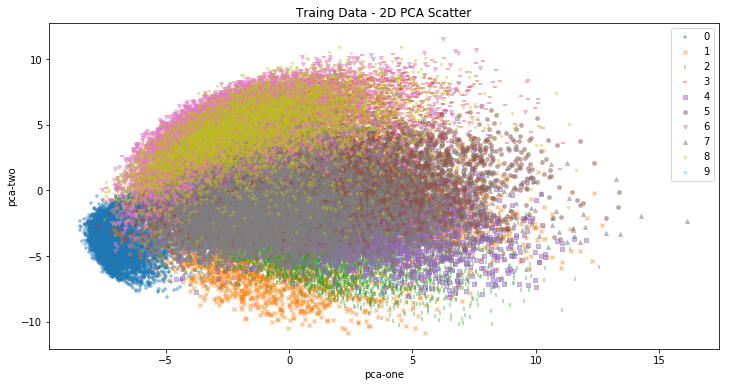

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)

plt.figure(figsize=(12,6))
marker= ['+', 'x','|','_','s','8','v','^','1','2']

print('Variation per Principal Component: {}'.format(pca.explained_variance_ratio_))

for i in range (10):
    plt.scatter(x_train_pca[y_train == i+1,0],
                x_train_pca[y_train == i+1,1],
                alpha = 0.45, s = 15,
                marker=marker[i],
                label = i)

plt.title('Traing Data - 2D PCA Scatter')
plt.xlabel('pca-one')
plt.ylabel('pca-two')
plt.legend()
plt.show()

### 2. Perceptrons: (10 points)
Single Layer Perceptron is one of the most basic binary classifiers one can use. In this part of the CW you should implement an iterative algorithm for training the Single Layer Perceptron.

As we are dealing with a binary classification problem, we will pick data points corresponding to classes 0 and 1 (handwritten digits). In addition we choose our binary labels to be -1 and 1, respectively.

In [6]:
#defining the train
cond = (y_train == 0) + (y_train == 1)
binary_x_train = x_train[cond,:]
binary_y_train = y_train[cond]*1.
binary_y_train[binary_y_train == 0] = -1
binary_y_train[binary_y_train == 1] = 1

#defining the test
cond = (y_test == 0) + (y_test == 1)
binary_x_test = x_test[cond,:]
binary_y_test = y_test[cond]*1.
binary_y_test[binary_y_test == 0] = -1
binary_y_test[binary_y_test == 1] = 1

#### Task 2.1
Complete the function 'predict' below.
#### inputs:

+ $x\in\mathbb{R^{n*m}}$, with $n$ being the number of datapoints and $m$ being the feature dimensionality. 
+ $w \in\mathbb{R^m}$ is the parameter vector we wish to learn. 
+ $b \in\mathbb{R}$ is the corresponding bias.

#### outputs: 
+ 'prediction'$\in\mathbb{R^n}$, a vector containing prediction values associated with $x$. 

In [7]:
def predict(x, w, b):
    ######### Complete the function- x point ######### 
    linear_comb = np.dot(x, w) + b
    if linear_comb > 0:
        return 1
    else:
        return -1

#### Task 2.2
+ Use the funtion 'predict' above to implement the Single Layer Perceptron algorithm by completing the function 'optimize' defined below.
    #### inputs:

    + $x\in\mathbb{R^{n*m}}$, with $n$ being the number of datapoints and $m$ being the feature dimensionality. 
    + $w \in\mathbb{R^m}$ is the initial parameter vector.
    + $b \in\mathbb{R}$ is the initial bias value.
    + $y\in\mathbb{R^n}$ is the training labels associated with x.
    #### outputs:
    + $w$ is the optimized parameter vector.
    + $b$ the corresponding learned bias.
    + $\text{error}$ is the classification error obtained.  
    
    
 
    
Use the learned parameters $w$, $b$ (obtained via function 'optimize') and the function 'predict' to return the classification accuracy on the test set using x_train and y_train as training data. 

- Demonstrate that your algorithm converges to a good local minima. Plot the training error curve vs. number of iterations. 
- Show what feature $w$ has learned and discuss why? (demonstrate $w$ as an image with the same size as inputs).

- Repeat this training/testing procedure to classify different pairs. Report the accuracies of 5 pairs in a Table and dicuss why some are easier to classify than others.


In [8]:
def predict_many(x, w, b):
    pred = np.empty(len(x))
    for i in range(len(x)):
        pred[i] = predict(x[i], w, b)
    return pred

In [9]:
def loss(pred, y):
    loss = 0
    for pred_i, y_i in zip(pred, y):
        if pred_i != y_i:
            loss += 1
    return loss/len(pred)

In [10]:
def optimize(x, y, lr=0.003):
    iter = 0
    error=np.inf
    n, m = x.shape
    w = np.random.rand(m) # Initialize the w vector
    b = np.random.rand()  # Initialize the b vector
    hist = []
    while (iter <= 1000) & (error > 1e-3):
        idx = np.random.randint(n) # Get random index to update
        prediction = predict(x[idx], w, b) # Predict one to update the bias
        if prediction == y[idx]:
            continue
        err = y[idx] - prediction
        w = w + lr * y[idx] * x[idx] # Update weights
        b += lr * err # Update bias
        if iter % 1 == 0: # Change when the loss is recorded and calculated
            pred = predict_many(x, w, b)
            error = loss(pred, y) # Update error
            hist.append(error)
        iter += 1
    return w, b, error, hist

Classification Accuracy = 99.91%



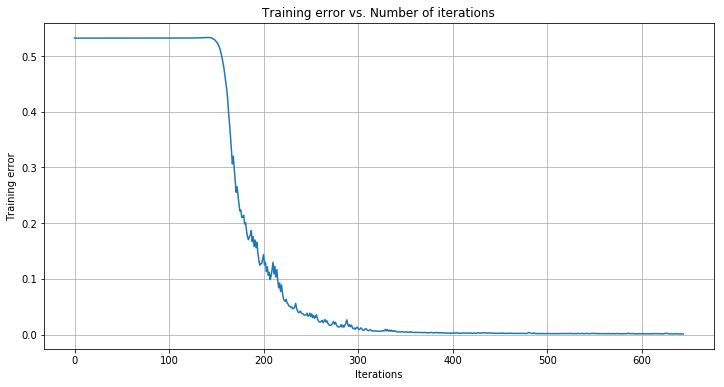

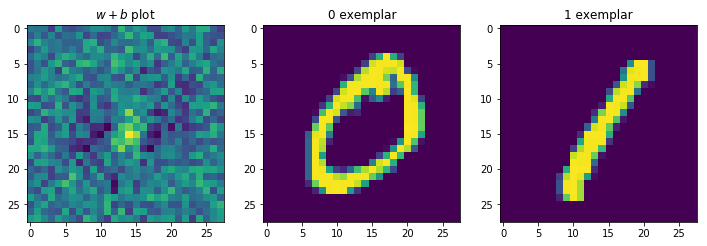

In [11]:
# optimising/training the single layer perceptron
the_w, the_b, training_error, hist = optimize(binary_x_train, binary_y_train)

# Use the learned parameters 𝑤, 𝑏 to predict and eturn the classification accuracy on the test set using x_train and y_train as training data.
binary_x_pred = predict_many(binary_x_test, the_w, the_b)
binary_xy = binary_x_pred  == binary_y_test
accuracy = sum(binary_xy)/len(binary_xy)
print(f"Classification Accuracy = {accuracy*100:.2f}%".format(5))
print('')

# plotting training error curve vs. number of iterations
plt.figure(figsize=(12,6))
plt.plot(hist)
plt.grid()
plt.title("Training error vs. Number of iterations")
plt.xlabel("Iterations")
plt.ylabel("Training error")

# demonstrate 𝑤 as an image with the same size as inputs
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,6))
ax1.imshow((the_w + the_b).reshape(28, 28))
ax2.imshow(binary_x_train[binary_y_train == -1][0].reshape(28, 28))
ax3.imshow(binary_x_train[binary_y_train == 1][0].reshape(28, 28))
ax1.title.set_text('$w+b$ plot')
ax2.title.set_text('0 exemplar')
ax3.title.set_text('1 exemplar')
plt.show()

In [12]:
def classify_pair(x1,x2):
    cond = (y_train == x1) + (y_train == x2)
    binary_x_train = x_train[cond,:]
    binary_y_train = y_train[cond]*1.
    binary_y_train[binary_y_train == x1] = -1
    binary_y_train[binary_y_train == x2] = 1
    
    cond = (y_test == x1) + (y_test == x2)
    binary_x_test = x_test[cond,:]
    binary_y_test = y_test[cond]*1.
    binary_y_test[binary_y_test == x1] = -1
    binary_y_test[binary_y_test == x2] = 1
    
    the_w, the_b, training_error, hist = optimize(binary_x_train, binary_y_train, lr=0.003)
    
    fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,6))
    ax1.imshow((the_w + the_b).reshape(28, 28))
    
    ax2.imshow(binary_x_train[binary_y_train == -1][0].reshape(28, 28))
    ax3.imshow(binary_x_train[binary_y_train == 1][0].reshape(28, 28))
    ax1.title.set_text('$w+b$ plot')
    ax2.title.set_text(str(x1)+' exemplar')
    ax3.title.set_text(str(x2)+' exemplar')
    plt.show()
    
    binary_x_pred = predict_many(binary_x_test, the_w, the_b)
    binary_xy = binary_x_pred  == binary_y_test
    accuracy = sum(binary_xy)/len(binary_xy)
    return accuracy

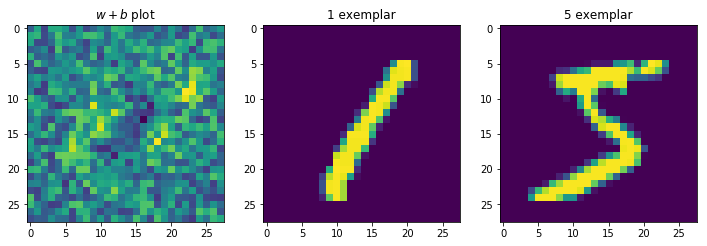

Classification Accuracy = 99.41%


In [13]:
acc1 = classify_pair(1,5)
print(f"Classification Accuracy = {acc1*100:.2f}%".format(5))

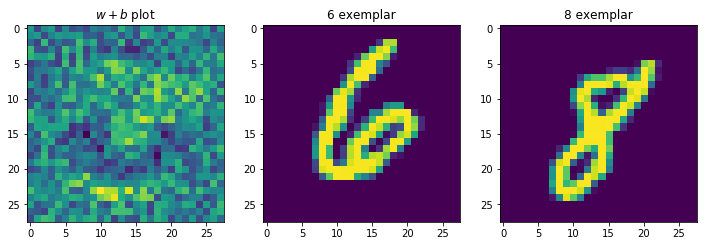

Classification Accuracy = 98.34%


In [14]:
acc2 = classify_pair(6,8)
print(f"Classification Accuracy = {acc2*100:.2f}%".format(5))

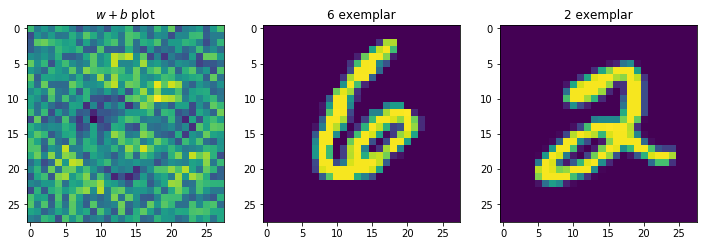

Classification Accuracy = 97.54%


In [15]:
acc3 = classify_pair(6,2)
print(f"Classification Accuracy = {acc3*100:.2f}%".format(5))

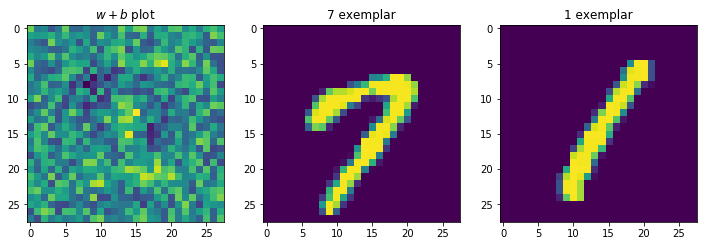

Classification Accuracy = 99.54%


In [16]:
acc4 = classify_pair(7,1)
print(f"Classification Accuracy = {acc4*100:.2f}%".format(5))

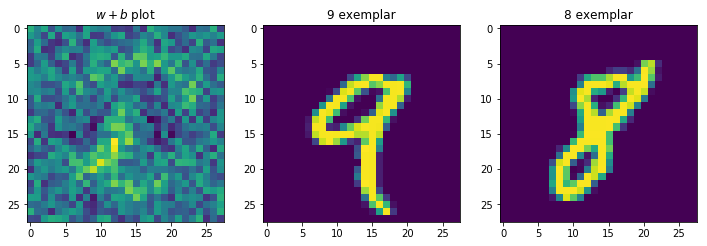

Classification Accuracy = 96.42%


In [17]:
acc5 = classify_pair(9,8)
print(f"Classification Accuracy = {acc5*100:.2f}%".format(5))

### 3: Multi Layer Perceptron (10 points)

Multi Layer Perceptron (MLP) is a fully connected deep (more than one hidden layer) network. In this part of the coursework we will implement a 2 hidden layers MLP with Recified Linear Unit (ReLU) activations. We will train the model via ADAM optimizer over a cross-entropy loss function.

First of all, we will convert our label vectors to matrices via one-hot encoding (e.g. $y=2$ would become $[0,0,1,0,0,0,0,0,0,0]$). This can be simply done using commands below:

In [18]:
y_train = np.eye(10)[y_train]
y_test = np.eye(10)[y_test]

Below, we define a class MLP. It is initialized via:  

+ x_train: The training matrix.
+ y_train: One hot encoding of the corresponding labels.
+ lr: Learning rate used for ADAM optimizer
+ nb_epochs: Number of epochs to use
+ batch_size: The number of data point in each mini-batch
+ output_dir: The directory where model parameters and tensorboard event files will be stored.

We also define the methods: 
* 'create_model' which will desribe a neural network architecture of the form $[784, 1000, 1000, 10]$, each integer representing the number of neurons in a given layer while the length of the vector defines the number of layers accordingly. 
* 'compute_loss' which given the output of 'create_model' will calculate the cross-entropy loss of the mini-batches.
* 'train' where we initiate a tensorflow session and perform the training iterations. 
* 'test' where we load our trained model and perform inference on the test set.

##### Task 3.1
- Complete the method 'create_model' in order to implement a network of the shape $[784, 1000, 1000, 10]$, use ReLU as the non linear activation for hidden layers.

   The function 'create_model' to complete defines the class variables: 

   + self.logits $\in \mathbb{R^{10}}$ containing the output __<font color='red'>without activation of the MLP.</font>__
   + self.preds $\in \mathbb{R^{10}}$ containing posterior probabilities.

- Using self.logits complete the method 'compute_loss' that takes the labels and the predicted logits to return the corresponfing cross-entropy loss. 

Hints: 
- You may use tf.layers.dense to implement a fully connected layer. 
- To obtain the probabilities you must normalize your outputs in a way that their sum is equal to one using a softmax function.

In [19]:
class MLP_2:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            # We create two hidden layers with 1000 parameters each
            hidden0 = tf.layers.dense(self.im, 784, activation = tf.nn.relu) 
            hidden1 = tf.layers.dense(hidden0, 1000, activation=tf.nn.relu)
            hidden2 = tf.layers.dense(hidden1, 1000, activation=tf.nn.relu)
            output = tf.layers.dense(hidden2, 10)
            
            self.logits = output # This is used in order to calculate the loss function
            self.preds = tf.nn.softmax(output) # This allows the model to be run and generate predictions
        #########################################
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

Now that we defined our model, our loss and its optimizer. we can instantate the MLP class, initiate our variables, and start the tensorflow session:

In [46]:
tf.reset_default_graph()

model = MLP_2(x_train, y_train, './MLP_logdir/', 0.001, 5, 100)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)


We can now start training. We loop over the training data points and we feed them to the session in mini-batches form. we repeat this process several times (for several epochs). 

In [48]:
import time

t0 = time.time()
mlp_2_train_loss = []
mlp_2_train_acc = []
mlp_2_test_loss = []
mlp_2_test_acc = []

for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})

        mlp_2_train_loss.append(loss)
        if i % 10 == 0:
            test_loss, test_preds = sess.run([model.loss, model.preds] , feed_dict={model.im: x_test, model.labels: y_test})
            test_acc = np.mean((np.argmax(test_preds, axis=1) == np.argmax(y_test, axis=1)) * 1)
            mlp_2_test_loss.append(test_loss)
            mlp_2_test_acc.append(test_acc)
            
        
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        
        mlp_2_train_acc.append(acc_train) # Appends batch accuracy
        
        if np.mod(i, model.nb_iterations//3) == 0:
            print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
    print('')
# sess.close()
MLP_2_1_time = time.time() - t0

Epoch 0, Iteration 0, loss 2.485, batch accuracy 0.070
Epoch 0, Iteration 200, loss 0.286, batch accuracy 0.920
Epoch 0, Iteration 400, loss 0.152, batch accuracy 0.950

Epoch 1, Iteration 0, loss 0.140, batch accuracy 0.950
Epoch 1, Iteration 200, loss 0.100, batch accuracy 0.980
Epoch 1, Iteration 400, loss 0.138, batch accuracy 0.940

Epoch 2, Iteration 0, loss 0.235, batch accuracy 0.960
Epoch 2, Iteration 200, loss 0.072, batch accuracy 0.980
Epoch 2, Iteration 400, loss 0.242, batch accuracy 0.930

Epoch 3, Iteration 0, loss 0.043, batch accuracy 0.980
Epoch 3, Iteration 200, loss 0.163, batch accuracy 0.960
Epoch 3, Iteration 400, loss 0.036, batch accuracy 0.990

Epoch 4, Iteration 0, loss 0.040, batch accuracy 0.980
Epoch 4, Iteration 200, loss 0.035, batch accuracy 0.990
Epoch 4, Iteration 400, loss 0.077, batch accuracy 0.970



Text(0, 0.5, 'Accuracy')

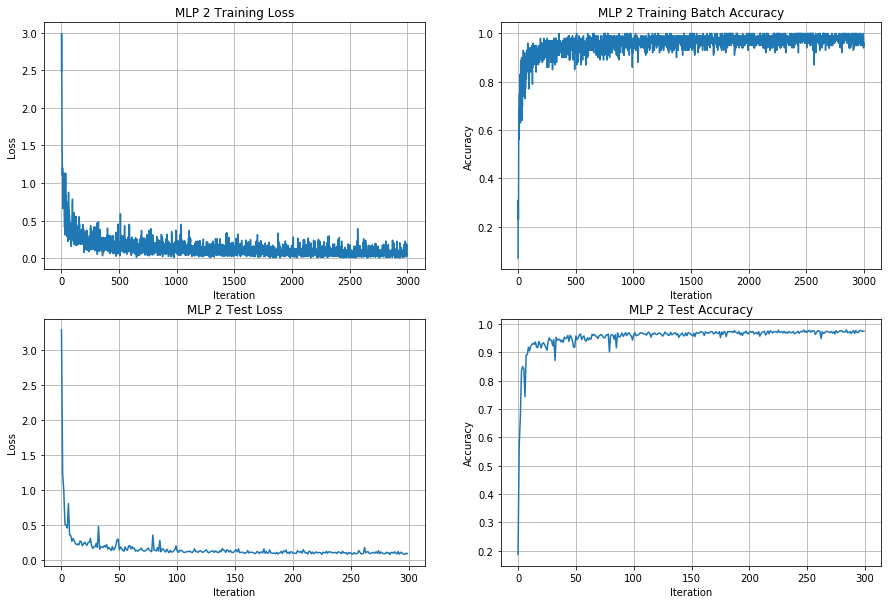

In [52]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))


ax1.plot(mlp_2_train_loss)
ax1.grid()
ax1.title.set_text("MLP 2 Training Loss")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")

ax2.plot(mlp_2_train_acc)
ax2.grid()
ax2.title.set_text("MLP 2 Training Batch Accuracy")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")

ax3.plot(mlp_2_test_loss)
ax3.grid()
ax3.title.set_text("MLP 2 Test Loss")
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Loss")

ax4.plot(mlp_2_test_acc)
ax4.grid()
ax4.title.set_text("MLP 2 Test Accuracy")
ax4.set_xlabel("Iteration")
ax4.set_ylabel("Accuracy")



During and after training visualize the training and the created graph via tensorboard. Tensorboard is accessible via the command "tensorboard --logdir=#yourlogdir#". Check out https://www.tensorflow.org/guide/summaries_and_tensorboard for more details.

Similarly we loop over the test dataset and get the test accuracy via:

In [54]:
batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
MLP_2_1_acc = np.mean((all_preds==y_real)*1)
print('Test accuracy achieved: %.3f' %MLP_2_1_acc)

Test accuracy achieved: 0.971



- Include a figure to visualize your training & testing(see below) performances during iterations and discuss your observations in your report.


We now close the tensorflow session:

In [55]:
sess.close()

##### Task 3.2
Using a similar format as before, discuss how the number of layers affects the classification accuracy. 
- Train four different networks with more hidden layers for example 3,4,5 and 7 hidden layers (choice is yours here to make a good conclusion). Choose an appropriate width i.e. number of neurons per layer so to achieve good accuracy and feasible training time. How many paramters (weights/biases) do these models have? How do they compare to the former MLP you implemented? 
- Compare the classification accuracies of these networks with the previous MLP.


- Plot a graph showing the accuracy vs. depth v.s. complexity (number of paramters) of the all five MLPs with different depths/widths. Additionally report the results in a Table. Discuss the results and provide conclusion. 


In [56]:
mlp_1 = [784, 1000, 1000, 10]
mlp_2 = [784, 650, 650, 650, 650, 10]
mlp_3 = [784, 1000, 1000, 1000, 1000, 10]
mlp_4 = [784, 400, 400, 400, 400, 400, 400, 10]
mlp_5 = [784, 525, 525, 525, 525, 525, 525, 10]
mlp_6 = [784, 350, 350, 350, 350, 350, 350, 350, 10]
mlp_7 = [784, 700, 600, 500, 400, 300, 200, 100, 10]

def MLP_complexity(mlp_shape):
    num_param = 0
 
    for i in range(1,len(mlp_shape)):
        num_param += mlp_shape[i]*mlp_shape[i-1]
        num_param += mlp_shape[i]

    return num_param

print('mlp_1 has %.f hidden layers and %.f paramters' %(len(mlp_1)-2, MLP_complexity(mlp_1)))
print('mlp_2 has %.f hidden layers and %.f paramters' %(len(mlp_2)-2, MLP_complexity(mlp_2)))
print('mlp_3 has %.f hidden layers and %.f paramters' %(len(mlp_3)-2, MLP_complexity(mlp_3)))
print('mlp_4 has %.f hidden layers and %.f paramters' %(len(mlp_4)-2, MLP_complexity(mlp_4)))
print('mlp_5 has %.f hidden layers and %.f paramters' %(len(mlp_5)-2, MLP_complexity(mlp_5)))
print('mlp_6 has %.f hidden layers and %.f paramters' %(len(mlp_6)-2, MLP_complexity(mlp_6)))
print('mlp_7 has %.f hidden layers and %.f paramters' %(len(mlp_7)-2, MLP_complexity(mlp_7)))


mlp_1 has 2 hidden layers and 1796010 paramters
mlp_2 has 4 hidden layers and 1786210 paramters
mlp_3 has 4 hidden layers and 3798010 paramters
mlp_4 has 6 hidden layers and 1120010 paramters
mlp_5 has 6 hidden layers and 1798135 paramters
mlp_6 has 7 hidden layers and 1015360 paramters
mlp_7 has 7 hidden layers and 1672610 paramters


In [66]:
def mlp_train_test(mlp_model,i, title):    
    t0 = time.time()

    tf.reset_default_graph()
    model = mlp_model(x_train, y_train, './MLP_'+str(i)+'_logdir/', 0.001, 5, 100)
    model.create_model()
    model.compute_loss()
    model.optimizer()
    init = (tf.global_variables_initializer(),
            tf.local_variables_initializer())

    saver = tf.train.Saver()
    summary =tf.Summary()
    sess = tf.InteractiveSession()
    sess.run(init)
    writer = tf.summary.FileWriter(model.output_dir)
    writer.add_graph(sess.graph)
    if not os.path.exists(model.output_dir):
        os.makedirs(model.output_dir)
    mlp_2_train_loss = []
    mlp_2_train_acc = []
    mlp_2_test_loss = []
    mlp_2_test_acc = []
        
    for epoch in range(model.nb_epochs):
        randomize = np.arange(x_train.shape[0])
        np.random.shuffle(randomize)
        x_in = model.x_train[randomize,:]
        y_in = model.y_train[randomize,:]
        for i in range(model.nb_iterations):
            input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
            input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
            _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                     feed_dict={model.im: input_x_train, 
                                                model.labels: input_y_train})
            
            mlp_2_train_loss.append(loss)
            if i % 10 == 0:
                test_loss, test_preds = sess.run([model.loss, model.preds] , feed_dict={model.im: x_test, model.labels: y_test})
                test_acc = np.mean((np.argmax(test_preds, axis=1) == np.argmax(y_test, axis=1)) * 1)
                mlp_2_test_loss.append(test_loss)
                mlp_2_test_acc.append(test_acc)
                                
            y_preds = np.argmax(preds, axis=1)
            y_real = np.argmax(input_y_train, axis=1)
            acc_train = np.mean((y_preds==y_real)*1)
            mlp_2_train_acc.append(acc_train) # Appends batch accuracy
            writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
        saver.save(sess, model.output_dir, global_step=epoch)  

    batch_size_test = 20
    nb_test_points = x_test.shape[0] 
    nb_iterations = nb_test_points//batch_size_test
    preds = []
    for i in range(nb_iterations):
        input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
        preds_test = sess.run(model.preds, 
                                 feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds_test, axis=1))
        if np.mod(nb_test_points, batch_size_test) !=0:
            input_x_test = x_test[i*batch_size_test: -1]
            preds_test = sess.run(model.preds, 
                                 feed_dict={model.im: input_x_test})
            preds.append(np.argmax(preds, axis=1))
    all_preds = np.concatenate(preds, axis =0)
    y_real = np.argmax(y_test, axis=1)
    acc_test = np.mean((all_preds==y_real)*1)
    sess.close()
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))


    ax1.plot(mlp_2_train_loss)
    ax1.grid()
    ax1.title.set_text("MLP 2 Training Loss " + title)
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")

    ax2.plot(mlp_2_train_acc)
    ax2.grid()
    ax2.title.set_text("MLP 2 Training Batch Accuracy " + title)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Accuracy")

    ax3.plot(mlp_2_test_loss)
    ax3.grid()
    ax3.title.set_text("MLP 2 Test Loss " + title)
    ax3.set_xlabel("Iteration")
    ax3.set_ylabel("Loss")

    ax4.plot(mlp_2_test_acc)
    ax4.grid()
    ax4.title.set_text("MLP 2 Test Accuracy " + title)
    ax4.set_xlabel("Iteration")
    ax4.set_ylabel("Accuracy")
    
    plt.show()
    
    return acc_test, time.time() - t0


In [58]:
class MLP_4_1: 
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            hidden0 = tf.layers.dense(self.im, 784, activation = tf.nn.relu) 
            hidden1 = tf.layers.dense(hidden0, 650, activation=tf.nn.relu)
            hidden2 = tf.layers.dense(hidden1, 650, activation=tf.nn.relu)
            hidden3 = tf.layers.dense(hidden2, 650, activation=tf.nn.relu)
            hidden4 = tf.layers.dense(hidden3, 650, activation=tf.nn.relu)
            output = tf.layers.dense(hidden4, 10)
            self.logits = output 
            self.preds = tf.nn.softmax(output)
            
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [59]:
class MLP_4_2:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            hidden0 = tf.layers.dense(self.im, 784, activation = tf.nn.relu) 
            hidden1 = tf.layers.dense(hidden0, 1000, activation=tf.nn.relu)
            hidden2 = tf.layers.dense(hidden1, 1000, activation=tf.nn.relu)
            hidden3 = tf.layers.dense(hidden2, 1000, activation=tf.nn.relu)
            hidden4 = tf.layers.dense(hidden3, 1000, activation=tf.nn.relu)
            output = tf.layers.dense(hidden4, 10)
            self.logits = output 
            self.preds = tf.nn.softmax(output)
            
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [60]:
class MLP_6_1:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            hidden0 = tf.layers.dense(self.im, 784, activation = tf.nn.relu) 
            hidden1 = tf.layers.dense(hidden0, 400, activation=tf.nn.relu)
            hidden2 = tf.layers.dense(hidden1, 400, activation=tf.nn.relu)
            hidden3 = tf.layers.dense(hidden2, 400, activation=tf.nn.relu)
            hidden4 = tf.layers.dense(hidden3, 400, activation=tf.nn.relu)
            hidden5 = tf.layers.dense(hidden4, 400, activation=tf.nn.relu)
            hidden6 = tf.layers.dense(hidden4, 400, activation=tf.nn.relu)
            output = tf.layers.dense(hidden5, 10)
            self.logits = output 
            self.preds = tf.nn.softmax(output)
            
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [61]:
class MLP_6_2:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            # We create two hidden layers with 1000 parameters each
            hidden0 = tf.layers.dense(self.im, 784, activation = tf.nn.relu) 
            hidden1 = tf.layers.dense(hidden0, 525, activation=tf.nn.relu)
            hidden2 = tf.layers.dense(hidden1, 525, activation=tf.nn.relu)
            hidden3 = tf.layers.dense(hidden2, 525, activation=tf.nn.relu)
            hidden4 = tf.layers.dense(hidden3, 525, activation=tf.nn.relu)
            hidden5 = tf.layers.dense(hidden4, 525, activation=tf.nn.relu)
            hidden6 = tf.layers.dense(hidden5, 525, activation=tf.nn.relu)
            output = tf.layers.dense(hidden6, 10)
            self.logits = output 
            self.preds = tf.nn.softmax(output)
            
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [62]:
class MLP_7_1:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            # We create two hidden layers with 1000 parameters each
            hidden0 = tf.layers.dense(self.im, 784, activation = tf.nn.relu) 
            hidden1 = tf.layers.dense(hidden0, 350, activation=tf.nn.relu)
            hidden2 = tf.layers.dense(hidden1, 350, activation=tf.nn.relu)
            hidden3 = tf.layers.dense(hidden2, 350, activation=tf.nn.relu)
            hidden4 = tf.layers.dense(hidden3, 350, activation=tf.nn.relu)
            hidden5 = tf.layers.dense(hidden4, 350, activation=tf.nn.relu)
            hidden6 = tf.layers.dense(hidden5, 350, activation=tf.nn.relu)
            hidden7 = tf.layers.dense(hidden6, 350, activation=tf.nn.relu)
            output = tf.layers.dense(hidden7, 10)
            self.logits = output 
            self.preds = tf.nn.softmax(output)
            
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [63]:
class MLP_7_2:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.nb_features = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 784])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('MLP', reuse=tf.AUTO_REUSE):
            # We create two hidden layers with 1000 parameters each
            hidden0 = tf.layers.dense(self.im, 784, activation = tf.nn.relu) 
            hidden1 = tf.layers.dense(hidden0, 480, activation=tf.nn.relu)
            hidden2 = tf.layers.dense(hidden1, 480, activation=tf.nn.relu)
            hidden3 = tf.layers.dense(hidden2, 480, activation=tf.nn.relu)
            hidden4 = tf.layers.dense(hidden3, 480, activation=tf.nn.relu)
            hidden5 = tf.layers.dense(hidden4, 480, activation=tf.nn.relu)
            hidden6 = tf.layers.dense(hidden5, 480, activation=tf.nn.relu)
            hidden7 = tf.layers.dense(hidden6, 480, activation=tf.nn.relu)
            output = tf.layers.dense(hidden7, 10)
            self.logits = output 
            self.preds = tf.nn.softmax(output)
            
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
            
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

depth = 2, paramters = 1796010, accuracy = 0.9710, time = 21.30


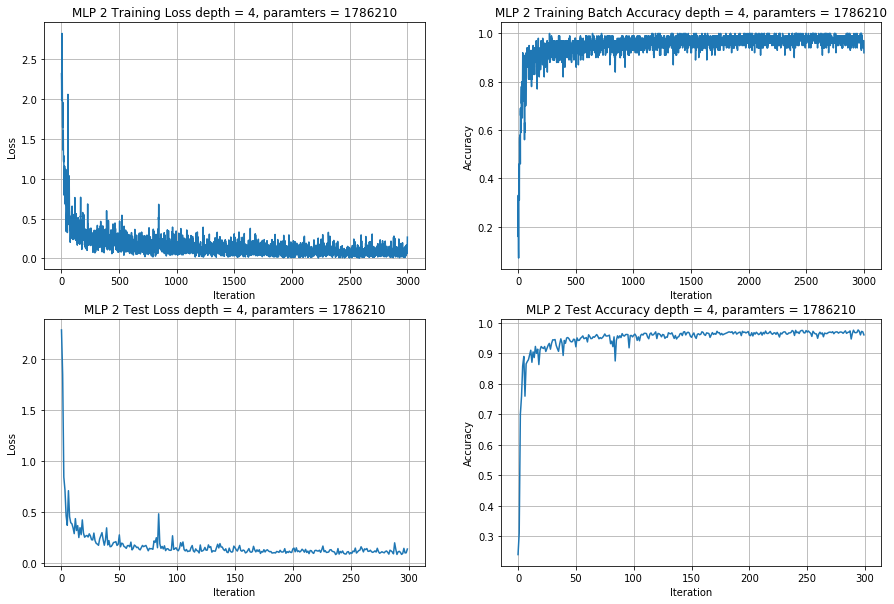

depth = 4, paramters = 1786210, accuracy = 0.9517, time = 23.92


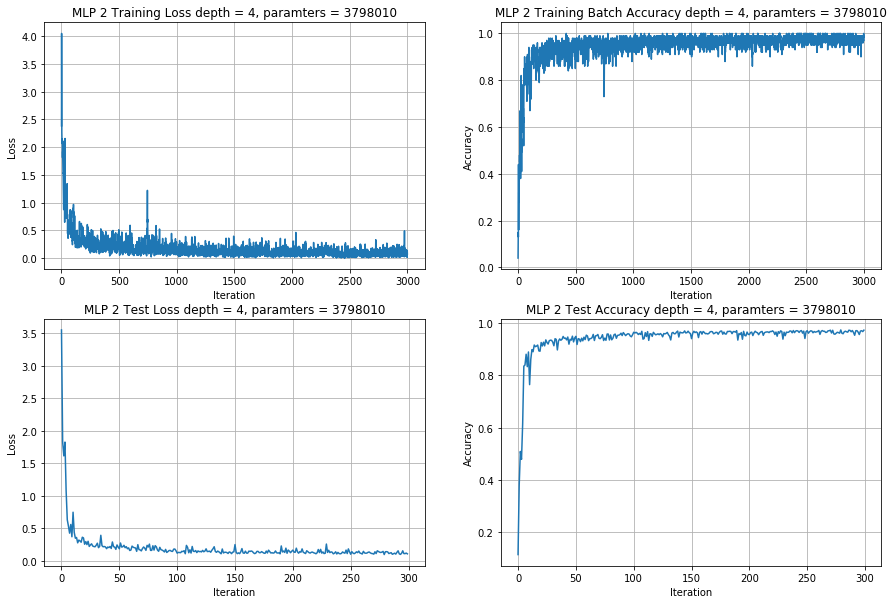

depth = 4, paramters = 3798010, accuracy = 0.9588, time = 29.52


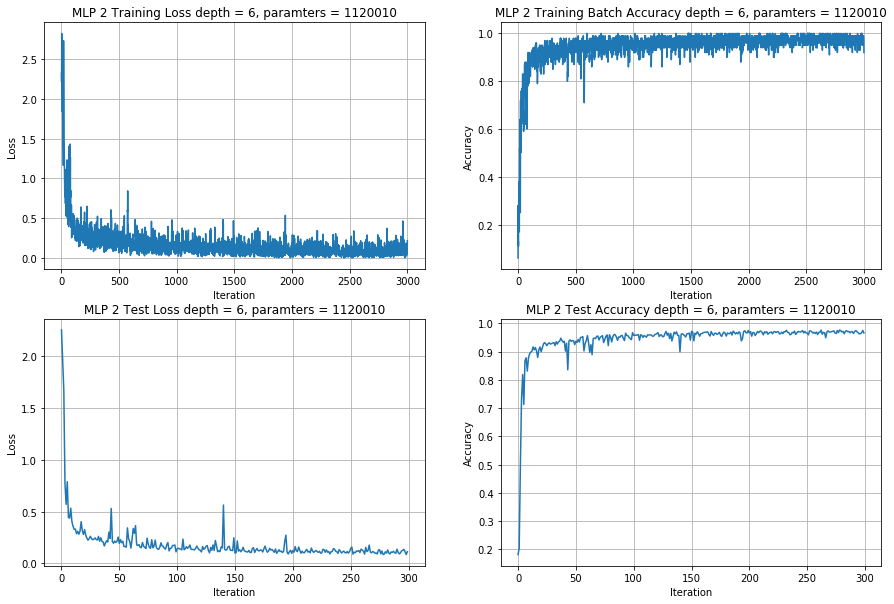

depth = 6, paramters = 1120010, accuracy = 0.9637, time = 19.75


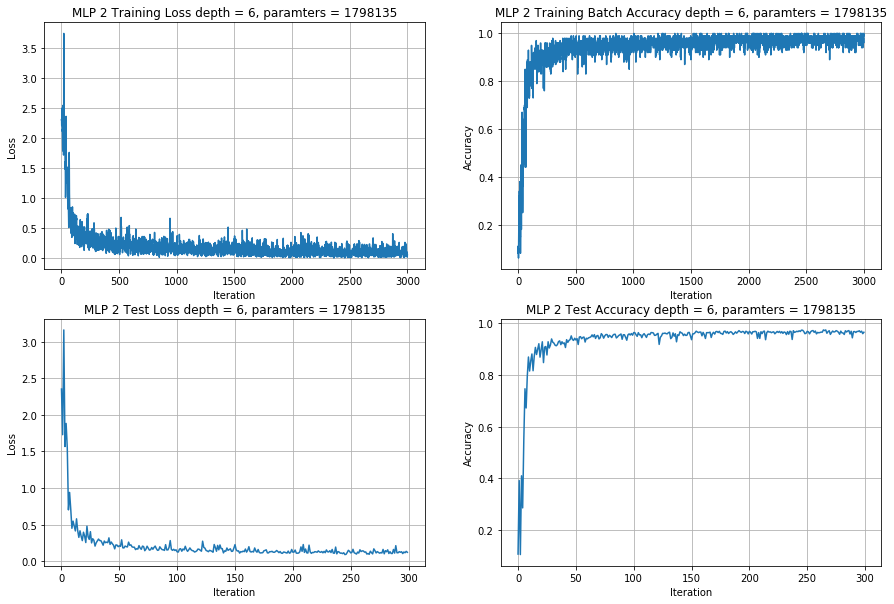

depth = 6, paramters = 1798135, accuracy = 0.9727, time = 23.66


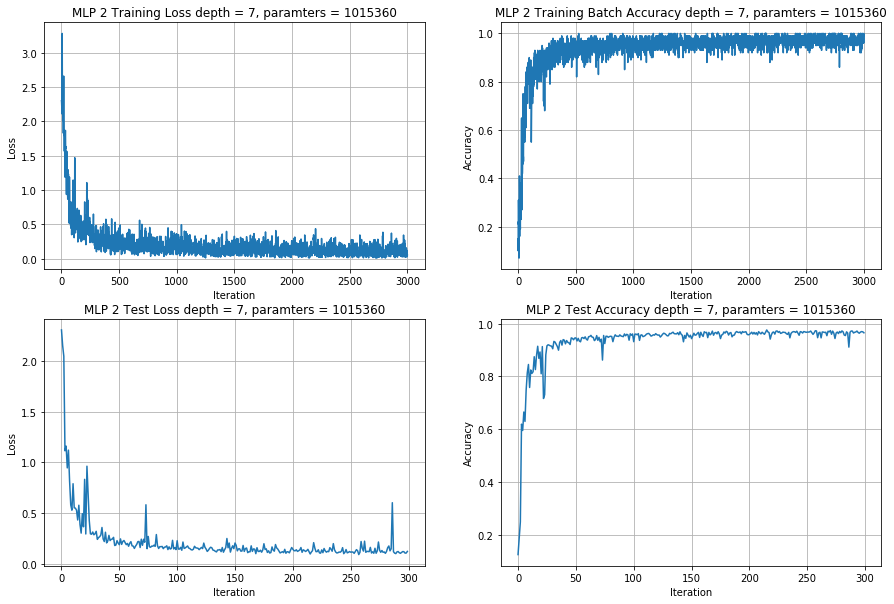

depth = 7, paramters = 1015360, accuracy = 0.9686, time = 19.94


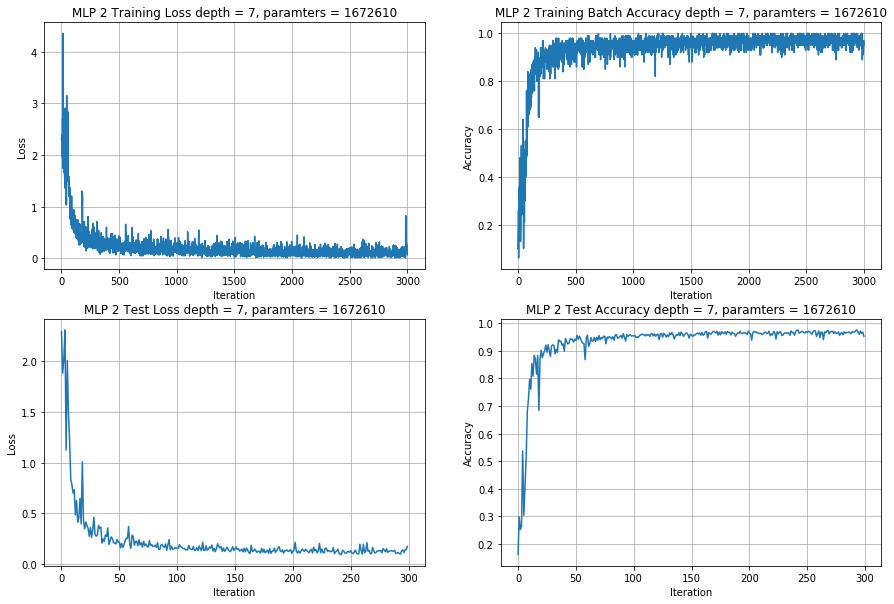

depth = 7, paramters = 1672610, accuracy = 0.9638, time = 23.79


In [67]:
print('depth = 2, paramters = %.f, accuracy = %.4f, time = %.2f' %(MLP_complexity(mlp_1), MLP_2_1_acc, MLP_2_1_time))

MLP_4_1_acc, MLP_4_1_time = mlp_train_test(MLP_4_1,1, 'depth = 4, paramters = %.f'%(MLP_complexity(mlp_2)))
print('depth = 4, paramters = %.f, accuracy = %.4f, time = %.2f' %(MLP_complexity(mlp_2), MLP_4_1_acc, MLP_4_1_time))
MLP_4_2_acc, MLP_4_2_time = mlp_train_test(MLP_4_2,2, 'depth = 4, paramters = %.f'%(MLP_complexity(mlp_3)))
print('depth = 4, paramters = %.f, accuracy = %.4f, time = %.2f' %(MLP_complexity(mlp_3), MLP_4_2_acc, MLP_4_2_time))

MLP_6_1_acc, MLP_6_1_time = mlp_train_test(MLP_6_1,3, 'depth = 6, paramters = %.f'%(MLP_complexity(mlp_4)))
print('depth = 6, paramters = %.f, accuracy = %.4f, time = %.2f' %(MLP_complexity(mlp_4), MLP_6_1_acc, MLP_6_1_time))
MLP_6_2_acc, MLP_6_2_time = mlp_train_test(MLP_6_2,4, 'depth = 6, paramters = %.f'%(MLP_complexity(mlp_5)))
print('depth = 6, paramters = %.f, accuracy = %.4f, time = %.2f' %(MLP_complexity(mlp_5), MLP_6_2_acc, MLP_6_2_time))

MLP_7_1_acc, MLP_7_1_time = mlp_train_test(MLP_7_1,5, 'depth = 7, paramters = %.f'%(MLP_complexity(mlp_6)))
print('depth = 7, paramters = %.f, accuracy = %.4f, time = %.2f' %(MLP_complexity(mlp_6), MLP_7_1_acc, MLP_7_1_time))
MLP_7_2_acc, MLP_7_2_time = mlp_train_test(MLP_7_2,6, 'depth = 7, paramters = %.f'%(MLP_complexity(mlp_7)))
print('depth = 7, paramters = %.f, accuracy = %.4f, time = %.2f' %(MLP_complexity(mlp_7), MLP_7_2_acc, MLP_7_2_time))

### 4. Convolutional Neural Network (10 points)
Now that we are more familiar with the MLP algorithm, it is time to see how it compares with a Convolutional Neural Network (CNN). CNNs leverage dependencies between neighbouring pixels, making them more efficient and light weight compared to their fully connected counter part. In this section we will implement a Class CNN similar to the one we defined before for MLP.

##### Task 4.1
Complete the function 'create_model' of the class CNN above. Implement a CNN of the shape [32, 64, 128]; where 32, 64, 128 represent the number of convolutional filters for each hidden layer. We will use a kernel size of size $4\times4$. 

Use a stride of 1 in the first convolutional layer, followed by a stride of 2 for the following layers (a stride of two help downsampling without requiring the use of pooling layers). Vectorize the obtained output using tf.layer.flatten, and end the model with a fully connected layer of 10 neurons. Use ReLU as the non linear activation for the hidden layers.

   The function 'create_model' to complete defines the class variables: 

   + self.logits $\in \mathbb{R^{10}}$ containing the output without activation of the last __<font color='red'>fully connected layer</font>.__ 

   + self.preds $\in \mathbb{R^{10}}$ containing posterior probabilities.

- Using self.logits complete the method 'compute_loss' that takes the labels and the predicted logits to return the corresponfing cross-entropy loss. 

Hints: 
+ You may use tf.layers.conv2d to implement a convolutional layer. 
+ To obtain the probabilities you must normalize your outputs in a way that their sum is equal to one using a softmax function.

In [68]:
class CNN_1:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train[:,:,:, np.newaxis]
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('CNN', reuse=tf.AUTO_REUSE):
            ######### Complete the function ######### 
            # We save the hidden layers inside as attributes from the object so 
            # they can be called layer for visualization
            self.hidden1 = tf.layers.conv2d(self.im, filters= 32, kernel_size=4, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.hidden2 = tf.layers.conv2d(self.hidden1, filters= 64, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d2') 
            self.hidden3 = tf.layers.conv2d(self.hidden2, filters= 128, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d3') 
            # After 3 convolutional filters we flatten the array
            flattened = tf.layers.flatten(self.hidden3)
            # We feed it to a dense network to adquire the logits
            output = tf.layers.dense(flattened, 10)
            self.logits = output
            self.preds = tf.nn.softmax(output) # This allows the model to be run and generate predictions
            #########################################
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

CNNs leverage dependencies between neighbouring pixels, however this information is partially lost when we vectorized our data. For training CNNs we will need to recover our initial shape of $N \times 28 \times 28$.

In [69]:
edge = int(np.sqrt(nb_features))
x_train.resize([n_train, edge, edge])
x_test.resize([n_test, edge, edge])

We instantiate our CNN class, start the corresponging tensorflow session and initiate the trainable variables. 

In [72]:
tf.reset_default_graph()

model = CNN_1(x_train, y_train, './CNN_1_logdir/', 0.001, 5, 100)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)

We start training:

In [75]:
t0 = time.time()
cnn_train_loss = []
cnn_train_acc = []
cnn_test_loss = []
cnn_test_acc = []
input_x_test_0 = x_test[:, :, :,np.newaxis]
for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        cnn_train_loss.append(loss)
        if i % 10 == 0:
            test_loss, test_preds = sess.run([model.loss, model.preds] , feed_dict={model.im: input_x_test_0, model.labels: y_test})
            test_acc = np.mean((np.argmax(test_preds, axis=1) == np.argmax(y_test, axis=1)) * 1)
            cnn_test_loss.append(test_loss)
            cnn_test_acc.append(test_acc)
        
        
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        
        cnn_train_acc.append(acc_train) # Appends batch accuracy

        if np.mod(i, model.nb_iterations//3) == 0:
            print('Epoch %d, Iteration %d, loss %.3f, batch accuracy %.3f' %(epoch, i, loss, acc_train))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  
    print('')
# sess.close()
CNN_1_time = time.time() - t0

Epoch 0, Iteration 0, loss 2.224, batch accuracy 0.280
Epoch 0, Iteration 200, loss 0.053, batch accuracy 0.990
Epoch 0, Iteration 400, loss 0.164, batch accuracy 0.930

Epoch 1, Iteration 0, loss 0.014, batch accuracy 1.000
Epoch 1, Iteration 200, loss 0.025, batch accuracy 0.990
Epoch 1, Iteration 400, loss 0.012, batch accuracy 0.990

Epoch 2, Iteration 0, loss 0.128, batch accuracy 0.970
Epoch 2, Iteration 200, loss 0.041, batch accuracy 0.980
Epoch 2, Iteration 400, loss 0.139, batch accuracy 0.960

Epoch 3, Iteration 0, loss 0.056, batch accuracy 0.980
Epoch 3, Iteration 200, loss 0.028, batch accuracy 0.980
Epoch 3, Iteration 400, loss 0.035, batch accuracy 0.990

Epoch 4, Iteration 0, loss 0.018, batch accuracy 1.000
Epoch 4, Iteration 200, loss 0.006, batch accuracy 1.000
Epoch 4, Iteration 400, loss 0.001, batch accuracy 1.000



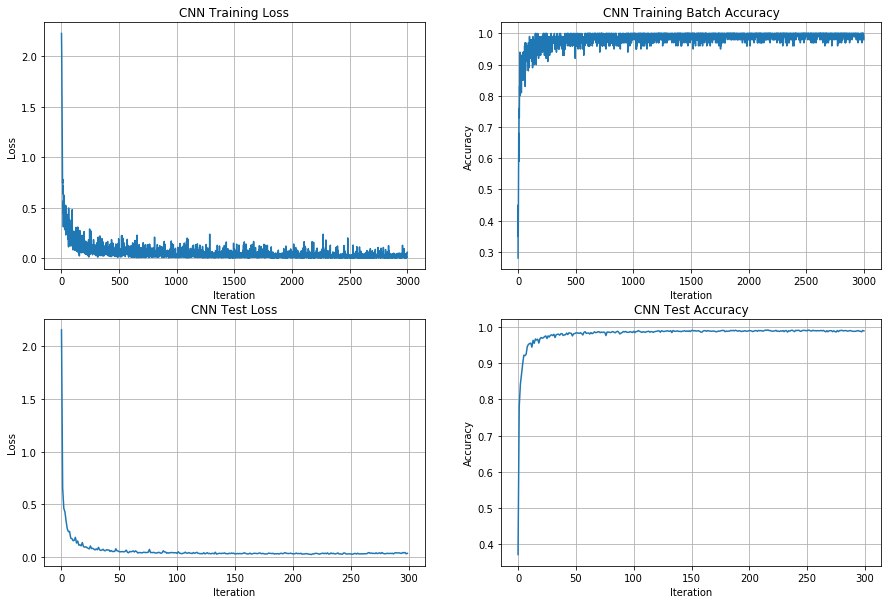

In [78]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))


ax1.plot(cnn_train_loss)
ax1.grid()
ax1.title.set_text("CNN Training Loss")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")

ax2.plot(cnn_train_acc)
ax2.grid()
ax2.title.set_text("CNN Training Batch Accuracy")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")

ax3.plot(cnn_test_loss)
ax3.grid()
ax3.title.set_text("CNN Test Loss")
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Loss")

ax4.plot(cnn_test_acc)
ax4.grid()
ax4.title.set_text("CNN Test Accuracy")
ax4.set_xlabel("Iteration")
ax4.set_ylabel("Accuracy")

plt.show()


we loop over the test dataset and compute the corresponding classification accuracy. 

- Similar to Task 3.1, include a figure to visualize your training & testing(see below) performances during iterations and discuss your observations in your report. 

In [76]:
batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    input_x_test = input_x_test[:, :, :,np.newaxis]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
CNN_1_acc = np.mean((all_preds==y_real)*1)
print('Test accuracy achieved: %.3f' %CNN_1_acc)

Test accuracy achieved: 0.991


In [ ]:
sess.close()

##### Task 4.2
Similar to task 3.2, discuss 
- Plot a graph showing complexity (number of paramters) vs. accuracy vs. depth of networks. For this part you need to train four additional CNNs of different depths/widths (again, your choice) and report the results in a Table. Discuss the results and provide conclusion.


- In addition discuss and analyze the differences in term of performance, number of model parameters (i.e. weights/biases) and training/testing times between CNNs and MLPs. Provide a concusion. (For these discussions you should compare your results in Table 4.2 to Table 3.2)

In [ ]:
cnn_1 = [32, 64, 128]
cnn_2 = [16, 32, 64, 128]
cnn_3 = [16, 16, 32, 64, 128]
cnn_4 = [9, 16, 36, 64]
cnn_5 = [64, 128, 256]

def CNN_complexity(cnn_shape):

    num_param = cnn_shape[0] * 4 * 4 + cnn_shape[0] # input has 1 channel with no parameters to learn
 
    for i in range(1,len(cnn_shape)):
        num_param += cnn_shape[i]*cnn_shape[i-1] * 16 #size of kernel is 4*4
        num_param += cnn_shape[i] #adding biases
    num_param += 10 * 28 * 28 *cnn_shape[-1] + 10 #final dense layer into the output for 28x28 images
    return num_param

print('cnn_1 has %.f convolutional layers and %.f paramters' %(len(cnn_1), CNN_complexity(cnn_1)))
print('cnn_2 has %.f convolutional layers and %.f paramters' %(len(cnn_2), CNN_complexity(cnn_2)))
print('cnn_3 has %.f convolutional layers and %.f paramters' %(len(cnn_3), CNN_complexity(cnn_3)))
print('cnn_4 has %.f convolutional layers and %.f paramters' %(len(cnn_4), CNN_complexity(cnn_4)))
print('cnn_5 has %.f convolutional layers and %.f paramters' %(len(cnn_5), CNN_complexity(cnn_5)))


cnn_1 has 3 convolutional layers and 1168106 paramters
cnn_2 has 4 convolutional layers and 1176058 paramters
cnn_3 has 5 convolutional layers and 1180170 paramters
cnn_4 has 4 convolutional layers and 550423 paramters
cnn_5 has 3 convolutional layers and 2663882 paramters


In [93]:
def cnn_train_test(cnn_model, i, title):
    t0 = time.time()
    tf.reset_default_graph()
    model = cnn_model(x_train, y_train, './CNN_'+str(i)+'_logdir/', 0.001, 5, 100)
    model.create_model()
    model.compute_loss()
    model.optimizer()
    init = (tf.global_variables_initializer(),
            tf.local_variables_initializer())

    saver = tf.train.Saver()
    summary =tf.Summary()
    sess = tf.InteractiveSession()
    sess.run(init)
    writer = tf.summary.FileWriter(model.output_dir)
    writer.add_graph(sess.graph)
    if not os.path.exists(model.output_dir):
        os.makedirs(model.output_dir)
    cnn_train_loss = []
    cnn_train_acc = []
    cnn_test_loss = []
    cnn_test_acc = []
    
    for epoch in range(model.nb_epochs):
        randomize = np.arange(x_train.shape[0])
        np.random.shuffle(randomize)
        x_in = model.x_train[randomize,:]
        y_in = model.y_train[randomize,:]
        for i in range(model.nb_iterations):
            input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
            input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
            _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                     feed_dict={model.im: input_x_train, 
                                                model.labels: input_y_train})
            cnn_train_loss.append(loss)
            if i % 10 == 0:
                test_loss, test_preds = sess.run([model.loss, model.preds] , feed_dict={model.im: input_x_test_0[:1000], model.labels: y_test[:1000]})
                test_acc = np.mean((np.argmax(test_preds, axis=1) == np.argmax(y_test[:1000], axis=1)) * 1)
                cnn_test_loss.append(test_loss)
                cnn_test_acc.append(test_acc)
                
            y_preds = np.argmax(preds, axis=1)
            y_real = np.argmax(input_y_train, axis=1)
            acc_train = np.mean((y_preds==y_real)*1)
            cnn_train_acc.append(acc_train) # Appends batch accuracy
            writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
        saver.save(sess, model.output_dir, global_step=epoch)  

    batch_size_test = 20
    nb_test_points = x_test.shape[0] 
    nb_iterations = nb_test_points//batch_size_test
    preds = []
    for i in range(nb_iterations):
        input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
        input_x_test = input_x_test[:, :, :,np.newaxis]
        preds_test = sess.run(model.preds, 
                                 feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds_test, axis=1))
        if np.mod(nb_test_points, batch_size_test) !=0:
            input_x_test = x_test[i*batch_size_test: -1]
            preds_test = sess.run(model.preds, 
                                 feed_dict={model.im: input_x_test})
            preds.append(np.argmax(preds, axis=1))
    all_preds = np.concatenate(preds, axis =0)
    y_real = np.argmax(y_test, axis=1)
    acc_test = np.mean((all_preds==y_real)*1)
    
    sess.close()
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))

    ax1.plot(cnn_train_loss)
    ax1.grid()
    ax1.title.set_text(title + " Training Loss")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")

    ax2.plot(cnn_train_acc)
    ax2.grid()
    ax2.title.set_text(title + " Training Batch Accuracy")
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Accuracy")

    ax3.plot(cnn_test_loss)
    ax3.grid()
    ax3.title.set_text(title + " Test Loss")
    ax3.set_xlabel("Iteration")
    ax3.set_ylabel("Loss")

    ax4.plot(cnn_test_acc)
    ax4.grid()
    ax4.title.set_text(title + " Test Accuracy")
    ax4.set_xlabel("Iteration")
    ax4.set_ylabel("Accuracy")

    plt.show()
    
    return acc_test, time.time() - t0

In [80]:
class CNN_2:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train[:,:,:, np.newaxis]
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('CNN', reuse=tf.AUTO_REUSE):
            self.hidden1 = tf.layers.conv2d(self.im, filters= 16, kernel_size=4, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.hidden2 = tf.layers.conv2d(self.hidden1, filters= 32, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d2') 
            self.hidden3 = tf.layers.conv2d(self.hidden2, filters= 64, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d3')
            self.hidden4 = tf.layers.conv2d(self.hidden3, filters= 128, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d4')
            flattened = tf.layers.flatten(self.hidden4)
            output = tf.layers.dense(flattened, 10)
            self.logits = output
            self.preds = tf.nn.softmax(output)
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [81]:
class CNN_3:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train[:,:,:, np.newaxis]
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('CNN', reuse=tf.AUTO_REUSE):
            self.hidden1 = tf.layers.conv2d(self.im, filters= 16, kernel_size=4, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.hidden2 = tf.layers.conv2d(self.hidden1, filters= 16, kernel_size=4, activation = tf.nn.relu, strides=1, name='conv2d2') 
            self.hidden3 = tf.layers.conv2d(self.hidden2, filters= 32, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d3')
            self.hidden4 = tf.layers.conv2d(self.hidden3, filters= 64, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d4')
            self.hidden5 = tf.layers.conv2d(self.hidden4, filters= 128, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d5')
            flattened = tf.layers.flatten(self.hidden5)
            output = tf.layers.dense(flattened, 10)
            self.logits = output
            self.preds = tf.nn.softmax(output)
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [82]:
class CNN_4:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train[:,:,:, np.newaxis]
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('CNN', reuse=tf.AUTO_REUSE):
            self.hidden1 = tf.layers.conv2d(self.im, filters= 9, kernel_size=4, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.hidden2 = tf.layers.conv2d(self.hidden1, filters= 16, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d2') 
            self.hidden3 = tf.layers.conv2d(self.hidden2, filters= 36, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d3')
            self.hidden4 = tf.layers.conv2d(self.hidden3, filters= 64, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d4')
            flattened = tf.layers.flatten(self.hidden4)
            output = tf.layers.dense(flattened, 10)
            self.logits = output
            self.preds = tf.nn.softmax(output)
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [83]:
class CNN_5:
    def __init__(self, x_train, y_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.labels = tf.placeholder(tf.float32, [None, 10])
        self.x_train = x_train[:,:,:, np.newaxis]
        self.y_train = y_train
        
    def create_model(self):
        with tf.variable_scope('CNN', reuse=tf.AUTO_REUSE):
            self.hidden1 = tf.layers.conv2d(self.im, filters= 64, kernel_size=4, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.hidden2 = tf.layers.conv2d(self.hidden1, filters= 128, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d2') 
            self.hidden3 = tf.layers.conv2d(self.hidden2, filters= 256, kernel_size=4, activation = tf.nn.relu, strides=2, name='conv2d3') 
            flattened = tf.layers.flatten(self.hidden3)
            output = tf.layers.dense(flattened, 10)
            self.logits = output
            self.preds = tf.nn.softmax(output)
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.labels, logits=self.logits))
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss)
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

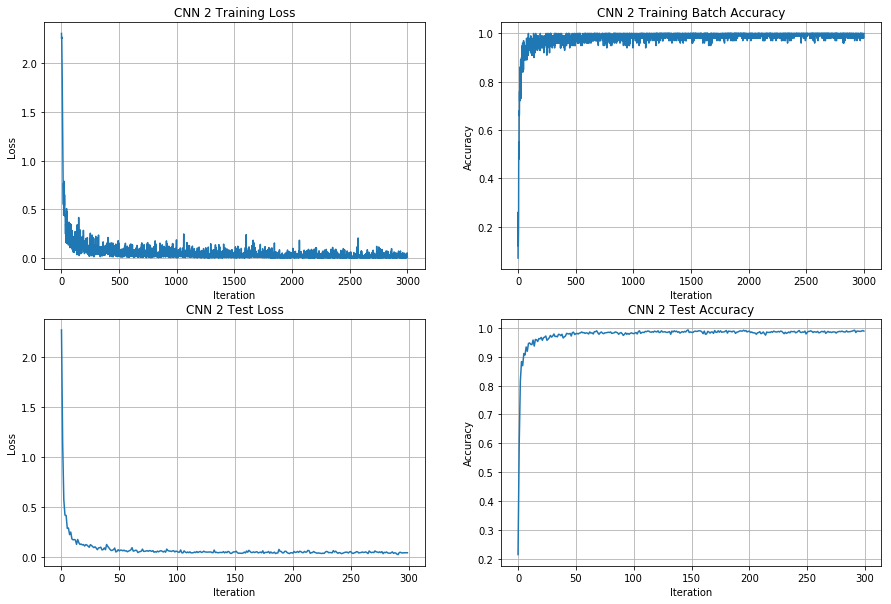

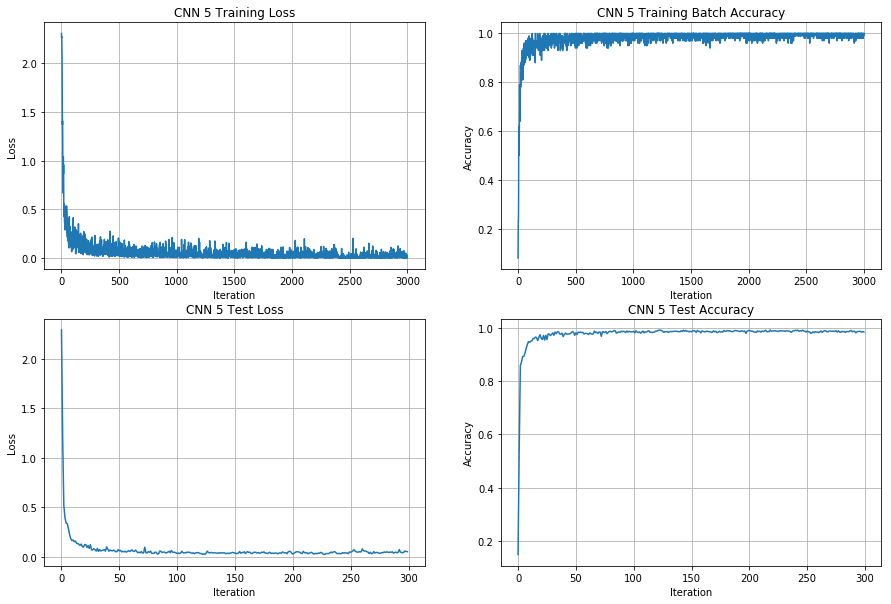

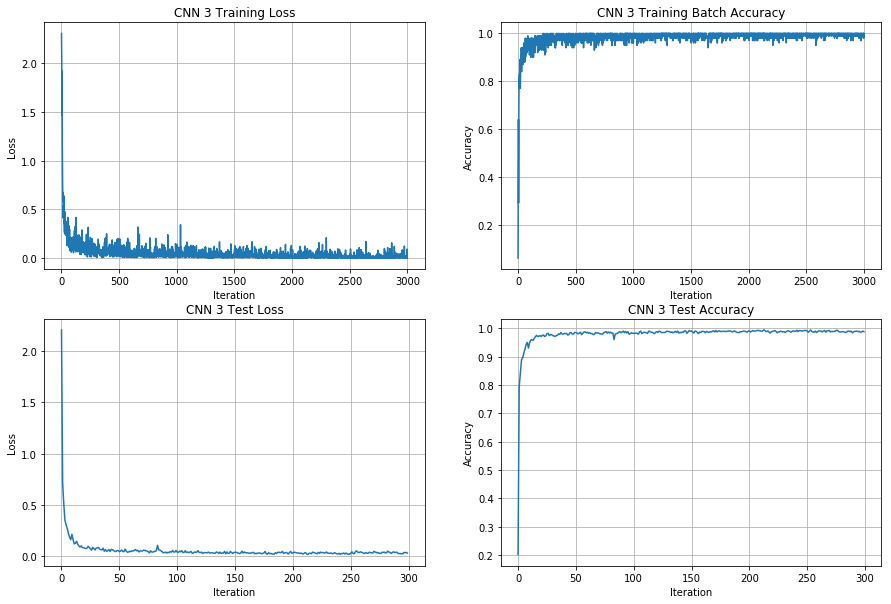

In [94]:
CNN_2_acc, CNN_2_time = cnn_train_test(CNN_2,2, 'CNN 2')
CNN_3_acc, CNN_3_time = cnn_train_test(CNN_3,3, 'CNN 5')
CNN_5_acc, CNN_5_time = cnn_train_test(CNN_5,5, 'CNN 3')

In [ ]:
tf.reset_default_graph()

model = CNN_4(x_train, y_train, './CNN_4_logdir/', 0.001, 5, 100)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)
    
t0 = time.time()
for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in = model.y_train[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train = y_in[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds, loss, loss_summ = sess.run([model.trainer, model.preds, model.loss, model.loss_summ], 
                                 feed_dict={model.im: input_x_train, 
                                            model.labels: input_y_train})
        y_preds = np.argmax(preds, axis=1)
        y_real = np.argmax(input_y_train, axis=1)
        acc_train = np.mean((y_preds==y_real)*1)
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch)  

CNN_4_time = time.time() - t0

batch_size_test = 20
nb_test_points = x_test.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds = []
for i in range(nb_iterations):
    input_x_test = x_test[i*batch_size_test: (i+1)*batch_size_test]
    input_x_test = input_x_test[:, :, :,np.newaxis]
    preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
    preds.append(np.argmax(preds_test, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test[i*batch_size_test: -1]
        preds_test = sess.run(model.preds, 
                             feed_dict={model.im: input_x_test})
        preds.append(np.argmax(preds, axis=1))
all_preds = np.concatenate(preds, axis =0)
y_real = np.argmax(y_test, axis=1)
CNN_4_acc = np.mean((all_preds==y_real)*1)

In [ ]:
print('depth = 3, paramters = %.f, accuracy = %.4f, time = %.2f' %(CNN_complexity(cnn_1), CNN_1_acc, CNN_1_time))
print('depth = 4, paramters = %.f, accuracy = %.4f, time = %.2f' %(CNN_complexity(cnn_2), CNN_2_acc, CNN_2_time))
print('depth = 5, paramters = %.f, accuracy = %.4f, time = %.2f' %(CNN_complexity(cnn_3), CNN_3_acc, CNN_3_time))
print('depth = 4, paramters = %.f, accuracy = %.4f, time = %.2f' %(CNN_complexity(cnn_4), CNN_4_acc, CNN_4_time))
print('depth = 3, paramters = %.f, accuracy = %.4f, time = %.2f' %(CNN_complexity(cnn_5), CNN_5_acc, CNN_5_time))

### 5. Visualizing learned filters and activations (6 points)
It is sometimes useful to visualize what kind of filters a CNN have learned. One way to do so is to plot each filter of size [kernel_size $\times$ kerne_size]. 

- Once your CNN (in Question 6) is trained, access its filters via 'tf.get_collection' and plot them on a grid for each layer. What patterns do you observe, why?
- In addition, plot the activations of each layer for two images chosen from digit-classes '2' and '9'. Discuss your observations

Hint: 
+ Activations are for example the outputs of tf.layers.conv2D.
+ Use tf.get_collection to access the learned filters of each layers. For this, you need to know how they are named (which can be accessed by tf.trainable_variables among other means of doing so).

The plotted feature maps and learned filters should be plotted in the same way as in the images bellow. (left: Feature Maps, right: learned Filters)

![Examples of activation maps (left), and learned features (right))](im.png)

In [ ]:
tf.trainable_variables()

In [ ]:
import math
import matplotlib.gridspec as gridspec

def getActivations(model, image, layer):
    units = sess.run(layer, feed_dict={model.im: image})
    plotNNFilter(units)
    
def plotNNFilter(units):
    filters = units.shape[3]
    n_columns = int(round(np.sqrt(filters)+0.4,0))
    n_rows = math.ceil(filters / n_columns) + 1
    plt.figure(1, figsize=(4.5,6))
    gs = gridspec.GridSpec(n_rows, n_columns,wspace=0.025, hspace=0.025)
    
    for i in range(filters):
        ax1 = plt.subplot(gs[i])
        ax1.imshow(units[0,:,:,i], cmap="gray")
        ax1.axis('off')
    plt.show()

In [ ]:
print("INPUT EXEMPLAR")
plt.figure(1, figsize=(1.5,1.5))
plt.imshow(x_test[20], cmap="gray")
plt.axis('off')
plt.show()
print("FIRST HIDDEN LAYER")
getActivations(model, x_test[20].reshape(-1, 28, 28, 1), model.hidden1)
print("SECOND HIDDEN LAYER")
getActivations(model, x_test[20].reshape(-1, 28, 28, 1), model.hidden2)
print("THIRD HIDDEN LAYER")
getActivations(model, x_test[20].reshape(-1, 28, 28, 1), model.hidden3)
print("FOURTH HIDDEN LAYER")
getActivations(model, x_test[20].reshape(-1, 28, 28, 1), model.hidden4)

In [ ]:
print("INPUT EXEMPLAR")
plt.figure(1, figsize=(1.5,1.5))
plt.imshow(x_test[22], cmap="gray")
plt.axis('off')
plt.show()
print("FIRST HIDDEN LAYER")
getActivations(model, x_test[22].reshape(-1, 28, 28, 1), model.hidden1)
print("SECOND HIDDEN LAYER")
getActivations(model, x_test[22].reshape(-1, 28, 28, 1), model.hidden2)
print("THIRD HIDDEN LAYER")
getActivations(model, x_test[22].reshape(-1, 28, 28, 1), model.hidden3)
print("FOURTH HIDDEN LAYER")
getActivations(model, x_test[22].reshape(-1, 28, 28, 1), model.hidden4)

In [ ]:
def plot_filters(filters):
    num_filters = filters.shape[3]
    n_columns = int(round(np.sqrt(num_filters)+0.4,0))
    n_rows = math.ceil(num_filters/n_columns) + 1
    fig = plt.figure(1, figsize=(4.5, 6))
    gs = gridspec.GridSpec(n_rows, n_columns,wspace=0.025, hspace = 0.025)

    for i in range(num_filters):
        ax1 = plt.subplot(gs[i])
        ax1.imshow(filters[:, :, 0, i], cmap="gray", aspect='equal')
        ax1.axis('off')
    plt.show()

for i in range(1, 5):
    print("FILTERS OF LAYER {}".format(i))
    layer = tf.get_collection(tf.GraphKeys.VARIABLES, 'CNN/conv2d{}/kernel:0'.format(i))[0]
    w1 = sess.run(layer)
    plot_filters(w1)


In [ ]:
sess.close()

### 6. Multi Task Learning (12 points)

This question concerns the practice of multi-task learning (MTL). 
The aim of multi task learning is to leverage two (or more) related tasks in the learning process with the hope that leanring one task aids perfromance in learning the other task(s) and thus improves predicitve power for at least one (ideally all) of the tasks. 

There are two distinct flavours of MTL: Hard parameter  sharing and soft parameter sharing. We will be focusing on the former in this question.
Hard paramter sharing occurs when two tasks share a common network which then splits into task specific paths (e.g. a series of convolutional layers with two paths of dense layers for two seperate tasks). 

In this question, you will explore the FASHION MNIST dataset and be coding up your own MTL model and considering the pros and cons of MTL compared to single task learning. 

We have written the code to pre-load this dataset and split it into two related tasks for you:

- Task 1 - Clothing item 10 class classification (e.g. shoes, t-shirts etc) across 10 goups - $ y \in \mathbb{R^{10}} $
- Task 2 - Clothing group three class classification - predicitng whether a viewed clothing image belongs to one of three groups - $ y \in \mathbb{R^{3}} $
    - These groups are shoes (Sandal, Sneaker and Ankle Boot),  Gendered (Dress, Shirt and Bag) and Uni-Sex (T-shirt, Trouser, Pullover and Coat). 


#### Note : Alternativley use the tf.nn module. 

#### Note  : We advise the use of only a single epoch for this question for the sake of computation time.  However, if you want to utilise additional epochs feel free to do so just be aware of the longer training time and be consistent over all networks. 

In [34]:
"""
Code for loading the dataset
"""
import keras.datasets.fashion_mnist as fashion_mnist
from keras.utils import to_categorical

def load_data(): 
    # train_X: (60000, 28, 28)
    # train_y: (60000,)
    # test_X: (10000, 28, 28)
    # test_y: (10000,)
    (train_X, train_y_1), (test_X, test_y_1) = fashion_mnist.load_data()
    n_class_1 = 10
    # map to new label
    train_y_2 = list(0 if y in [5, 7, 9] else 1 if y in [3, 6, 8] else 2 for y in train_y_1)  
    test_y_2 = list(0 if y in [5, 7, 9] else 1 if y in [3, 6, 8] else 2 for y in test_y_1)
    n_class_2 = 3
    # train_X: (60000, 28, 28, 1)
    # test_X: (10000, 28, 28, 1)
    # train_y: (60000, n_class = 10)
    # test_y: (10000, n_class = 3)
    train_X = np.expand_dims(train_X, axis=3)
    test_X = np.expand_dims(test_X, axis=3)
    train_y_1 = to_categorical(train_y_1, n_class_1)
    test_y_1 = to_categorical(test_y_1, n_class_1)
    train_y_2 = to_categorical(train_y_2, n_class_2)
    test_y_2 = to_categorical(test_y_2, n_class_2)
    return train_X, train_y_1, train_y_2, test_X, test_y_1, test_y_2


x_train_fashion, y_train_1, y_train_2, x_test_fashion, y_test_1, y_test_2 = load_data()

#### Task 6.1

In this question you will construct two seperate networks of identical structure (excpet the logits and pred layers) one for each of the two tasks.

In other words, create a network for item classification and a network for item group classification. 


Complete the Task_1_NN and Task_2_NN below. These single task networks will form the basis of your work in this question. 

For the sake of convieience, we will use the same CNN filters as Question 4 - $[32, 64, 128]$. However our kernel size will be 3 $\times$ 3 and a stride of 1 for all convolutional layers. Maxpooling layers will also need to be implemented after the first and second convolutional layers. These maxpooling layers have a kernel size of two and a stride of 2. 

After the final convolution, flatten the outputs and pass them to dense layers $[3136, 1024, 100 , N]$ where $N$ is the number of outputs required (10 or 3). 

As with Question 4, the function 'create_model' to be cpomplemted defines the class variables:
 - Task 1
     - self.logits $\in \mathbb{R^{10}}$ containing the output without activation of the last __<font color='red'>fully connected (i.e. dense) layer</font>.__ 
     - self.preds $\in \mathbb{R^{10}}$ containing posterior probabilities.
 - Task 2
      - self.logits $\in \mathbb{R^{3}}$ containing the output without activation of the last __<font color='red'>fully connected layer</font>.__ 
      - self.preds $\in \mathbb{R^{3}}$ containing posterior probabilities.
      
The method definitons remain the same  as in previous questions. 
      
      
#### Note: We advise you save the number of parameters and accuracy of the models in order to save time later. 

In [35]:
class Task_1_NN():
    def __init__(self, x_train, y_train_1,  output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.x_train = x_train
        self.y_train_1 = y_train_1
        self.m = x_train.shape[0]
        self.n_output_1 = y_train_1.shape[1]
        
        self.X = tf.placeholder(tf.float32, (None, 28, 28, 1), "X")
        self.y_1 = tf.placeholder(tf.float32, (None, self.n_output_1), "y_1")
    
    def create_model(self):            
        with tf.variable_scope("Task_1", reuse=tf.AUTO_REUSE):
            self.hidden1 = tf.layers.conv2d(self.X, filters= 32, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.pool1 = tf.layers.max_pooling2d(self.hidden1, pool_size=2, strides=2)

            self.hidden2 = tf.layers.conv2d(self.pool1, filters= 64, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d2') 
            self.pool2 = tf.layers.max_pooling2d(self.hidden2, pool_size=2, strides=2)

            self.hidden3 = tf.layers.conv2d(self.pool2, filters= 128, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d3') 
            self.pool3 = tf.layers.max_pooling2d(self.hidden3, pool_size=2, strides=2)
            
            flattened = tf.layers.flatten(self.pool3)
            # We feed it to a dense network to adquire the logits
            self.dense1 = tf.layers.dense(flattened, 3136)
            self.dense2 = tf.layers.dense(self.dense1, 1024)
            self.dense3 = tf.layers.dense(self.dense2, 100)
            self.output = tf.layers.dense(self.dense3, 10)

            
            ######### Complete the function ######### 
            self.logits = self.output
            self.pred_1 = tf.nn.softmax(self.logits) # This allows the model to be run and generate predictions
            #########################################
                
                
                
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss_task_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y_1, logits=self.logits))
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss_task_1) 
                
                
    def optimizer(self):
        with tf.variable_scope('optimizer', reuse=tf.AUTO_REUSE):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss_task_1, var_list=self.model_vars)
            


In [36]:
class Task_2_NN():
    def __init__(self, x_train, y_train_2,  output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.x_train = x_train
        self.y_train_2 = y_train_2
        self.m = x_train.shape[0]
        self.n_output_2 = y_train_2.shape[1]
        
        self.X = tf.placeholder(tf.float32, (None, 28, 28, 1), "X")
        self.y_2 = tf.placeholder(tf.float32, (None, self.n_output_2), "y_2")
    
    def create_model(self):            
        with tf.variable_scope("Task_2", reuse=tf.AUTO_REUSE):
            self.hidden1 = tf.layers.conv2d(self.X, filters= 32, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.pool1 = tf.layers.max_pooling2d(self.hidden1, pool_size=2, strides=2)

            self.hidden2 = tf.layers.conv2d(self.pool1, filters= 64, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d2') 
            self.pool2 = tf.layers.max_pooling2d(self.hidden2, pool_size=2, strides=2)

            self.hidden3 = tf.layers.conv2d(self.pool2, filters= 128, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d3') 
            self.pool3 = tf.layers.max_pooling2d(self.hidden3, pool_size=2, strides=2)
            
            flattened = tf.layers.flatten(self.pool3)
            # We feed it to a dense network to adquire the logits
            self.dense1 = tf.layers.dense(flattened, 3136)
            self.dense2 = tf.layers.dense(self.dense1, 1024)
            self.dense3 = tf.layers.dense(self.dense2, 100)
            self.output = tf.layers.dense(self.dense3, 3)

            
            ######### Complete the function ######### 
            self.logits = self.output
            self.pred_2 = tf.nn.softmax(self.logits) # This allows the model to be run and generate predictions
            #########################################
                
                
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss_task_2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y_2, logits=self.logits))
            #########################################
            self.loss_summ = tf.summary.scalar("softmax_loss", self.loss_task_2) 
                
                
    def optimizer(self):
        with tf.variable_scope('optimizer', reuse=tf.AUTO_REUSE):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss_task_2, var_list=self.model_vars)

#### Now train and test Task 1:

In [108]:
import time
tf.reset_default_graph()


model_1 = Task_1_NN(x_train_fashion, y_train_1, './Task1_logdir/', 0.001, 2, 10)            
model_1.create_model()     

model_1.compute_loss()
model_1.optimizer()   

model_1.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()


sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model_1.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model_1.output_dir):
    os.makedirs(model_1.output_dir)  

"""
Train
"""

task1_train_loss = []
task1_train_acc = []
task1_test_loss = []
task1_test_acc = []

for epoch in range(model_1.nb_epochs):
    randomize = np.arange(x_train_fashion.shape[0])
    np.random.shuffle(randomize)
    x_in = model_1.x_train[randomize,:]
    y_in_1 = model_1.y_train_1[randomize,:]
    for i in range(model_1.nb_iterations):
        input_x_train = x_in[i*model_1.batch_size: (i+1)*model_1.batch_size]
        input_y_train_1 = y_in_1[i*model_1.batch_size: (i+1)*model_1.batch_size]
        _ , preds_1, loss_1, loss_summ = sess.run([model_1.trainer, model_1.pred_1,  model_1.loss_task_1, model_1.loss_summ], 
                                 feed_dict={model_1.X: input_x_train, 
                                            model_1.y_1: input_y_train_1})
        
        task1_train_loss.append(loss_1)
        if i % 10 == 0:
            test_loss, test_preds = sess.run([model_1.loss_task_1, model_1.pred_1] , feed_dict={model_1.X: x_test_fashion, model_1.y_1: y_test_1})
            test_acc = np.mean((np.argmax(test_preds, axis=1) == np.argmax(y_test_1, axis=1)) * 1)
            task1_test_loss.append(test_loss)
            task1_test_acc.append(test_acc)

        y_preds_1 = np.argmax(preds_1, axis=1)
        y_real_1 = np.argmax(input_y_train_1, axis=1)
        acc_train_1 = np.mean((y_preds_1==y_real_1)*1)
        task1_train_acc.append(acc_train_1)
        print('Epoch %d, Iteration %d, loss_1 %.3f,  batch accuracy_1 %.3f' %(epoch, i, loss_1,acc_train_1))
        writer.add_summary(loss_summ, epoch * model_1.nb_iterations + i)
    saver.save(sess, model_1.output_dir, global_step=epoch) 
end = time.time()

Epoch 0, Iteration 0, loss_1 12.346,  batch accuracy_1 0.000
Epoch 0, Iteration 1, loss_1 242.021,  batch accuracy_1 0.200
Epoch 0, Iteration 2, loss_1 158.624,  batch accuracy_1 0.000
Epoch 0, Iteration 3, loss_1 35.194,  batch accuracy_1 0.200
Epoch 0, Iteration 4, loss_1 26.084,  batch accuracy_1 0.200
Epoch 0, Iteration 5, loss_1 17.628,  batch accuracy_1 0.300
Epoch 0, Iteration 6, loss_1 4.326,  batch accuracy_1 0.200
Epoch 0, Iteration 7, loss_1 3.018,  batch accuracy_1 0.300
Epoch 0, Iteration 8, loss_1 2.209,  batch accuracy_1 0.400
Epoch 0, Iteration 9, loss_1 2.414,  batch accuracy_1 0.400
Epoch 0, Iteration 10, loss_1 5.898,  batch accuracy_1 0.300
Epoch 0, Iteration 11, loss_1 1.574,  batch accuracy_1 0.700
Epoch 0, Iteration 12, loss_1 2.923,  batch accuracy_1 0.200
Epoch 0, Iteration 13, loss_1 1.573,  batch accuracy_1 0.600
Epoch 0, Iteration 14, loss_1 3.298,  batch accuracy_1 0.300
Epoch 0, Iteration 15, loss_1 1.610,  batch accuracy_1 0.500
Epoch 0, Iteration 16, los

Epoch 0, Iteration 140, loss_1 2.346,  batch accuracy_1 0.500
Epoch 0, Iteration 141, loss_1 1.060,  batch accuracy_1 0.500
Epoch 0, Iteration 142, loss_1 1.015,  batch accuracy_1 0.500
Epoch 0, Iteration 143, loss_1 1.984,  batch accuracy_1 0.200
Epoch 0, Iteration 144, loss_1 2.981,  batch accuracy_1 0.400
Epoch 0, Iteration 145, loss_1 1.141,  batch accuracy_1 0.500
Epoch 0, Iteration 146, loss_1 2.237,  batch accuracy_1 0.400
Epoch 0, Iteration 147, loss_1 1.281,  batch accuracy_1 0.500
Epoch 0, Iteration 148, loss_1 4.915,  batch accuracy_1 0.300
Epoch 0, Iteration 149, loss_1 1.822,  batch accuracy_1 0.200
Epoch 0, Iteration 150, loss_1 1.234,  batch accuracy_1 0.500
Epoch 0, Iteration 151, loss_1 0.776,  batch accuracy_1 0.700
Epoch 0, Iteration 152, loss_1 1.234,  batch accuracy_1 0.600
Epoch 0, Iteration 153, loss_1 1.593,  batch accuracy_1 0.400
Epoch 0, Iteration 154, loss_1 0.883,  batch accuracy_1 0.700
Epoch 0, Iteration 155, loss_1 1.117,  batch accuracy_1 0.600
Epoch 0,

Epoch 0, Iteration 284, loss_1 1.136,  batch accuracy_1 0.600
Epoch 0, Iteration 285, loss_1 1.265,  batch accuracy_1 0.600
Epoch 0, Iteration 286, loss_1 0.782,  batch accuracy_1 0.700
Epoch 0, Iteration 287, loss_1 1.194,  batch accuracy_1 0.400
Epoch 0, Iteration 288, loss_1 0.973,  batch accuracy_1 0.800
Epoch 0, Iteration 289, loss_1 0.547,  batch accuracy_1 0.900
Epoch 0, Iteration 290, loss_1 0.602,  batch accuracy_1 0.800
Epoch 0, Iteration 291, loss_1 0.901,  batch accuracy_1 0.600
Epoch 0, Iteration 292, loss_1 0.675,  batch accuracy_1 0.600
Epoch 0, Iteration 293, loss_1 0.399,  batch accuracy_1 0.800
Epoch 0, Iteration 294, loss_1 0.632,  batch accuracy_1 0.700
Epoch 0, Iteration 295, loss_1 1.336,  batch accuracy_1 0.700
Epoch 0, Iteration 296, loss_1 0.656,  batch accuracy_1 0.700
Epoch 0, Iteration 297, loss_1 0.713,  batch accuracy_1 0.800
Epoch 0, Iteration 298, loss_1 0.643,  batch accuracy_1 0.700
Epoch 0, Iteration 299, loss_1 1.014,  batch accuracy_1 0.700
Epoch 0,

Epoch 0, Iteration 430, loss_1 0.881,  batch accuracy_1 0.600
Epoch 0, Iteration 431, loss_1 0.745,  batch accuracy_1 0.700
Epoch 0, Iteration 432, loss_1 2.075,  batch accuracy_1 0.600
Epoch 0, Iteration 433, loss_1 1.572,  batch accuracy_1 0.600
Epoch 0, Iteration 434, loss_1 0.743,  batch accuracy_1 0.800
Epoch 0, Iteration 435, loss_1 0.793,  batch accuracy_1 0.700
Epoch 0, Iteration 436, loss_1 1.754,  batch accuracy_1 0.500
Epoch 0, Iteration 437, loss_1 0.696,  batch accuracy_1 0.800
Epoch 0, Iteration 438, loss_1 0.976,  batch accuracy_1 0.600
Epoch 0, Iteration 439, loss_1 1.065,  batch accuracy_1 0.500
Epoch 0, Iteration 440, loss_1 0.716,  batch accuracy_1 0.700
Epoch 0, Iteration 441, loss_1 1.599,  batch accuracy_1 0.500
Epoch 0, Iteration 442, loss_1 0.656,  batch accuracy_1 0.600
Epoch 0, Iteration 443, loss_1 0.514,  batch accuracy_1 0.800
Epoch 0, Iteration 444, loss_1 1.467,  batch accuracy_1 0.600
Epoch 0, Iteration 445, loss_1 0.810,  batch accuracy_1 0.600
Epoch 0,

Epoch 0, Iteration 576, loss_1 0.266,  batch accuracy_1 0.900
Epoch 0, Iteration 577, loss_1 0.243,  batch accuracy_1 0.900
Epoch 0, Iteration 578, loss_1 1.410,  batch accuracy_1 0.700
Epoch 0, Iteration 579, loss_1 0.080,  batch accuracy_1 1.000
Epoch 0, Iteration 580, loss_1 0.628,  batch accuracy_1 0.800
Epoch 0, Iteration 581, loss_1 1.227,  batch accuracy_1 0.700
Epoch 0, Iteration 582, loss_1 0.730,  batch accuracy_1 0.700
Epoch 0, Iteration 583, loss_1 0.451,  batch accuracy_1 0.700
Epoch 0, Iteration 584, loss_1 0.989,  batch accuracy_1 0.700
Epoch 0, Iteration 585, loss_1 1.555,  batch accuracy_1 0.700
Epoch 0, Iteration 586, loss_1 0.823,  batch accuracy_1 0.600
Epoch 0, Iteration 587, loss_1 0.576,  batch accuracy_1 0.800
Epoch 0, Iteration 588, loss_1 1.248,  batch accuracy_1 0.700
Epoch 0, Iteration 589, loss_1 0.334,  batch accuracy_1 1.000
Epoch 0, Iteration 590, loss_1 0.602,  batch accuracy_1 0.800
Epoch 0, Iteration 591, loss_1 0.563,  batch accuracy_1 0.700
Epoch 0,

Epoch 0, Iteration 715, loss_1 1.270,  batch accuracy_1 0.600
Epoch 0, Iteration 716, loss_1 0.308,  batch accuracy_1 1.000
Epoch 0, Iteration 717, loss_1 0.538,  batch accuracy_1 0.900
Epoch 0, Iteration 718, loss_1 0.358,  batch accuracy_1 0.900
Epoch 0, Iteration 719, loss_1 0.364,  batch accuracy_1 0.900
Epoch 0, Iteration 720, loss_1 0.797,  batch accuracy_1 0.800
Epoch 0, Iteration 721, loss_1 0.491,  batch accuracy_1 0.900
Epoch 0, Iteration 722, loss_1 0.752,  batch accuracy_1 0.600
Epoch 0, Iteration 723, loss_1 0.926,  batch accuracy_1 0.700
Epoch 0, Iteration 724, loss_1 1.266,  batch accuracy_1 0.600
Epoch 0, Iteration 725, loss_1 0.614,  batch accuracy_1 0.700
Epoch 0, Iteration 726, loss_1 0.776,  batch accuracy_1 0.700
Epoch 0, Iteration 727, loss_1 1.812,  batch accuracy_1 0.500
Epoch 0, Iteration 728, loss_1 0.645,  batch accuracy_1 0.700
Epoch 0, Iteration 729, loss_1 1.027,  batch accuracy_1 0.700
Epoch 0, Iteration 730, loss_1 0.885,  batch accuracy_1 0.600
Epoch 0,

Epoch 0, Iteration 860, loss_1 1.905,  batch accuracy_1 0.600
Epoch 0, Iteration 861, loss_1 1.158,  batch accuracy_1 0.600
Epoch 0, Iteration 862, loss_1 1.416,  batch accuracy_1 0.600
Epoch 0, Iteration 863, loss_1 0.822,  batch accuracy_1 0.700
Epoch 0, Iteration 864, loss_1 1.526,  batch accuracy_1 0.500
Epoch 0, Iteration 865, loss_1 0.391,  batch accuracy_1 0.900
Epoch 0, Iteration 866, loss_1 0.511,  batch accuracy_1 0.900
Epoch 0, Iteration 867, loss_1 0.357,  batch accuracy_1 0.800
Epoch 0, Iteration 868, loss_1 0.451,  batch accuracy_1 0.800
Epoch 0, Iteration 869, loss_1 1.223,  batch accuracy_1 0.400
Epoch 0, Iteration 870, loss_1 0.381,  batch accuracy_1 0.800
Epoch 0, Iteration 871, loss_1 1.469,  batch accuracy_1 0.400
Epoch 0, Iteration 872, loss_1 0.475,  batch accuracy_1 0.800
Epoch 0, Iteration 873, loss_1 0.786,  batch accuracy_1 0.700
Epoch 0, Iteration 874, loss_1 0.724,  batch accuracy_1 0.700
Epoch 0, Iteration 875, loss_1 0.615,  batch accuracy_1 0.600
Epoch 0,

Epoch 0, Iteration 997, loss_1 0.715,  batch accuracy_1 0.700
Epoch 0, Iteration 998, loss_1 1.153,  batch accuracy_1 0.500
Epoch 0, Iteration 999, loss_1 0.414,  batch accuracy_1 0.700
Epoch 0, Iteration 1000, loss_1 1.720,  batch accuracy_1 0.600
Epoch 0, Iteration 1001, loss_1 1.015,  batch accuracy_1 0.500
Epoch 0, Iteration 1002, loss_1 1.458,  batch accuracy_1 0.600
Epoch 0, Iteration 1003, loss_1 1.197,  batch accuracy_1 0.500
Epoch 0, Iteration 1004, loss_1 0.794,  batch accuracy_1 0.600
Epoch 0, Iteration 1005, loss_1 0.822,  batch accuracy_1 0.600
Epoch 0, Iteration 1006, loss_1 1.937,  batch accuracy_1 0.600
Epoch 0, Iteration 1007, loss_1 1.013,  batch accuracy_1 0.500
Epoch 0, Iteration 1008, loss_1 1.511,  batch accuracy_1 0.500
Epoch 0, Iteration 1009, loss_1 0.828,  batch accuracy_1 0.600
Epoch 0, Iteration 1010, loss_1 0.873,  batch accuracy_1 0.700
Epoch 0, Iteration 1011, loss_1 0.468,  batch accuracy_1 0.800
Epoch 0, Iteration 1012, loss_1 1.403,  batch accuracy_1 0

Epoch 0, Iteration 1130, loss_1 0.369,  batch accuracy_1 0.800
Epoch 0, Iteration 1131, loss_1 0.802,  batch accuracy_1 0.600
Epoch 0, Iteration 1132, loss_1 1.609,  batch accuracy_1 0.600
Epoch 0, Iteration 1133, loss_1 0.884,  batch accuracy_1 0.800
Epoch 0, Iteration 1134, loss_1 0.793,  batch accuracy_1 0.600
Epoch 0, Iteration 1135, loss_1 0.749,  batch accuracy_1 0.800
Epoch 0, Iteration 1136, loss_1 0.848,  batch accuracy_1 0.700
Epoch 0, Iteration 1137, loss_1 1.127,  batch accuracy_1 0.600
Epoch 0, Iteration 1138, loss_1 1.365,  batch accuracy_1 0.600
Epoch 0, Iteration 1139, loss_1 0.672,  batch accuracy_1 0.800
Epoch 0, Iteration 1140, loss_1 0.511,  batch accuracy_1 0.800
Epoch 0, Iteration 1141, loss_1 0.196,  batch accuracy_1 0.900
Epoch 0, Iteration 1142, loss_1 0.634,  batch accuracy_1 0.700
Epoch 0, Iteration 1143, loss_1 0.683,  batch accuracy_1 0.800
Epoch 0, Iteration 1144, loss_1 0.412,  batch accuracy_1 0.700
Epoch 0, Iteration 1145, loss_1 0.396,  batch accuracy_

Epoch 0, Iteration 1277, loss_1 0.931,  batch accuracy_1 0.600
Epoch 0, Iteration 1278, loss_1 0.906,  batch accuracy_1 0.700
Epoch 0, Iteration 1279, loss_1 0.865,  batch accuracy_1 0.800
Epoch 0, Iteration 1280, loss_1 0.271,  batch accuracy_1 0.900
Epoch 0, Iteration 1281, loss_1 1.181,  batch accuracy_1 0.400
Epoch 0, Iteration 1282, loss_1 0.532,  batch accuracy_1 0.700
Epoch 0, Iteration 1283, loss_1 0.497,  batch accuracy_1 0.900
Epoch 0, Iteration 1284, loss_1 0.446,  batch accuracy_1 0.900
Epoch 0, Iteration 1285, loss_1 0.347,  batch accuracy_1 0.900
Epoch 0, Iteration 1286, loss_1 0.932,  batch accuracy_1 0.600
Epoch 0, Iteration 1287, loss_1 0.446,  batch accuracy_1 0.900
Epoch 0, Iteration 1288, loss_1 0.966,  batch accuracy_1 0.700
Epoch 0, Iteration 1289, loss_1 0.573,  batch accuracy_1 0.800
Epoch 0, Iteration 1290, loss_1 0.579,  batch accuracy_1 0.900
Epoch 0, Iteration 1291, loss_1 0.271,  batch accuracy_1 1.000
Epoch 0, Iteration 1292, loss_1 1.221,  batch accuracy_

Epoch 0, Iteration 1410, loss_1 0.630,  batch accuracy_1 0.800
Epoch 0, Iteration 1411, loss_1 0.789,  batch accuracy_1 0.800
Epoch 0, Iteration 1412, loss_1 0.503,  batch accuracy_1 0.900
Epoch 0, Iteration 1413, loss_1 0.745,  batch accuracy_1 0.600
Epoch 0, Iteration 1414, loss_1 0.747,  batch accuracy_1 0.700
Epoch 0, Iteration 1415, loss_1 0.928,  batch accuracy_1 0.900
Epoch 0, Iteration 1416, loss_1 0.943,  batch accuracy_1 0.700
Epoch 0, Iteration 1417, loss_1 0.705,  batch accuracy_1 0.800
Epoch 0, Iteration 1418, loss_1 0.793,  batch accuracy_1 0.700
Epoch 0, Iteration 1419, loss_1 1.025,  batch accuracy_1 0.600
Epoch 0, Iteration 1420, loss_1 1.078,  batch accuracy_1 0.500
Epoch 0, Iteration 1421, loss_1 4.394,  batch accuracy_1 0.200
Epoch 0, Iteration 1422, loss_1 0.963,  batch accuracy_1 0.700
Epoch 0, Iteration 1423, loss_1 1.281,  batch accuracy_1 0.600
Epoch 0, Iteration 1424, loss_1 1.115,  batch accuracy_1 0.600
Epoch 0, Iteration 1425, loss_1 0.538,  batch accuracy_

Epoch 0, Iteration 1545, loss_1 0.497,  batch accuracy_1 0.800
Epoch 0, Iteration 1546, loss_1 1.161,  batch accuracy_1 0.600
Epoch 0, Iteration 1547, loss_1 1.772,  batch accuracy_1 0.500
Epoch 0, Iteration 1548, loss_1 1.202,  batch accuracy_1 0.500
Epoch 0, Iteration 1549, loss_1 0.682,  batch accuracy_1 0.800
Epoch 0, Iteration 1550, loss_1 0.787,  batch accuracy_1 0.600
Epoch 0, Iteration 1551, loss_1 1.206,  batch accuracy_1 0.700
Epoch 0, Iteration 1552, loss_1 0.287,  batch accuracy_1 1.000
Epoch 0, Iteration 1553, loss_1 0.583,  batch accuracy_1 0.800
Epoch 0, Iteration 1554, loss_1 0.338,  batch accuracy_1 0.800
Epoch 0, Iteration 1555, loss_1 0.753,  batch accuracy_1 0.800
Epoch 0, Iteration 1556, loss_1 0.291,  batch accuracy_1 1.000
Epoch 0, Iteration 1557, loss_1 0.379,  batch accuracy_1 0.900
Epoch 0, Iteration 1558, loss_1 0.802,  batch accuracy_1 0.700
Epoch 0, Iteration 1559, loss_1 1.176,  batch accuracy_1 0.600
Epoch 0, Iteration 1560, loss_1 0.260,  batch accuracy_

Epoch 0, Iteration 1677, loss_1 0.496,  batch accuracy_1 0.800
Epoch 0, Iteration 1678, loss_1 0.643,  batch accuracy_1 0.800
Epoch 0, Iteration 1679, loss_1 1.313,  batch accuracy_1 0.600
Epoch 0, Iteration 1680, loss_1 0.646,  batch accuracy_1 0.700
Epoch 0, Iteration 1681, loss_1 0.373,  batch accuracy_1 0.900
Epoch 0, Iteration 1682, loss_1 0.894,  batch accuracy_1 0.700
Epoch 0, Iteration 1683, loss_1 0.439,  batch accuracy_1 0.800
Epoch 0, Iteration 1684, loss_1 0.308,  batch accuracy_1 0.900
Epoch 0, Iteration 1685, loss_1 0.290,  batch accuracy_1 0.900
Epoch 0, Iteration 1686, loss_1 0.445,  batch accuracy_1 0.700
Epoch 0, Iteration 1687, loss_1 0.465,  batch accuracy_1 0.800
Epoch 0, Iteration 1688, loss_1 0.897,  batch accuracy_1 0.700
Epoch 0, Iteration 1689, loss_1 0.474,  batch accuracy_1 0.900
Epoch 0, Iteration 1690, loss_1 0.899,  batch accuracy_1 0.600
Epoch 0, Iteration 1691, loss_1 0.254,  batch accuracy_1 0.900
Epoch 0, Iteration 1692, loss_1 0.537,  batch accuracy_

Epoch 0, Iteration 1810, loss_1 0.443,  batch accuracy_1 0.800
Epoch 0, Iteration 1811, loss_1 0.311,  batch accuracy_1 0.900
Epoch 0, Iteration 1812, loss_1 1.057,  batch accuracy_1 0.700
Epoch 0, Iteration 1813, loss_1 0.465,  batch accuracy_1 0.700
Epoch 0, Iteration 1814, loss_1 0.808,  batch accuracy_1 0.600
Epoch 0, Iteration 1815, loss_1 1.507,  batch accuracy_1 0.600
Epoch 0, Iteration 1816, loss_1 0.561,  batch accuracy_1 0.800
Epoch 0, Iteration 1817, loss_1 0.265,  batch accuracy_1 0.800
Epoch 0, Iteration 1818, loss_1 1.333,  batch accuracy_1 0.700
Epoch 0, Iteration 1819, loss_1 0.485,  batch accuracy_1 0.700
Epoch 0, Iteration 1820, loss_1 1.058,  batch accuracy_1 0.700
Epoch 0, Iteration 1821, loss_1 0.855,  batch accuracy_1 0.500
Epoch 0, Iteration 1822, loss_1 0.643,  batch accuracy_1 0.800
Epoch 0, Iteration 1823, loss_1 1.734,  batch accuracy_1 0.400
Epoch 0, Iteration 1824, loss_1 0.433,  batch accuracy_1 0.800
Epoch 0, Iteration 1825, loss_1 0.538,  batch accuracy_

Epoch 0, Iteration 1955, loss_1 0.356,  batch accuracy_1 0.900
Epoch 0, Iteration 1956, loss_1 0.577,  batch accuracy_1 0.800
Epoch 0, Iteration 1957, loss_1 1.056,  batch accuracy_1 0.400
Epoch 0, Iteration 1958, loss_1 0.533,  batch accuracy_1 0.800
Epoch 0, Iteration 1959, loss_1 0.809,  batch accuracy_1 0.800
Epoch 0, Iteration 1960, loss_1 0.459,  batch accuracy_1 0.900
Epoch 0, Iteration 1961, loss_1 0.523,  batch accuracy_1 0.800
Epoch 0, Iteration 1962, loss_1 0.560,  batch accuracy_1 0.900
Epoch 0, Iteration 1963, loss_1 1.459,  batch accuracy_1 0.600
Epoch 0, Iteration 1964, loss_1 0.346,  batch accuracy_1 0.900
Epoch 0, Iteration 1965, loss_1 0.459,  batch accuracy_1 0.700
Epoch 0, Iteration 1966, loss_1 0.265,  batch accuracy_1 1.000
Epoch 0, Iteration 1967, loss_1 0.744,  batch accuracy_1 0.700
Epoch 0, Iteration 1968, loss_1 0.433,  batch accuracy_1 0.900
Epoch 0, Iteration 1969, loss_1 0.644,  batch accuracy_1 0.800
Epoch 0, Iteration 1970, loss_1 0.704,  batch accuracy_

Epoch 0, Iteration 2099, loss_1 0.140,  batch accuracy_1 1.000
Epoch 0, Iteration 2100, loss_1 0.983,  batch accuracy_1 0.600
Epoch 0, Iteration 2101, loss_1 1.234,  batch accuracy_1 0.500
Epoch 0, Iteration 2102, loss_1 0.964,  batch accuracy_1 0.800
Epoch 0, Iteration 2103, loss_1 0.357,  batch accuracy_1 1.000
Epoch 0, Iteration 2104, loss_1 0.606,  batch accuracy_1 0.800
Epoch 0, Iteration 2105, loss_1 0.878,  batch accuracy_1 0.600
Epoch 0, Iteration 2106, loss_1 0.707,  batch accuracy_1 0.600
Epoch 0, Iteration 2107, loss_1 0.508,  batch accuracy_1 0.900
Epoch 0, Iteration 2108, loss_1 0.500,  batch accuracy_1 0.800
Epoch 0, Iteration 2109, loss_1 0.459,  batch accuracy_1 0.800
Epoch 0, Iteration 2110, loss_1 0.705,  batch accuracy_1 0.700
Epoch 0, Iteration 2111, loss_1 0.561,  batch accuracy_1 0.700
Epoch 0, Iteration 2112, loss_1 3.260,  batch accuracy_1 0.800
Epoch 0, Iteration 2113, loss_1 0.714,  batch accuracy_1 0.600
Epoch 0, Iteration 2114, loss_1 1.041,  batch accuracy_

Epoch 0, Iteration 2230, loss_1 0.531,  batch accuracy_1 0.800
Epoch 0, Iteration 2231, loss_1 0.340,  batch accuracy_1 1.000
Epoch 0, Iteration 2232, loss_1 0.389,  batch accuracy_1 0.900
Epoch 0, Iteration 2233, loss_1 0.722,  batch accuracy_1 0.700
Epoch 0, Iteration 2234, loss_1 0.908,  batch accuracy_1 0.700
Epoch 0, Iteration 2235, loss_1 0.181,  batch accuracy_1 1.000
Epoch 0, Iteration 2236, loss_1 0.595,  batch accuracy_1 0.800
Epoch 0, Iteration 2237, loss_1 0.396,  batch accuracy_1 0.800
Epoch 0, Iteration 2238, loss_1 0.776,  batch accuracy_1 0.700
Epoch 0, Iteration 2239, loss_1 0.404,  batch accuracy_1 0.800
Epoch 0, Iteration 2240, loss_1 1.293,  batch accuracy_1 0.600
Epoch 0, Iteration 2241, loss_1 0.609,  batch accuracy_1 0.800
Epoch 0, Iteration 2242, loss_1 0.669,  batch accuracy_1 0.700
Epoch 0, Iteration 2243, loss_1 0.684,  batch accuracy_1 0.700
Epoch 0, Iteration 2244, loss_1 0.159,  batch accuracy_1 0.900
Epoch 0, Iteration 2245, loss_1 1.243,  batch accuracy_

Epoch 0, Iteration 2370, loss_1 0.879,  batch accuracy_1 0.600
Epoch 0, Iteration 2371, loss_1 1.219,  batch accuracy_1 0.400
Epoch 0, Iteration 2372, loss_1 0.330,  batch accuracy_1 0.900
Epoch 0, Iteration 2373, loss_1 0.728,  batch accuracy_1 0.600
Epoch 0, Iteration 2374, loss_1 0.565,  batch accuracy_1 0.700
Epoch 0, Iteration 2375, loss_1 0.942,  batch accuracy_1 0.600
Epoch 0, Iteration 2376, loss_1 1.230,  batch accuracy_1 0.500
Epoch 0, Iteration 2377, loss_1 0.647,  batch accuracy_1 0.800
Epoch 0, Iteration 2378, loss_1 0.572,  batch accuracy_1 0.700
Epoch 0, Iteration 2379, loss_1 0.703,  batch accuracy_1 0.500
Epoch 0, Iteration 2380, loss_1 0.436,  batch accuracy_1 0.900
Epoch 0, Iteration 2381, loss_1 0.389,  batch accuracy_1 0.800
Epoch 0, Iteration 2382, loss_1 0.423,  batch accuracy_1 0.900
Epoch 0, Iteration 2383, loss_1 0.883,  batch accuracy_1 0.800
Epoch 0, Iteration 2384, loss_1 0.813,  batch accuracy_1 0.700
Epoch 0, Iteration 2385, loss_1 0.239,  batch accuracy_

Epoch 0, Iteration 2514, loss_1 0.512,  batch accuracy_1 0.700
Epoch 0, Iteration 2515, loss_1 0.855,  batch accuracy_1 0.500
Epoch 0, Iteration 2516, loss_1 0.240,  batch accuracy_1 0.900
Epoch 0, Iteration 2517, loss_1 0.099,  batch accuracy_1 1.000
Epoch 0, Iteration 2518, loss_1 0.274,  batch accuracy_1 0.900
Epoch 0, Iteration 2519, loss_1 1.546,  batch accuracy_1 0.700
Epoch 0, Iteration 2520, loss_1 0.604,  batch accuracy_1 0.700
Epoch 0, Iteration 2521, loss_1 0.199,  batch accuracy_1 0.900
Epoch 0, Iteration 2522, loss_1 0.783,  batch accuracy_1 0.700
Epoch 0, Iteration 2523, loss_1 1.380,  batch accuracy_1 0.500
Epoch 0, Iteration 2524, loss_1 0.362,  batch accuracy_1 0.900
Epoch 0, Iteration 2525, loss_1 0.978,  batch accuracy_1 0.600
Epoch 0, Iteration 2526, loss_1 0.765,  batch accuracy_1 0.800
Epoch 0, Iteration 2527, loss_1 0.341,  batch accuracy_1 0.900
Epoch 0, Iteration 2528, loss_1 0.883,  batch accuracy_1 0.700
Epoch 0, Iteration 2529, loss_1 0.246,  batch accuracy_

Epoch 0, Iteration 2655, loss_1 0.917,  batch accuracy_1 0.600
Epoch 0, Iteration 2656, loss_1 0.940,  batch accuracy_1 0.500
Epoch 0, Iteration 2657, loss_1 0.541,  batch accuracy_1 0.800
Epoch 0, Iteration 2658, loss_1 1.497,  batch accuracy_1 0.700
Epoch 0, Iteration 2659, loss_1 0.552,  batch accuracy_1 0.800
Epoch 0, Iteration 2660, loss_1 0.623,  batch accuracy_1 0.800
Epoch 0, Iteration 2661, loss_1 0.439,  batch accuracy_1 0.800
Epoch 0, Iteration 2662, loss_1 0.753,  batch accuracy_1 0.700
Epoch 0, Iteration 2663, loss_1 0.389,  batch accuracy_1 0.800
Epoch 0, Iteration 2664, loss_1 0.834,  batch accuracy_1 0.700
Epoch 0, Iteration 2665, loss_1 0.608,  batch accuracy_1 0.700
Epoch 0, Iteration 2666, loss_1 0.503,  batch accuracy_1 0.800
Epoch 0, Iteration 2667, loss_1 0.270,  batch accuracy_1 1.000
Epoch 0, Iteration 2668, loss_1 0.286,  batch accuracy_1 0.900
Epoch 0, Iteration 2669, loss_1 0.192,  batch accuracy_1 0.900
Epoch 0, Iteration 2670, loss_1 0.636,  batch accuracy_

Epoch 0, Iteration 2797, loss_1 0.382,  batch accuracy_1 0.900
Epoch 0, Iteration 2798, loss_1 0.972,  batch accuracy_1 0.700
Epoch 0, Iteration 2799, loss_1 0.433,  batch accuracy_1 0.800
Epoch 0, Iteration 2800, loss_1 0.860,  batch accuracy_1 0.700
Epoch 0, Iteration 2801, loss_1 0.358,  batch accuracy_1 0.900
Epoch 0, Iteration 2802, loss_1 0.613,  batch accuracy_1 0.800
Epoch 0, Iteration 2803, loss_1 1.047,  batch accuracy_1 0.500
Epoch 0, Iteration 2804, loss_1 1.349,  batch accuracy_1 0.600
Epoch 0, Iteration 2805, loss_1 0.491,  batch accuracy_1 0.700
Epoch 0, Iteration 2806, loss_1 0.528,  batch accuracy_1 0.800
Epoch 0, Iteration 2807, loss_1 0.618,  batch accuracy_1 0.800
Epoch 0, Iteration 2808, loss_1 0.565,  batch accuracy_1 0.700
Epoch 0, Iteration 2809, loss_1 0.397,  batch accuracy_1 0.800
Epoch 0, Iteration 2810, loss_1 0.631,  batch accuracy_1 0.800
Epoch 0, Iteration 2811, loss_1 0.598,  batch accuracy_1 0.800
Epoch 0, Iteration 2812, loss_1 0.307,  batch accuracy_

Epoch 0, Iteration 2928, loss_1 0.946,  batch accuracy_1 0.700
Epoch 0, Iteration 2929, loss_1 0.554,  batch accuracy_1 0.700
Epoch 0, Iteration 2930, loss_1 0.564,  batch accuracy_1 0.800
Epoch 0, Iteration 2931, loss_1 0.659,  batch accuracy_1 0.700
Epoch 0, Iteration 2932, loss_1 0.772,  batch accuracy_1 0.800
Epoch 0, Iteration 2933, loss_1 0.464,  batch accuracy_1 0.800
Epoch 0, Iteration 2934, loss_1 0.948,  batch accuracy_1 0.700
Epoch 0, Iteration 2935, loss_1 0.529,  batch accuracy_1 0.800
Epoch 0, Iteration 2936, loss_1 0.479,  batch accuracy_1 0.900
Epoch 0, Iteration 2937, loss_1 0.233,  batch accuracy_1 0.900
Epoch 0, Iteration 2938, loss_1 0.500,  batch accuracy_1 0.800
Epoch 0, Iteration 2939, loss_1 0.473,  batch accuracy_1 0.800
Epoch 0, Iteration 2940, loss_1 0.735,  batch accuracy_1 0.800
Epoch 0, Iteration 2941, loss_1 0.761,  batch accuracy_1 0.700
Epoch 0, Iteration 2942, loss_1 0.951,  batch accuracy_1 0.900
Epoch 0, Iteration 2943, loss_1 0.379,  batch accuracy_

Epoch 0, Iteration 3070, loss_1 0.209,  batch accuracy_1 0.900
Epoch 0, Iteration 3071, loss_1 0.705,  batch accuracy_1 0.800
Epoch 0, Iteration 3072, loss_1 0.606,  batch accuracy_1 0.800
Epoch 0, Iteration 3073, loss_1 0.771,  batch accuracy_1 0.800
Epoch 0, Iteration 3074, loss_1 1.193,  batch accuracy_1 0.600
Epoch 0, Iteration 3075, loss_1 1.158,  batch accuracy_1 0.700
Epoch 0, Iteration 3076, loss_1 0.695,  batch accuracy_1 0.800
Epoch 0, Iteration 3077, loss_1 1.212,  batch accuracy_1 0.400
Epoch 0, Iteration 3078, loss_1 1.806,  batch accuracy_1 0.400
Epoch 0, Iteration 3079, loss_1 0.790,  batch accuracy_1 0.700
Epoch 0, Iteration 3080, loss_1 0.431,  batch accuracy_1 0.900
Epoch 0, Iteration 3081, loss_1 1.350,  batch accuracy_1 0.700
Epoch 0, Iteration 3082, loss_1 0.935,  batch accuracy_1 0.600
Epoch 0, Iteration 3083, loss_1 0.524,  batch accuracy_1 0.800
Epoch 0, Iteration 3084, loss_1 0.663,  batch accuracy_1 0.900
Epoch 0, Iteration 3085, loss_1 0.595,  batch accuracy_

Epoch 0, Iteration 3210, loss_1 1.099,  batch accuracy_1 0.600
Epoch 0, Iteration 3211, loss_1 0.456,  batch accuracy_1 0.900
Epoch 0, Iteration 3212, loss_1 0.635,  batch accuracy_1 0.700
Epoch 0, Iteration 3213, loss_1 0.940,  batch accuracy_1 0.800
Epoch 0, Iteration 3214, loss_1 0.662,  batch accuracy_1 0.800
Epoch 0, Iteration 3215, loss_1 0.328,  batch accuracy_1 0.900
Epoch 0, Iteration 3216, loss_1 0.262,  batch accuracy_1 0.900
Epoch 0, Iteration 3217, loss_1 0.854,  batch accuracy_1 0.700
Epoch 0, Iteration 3218, loss_1 0.320,  batch accuracy_1 1.000
Epoch 0, Iteration 3219, loss_1 0.490,  batch accuracy_1 0.900
Epoch 0, Iteration 3220, loss_1 0.860,  batch accuracy_1 0.800
Epoch 0, Iteration 3221, loss_1 0.370,  batch accuracy_1 0.800
Epoch 0, Iteration 3222, loss_1 0.773,  batch accuracy_1 0.900
Epoch 0, Iteration 3223, loss_1 0.543,  batch accuracy_1 0.800
Epoch 0, Iteration 3224, loss_1 0.606,  batch accuracy_1 0.900
Epoch 0, Iteration 3225, loss_1 0.664,  batch accuracy_

Epoch 0, Iteration 3350, loss_1 0.244,  batch accuracy_1 0.900
Epoch 0, Iteration 3351, loss_1 0.401,  batch accuracy_1 0.800
Epoch 0, Iteration 3352, loss_1 0.905,  batch accuracy_1 0.600
Epoch 0, Iteration 3353, loss_1 0.498,  batch accuracy_1 0.800
Epoch 0, Iteration 3354, loss_1 0.571,  batch accuracy_1 0.800
Epoch 0, Iteration 3355, loss_1 0.397,  batch accuracy_1 0.800
Epoch 0, Iteration 3356, loss_1 0.587,  batch accuracy_1 0.800
Epoch 0, Iteration 3357, loss_1 0.311,  batch accuracy_1 0.900
Epoch 0, Iteration 3358, loss_1 0.532,  batch accuracy_1 0.700
Epoch 0, Iteration 3359, loss_1 0.430,  batch accuracy_1 0.800
Epoch 0, Iteration 3360, loss_1 0.702,  batch accuracy_1 0.700
Epoch 0, Iteration 3361, loss_1 0.390,  batch accuracy_1 0.900
Epoch 0, Iteration 3362, loss_1 0.319,  batch accuracy_1 0.800
Epoch 0, Iteration 3363, loss_1 0.378,  batch accuracy_1 0.900
Epoch 0, Iteration 3364, loss_1 0.715,  batch accuracy_1 0.700
Epoch 0, Iteration 3365, loss_1 0.786,  batch accuracy_

Epoch 0, Iteration 3487, loss_1 0.241,  batch accuracy_1 0.900
Epoch 0, Iteration 3488, loss_1 0.476,  batch accuracy_1 0.900
Epoch 0, Iteration 3489, loss_1 0.761,  batch accuracy_1 0.800
Epoch 0, Iteration 3490, loss_1 0.725,  batch accuracy_1 0.700
Epoch 0, Iteration 3491, loss_1 1.563,  batch accuracy_1 0.700
Epoch 0, Iteration 3492, loss_1 1.714,  batch accuracy_1 0.500
Epoch 0, Iteration 3493, loss_1 0.512,  batch accuracy_1 0.800
Epoch 0, Iteration 3494, loss_1 0.594,  batch accuracy_1 0.800
Epoch 0, Iteration 3495, loss_1 0.757,  batch accuracy_1 0.700
Epoch 0, Iteration 3496, loss_1 0.866,  batch accuracy_1 0.400
Epoch 0, Iteration 3497, loss_1 0.707,  batch accuracy_1 0.800
Epoch 0, Iteration 3498, loss_1 0.386,  batch accuracy_1 0.800
Epoch 0, Iteration 3499, loss_1 0.730,  batch accuracy_1 0.700
Epoch 0, Iteration 3500, loss_1 0.328,  batch accuracy_1 0.900
Epoch 0, Iteration 3501, loss_1 0.542,  batch accuracy_1 0.900
Epoch 0, Iteration 3502, loss_1 1.021,  batch accuracy_

Epoch 0, Iteration 3630, loss_1 0.757,  batch accuracy_1 0.700
Epoch 0, Iteration 3631, loss_1 0.392,  batch accuracy_1 0.900
Epoch 0, Iteration 3632, loss_1 1.004,  batch accuracy_1 0.600
Epoch 0, Iteration 3633, loss_1 0.660,  batch accuracy_1 0.600
Epoch 0, Iteration 3634, loss_1 0.657,  batch accuracy_1 0.900
Epoch 0, Iteration 3635, loss_1 0.979,  batch accuracy_1 0.700
Epoch 0, Iteration 3636, loss_1 0.311,  batch accuracy_1 0.900
Epoch 0, Iteration 3637, loss_1 0.701,  batch accuracy_1 0.800
Epoch 0, Iteration 3638, loss_1 0.876,  batch accuracy_1 0.700
Epoch 0, Iteration 3639, loss_1 0.740,  batch accuracy_1 0.800
Epoch 0, Iteration 3640, loss_1 0.857,  batch accuracy_1 0.500
Epoch 0, Iteration 3641, loss_1 0.390,  batch accuracy_1 0.900
Epoch 0, Iteration 3642, loss_1 0.531,  batch accuracy_1 0.900
Epoch 0, Iteration 3643, loss_1 0.673,  batch accuracy_1 0.700
Epoch 0, Iteration 3644, loss_1 0.300,  batch accuracy_1 1.000
Epoch 0, Iteration 3645, loss_1 0.303,  batch accuracy_

Epoch 0, Iteration 3775, loss_1 0.445,  batch accuracy_1 0.900
Epoch 0, Iteration 3776, loss_1 0.737,  batch accuracy_1 0.700
Epoch 0, Iteration 3777, loss_1 0.584,  batch accuracy_1 0.800
Epoch 0, Iteration 3778, loss_1 0.456,  batch accuracy_1 0.800
Epoch 0, Iteration 3779, loss_1 0.396,  batch accuracy_1 0.900
Epoch 0, Iteration 3780, loss_1 0.416,  batch accuracy_1 0.900
Epoch 0, Iteration 3781, loss_1 0.770,  batch accuracy_1 0.600
Epoch 0, Iteration 3782, loss_1 0.293,  batch accuracy_1 0.900
Epoch 0, Iteration 3783, loss_1 1.065,  batch accuracy_1 0.600
Epoch 0, Iteration 3784, loss_1 0.391,  batch accuracy_1 0.800
Epoch 0, Iteration 3785, loss_1 1.500,  batch accuracy_1 0.700
Epoch 0, Iteration 3786, loss_1 0.849,  batch accuracy_1 0.600
Epoch 0, Iteration 3787, loss_1 0.672,  batch accuracy_1 0.600
Epoch 0, Iteration 3788, loss_1 0.733,  batch accuracy_1 0.700
Epoch 0, Iteration 3789, loss_1 0.729,  batch accuracy_1 0.700
Epoch 0, Iteration 3790, loss_1 1.256,  batch accuracy_

Epoch 0, Iteration 3917, loss_1 0.430,  batch accuracy_1 0.900
Epoch 0, Iteration 3918, loss_1 0.435,  batch accuracy_1 0.900
Epoch 0, Iteration 3919, loss_1 0.910,  batch accuracy_1 0.800
Epoch 0, Iteration 3920, loss_1 0.553,  batch accuracy_1 0.800
Epoch 0, Iteration 3921, loss_1 0.263,  batch accuracy_1 0.900
Epoch 0, Iteration 3922, loss_1 0.670,  batch accuracy_1 0.800
Epoch 0, Iteration 3923, loss_1 0.789,  batch accuracy_1 0.700
Epoch 0, Iteration 3924, loss_1 0.179,  batch accuracy_1 1.000
Epoch 0, Iteration 3925, loss_1 0.470,  batch accuracy_1 0.800
Epoch 0, Iteration 3926, loss_1 0.820,  batch accuracy_1 0.600
Epoch 0, Iteration 3927, loss_1 1.216,  batch accuracy_1 0.500
Epoch 0, Iteration 3928, loss_1 0.328,  batch accuracy_1 0.900
Epoch 0, Iteration 3929, loss_1 0.357,  batch accuracy_1 0.700
Epoch 0, Iteration 3930, loss_1 0.747,  batch accuracy_1 0.500
Epoch 0, Iteration 3931, loss_1 0.683,  batch accuracy_1 0.800
Epoch 0, Iteration 3932, loss_1 0.338,  batch accuracy_

Epoch 0, Iteration 4060, loss_1 0.969,  batch accuracy_1 0.600
Epoch 0, Iteration 4061, loss_1 1.069,  batch accuracy_1 0.600
Epoch 0, Iteration 4062, loss_1 1.098,  batch accuracy_1 0.600
Epoch 0, Iteration 4063, loss_1 0.916,  batch accuracy_1 0.500
Epoch 0, Iteration 4064, loss_1 1.338,  batch accuracy_1 0.700
Epoch 0, Iteration 4065, loss_1 0.434,  batch accuracy_1 0.900
Epoch 0, Iteration 4066, loss_1 0.832,  batch accuracy_1 0.700
Epoch 0, Iteration 4067, loss_1 0.836,  batch accuracy_1 0.800
Epoch 0, Iteration 4068, loss_1 0.448,  batch accuracy_1 0.800
Epoch 0, Iteration 4069, loss_1 0.400,  batch accuracy_1 0.800
Epoch 0, Iteration 4070, loss_1 0.929,  batch accuracy_1 0.700
Epoch 0, Iteration 4071, loss_1 0.499,  batch accuracy_1 0.700
Epoch 0, Iteration 4072, loss_1 1.102,  batch accuracy_1 0.600
Epoch 0, Iteration 4073, loss_1 0.511,  batch accuracy_1 0.800
Epoch 0, Iteration 4074, loss_1 0.090,  batch accuracy_1 1.000
Epoch 0, Iteration 4075, loss_1 0.784,  batch accuracy_

Epoch 0, Iteration 4207, loss_1 0.825,  batch accuracy_1 0.700
Epoch 0, Iteration 4208, loss_1 0.312,  batch accuracy_1 0.900
Epoch 0, Iteration 4209, loss_1 0.354,  batch accuracy_1 0.900
Epoch 0, Iteration 4210, loss_1 0.560,  batch accuracy_1 0.900
Epoch 0, Iteration 4211, loss_1 1.359,  batch accuracy_1 0.500
Epoch 0, Iteration 4212, loss_1 0.807,  batch accuracy_1 0.600
Epoch 0, Iteration 4213, loss_1 1.107,  batch accuracy_1 0.800
Epoch 0, Iteration 4214, loss_1 0.525,  batch accuracy_1 0.900
Epoch 0, Iteration 4215, loss_1 0.420,  batch accuracy_1 0.800
Epoch 0, Iteration 4216, loss_1 0.389,  batch accuracy_1 0.900
Epoch 0, Iteration 4217, loss_1 0.518,  batch accuracy_1 0.800
Epoch 0, Iteration 4218, loss_1 0.618,  batch accuracy_1 0.700
Epoch 0, Iteration 4219, loss_1 0.667,  batch accuracy_1 0.700
Epoch 0, Iteration 4220, loss_1 0.392,  batch accuracy_1 0.800
Epoch 0, Iteration 4221, loss_1 0.537,  batch accuracy_1 0.800
Epoch 0, Iteration 4222, loss_1 0.182,  batch accuracy_

Epoch 0, Iteration 4350, loss_1 0.412,  batch accuracy_1 0.800
Epoch 0, Iteration 4351, loss_1 1.078,  batch accuracy_1 0.700
Epoch 0, Iteration 4352, loss_1 0.187,  batch accuracy_1 1.000
Epoch 0, Iteration 4353, loss_1 0.414,  batch accuracy_1 0.900
Epoch 0, Iteration 4354, loss_1 1.002,  batch accuracy_1 0.600
Epoch 0, Iteration 4355, loss_1 0.357,  batch accuracy_1 0.800
Epoch 0, Iteration 4356, loss_1 0.459,  batch accuracy_1 0.700
Epoch 0, Iteration 4357, loss_1 0.618,  batch accuracy_1 0.800
Epoch 0, Iteration 4358, loss_1 0.429,  batch accuracy_1 0.800
Epoch 0, Iteration 4359, loss_1 0.136,  batch accuracy_1 1.000
Epoch 0, Iteration 4360, loss_1 0.679,  batch accuracy_1 0.700
Epoch 0, Iteration 4361, loss_1 0.789,  batch accuracy_1 0.800
Epoch 0, Iteration 4362, loss_1 0.874,  batch accuracy_1 0.700
Epoch 0, Iteration 4363, loss_1 0.716,  batch accuracy_1 0.700
Epoch 0, Iteration 4364, loss_1 0.894,  batch accuracy_1 0.700
Epoch 0, Iteration 4365, loss_1 0.454,  batch accuracy_

Epoch 0, Iteration 4486, loss_1 0.164,  batch accuracy_1 1.000
Epoch 0, Iteration 4487, loss_1 0.961,  batch accuracy_1 0.600
Epoch 0, Iteration 4488, loss_1 0.874,  batch accuracy_1 0.600
Epoch 0, Iteration 4489, loss_1 0.092,  batch accuracy_1 1.000
Epoch 0, Iteration 4490, loss_1 0.636,  batch accuracy_1 0.700
Epoch 0, Iteration 4491, loss_1 0.209,  batch accuracy_1 1.000
Epoch 0, Iteration 4492, loss_1 0.508,  batch accuracy_1 0.800
Epoch 0, Iteration 4493, loss_1 0.943,  batch accuracy_1 0.700
Epoch 0, Iteration 4494, loss_1 0.181,  batch accuracy_1 0.900
Epoch 0, Iteration 4495, loss_1 0.825,  batch accuracy_1 0.700
Epoch 0, Iteration 4496, loss_1 0.495,  batch accuracy_1 0.800
Epoch 0, Iteration 4497, loss_1 0.575,  batch accuracy_1 0.800
Epoch 0, Iteration 4498, loss_1 1.020,  batch accuracy_1 0.600
Epoch 0, Iteration 4499, loss_1 0.644,  batch accuracy_1 0.900
Epoch 0, Iteration 4500, loss_1 0.440,  batch accuracy_1 0.900
Epoch 0, Iteration 4501, loss_1 0.999,  batch accuracy_

Epoch 0, Iteration 4630, loss_1 0.429,  batch accuracy_1 0.900
Epoch 0, Iteration 4631, loss_1 1.018,  batch accuracy_1 0.500
Epoch 0, Iteration 4632, loss_1 0.633,  batch accuracy_1 0.800
Epoch 0, Iteration 4633, loss_1 0.460,  batch accuracy_1 0.800
Epoch 0, Iteration 4634, loss_1 2.806,  batch accuracy_1 0.400
Epoch 0, Iteration 4635, loss_1 0.311,  batch accuracy_1 0.900
Epoch 0, Iteration 4636, loss_1 0.476,  batch accuracy_1 0.900
Epoch 0, Iteration 4637, loss_1 1.079,  batch accuracy_1 0.700
Epoch 0, Iteration 4638, loss_1 0.521,  batch accuracy_1 0.800
Epoch 0, Iteration 4639, loss_1 0.382,  batch accuracy_1 0.900
Epoch 0, Iteration 4640, loss_1 1.127,  batch accuracy_1 0.900
Epoch 0, Iteration 4641, loss_1 0.557,  batch accuracy_1 0.800
Epoch 0, Iteration 4642, loss_1 0.454,  batch accuracy_1 0.800
Epoch 0, Iteration 4643, loss_1 1.169,  batch accuracy_1 0.700
Epoch 0, Iteration 4644, loss_1 1.130,  batch accuracy_1 0.800
Epoch 0, Iteration 4645, loss_1 0.222,  batch accuracy_

Epoch 0, Iteration 4770, loss_1 0.267,  batch accuracy_1 0.900
Epoch 0, Iteration 4771, loss_1 0.784,  batch accuracy_1 0.600
Epoch 0, Iteration 4772, loss_1 0.743,  batch accuracy_1 0.800
Epoch 0, Iteration 4773, loss_1 0.418,  batch accuracy_1 0.800
Epoch 0, Iteration 4774, loss_1 0.647,  batch accuracy_1 0.700
Epoch 0, Iteration 4775, loss_1 0.095,  batch accuracy_1 1.000
Epoch 0, Iteration 4776, loss_1 0.470,  batch accuracy_1 0.800
Epoch 0, Iteration 4777, loss_1 0.302,  batch accuracy_1 0.900
Epoch 0, Iteration 4778, loss_1 0.409,  batch accuracy_1 0.800
Epoch 0, Iteration 4779, loss_1 0.717,  batch accuracy_1 0.700
Epoch 0, Iteration 4780, loss_1 0.352,  batch accuracy_1 0.800
Epoch 0, Iteration 4781, loss_1 1.081,  batch accuracy_1 0.900
Epoch 0, Iteration 4782, loss_1 0.566,  batch accuracy_1 0.800
Epoch 0, Iteration 4783, loss_1 1.175,  batch accuracy_1 0.400
Epoch 0, Iteration 4784, loss_1 1.289,  batch accuracy_1 0.600
Epoch 0, Iteration 4785, loss_1 0.280,  batch accuracy_

Epoch 0, Iteration 4908, loss_1 0.653,  batch accuracy_1 0.700
Epoch 0, Iteration 4909, loss_1 0.253,  batch accuracy_1 0.900
Epoch 0, Iteration 4910, loss_1 1.086,  batch accuracy_1 0.800
Epoch 0, Iteration 4911, loss_1 0.780,  batch accuracy_1 0.700
Epoch 0, Iteration 4912, loss_1 0.615,  batch accuracy_1 0.800
Epoch 0, Iteration 4913, loss_1 0.298,  batch accuracy_1 0.900
Epoch 0, Iteration 4914, loss_1 0.364,  batch accuracy_1 0.800
Epoch 0, Iteration 4915, loss_1 0.651,  batch accuracy_1 0.700
Epoch 0, Iteration 4916, loss_1 0.745,  batch accuracy_1 0.600
Epoch 0, Iteration 4917, loss_1 0.626,  batch accuracy_1 0.800
Epoch 0, Iteration 4918, loss_1 0.627,  batch accuracy_1 0.600
Epoch 0, Iteration 4919, loss_1 0.938,  batch accuracy_1 0.700
Epoch 0, Iteration 4920, loss_1 0.656,  batch accuracy_1 0.700
Epoch 0, Iteration 4921, loss_1 0.817,  batch accuracy_1 0.600
Epoch 0, Iteration 4922, loss_1 0.471,  batch accuracy_1 0.700
Epoch 0, Iteration 4923, loss_1 0.422,  batch accuracy_

Epoch 0, Iteration 5050, loss_1 0.416,  batch accuracy_1 0.900
Epoch 0, Iteration 5051, loss_1 0.640,  batch accuracy_1 0.800
Epoch 0, Iteration 5052, loss_1 0.835,  batch accuracy_1 0.700
Epoch 0, Iteration 5053, loss_1 0.345,  batch accuracy_1 0.800
Epoch 0, Iteration 5054, loss_1 1.089,  batch accuracy_1 0.600
Epoch 0, Iteration 5055, loss_1 1.264,  batch accuracy_1 0.600
Epoch 0, Iteration 5056, loss_1 0.459,  batch accuracy_1 0.800
Epoch 0, Iteration 5057, loss_1 0.562,  batch accuracy_1 0.900
Epoch 0, Iteration 5058, loss_1 0.123,  batch accuracy_1 1.000
Epoch 0, Iteration 5059, loss_1 0.295,  batch accuracy_1 0.800
Epoch 0, Iteration 5060, loss_1 0.590,  batch accuracy_1 0.900
Epoch 0, Iteration 5061, loss_1 0.153,  batch accuracy_1 0.900
Epoch 0, Iteration 5062, loss_1 0.339,  batch accuracy_1 0.900
Epoch 0, Iteration 5063, loss_1 0.636,  batch accuracy_1 0.700
Epoch 0, Iteration 5064, loss_1 0.342,  batch accuracy_1 0.900
Epoch 0, Iteration 5065, loss_1 0.071,  batch accuracy_

Epoch 0, Iteration 5187, loss_1 0.334,  batch accuracy_1 1.000
Epoch 0, Iteration 5188, loss_1 0.643,  batch accuracy_1 0.700
Epoch 0, Iteration 5189, loss_1 0.690,  batch accuracy_1 0.600
Epoch 0, Iteration 5190, loss_1 0.495,  batch accuracy_1 0.900
Epoch 0, Iteration 5191, loss_1 0.481,  batch accuracy_1 0.800
Epoch 0, Iteration 5192, loss_1 0.421,  batch accuracy_1 0.900
Epoch 0, Iteration 5193, loss_1 0.423,  batch accuracy_1 0.900
Epoch 0, Iteration 5194, loss_1 0.830,  batch accuracy_1 0.700
Epoch 0, Iteration 5195, loss_1 0.309,  batch accuracy_1 0.900
Epoch 0, Iteration 5196, loss_1 0.895,  batch accuracy_1 0.800
Epoch 0, Iteration 5197, loss_1 0.596,  batch accuracy_1 0.800
Epoch 0, Iteration 5198, loss_1 0.381,  batch accuracy_1 0.800
Epoch 0, Iteration 5199, loss_1 0.854,  batch accuracy_1 0.800
Epoch 0, Iteration 5200, loss_1 1.448,  batch accuracy_1 0.500
Epoch 0, Iteration 5201, loss_1 0.424,  batch accuracy_1 0.900
Epoch 0, Iteration 5202, loss_1 0.306,  batch accuracy_

Epoch 0, Iteration 5330, loss_1 1.206,  batch accuracy_1 0.700
Epoch 0, Iteration 5331, loss_1 0.804,  batch accuracy_1 0.700
Epoch 0, Iteration 5332, loss_1 0.939,  batch accuracy_1 0.500
Epoch 0, Iteration 5333, loss_1 0.432,  batch accuracy_1 0.800
Epoch 0, Iteration 5334, loss_1 0.137,  batch accuracy_1 1.000
Epoch 0, Iteration 5335, loss_1 0.495,  batch accuracy_1 0.800
Epoch 0, Iteration 5336, loss_1 0.264,  batch accuracy_1 0.900
Epoch 0, Iteration 5337, loss_1 0.570,  batch accuracy_1 0.800
Epoch 0, Iteration 5338, loss_1 0.491,  batch accuracy_1 0.700
Epoch 0, Iteration 5339, loss_1 0.402,  batch accuracy_1 0.800
Epoch 0, Iteration 5340, loss_1 0.260,  batch accuracy_1 0.900
Epoch 0, Iteration 5341, loss_1 0.416,  batch accuracy_1 0.900
Epoch 0, Iteration 5342, loss_1 0.332,  batch accuracy_1 0.900
Epoch 0, Iteration 5343, loss_1 1.001,  batch accuracy_1 0.700
Epoch 0, Iteration 5344, loss_1 0.860,  batch accuracy_1 0.800
Epoch 0, Iteration 5345, loss_1 0.538,  batch accuracy_

Epoch 0, Iteration 5473, loss_1 0.547,  batch accuracy_1 0.900
Epoch 0, Iteration 5474, loss_1 0.498,  batch accuracy_1 0.800
Epoch 0, Iteration 5475, loss_1 0.532,  batch accuracy_1 0.800
Epoch 0, Iteration 5476, loss_1 0.903,  batch accuracy_1 0.700
Epoch 0, Iteration 5477, loss_1 0.488,  batch accuracy_1 0.900
Epoch 0, Iteration 5478, loss_1 0.339,  batch accuracy_1 0.900
Epoch 0, Iteration 5479, loss_1 0.533,  batch accuracy_1 0.900
Epoch 0, Iteration 5480, loss_1 1.430,  batch accuracy_1 0.800
Epoch 0, Iteration 5481, loss_1 0.436,  batch accuracy_1 0.900
Epoch 0, Iteration 5482, loss_1 0.608,  batch accuracy_1 0.800
Epoch 0, Iteration 5483, loss_1 1.127,  batch accuracy_1 0.800
Epoch 0, Iteration 5484, loss_1 0.141,  batch accuracy_1 0.900
Epoch 0, Iteration 5485, loss_1 0.793,  batch accuracy_1 0.600
Epoch 0, Iteration 5486, loss_1 0.365,  batch accuracy_1 0.800
Epoch 0, Iteration 5487, loss_1 0.638,  batch accuracy_1 0.800
Epoch 0, Iteration 5488, loss_1 1.162,  batch accuracy_

Epoch 0, Iteration 5605, loss_1 0.393,  batch accuracy_1 0.800
Epoch 0, Iteration 5606, loss_1 0.525,  batch accuracy_1 0.800
Epoch 0, Iteration 5607, loss_1 0.252,  batch accuracy_1 0.900
Epoch 0, Iteration 5608, loss_1 1.129,  batch accuracy_1 0.600
Epoch 0, Iteration 5609, loss_1 1.505,  batch accuracy_1 0.600
Epoch 0, Iteration 5610, loss_1 1.000,  batch accuracy_1 0.600
Epoch 0, Iteration 5611, loss_1 1.893,  batch accuracy_1 0.600
Epoch 0, Iteration 5612, loss_1 1.367,  batch accuracy_1 0.600
Epoch 0, Iteration 5613, loss_1 0.636,  batch accuracy_1 0.700
Epoch 0, Iteration 5614, loss_1 0.741,  batch accuracy_1 0.800
Epoch 0, Iteration 5615, loss_1 1.070,  batch accuracy_1 0.500
Epoch 0, Iteration 5616, loss_1 0.900,  batch accuracy_1 0.600
Epoch 0, Iteration 5617, loss_1 0.531,  batch accuracy_1 0.800
Epoch 0, Iteration 5618, loss_1 1.017,  batch accuracy_1 0.600
Epoch 0, Iteration 5619, loss_1 0.906,  batch accuracy_1 0.600
Epoch 0, Iteration 5620, loss_1 0.163,  batch accuracy_

Epoch 0, Iteration 5740, loss_1 0.593,  batch accuracy_1 0.900
Epoch 0, Iteration 5741, loss_1 0.575,  batch accuracy_1 0.800
Epoch 0, Iteration 5742, loss_1 0.265,  batch accuracy_1 0.900
Epoch 0, Iteration 5743, loss_1 0.634,  batch accuracy_1 0.800
Epoch 0, Iteration 5744, loss_1 0.924,  batch accuracy_1 0.800
Epoch 0, Iteration 5745, loss_1 0.547,  batch accuracy_1 0.900
Epoch 0, Iteration 5746, loss_1 0.528,  batch accuracy_1 0.800
Epoch 0, Iteration 5747, loss_1 0.236,  batch accuracy_1 0.900
Epoch 0, Iteration 5748, loss_1 0.583,  batch accuracy_1 0.700
Epoch 0, Iteration 5749, loss_1 0.203,  batch accuracy_1 1.000
Epoch 0, Iteration 5750, loss_1 0.459,  batch accuracy_1 0.800
Epoch 0, Iteration 5751, loss_1 0.898,  batch accuracy_1 0.800
Epoch 0, Iteration 5752, loss_1 0.435,  batch accuracy_1 0.900
Epoch 0, Iteration 5753, loss_1 0.404,  batch accuracy_1 0.800
Epoch 0, Iteration 5754, loss_1 1.042,  batch accuracy_1 0.600
Epoch 0, Iteration 5755, loss_1 0.315,  batch accuracy_

Epoch 0, Iteration 5874, loss_1 0.998,  batch accuracy_1 0.300
Epoch 0, Iteration 5875, loss_1 0.382,  batch accuracy_1 0.800
Epoch 0, Iteration 5876, loss_1 0.368,  batch accuracy_1 0.800
Epoch 0, Iteration 5877, loss_1 0.586,  batch accuracy_1 0.800
Epoch 0, Iteration 5878, loss_1 0.312,  batch accuracy_1 1.000
Epoch 0, Iteration 5879, loss_1 0.227,  batch accuracy_1 0.900
Epoch 0, Iteration 5880, loss_1 0.231,  batch accuracy_1 0.800
Epoch 0, Iteration 5881, loss_1 0.325,  batch accuracy_1 0.900
Epoch 0, Iteration 5882, loss_1 0.479,  batch accuracy_1 0.900
Epoch 0, Iteration 5883, loss_1 0.624,  batch accuracy_1 0.700
Epoch 0, Iteration 5884, loss_1 0.420,  batch accuracy_1 0.800
Epoch 0, Iteration 5885, loss_1 0.432,  batch accuracy_1 0.800
Epoch 0, Iteration 5886, loss_1 0.059,  batch accuracy_1 1.000
Epoch 0, Iteration 5887, loss_1 1.116,  batch accuracy_1 0.700
Epoch 0, Iteration 5888, loss_1 0.057,  batch accuracy_1 1.000
Epoch 0, Iteration 5889, loss_1 0.543,  batch accuracy_

Epoch 1, Iteration 16, loss_1 0.511,  batch accuracy_1 0.800
Epoch 1, Iteration 17, loss_1 0.161,  batch accuracy_1 1.000
Epoch 1, Iteration 18, loss_1 0.338,  batch accuracy_1 0.800
Epoch 1, Iteration 19, loss_1 0.392,  batch accuracy_1 0.900
Epoch 1, Iteration 20, loss_1 0.382,  batch accuracy_1 0.900
Epoch 1, Iteration 21, loss_1 0.631,  batch accuracy_1 0.600
Epoch 1, Iteration 22, loss_1 0.474,  batch accuracy_1 0.800
Epoch 1, Iteration 23, loss_1 0.457,  batch accuracy_1 0.700
Epoch 1, Iteration 24, loss_1 0.067,  batch accuracy_1 1.000
Epoch 1, Iteration 25, loss_1 0.372,  batch accuracy_1 0.800
Epoch 1, Iteration 26, loss_1 0.208,  batch accuracy_1 0.900
Epoch 1, Iteration 27, loss_1 0.533,  batch accuracy_1 0.800
Epoch 1, Iteration 28, loss_1 0.310,  batch accuracy_1 0.800
Epoch 1, Iteration 29, loss_1 0.378,  batch accuracy_1 0.800
Epoch 1, Iteration 30, loss_1 0.958,  batch accuracy_1 0.600
Epoch 1, Iteration 31, loss_1 0.605,  batch accuracy_1 0.800
Epoch 1, Iteration 32, l

Epoch 1, Iteration 160, loss_1 0.491,  batch accuracy_1 0.800
Epoch 1, Iteration 161, loss_1 0.433,  batch accuracy_1 0.800
Epoch 1, Iteration 162, loss_1 0.349,  batch accuracy_1 0.800
Epoch 1, Iteration 163, loss_1 0.480,  batch accuracy_1 0.800
Epoch 1, Iteration 164, loss_1 0.414,  batch accuracy_1 0.800
Epoch 1, Iteration 165, loss_1 0.565,  batch accuracy_1 0.800
Epoch 1, Iteration 166, loss_1 1.005,  batch accuracy_1 0.600
Epoch 1, Iteration 167, loss_1 0.469,  batch accuracy_1 0.800
Epoch 1, Iteration 168, loss_1 0.321,  batch accuracy_1 0.900
Epoch 1, Iteration 169, loss_1 0.860,  batch accuracy_1 0.600
Epoch 1, Iteration 170, loss_1 0.974,  batch accuracy_1 0.700
Epoch 1, Iteration 171, loss_1 0.218,  batch accuracy_1 1.000
Epoch 1, Iteration 172, loss_1 1.291,  batch accuracy_1 0.500
Epoch 1, Iteration 173, loss_1 1.024,  batch accuracy_1 0.500
Epoch 1, Iteration 174, loss_1 1.180,  batch accuracy_1 0.700
Epoch 1, Iteration 175, loss_1 0.877,  batch accuracy_1 0.800
Epoch 1,

Epoch 1, Iteration 300, loss_1 0.068,  batch accuracy_1 1.000
Epoch 1, Iteration 301, loss_1 0.419,  batch accuracy_1 0.900
Epoch 1, Iteration 302, loss_1 0.844,  batch accuracy_1 0.600
Epoch 1, Iteration 303, loss_1 0.581,  batch accuracy_1 0.700
Epoch 1, Iteration 304, loss_1 0.600,  batch accuracy_1 0.700
Epoch 1, Iteration 305, loss_1 0.627,  batch accuracy_1 0.800
Epoch 1, Iteration 306, loss_1 0.500,  batch accuracy_1 0.700
Epoch 1, Iteration 307, loss_1 1.499,  batch accuracy_1 0.500
Epoch 1, Iteration 308, loss_1 0.411,  batch accuracy_1 0.800
Epoch 1, Iteration 309, loss_1 0.670,  batch accuracy_1 0.800
Epoch 1, Iteration 310, loss_1 1.952,  batch accuracy_1 0.600
Epoch 1, Iteration 311, loss_1 0.097,  batch accuracy_1 1.000
Epoch 1, Iteration 312, loss_1 0.973,  batch accuracy_1 0.600
Epoch 1, Iteration 313, loss_1 0.311,  batch accuracy_1 0.900
Epoch 1, Iteration 314, loss_1 0.318,  batch accuracy_1 0.900
Epoch 1, Iteration 315, loss_1 0.641,  batch accuracy_1 0.600
Epoch 1,

Epoch 1, Iteration 447, loss_1 0.790,  batch accuracy_1 0.600
Epoch 1, Iteration 448, loss_1 0.669,  batch accuracy_1 0.600
Epoch 1, Iteration 449, loss_1 0.308,  batch accuracy_1 0.900
Epoch 1, Iteration 450, loss_1 0.538,  batch accuracy_1 0.800
Epoch 1, Iteration 451, loss_1 0.576,  batch accuracy_1 0.800
Epoch 1, Iteration 452, loss_1 0.182,  batch accuracy_1 0.900
Epoch 1, Iteration 453, loss_1 0.090,  batch accuracy_1 1.000
Epoch 1, Iteration 454, loss_1 0.247,  batch accuracy_1 0.900
Epoch 1, Iteration 455, loss_1 0.585,  batch accuracy_1 0.700
Epoch 1, Iteration 456, loss_1 0.382,  batch accuracy_1 0.800
Epoch 1, Iteration 457, loss_1 0.227,  batch accuracy_1 0.900
Epoch 1, Iteration 458, loss_1 0.454,  batch accuracy_1 0.700
Epoch 1, Iteration 459, loss_1 0.827,  batch accuracy_1 0.700
Epoch 1, Iteration 460, loss_1 0.104,  batch accuracy_1 1.000
Epoch 1, Iteration 461, loss_1 1.133,  batch accuracy_1 0.900
Epoch 1, Iteration 462, loss_1 0.781,  batch accuracy_1 0.800
Epoch 1,

Epoch 1, Iteration 586, loss_1 0.149,  batch accuracy_1 1.000
Epoch 1, Iteration 587, loss_1 0.747,  batch accuracy_1 0.700
Epoch 1, Iteration 588, loss_1 0.280,  batch accuracy_1 0.900
Epoch 1, Iteration 589, loss_1 0.362,  batch accuracy_1 0.900
Epoch 1, Iteration 590, loss_1 0.891,  batch accuracy_1 0.800
Epoch 1, Iteration 591, loss_1 0.625,  batch accuracy_1 0.800
Epoch 1, Iteration 592, loss_1 0.565,  batch accuracy_1 0.800
Epoch 1, Iteration 593, loss_1 0.104,  batch accuracy_1 1.000
Epoch 1, Iteration 594, loss_1 0.399,  batch accuracy_1 0.900
Epoch 1, Iteration 595, loss_1 0.440,  batch accuracy_1 0.800
Epoch 1, Iteration 596, loss_1 0.525,  batch accuracy_1 0.800
Epoch 1, Iteration 597, loss_1 0.148,  batch accuracy_1 1.000
Epoch 1, Iteration 598, loss_1 0.501,  batch accuracy_1 0.800
Epoch 1, Iteration 599, loss_1 0.239,  batch accuracy_1 0.900
Epoch 1, Iteration 600, loss_1 0.273,  batch accuracy_1 1.000
Epoch 1, Iteration 601, loss_1 0.441,  batch accuracy_1 0.800
Epoch 1,

Epoch 1, Iteration 729, loss_1 1.059,  batch accuracy_1 0.700
Epoch 1, Iteration 730, loss_1 0.726,  batch accuracy_1 0.900
Epoch 1, Iteration 731, loss_1 0.337,  batch accuracy_1 0.900
Epoch 1, Iteration 732, loss_1 0.156,  batch accuracy_1 0.900
Epoch 1, Iteration 733, loss_1 0.529,  batch accuracy_1 0.800
Epoch 1, Iteration 734, loss_1 0.279,  batch accuracy_1 1.000
Epoch 1, Iteration 735, loss_1 1.264,  batch accuracy_1 0.500
Epoch 1, Iteration 736, loss_1 0.684,  batch accuracy_1 0.700
Epoch 1, Iteration 737, loss_1 1.267,  batch accuracy_1 0.600
Epoch 1, Iteration 738, loss_1 0.614,  batch accuracy_1 0.700
Epoch 1, Iteration 739, loss_1 0.316,  batch accuracy_1 0.800
Epoch 1, Iteration 740, loss_1 0.598,  batch accuracy_1 0.800
Epoch 1, Iteration 741, loss_1 0.388,  batch accuracy_1 0.900
Epoch 1, Iteration 742, loss_1 0.779,  batch accuracy_1 0.700
Epoch 1, Iteration 743, loss_1 1.059,  batch accuracy_1 0.400
Epoch 1, Iteration 744, loss_1 0.714,  batch accuracy_1 0.800
Epoch 1,

Epoch 1, Iteration 865, loss_1 0.578,  batch accuracy_1 0.800
Epoch 1, Iteration 866, loss_1 0.632,  batch accuracy_1 0.900
Epoch 1, Iteration 867, loss_1 0.734,  batch accuracy_1 0.600
Epoch 1, Iteration 868, loss_1 0.537,  batch accuracy_1 0.800
Epoch 1, Iteration 869, loss_1 0.616,  batch accuracy_1 0.600
Epoch 1, Iteration 870, loss_1 0.613,  batch accuracy_1 0.800
Epoch 1, Iteration 871, loss_1 0.215,  batch accuracy_1 0.900
Epoch 1, Iteration 872, loss_1 1.516,  batch accuracy_1 0.700
Epoch 1, Iteration 873, loss_1 0.110,  batch accuracy_1 1.000
Epoch 1, Iteration 874, loss_1 0.313,  batch accuracy_1 0.900
Epoch 1, Iteration 875, loss_1 0.462,  batch accuracy_1 0.800
Epoch 1, Iteration 876, loss_1 0.612,  batch accuracy_1 0.800
Epoch 1, Iteration 877, loss_1 0.815,  batch accuracy_1 0.700
Epoch 1, Iteration 878, loss_1 1.352,  batch accuracy_1 0.400
Epoch 1, Iteration 879, loss_1 0.461,  batch accuracy_1 0.800
Epoch 1, Iteration 880, loss_1 0.334,  batch accuracy_1 1.000
Epoch 1,

Epoch 1, Iteration 1006, loss_1 0.680,  batch accuracy_1 0.700
Epoch 1, Iteration 1007, loss_1 0.687,  batch accuracy_1 0.600
Epoch 1, Iteration 1008, loss_1 0.643,  batch accuracy_1 0.800
Epoch 1, Iteration 1009, loss_1 0.750,  batch accuracy_1 0.700
Epoch 1, Iteration 1010, loss_1 0.346,  batch accuracy_1 0.900
Epoch 1, Iteration 1011, loss_1 0.264,  batch accuracy_1 0.900
Epoch 1, Iteration 1012, loss_1 0.775,  batch accuracy_1 0.600
Epoch 1, Iteration 1013, loss_1 0.483,  batch accuracy_1 0.900
Epoch 1, Iteration 1014, loss_1 0.777,  batch accuracy_1 0.800
Epoch 1, Iteration 1015, loss_1 0.786,  batch accuracy_1 0.600
Epoch 1, Iteration 1016, loss_1 0.458,  batch accuracy_1 0.800
Epoch 1, Iteration 1017, loss_1 0.520,  batch accuracy_1 0.900
Epoch 1, Iteration 1018, loss_1 0.442,  batch accuracy_1 0.800
Epoch 1, Iteration 1019, loss_1 1.046,  batch accuracy_1 0.800
Epoch 1, Iteration 1020, loss_1 0.171,  batch accuracy_1 1.000
Epoch 1, Iteration 1021, loss_1 0.379,  batch accuracy_

Epoch 1, Iteration 1139, loss_1 0.820,  batch accuracy_1 0.700
Epoch 1, Iteration 1140, loss_1 0.763,  batch accuracy_1 0.600
Epoch 1, Iteration 1141, loss_1 1.024,  batch accuracy_1 0.900
Epoch 1, Iteration 1142, loss_1 0.855,  batch accuracy_1 0.700
Epoch 1, Iteration 1143, loss_1 0.475,  batch accuracy_1 0.800
Epoch 1, Iteration 1144, loss_1 0.212,  batch accuracy_1 1.000
Epoch 1, Iteration 1145, loss_1 1.114,  batch accuracy_1 0.500
Epoch 1, Iteration 1146, loss_1 0.628,  batch accuracy_1 0.500
Epoch 1, Iteration 1147, loss_1 0.382,  batch accuracy_1 0.800
Epoch 1, Iteration 1148, loss_1 0.719,  batch accuracy_1 0.700
Epoch 1, Iteration 1149, loss_1 0.742,  batch accuracy_1 0.600
Epoch 1, Iteration 1150, loss_1 0.638,  batch accuracy_1 0.700
Epoch 1, Iteration 1151, loss_1 0.392,  batch accuracy_1 0.800
Epoch 1, Iteration 1152, loss_1 0.779,  batch accuracy_1 0.800
Epoch 1, Iteration 1153, loss_1 0.408,  batch accuracy_1 0.800
Epoch 1, Iteration 1154, loss_1 0.806,  batch accuracy_

Epoch 1, Iteration 1279, loss_1 0.306,  batch accuracy_1 0.800
Epoch 1, Iteration 1280, loss_1 0.269,  batch accuracy_1 0.900
Epoch 1, Iteration 1281, loss_1 1.245,  batch accuracy_1 0.700
Epoch 1, Iteration 1282, loss_1 0.434,  batch accuracy_1 0.800
Epoch 1, Iteration 1283, loss_1 0.758,  batch accuracy_1 0.800
Epoch 1, Iteration 1284, loss_1 0.707,  batch accuracy_1 0.700
Epoch 1, Iteration 1285, loss_1 0.464,  batch accuracy_1 0.900
Epoch 1, Iteration 1286, loss_1 0.504,  batch accuracy_1 0.900
Epoch 1, Iteration 1287, loss_1 0.312,  batch accuracy_1 0.800
Epoch 1, Iteration 1288, loss_1 0.792,  batch accuracy_1 0.900
Epoch 1, Iteration 1289, loss_1 0.321,  batch accuracy_1 1.000
Epoch 1, Iteration 1290, loss_1 0.836,  batch accuracy_1 0.600
Epoch 1, Iteration 1291, loss_1 1.294,  batch accuracy_1 0.500
Epoch 1, Iteration 1292, loss_1 0.126,  batch accuracy_1 1.000
Epoch 1, Iteration 1293, loss_1 0.511,  batch accuracy_1 0.900
Epoch 1, Iteration 1294, loss_1 1.584,  batch accuracy_

Epoch 1, Iteration 1410, loss_1 0.663,  batch accuracy_1 0.800
Epoch 1, Iteration 1411, loss_1 0.152,  batch accuracy_1 1.000
Epoch 1, Iteration 1412, loss_1 0.557,  batch accuracy_1 0.800
Epoch 1, Iteration 1413, loss_1 0.548,  batch accuracy_1 0.700
Epoch 1, Iteration 1414, loss_1 0.273,  batch accuracy_1 0.900
Epoch 1, Iteration 1415, loss_1 0.623,  batch accuracy_1 0.800
Epoch 1, Iteration 1416, loss_1 0.501,  batch accuracy_1 0.700
Epoch 1, Iteration 1417, loss_1 0.706,  batch accuracy_1 0.800
Epoch 1, Iteration 1418, loss_1 0.537,  batch accuracy_1 0.700
Epoch 1, Iteration 1419, loss_1 0.599,  batch accuracy_1 0.700
Epoch 1, Iteration 1420, loss_1 0.282,  batch accuracy_1 0.900
Epoch 1, Iteration 1421, loss_1 0.300,  batch accuracy_1 0.900
Epoch 1, Iteration 1422, loss_1 0.472,  batch accuracy_1 0.800
Epoch 1, Iteration 1423, loss_1 1.570,  batch accuracy_1 0.500
Epoch 1, Iteration 1424, loss_1 1.463,  batch accuracy_1 0.800
Epoch 1, Iteration 1425, loss_1 0.483,  batch accuracy_

Epoch 1, Iteration 1557, loss_1 0.558,  batch accuracy_1 0.700
Epoch 1, Iteration 1558, loss_1 0.605,  batch accuracy_1 0.700
Epoch 1, Iteration 1559, loss_1 0.467,  batch accuracy_1 0.800
Epoch 1, Iteration 1560, loss_1 0.075,  batch accuracy_1 1.000
Epoch 1, Iteration 1561, loss_1 0.307,  batch accuracy_1 0.800
Epoch 1, Iteration 1562, loss_1 0.074,  batch accuracy_1 1.000
Epoch 1, Iteration 1563, loss_1 1.054,  batch accuracy_1 0.800
Epoch 1, Iteration 1564, loss_1 0.581,  batch accuracy_1 0.700
Epoch 1, Iteration 1565, loss_1 0.858,  batch accuracy_1 0.700
Epoch 1, Iteration 1566, loss_1 0.894,  batch accuracy_1 0.700
Epoch 1, Iteration 1567, loss_1 0.727,  batch accuracy_1 0.700
Epoch 1, Iteration 1568, loss_1 0.771,  batch accuracy_1 0.900
Epoch 1, Iteration 1569, loss_1 0.576,  batch accuracy_1 0.800
Epoch 1, Iteration 1570, loss_1 0.122,  batch accuracy_1 1.000
Epoch 1, Iteration 1571, loss_1 0.380,  batch accuracy_1 0.900
Epoch 1, Iteration 1572, loss_1 0.749,  batch accuracy_

Epoch 1, Iteration 1698, loss_1 0.312,  batch accuracy_1 0.800
Epoch 1, Iteration 1699, loss_1 0.788,  batch accuracy_1 0.600
Epoch 1, Iteration 1700, loss_1 0.784,  batch accuracy_1 0.700
Epoch 1, Iteration 1701, loss_1 0.742,  batch accuracy_1 0.600
Epoch 1, Iteration 1702, loss_1 0.191,  batch accuracy_1 0.900
Epoch 1, Iteration 1703, loss_1 0.456,  batch accuracy_1 0.800
Epoch 1, Iteration 1704, loss_1 0.271,  batch accuracy_1 0.800
Epoch 1, Iteration 1705, loss_1 0.311,  batch accuracy_1 0.900
Epoch 1, Iteration 1706, loss_1 1.494,  batch accuracy_1 0.800
Epoch 1, Iteration 1707, loss_1 0.191,  batch accuracy_1 1.000
Epoch 1, Iteration 1708, loss_1 0.414,  batch accuracy_1 0.800
Epoch 1, Iteration 1709, loss_1 0.172,  batch accuracy_1 0.900
Epoch 1, Iteration 1710, loss_1 0.660,  batch accuracy_1 0.800
Epoch 1, Iteration 1711, loss_1 1.840,  batch accuracy_1 0.300
Epoch 1, Iteration 1712, loss_1 1.491,  batch accuracy_1 0.800
Epoch 1, Iteration 1713, loss_1 0.482,  batch accuracy_

Epoch 1, Iteration 1840, loss_1 2.347,  batch accuracy_1 0.100
Epoch 1, Iteration 1841, loss_1 2.325,  batch accuracy_1 0.100
Epoch 1, Iteration 1842, loss_1 2.358,  batch accuracy_1 0.100
Epoch 1, Iteration 1843, loss_1 2.383,  batch accuracy_1 0.100
Epoch 1, Iteration 1844, loss_1 2.280,  batch accuracy_1 0.100
Epoch 1, Iteration 1845, loss_1 2.240,  batch accuracy_1 0.200
Epoch 1, Iteration 1846, loss_1 2.512,  batch accuracy_1 0.000
Epoch 1, Iteration 1847, loss_1 2.419,  batch accuracy_1 0.000
Epoch 1, Iteration 1848, loss_1 2.328,  batch accuracy_1 0.300
Epoch 1, Iteration 1849, loss_1 2.238,  batch accuracy_1 0.200
Epoch 1, Iteration 1850, loss_1 2.286,  batch accuracy_1 0.100
Epoch 1, Iteration 1851, loss_1 2.233,  batch accuracy_1 0.300
Epoch 1, Iteration 1852, loss_1 2.370,  batch accuracy_1 0.100
Epoch 1, Iteration 1853, loss_1 2.319,  batch accuracy_1 0.200
Epoch 1, Iteration 1854, loss_1 2.125,  batch accuracy_1 0.300
Epoch 1, Iteration 1855, loss_1 2.521,  batch accuracy_

Epoch 1, Iteration 1974, loss_1 2.317,  batch accuracy_1 0.100
Epoch 1, Iteration 1975, loss_1 2.319,  batch accuracy_1 0.000
Epoch 1, Iteration 1976, loss_1 2.312,  batch accuracy_1 0.200
Epoch 1, Iteration 1977, loss_1 2.280,  batch accuracy_1 0.100
Epoch 1, Iteration 1978, loss_1 2.273,  batch accuracy_1 0.100
Epoch 1, Iteration 1979, loss_1 2.215,  batch accuracy_1 0.100
Epoch 1, Iteration 1980, loss_1 2.437,  batch accuracy_1 0.100
Epoch 1, Iteration 1981, loss_1 2.333,  batch accuracy_1 0.000
Epoch 1, Iteration 1982, loss_1 2.388,  batch accuracy_1 0.100
Epoch 1, Iteration 1983, loss_1 2.244,  batch accuracy_1 0.300
Epoch 1, Iteration 1984, loss_1 2.388,  batch accuracy_1 0.000
Epoch 1, Iteration 1985, loss_1 2.330,  batch accuracy_1 0.100
Epoch 1, Iteration 1986, loss_1 2.351,  batch accuracy_1 0.200
Epoch 1, Iteration 1987, loss_1 2.300,  batch accuracy_1 0.300
Epoch 1, Iteration 1988, loss_1 2.349,  batch accuracy_1 0.100
Epoch 1, Iteration 1989, loss_1 2.292,  batch accuracy_

Epoch 1, Iteration 2106, loss_1 2.259,  batch accuracy_1 0.000
Epoch 1, Iteration 2107, loss_1 2.457,  batch accuracy_1 0.100
Epoch 1, Iteration 2108, loss_1 2.341,  batch accuracy_1 0.000
Epoch 1, Iteration 2109, loss_1 2.282,  batch accuracy_1 0.000
Epoch 1, Iteration 2110, loss_1 2.422,  batch accuracy_1 0.000
Epoch 1, Iteration 2111, loss_1 2.268,  batch accuracy_1 0.200
Epoch 1, Iteration 2112, loss_1 2.352,  batch accuracy_1 0.100
Epoch 1, Iteration 2113, loss_1 2.308,  batch accuracy_1 0.000
Epoch 1, Iteration 2114, loss_1 2.295,  batch accuracy_1 0.200
Epoch 1, Iteration 2115, loss_1 2.261,  batch accuracy_1 0.300
Epoch 1, Iteration 2116, loss_1 2.396,  batch accuracy_1 0.100
Epoch 1, Iteration 2117, loss_1 2.377,  batch accuracy_1 0.100
Epoch 1, Iteration 2118, loss_1 2.310,  batch accuracy_1 0.100
Epoch 1, Iteration 2119, loss_1 2.324,  batch accuracy_1 0.100
Epoch 1, Iteration 2120, loss_1 2.273,  batch accuracy_1 0.200
Epoch 1, Iteration 2121, loss_1 2.340,  batch accuracy_

Epoch 1, Iteration 2237, loss_1 2.325,  batch accuracy_1 0.200
Epoch 1, Iteration 2238, loss_1 2.282,  batch accuracy_1 0.300
Epoch 1, Iteration 2239, loss_1 2.244,  batch accuracy_1 0.000
Epoch 1, Iteration 2240, loss_1 2.257,  batch accuracy_1 0.000
Epoch 1, Iteration 2241, loss_1 2.291,  batch accuracy_1 0.200
Epoch 1, Iteration 2242, loss_1 2.280,  batch accuracy_1 0.100
Epoch 1, Iteration 2243, loss_1 2.393,  batch accuracy_1 0.100
Epoch 1, Iteration 2244, loss_1 2.417,  batch accuracy_1 0.000
Epoch 1, Iteration 2245, loss_1 2.263,  batch accuracy_1 0.300
Epoch 1, Iteration 2246, loss_1 2.317,  batch accuracy_1 0.100
Epoch 1, Iteration 2247, loss_1 2.304,  batch accuracy_1 0.300
Epoch 1, Iteration 2248, loss_1 2.347,  batch accuracy_1 0.000
Epoch 1, Iteration 2249, loss_1 2.266,  batch accuracy_1 0.100
Epoch 1, Iteration 2250, loss_1 2.328,  batch accuracy_1 0.200
Epoch 1, Iteration 2251, loss_1 2.228,  batch accuracy_1 0.300
Epoch 1, Iteration 2252, loss_1 2.385,  batch accuracy_

Epoch 1, Iteration 2374, loss_1 2.196,  batch accuracy_1 0.300
Epoch 1, Iteration 2375, loss_1 1.916,  batch accuracy_1 0.400
Epoch 1, Iteration 2376, loss_1 2.529,  batch accuracy_1 0.100
Epoch 1, Iteration 2377, loss_1 1.990,  batch accuracy_1 0.300
Epoch 1, Iteration 2378, loss_1 1.996,  batch accuracy_1 0.300
Epoch 1, Iteration 2379, loss_1 2.014,  batch accuracy_1 0.100
Epoch 1, Iteration 2380, loss_1 1.636,  batch accuracy_1 0.300
Epoch 1, Iteration 2381, loss_1 1.470,  batch accuracy_1 0.500
Epoch 1, Iteration 2382, loss_1 4.766,  batch accuracy_1 0.000
Epoch 1, Iteration 2383, loss_1 2.362,  batch accuracy_1 0.100
Epoch 1, Iteration 2384, loss_1 7.632,  batch accuracy_1 0.000
Epoch 1, Iteration 2385, loss_1 2.229,  batch accuracy_1 0.200
Epoch 1, Iteration 2386, loss_1 1.996,  batch accuracy_1 0.300
Epoch 1, Iteration 2387, loss_1 2.524,  batch accuracy_1 0.100
Epoch 1, Iteration 2388, loss_1 2.281,  batch accuracy_1 0.000
Epoch 1, Iteration 2389, loss_1 2.988,  batch accuracy_

Epoch 1, Iteration 2510, loss_1 2.216,  batch accuracy_1 0.000
Epoch 1, Iteration 2511, loss_1 1.962,  batch accuracy_1 0.300
Epoch 1, Iteration 2512, loss_1 2.160,  batch accuracy_1 0.100
Epoch 1, Iteration 2513, loss_1 2.134,  batch accuracy_1 0.000
Epoch 1, Iteration 2514, loss_1 2.184,  batch accuracy_1 0.100
Epoch 1, Iteration 2515, loss_1 1.950,  batch accuracy_1 0.200
Epoch 1, Iteration 2516, loss_1 1.971,  batch accuracy_1 0.200
Epoch 1, Iteration 2517, loss_1 2.975,  batch accuracy_1 0.100
Epoch 1, Iteration 2518, loss_1 2.498,  batch accuracy_1 0.200
Epoch 1, Iteration 2519, loss_1 1.658,  batch accuracy_1 0.300
Epoch 1, Iteration 2520, loss_1 2.000,  batch accuracy_1 0.100
Epoch 1, Iteration 2521, loss_1 1.944,  batch accuracy_1 0.100
Epoch 1, Iteration 2522, loss_1 2.082,  batch accuracy_1 0.200
Epoch 1, Iteration 2523, loss_1 3.474,  batch accuracy_1 0.300
Epoch 1, Iteration 2524, loss_1 2.047,  batch accuracy_1 0.100
Epoch 1, Iteration 2525, loss_1 2.021,  batch accuracy_

Epoch 1, Iteration 2655, loss_1 1.847,  batch accuracy_1 0.000
Epoch 1, Iteration 2656, loss_1 1.756,  batch accuracy_1 0.200
Epoch 1, Iteration 2657, loss_1 2.353,  batch accuracy_1 0.000
Epoch 1, Iteration 2658, loss_1 1.653,  batch accuracy_1 0.300
Epoch 1, Iteration 2659, loss_1 1.767,  batch accuracy_1 0.300
Epoch 1, Iteration 2660, loss_1 1.859,  batch accuracy_1 0.300
Epoch 1, Iteration 2661, loss_1 2.053,  batch accuracy_1 0.100
Epoch 1, Iteration 2662, loss_1 2.027,  batch accuracy_1 0.100
Epoch 1, Iteration 2663, loss_1 1.629,  batch accuracy_1 0.100
Epoch 1, Iteration 2664, loss_1 1.652,  batch accuracy_1 0.400
Epoch 1, Iteration 2665, loss_1 1.678,  batch accuracy_1 0.300
Epoch 1, Iteration 2666, loss_1 1.895,  batch accuracy_1 0.200
Epoch 1, Iteration 2667, loss_1 1.296,  batch accuracy_1 0.400
Epoch 1, Iteration 2668, loss_1 1.927,  batch accuracy_1 0.200
Epoch 1, Iteration 2669, loss_1 1.503,  batch accuracy_1 0.600
Epoch 1, Iteration 2670, loss_1 1.605,  batch accuracy_

Epoch 1, Iteration 2799, loss_1 1.726,  batch accuracy_1 0.200
Epoch 1, Iteration 2800, loss_1 1.588,  batch accuracy_1 0.200
Epoch 1, Iteration 2801, loss_1 1.378,  batch accuracy_1 0.400
Epoch 1, Iteration 2802, loss_1 1.740,  batch accuracy_1 0.400
Epoch 1, Iteration 2803, loss_1 1.654,  batch accuracy_1 0.300
Epoch 1, Iteration 2804, loss_1 1.682,  batch accuracy_1 0.200
Epoch 1, Iteration 2805, loss_1 1.608,  batch accuracy_1 0.400
Epoch 1, Iteration 2806, loss_1 2.140,  batch accuracy_1 0.100
Epoch 1, Iteration 2807, loss_1 1.740,  batch accuracy_1 0.000
Epoch 1, Iteration 2808, loss_1 1.686,  batch accuracy_1 0.400
Epoch 1, Iteration 2809, loss_1 1.773,  batch accuracy_1 0.400
Epoch 1, Iteration 2810, loss_1 1.702,  batch accuracy_1 0.100
Epoch 1, Iteration 2811, loss_1 1.350,  batch accuracy_1 0.400
Epoch 1, Iteration 2812, loss_1 1.627,  batch accuracy_1 0.400
Epoch 1, Iteration 2813, loss_1 1.799,  batch accuracy_1 0.200
Epoch 1, Iteration 2814, loss_1 2.099,  batch accuracy_

Epoch 1, Iteration 2940, loss_1 1.892,  batch accuracy_1 0.100
Epoch 1, Iteration 2941, loss_1 1.771,  batch accuracy_1 0.300
Epoch 1, Iteration 2942, loss_1 1.880,  batch accuracy_1 0.400
Epoch 1, Iteration 2943, loss_1 1.665,  batch accuracy_1 0.100
Epoch 1, Iteration 2944, loss_1 1.821,  batch accuracy_1 0.100
Epoch 1, Iteration 2945, loss_1 1.623,  batch accuracy_1 0.300
Epoch 1, Iteration 2946, loss_1 1.861,  batch accuracy_1 0.100
Epoch 1, Iteration 2947, loss_1 1.680,  batch accuracy_1 0.000
Epoch 1, Iteration 2948, loss_1 1.639,  batch accuracy_1 0.000
Epoch 1, Iteration 2949, loss_1 1.644,  batch accuracy_1 0.300
Epoch 1, Iteration 2950, loss_1 1.665,  batch accuracy_1 0.100
Epoch 1, Iteration 2951, loss_1 1.580,  batch accuracy_1 0.100
Epoch 1, Iteration 2952, loss_1 1.647,  batch accuracy_1 0.200
Epoch 1, Iteration 2953, loss_1 1.852,  batch accuracy_1 0.200
Epoch 1, Iteration 2954, loss_1 1.699,  batch accuracy_1 0.100
Epoch 1, Iteration 2955, loss_1 1.689,  batch accuracy_

Epoch 1, Iteration 3086, loss_1 1.824,  batch accuracy_1 0.000
Epoch 1, Iteration 3087, loss_1 1.796,  batch accuracy_1 0.300
Epoch 1, Iteration 3088, loss_1 2.014,  batch accuracy_1 0.000
Epoch 1, Iteration 3089, loss_1 1.871,  batch accuracy_1 0.300
Epoch 1, Iteration 3090, loss_1 1.772,  batch accuracy_1 0.000
Epoch 1, Iteration 3091, loss_1 1.872,  batch accuracy_1 0.200
Epoch 1, Iteration 3092, loss_1 1.668,  batch accuracy_1 0.200
Epoch 1, Iteration 3093, loss_1 1.601,  batch accuracy_1 0.500
Epoch 1, Iteration 3094, loss_1 1.496,  batch accuracy_1 0.300
Epoch 1, Iteration 3095, loss_1 1.899,  batch accuracy_1 0.100
Epoch 1, Iteration 3096, loss_1 1.844,  batch accuracy_1 0.300
Epoch 1, Iteration 3097, loss_1 1.689,  batch accuracy_1 0.300
Epoch 1, Iteration 3098, loss_1 1.540,  batch accuracy_1 0.200
Epoch 1, Iteration 3099, loss_1 1.696,  batch accuracy_1 0.300
Epoch 1, Iteration 3100, loss_1 1.682,  batch accuracy_1 0.400
Epoch 1, Iteration 3101, loss_1 1.591,  batch accuracy_

Epoch 1, Iteration 3218, loss_1 1.943,  batch accuracy_1 0.000
Epoch 1, Iteration 3219, loss_1 1.729,  batch accuracy_1 0.400
Epoch 1, Iteration 3220, loss_1 1.670,  batch accuracy_1 0.100
Epoch 1, Iteration 3221, loss_1 2.088,  batch accuracy_1 0.100
Epoch 1, Iteration 3222, loss_1 1.904,  batch accuracy_1 0.000
Epoch 1, Iteration 3223, loss_1 1.834,  batch accuracy_1 0.100
Epoch 1, Iteration 3224, loss_1 1.713,  batch accuracy_1 0.000
Epoch 1, Iteration 3225, loss_1 1.772,  batch accuracy_1 0.400
Epoch 1, Iteration 3226, loss_1 1.813,  batch accuracy_1 0.200
Epoch 1, Iteration 3227, loss_1 1.620,  batch accuracy_1 0.500
Epoch 1, Iteration 3228, loss_1 1.822,  batch accuracy_1 0.200
Epoch 1, Iteration 3229, loss_1 1.732,  batch accuracy_1 0.300
Epoch 1, Iteration 3230, loss_1 1.797,  batch accuracy_1 0.200
Epoch 1, Iteration 3231, loss_1 1.768,  batch accuracy_1 0.300
Epoch 1, Iteration 3232, loss_1 1.814,  batch accuracy_1 0.300
Epoch 1, Iteration 3233, loss_1 1.620,  batch accuracy_

Epoch 1, Iteration 3350, loss_1 1.678,  batch accuracy_1 0.300
Epoch 1, Iteration 3351, loss_1 1.660,  batch accuracy_1 0.300
Epoch 1, Iteration 3352, loss_1 1.779,  batch accuracy_1 0.200
Epoch 1, Iteration 3353, loss_1 1.525,  batch accuracy_1 0.400
Epoch 1, Iteration 3354, loss_1 1.533,  batch accuracy_1 0.400
Epoch 1, Iteration 3355, loss_1 1.966,  batch accuracy_1 0.200
Epoch 1, Iteration 3356, loss_1 1.583,  batch accuracy_1 0.500
Epoch 1, Iteration 3357, loss_1 1.687,  batch accuracy_1 0.200
Epoch 1, Iteration 3358, loss_1 1.513,  batch accuracy_1 0.400
Epoch 1, Iteration 3359, loss_1 4.430,  batch accuracy_1 0.300
Epoch 1, Iteration 3360, loss_1 1.708,  batch accuracy_1 0.500
Epoch 1, Iteration 3361, loss_1 1.795,  batch accuracy_1 0.400
Epoch 1, Iteration 3362, loss_1 1.604,  batch accuracy_1 0.400
Epoch 1, Iteration 3363, loss_1 1.936,  batch accuracy_1 0.200
Epoch 1, Iteration 3364, loss_1 1.772,  batch accuracy_1 0.200
Epoch 1, Iteration 3365, loss_1 1.895,  batch accuracy_

Epoch 1, Iteration 3487, loss_1 2.267,  batch accuracy_1 0.100
Epoch 1, Iteration 3488, loss_1 1.640,  batch accuracy_1 0.300
Epoch 1, Iteration 3489, loss_1 1.875,  batch accuracy_1 0.100
Epoch 1, Iteration 3490, loss_1 1.531,  batch accuracy_1 0.400
Epoch 1, Iteration 3491, loss_1 1.629,  batch accuracy_1 0.300
Epoch 1, Iteration 3492, loss_1 1.704,  batch accuracy_1 0.300
Epoch 1, Iteration 3493, loss_1 1.628,  batch accuracy_1 0.300
Epoch 1, Iteration 3494, loss_1 1.436,  batch accuracy_1 0.300
Epoch 1, Iteration 3495, loss_1 1.725,  batch accuracy_1 0.500
Epoch 1, Iteration 3496, loss_1 1.879,  batch accuracy_1 0.100
Epoch 1, Iteration 3497, loss_1 1.777,  batch accuracy_1 0.300
Epoch 1, Iteration 3498, loss_1 2.150,  batch accuracy_1 0.400
Epoch 1, Iteration 3499, loss_1 1.405,  batch accuracy_1 0.500
Epoch 1, Iteration 3500, loss_1 1.622,  batch accuracy_1 0.100
Epoch 1, Iteration 3501, loss_1 1.831,  batch accuracy_1 0.200
Epoch 1, Iteration 3502, loss_1 1.729,  batch accuracy_

Epoch 1, Iteration 3620, loss_1 0.877,  batch accuracy_1 0.700
Epoch 1, Iteration 3621, loss_1 0.821,  batch accuracy_1 0.700
Epoch 1, Iteration 3622, loss_1 1.496,  batch accuracy_1 0.300
Epoch 1, Iteration 3623, loss_1 1.465,  batch accuracy_1 0.400
Epoch 1, Iteration 3624, loss_1 1.465,  batch accuracy_1 0.300
Epoch 1, Iteration 3625, loss_1 3.188,  batch accuracy_1 0.400
Epoch 1, Iteration 3626, loss_1 1.486,  batch accuracy_1 0.200
Epoch 1, Iteration 3627, loss_1 2.043,  batch accuracy_1 0.200
Epoch 1, Iteration 3628, loss_1 1.968,  batch accuracy_1 0.200
Epoch 1, Iteration 3629, loss_1 1.702,  batch accuracy_1 0.300
Epoch 1, Iteration 3630, loss_1 1.587,  batch accuracy_1 0.300
Epoch 1, Iteration 3631, loss_1 1.668,  batch accuracy_1 0.100
Epoch 1, Iteration 3632, loss_1 1.847,  batch accuracy_1 0.000
Epoch 1, Iteration 3633, loss_1 1.625,  batch accuracy_1 0.200
Epoch 1, Iteration 3634, loss_1 1.296,  batch accuracy_1 0.400
Epoch 1, Iteration 3635, loss_1 1.947,  batch accuracy_

Epoch 1, Iteration 3760, loss_1 1.509,  batch accuracy_1 0.500
Epoch 1, Iteration 3761, loss_1 1.203,  batch accuracy_1 0.700
Epoch 1, Iteration 3762, loss_1 1.817,  batch accuracy_1 0.300
Epoch 1, Iteration 3763, loss_1 1.631,  batch accuracy_1 0.500
Epoch 1, Iteration 3764, loss_1 1.928,  batch accuracy_1 0.000
Epoch 1, Iteration 3765, loss_1 1.754,  batch accuracy_1 0.100
Epoch 1, Iteration 3766, loss_1 1.922,  batch accuracy_1 0.000
Epoch 1, Iteration 3767, loss_1 1.672,  batch accuracy_1 0.200
Epoch 1, Iteration 3768, loss_1 1.707,  batch accuracy_1 0.400
Epoch 1, Iteration 3769, loss_1 1.624,  batch accuracy_1 0.300
Epoch 1, Iteration 3770, loss_1 2.013,  batch accuracy_1 0.300
Epoch 1, Iteration 3771, loss_1 1.846,  batch accuracy_1 0.200
Epoch 1, Iteration 3772, loss_1 1.927,  batch accuracy_1 0.100
Epoch 1, Iteration 3773, loss_1 1.623,  batch accuracy_1 0.400
Epoch 1, Iteration 3774, loss_1 1.398,  batch accuracy_1 0.500
Epoch 1, Iteration 3775, loss_1 2.030,  batch accuracy_

Epoch 1, Iteration 3904, loss_1 1.277,  batch accuracy_1 0.600
Epoch 1, Iteration 3905, loss_1 1.800,  batch accuracy_1 0.400
Epoch 1, Iteration 3906, loss_1 1.560,  batch accuracy_1 0.400
Epoch 1, Iteration 3907, loss_1 1.791,  batch accuracy_1 0.400
Epoch 1, Iteration 3908, loss_1 1.017,  batch accuracy_1 0.600
Epoch 1, Iteration 3909, loss_1 1.802,  batch accuracy_1 0.200
Epoch 1, Iteration 3910, loss_1 1.536,  batch accuracy_1 0.400
Epoch 1, Iteration 3911, loss_1 1.930,  batch accuracy_1 0.000
Epoch 1, Iteration 3912, loss_1 1.542,  batch accuracy_1 0.300
Epoch 1, Iteration 3913, loss_1 1.364,  batch accuracy_1 0.300
Epoch 1, Iteration 3914, loss_1 1.613,  batch accuracy_1 0.300
Epoch 1, Iteration 3915, loss_1 1.392,  batch accuracy_1 0.400
Epoch 1, Iteration 3916, loss_1 1.431,  batch accuracy_1 0.200
Epoch 1, Iteration 3917, loss_1 1.450,  batch accuracy_1 0.400
Epoch 1, Iteration 3918, loss_1 1.407,  batch accuracy_1 0.500
Epoch 1, Iteration 3919, loss_1 1.597,  batch accuracy_

Epoch 1, Iteration 4040, loss_1 1.118,  batch accuracy_1 0.500
Epoch 1, Iteration 4041, loss_1 1.499,  batch accuracy_1 0.500
Epoch 1, Iteration 4042, loss_1 1.350,  batch accuracy_1 0.400
Epoch 1, Iteration 4043, loss_1 1.531,  batch accuracy_1 0.200
Epoch 1, Iteration 4044, loss_1 0.888,  batch accuracy_1 0.600
Epoch 1, Iteration 4045, loss_1 1.766,  batch accuracy_1 0.500
Epoch 1, Iteration 4046, loss_1 1.681,  batch accuracy_1 0.400
Epoch 1, Iteration 4047, loss_1 1.568,  batch accuracy_1 0.200
Epoch 1, Iteration 4048, loss_1 1.898,  batch accuracy_1 0.200
Epoch 1, Iteration 4049, loss_1 1.292,  batch accuracy_1 0.600
Epoch 1, Iteration 4050, loss_1 1.344,  batch accuracy_1 0.400
Epoch 1, Iteration 4051, loss_1 1.350,  batch accuracy_1 0.400
Epoch 1, Iteration 4052, loss_1 1.427,  batch accuracy_1 0.500
Epoch 1, Iteration 4053, loss_1 1.359,  batch accuracy_1 0.600
Epoch 1, Iteration 4054, loss_1 1.622,  batch accuracy_1 0.400
Epoch 1, Iteration 4055, loss_1 1.637,  batch accuracy_

Epoch 1, Iteration 4186, loss_1 1.490,  batch accuracy_1 0.200
Epoch 1, Iteration 4187, loss_1 1.182,  batch accuracy_1 0.600
Epoch 1, Iteration 4188, loss_1 1.350,  batch accuracy_1 0.300
Epoch 1, Iteration 4189, loss_1 1.355,  batch accuracy_1 0.500
Epoch 1, Iteration 4190, loss_1 1.025,  batch accuracy_1 0.600
Epoch 1, Iteration 4191, loss_1 1.076,  batch accuracy_1 0.600
Epoch 1, Iteration 4192, loss_1 1.382,  batch accuracy_1 0.400
Epoch 1, Iteration 4193, loss_1 1.541,  batch accuracy_1 0.300
Epoch 1, Iteration 4194, loss_1 1.031,  batch accuracy_1 0.600
Epoch 1, Iteration 4195, loss_1 1.002,  batch accuracy_1 0.600
Epoch 1, Iteration 4196, loss_1 1.346,  batch accuracy_1 0.400
Epoch 1, Iteration 4197, loss_1 1.353,  batch accuracy_1 0.600
Epoch 1, Iteration 4198, loss_1 0.884,  batch accuracy_1 0.600
Epoch 1, Iteration 4199, loss_1 0.810,  batch accuracy_1 0.700
Epoch 1, Iteration 4200, loss_1 1.033,  batch accuracy_1 0.700
Epoch 1, Iteration 4201, loss_1 1.399,  batch accuracy_

Epoch 1, Iteration 4320, loss_1 0.861,  batch accuracy_1 0.600
Epoch 1, Iteration 4321, loss_1 0.709,  batch accuracy_1 0.700
Epoch 1, Iteration 4322, loss_1 0.667,  batch accuracy_1 0.600
Epoch 1, Iteration 4323, loss_1 1.028,  batch accuracy_1 0.400
Epoch 1, Iteration 4324, loss_1 1.231,  batch accuracy_1 0.500
Epoch 1, Iteration 4325, loss_1 0.951,  batch accuracy_1 0.500
Epoch 1, Iteration 4326, loss_1 1.214,  batch accuracy_1 0.500
Epoch 1, Iteration 4327, loss_1 1.090,  batch accuracy_1 0.600
Epoch 1, Iteration 4328, loss_1 1.063,  batch accuracy_1 0.600
Epoch 1, Iteration 4329, loss_1 1.145,  batch accuracy_1 0.300
Epoch 1, Iteration 4330, loss_1 0.892,  batch accuracy_1 0.600
Epoch 1, Iteration 4331, loss_1 1.149,  batch accuracy_1 0.700
Epoch 1, Iteration 4332, loss_1 0.761,  batch accuracy_1 0.600
Epoch 1, Iteration 4333, loss_1 0.759,  batch accuracy_1 0.600
Epoch 1, Iteration 4334, loss_1 0.461,  batch accuracy_1 1.000
Epoch 1, Iteration 4335, loss_1 1.196,  batch accuracy_

Epoch 1, Iteration 4460, loss_1 0.820,  batch accuracy_1 0.700
Epoch 1, Iteration 4461, loss_1 1.190,  batch accuracy_1 0.300
Epoch 1, Iteration 4462, loss_1 0.657,  batch accuracy_1 0.800
Epoch 1, Iteration 4463, loss_1 0.609,  batch accuracy_1 0.800
Epoch 1, Iteration 4464, loss_1 0.659,  batch accuracy_1 0.700
Epoch 1, Iteration 4465, loss_1 0.831,  batch accuracy_1 0.900
Epoch 1, Iteration 4466, loss_1 0.727,  batch accuracy_1 0.800
Epoch 1, Iteration 4467, loss_1 0.551,  batch accuracy_1 0.900
Epoch 1, Iteration 4468, loss_1 0.586,  batch accuracy_1 0.800
Epoch 1, Iteration 4469, loss_1 1.209,  batch accuracy_1 0.500
Epoch 1, Iteration 4470, loss_1 0.901,  batch accuracy_1 0.400
Epoch 1, Iteration 4471, loss_1 1.442,  batch accuracy_1 0.800
Epoch 1, Iteration 4472, loss_1 1.338,  batch accuracy_1 0.400
Epoch 1, Iteration 4473, loss_1 1.103,  batch accuracy_1 0.600
Epoch 1, Iteration 4474, loss_1 0.752,  batch accuracy_1 0.600
Epoch 1, Iteration 4475, loss_1 1.098,  batch accuracy_

Epoch 1, Iteration 4596, loss_1 1.215,  batch accuracy_1 0.600
Epoch 1, Iteration 4597, loss_1 0.671,  batch accuracy_1 0.800
Epoch 1, Iteration 4598, loss_1 0.777,  batch accuracy_1 0.600
Epoch 1, Iteration 4599, loss_1 1.136,  batch accuracy_1 0.600
Epoch 1, Iteration 4600, loss_1 0.658,  batch accuracy_1 0.900
Epoch 1, Iteration 4601, loss_1 1.049,  batch accuracy_1 0.600
Epoch 1, Iteration 4602, loss_1 1.119,  batch accuracy_1 0.500
Epoch 1, Iteration 4603, loss_1 0.771,  batch accuracy_1 0.700
Epoch 1, Iteration 4604, loss_1 0.910,  batch accuracy_1 0.600
Epoch 1, Iteration 4605, loss_1 0.940,  batch accuracy_1 0.800
Epoch 1, Iteration 4606, loss_1 0.842,  batch accuracy_1 0.700
Epoch 1, Iteration 4607, loss_1 0.887,  batch accuracy_1 0.600
Epoch 1, Iteration 4608, loss_1 1.046,  batch accuracy_1 0.400
Epoch 1, Iteration 4609, loss_1 0.899,  batch accuracy_1 0.600
Epoch 1, Iteration 4610, loss_1 0.808,  batch accuracy_1 0.700
Epoch 1, Iteration 4611, loss_1 0.711,  batch accuracy_

Epoch 1, Iteration 4730, loss_1 0.864,  batch accuracy_1 0.600
Epoch 1, Iteration 4731, loss_1 1.216,  batch accuracy_1 0.500
Epoch 1, Iteration 4732, loss_1 1.193,  batch accuracy_1 0.400
Epoch 1, Iteration 4733, loss_1 0.521,  batch accuracy_1 0.800
Epoch 1, Iteration 4734, loss_1 1.577,  batch accuracy_1 0.400
Epoch 1, Iteration 4735, loss_1 1.013,  batch accuracy_1 0.500
Epoch 1, Iteration 4736, loss_1 0.948,  batch accuracy_1 0.600
Epoch 1, Iteration 4737, loss_1 0.341,  batch accuracy_1 0.900
Epoch 1, Iteration 4738, loss_1 0.790,  batch accuracy_1 0.500
Epoch 1, Iteration 4739, loss_1 0.461,  batch accuracy_1 0.800
Epoch 1, Iteration 4740, loss_1 0.963,  batch accuracy_1 0.600
Epoch 1, Iteration 4741, loss_1 1.042,  batch accuracy_1 0.400
Epoch 1, Iteration 4742, loss_1 0.662,  batch accuracy_1 0.500
Epoch 1, Iteration 4743, loss_1 0.464,  batch accuracy_1 0.900
Epoch 1, Iteration 4744, loss_1 0.644,  batch accuracy_1 0.600
Epoch 1, Iteration 4745, loss_1 1.127,  batch accuracy_

Epoch 1, Iteration 4877, loss_1 1.050,  batch accuracy_1 0.700
Epoch 1, Iteration 4878, loss_1 0.767,  batch accuracy_1 0.700
Epoch 1, Iteration 4879, loss_1 1.194,  batch accuracy_1 0.700
Epoch 1, Iteration 4880, loss_1 1.001,  batch accuracy_1 0.600
Epoch 1, Iteration 4881, loss_1 0.831,  batch accuracy_1 0.600
Epoch 1, Iteration 4882, loss_1 0.391,  batch accuracy_1 0.800
Epoch 1, Iteration 4883, loss_1 0.653,  batch accuracy_1 0.800
Epoch 1, Iteration 4884, loss_1 4.598,  batch accuracy_1 0.500
Epoch 1, Iteration 4885, loss_1 0.912,  batch accuracy_1 0.500
Epoch 1, Iteration 4886, loss_1 0.677,  batch accuracy_1 0.800
Epoch 1, Iteration 4887, loss_1 0.808,  batch accuracy_1 0.700
Epoch 1, Iteration 4888, loss_1 1.033,  batch accuracy_1 0.300
Epoch 1, Iteration 4889, loss_1 0.566,  batch accuracy_1 0.700
Epoch 1, Iteration 4890, loss_1 1.051,  batch accuracy_1 0.400
Epoch 1, Iteration 4891, loss_1 0.625,  batch accuracy_1 0.700
Epoch 1, Iteration 4892, loss_1 0.593,  batch accuracy_

Epoch 1, Iteration 5010, loss_1 0.677,  batch accuracy_1 0.700
Epoch 1, Iteration 5011, loss_1 1.037,  batch accuracy_1 0.700
Epoch 1, Iteration 5012, loss_1 0.852,  batch accuracy_1 0.700
Epoch 1, Iteration 5013, loss_1 0.698,  batch accuracy_1 0.600
Epoch 1, Iteration 5014, loss_1 0.814,  batch accuracy_1 0.700
Epoch 1, Iteration 5015, loss_1 0.539,  batch accuracy_1 0.800
Epoch 1, Iteration 5016, loss_1 0.771,  batch accuracy_1 0.500
Epoch 1, Iteration 5017, loss_1 0.809,  batch accuracy_1 0.600
Epoch 1, Iteration 5018, loss_1 1.145,  batch accuracy_1 0.400
Epoch 1, Iteration 5019, loss_1 0.838,  batch accuracy_1 0.700
Epoch 1, Iteration 5020, loss_1 0.935,  batch accuracy_1 0.600
Epoch 1, Iteration 5021, loss_1 1.209,  batch accuracy_1 0.700
Epoch 1, Iteration 5022, loss_1 0.872,  batch accuracy_1 0.400
Epoch 1, Iteration 5023, loss_1 0.738,  batch accuracy_1 0.800
Epoch 1, Iteration 5024, loss_1 0.815,  batch accuracy_1 0.600
Epoch 1, Iteration 5025, loss_1 0.608,  batch accuracy_

Epoch 1, Iteration 5156, loss_1 0.849,  batch accuracy_1 0.700
Epoch 1, Iteration 5157, loss_1 1.226,  batch accuracy_1 0.500
Epoch 1, Iteration 5158, loss_1 1.080,  batch accuracy_1 0.700
Epoch 1, Iteration 5159, loss_1 1.368,  batch accuracy_1 0.700
Epoch 1, Iteration 5160, loss_1 0.193,  batch accuracy_1 1.000
Epoch 1, Iteration 5161, loss_1 0.831,  batch accuracy_1 0.700
Epoch 1, Iteration 5162, loss_1 0.897,  batch accuracy_1 0.800
Epoch 1, Iteration 5163, loss_1 1.004,  batch accuracy_1 0.700
Epoch 1, Iteration 5164, loss_1 0.413,  batch accuracy_1 1.000
Epoch 1, Iteration 5165, loss_1 0.706,  batch accuracy_1 0.700
Epoch 1, Iteration 5166, loss_1 1.005,  batch accuracy_1 0.500
Epoch 1, Iteration 5167, loss_1 0.464,  batch accuracy_1 0.800
Epoch 1, Iteration 5168, loss_1 0.230,  batch accuracy_1 0.900
Epoch 1, Iteration 5169, loss_1 0.961,  batch accuracy_1 0.600
Epoch 1, Iteration 5170, loss_1 0.171,  batch accuracy_1 0.900
Epoch 1, Iteration 5171, loss_1 0.455,  batch accuracy_

Epoch 1, Iteration 5290, loss_1 1.314,  batch accuracy_1 0.800
Epoch 1, Iteration 5291, loss_1 0.660,  batch accuracy_1 0.700
Epoch 1, Iteration 5292, loss_1 0.682,  batch accuracy_1 0.700
Epoch 1, Iteration 5293, loss_1 0.381,  batch accuracy_1 0.800
Epoch 1, Iteration 5294, loss_1 0.703,  batch accuracy_1 0.600
Epoch 1, Iteration 5295, loss_1 0.736,  batch accuracy_1 0.700
Epoch 1, Iteration 5296, loss_1 0.689,  batch accuracy_1 0.800
Epoch 1, Iteration 5297, loss_1 0.894,  batch accuracy_1 0.600
Epoch 1, Iteration 5298, loss_1 0.993,  batch accuracy_1 0.700
Epoch 1, Iteration 5299, loss_1 1.280,  batch accuracy_1 0.400
Epoch 1, Iteration 5300, loss_1 0.846,  batch accuracy_1 0.700
Epoch 1, Iteration 5301, loss_1 0.457,  batch accuracy_1 0.900
Epoch 1, Iteration 5302, loss_1 0.599,  batch accuracy_1 0.600
Epoch 1, Iteration 5303, loss_1 0.327,  batch accuracy_1 0.900
Epoch 1, Iteration 5304, loss_1 0.931,  batch accuracy_1 0.600
Epoch 1, Iteration 5305, loss_1 0.571,  batch accuracy_

Epoch 1, Iteration 5427, loss_1 1.283,  batch accuracy_1 0.600
Epoch 1, Iteration 5428, loss_1 0.713,  batch accuracy_1 0.700
Epoch 1, Iteration 5429, loss_1 0.627,  batch accuracy_1 0.800
Epoch 1, Iteration 5430, loss_1 0.621,  batch accuracy_1 0.800
Epoch 1, Iteration 5431, loss_1 0.808,  batch accuracy_1 0.600
Epoch 1, Iteration 5432, loss_1 0.775,  batch accuracy_1 0.600
Epoch 1, Iteration 5433, loss_1 0.813,  batch accuracy_1 0.500
Epoch 1, Iteration 5434, loss_1 2.216,  batch accuracy_1 0.600
Epoch 1, Iteration 5435, loss_1 0.462,  batch accuracy_1 0.800
Epoch 1, Iteration 5436, loss_1 1.345,  batch accuracy_1 0.600
Epoch 1, Iteration 5437, loss_1 0.639,  batch accuracy_1 0.700
Epoch 1, Iteration 5438, loss_1 0.555,  batch accuracy_1 0.800
Epoch 1, Iteration 5439, loss_1 0.339,  batch accuracy_1 1.000
Epoch 1, Iteration 5440, loss_1 0.832,  batch accuracy_1 0.700
Epoch 1, Iteration 5441, loss_1 0.506,  batch accuracy_1 0.800
Epoch 1, Iteration 5442, loss_1 0.690,  batch accuracy_

Epoch 1, Iteration 5570, loss_1 0.813,  batch accuracy_1 0.700
Epoch 1, Iteration 5571, loss_1 0.224,  batch accuracy_1 0.900
Epoch 1, Iteration 5572, loss_1 0.524,  batch accuracy_1 0.900
Epoch 1, Iteration 5573, loss_1 0.467,  batch accuracy_1 0.800
Epoch 1, Iteration 5574, loss_1 0.275,  batch accuracy_1 0.900
Epoch 1, Iteration 5575, loss_1 0.476,  batch accuracy_1 0.900
Epoch 1, Iteration 5576, loss_1 0.674,  batch accuracy_1 0.700
Epoch 1, Iteration 5577, loss_1 0.781,  batch accuracy_1 0.700
Epoch 1, Iteration 5578, loss_1 0.959,  batch accuracy_1 0.700
Epoch 1, Iteration 5579, loss_1 1.081,  batch accuracy_1 0.900
Epoch 1, Iteration 5580, loss_1 0.842,  batch accuracy_1 0.800
Epoch 1, Iteration 5581, loss_1 0.559,  batch accuracy_1 0.800
Epoch 1, Iteration 5582, loss_1 0.743,  batch accuracy_1 0.700
Epoch 1, Iteration 5583, loss_1 0.905,  batch accuracy_1 0.600
Epoch 1, Iteration 5584, loss_1 0.779,  batch accuracy_1 0.800
Epoch 1, Iteration 5585, loss_1 0.744,  batch accuracy_

Epoch 1, Iteration 5707, loss_1 1.015,  batch accuracy_1 0.500
Epoch 1, Iteration 5708, loss_1 0.583,  batch accuracy_1 0.800
Epoch 1, Iteration 5709, loss_1 0.683,  batch accuracy_1 0.700
Epoch 1, Iteration 5710, loss_1 1.964,  batch accuracy_1 0.400
Epoch 1, Iteration 5711, loss_1 0.548,  batch accuracy_1 0.800
Epoch 1, Iteration 5712, loss_1 1.367,  batch accuracy_1 0.200
Epoch 1, Iteration 5713, loss_1 0.607,  batch accuracy_1 0.900
Epoch 1, Iteration 5714, loss_1 0.675,  batch accuracy_1 0.700
Epoch 1, Iteration 5715, loss_1 1.439,  batch accuracy_1 0.500
Epoch 1, Iteration 5716, loss_1 0.233,  batch accuracy_1 0.900
Epoch 1, Iteration 5717, loss_1 0.615,  batch accuracy_1 0.800
Epoch 1, Iteration 5718, loss_1 1.145,  batch accuracy_1 0.500
Epoch 1, Iteration 5719, loss_1 1.379,  batch accuracy_1 0.500
Epoch 1, Iteration 5720, loss_1 0.231,  batch accuracy_1 0.900
Epoch 1, Iteration 5721, loss_1 0.660,  batch accuracy_1 0.800
Epoch 1, Iteration 5722, loss_1 0.535,  batch accuracy_

Epoch 1, Iteration 5850, loss_1 0.379,  batch accuracy_1 0.900
Epoch 1, Iteration 5851, loss_1 0.203,  batch accuracy_1 1.000
Epoch 1, Iteration 5852, loss_1 0.461,  batch accuracy_1 0.800
Epoch 1, Iteration 5853, loss_1 0.279,  batch accuracy_1 0.900
Epoch 1, Iteration 5854, loss_1 0.256,  batch accuracy_1 0.900
Epoch 1, Iteration 5855, loss_1 0.794,  batch accuracy_1 0.800
Epoch 1, Iteration 5856, loss_1 0.903,  batch accuracy_1 0.900
Epoch 1, Iteration 5857, loss_1 0.972,  batch accuracy_1 0.700
Epoch 1, Iteration 5858, loss_1 0.515,  batch accuracy_1 0.900
Epoch 1, Iteration 5859, loss_1 1.628,  batch accuracy_1 0.500
Epoch 1, Iteration 5860, loss_1 0.756,  batch accuracy_1 0.800
Epoch 1, Iteration 5861, loss_1 0.786,  batch accuracy_1 0.500
Epoch 1, Iteration 5862, loss_1 0.386,  batch accuracy_1 0.800
Epoch 1, Iteration 5863, loss_1 0.570,  batch accuracy_1 0.800
Epoch 1, Iteration 5864, loss_1 0.418,  batch accuracy_1 0.700
Epoch 1, Iteration 5865, loss_1 1.310,  batch accuracy_

Epoch 1, Iteration 5983, loss_1 1.038,  batch accuracy_1 0.500
Epoch 1, Iteration 5984, loss_1 0.429,  batch accuracy_1 0.900
Epoch 1, Iteration 5985, loss_1 1.065,  batch accuracy_1 0.700
Epoch 1, Iteration 5986, loss_1 0.556,  batch accuracy_1 0.800
Epoch 1, Iteration 5987, loss_1 0.688,  batch accuracy_1 0.600
Epoch 1, Iteration 5988, loss_1 0.911,  batch accuracy_1 0.700
Epoch 1, Iteration 5989, loss_1 0.426,  batch accuracy_1 0.800
Epoch 1, Iteration 5990, loss_1 0.205,  batch accuracy_1 1.000
Epoch 1, Iteration 5991, loss_1 0.315,  batch accuracy_1 0.900
Epoch 1, Iteration 5992, loss_1 0.416,  batch accuracy_1 0.800
Epoch 1, Iteration 5993, loss_1 0.694,  batch accuracy_1 0.700
Epoch 1, Iteration 5994, loss_1 0.601,  batch accuracy_1 0.600
Epoch 1, Iteration 5995, loss_1 0.732,  batch accuracy_1 0.600
Epoch 1, Iteration 5996, loss_1 0.495,  batch accuracy_1 0.700
Epoch 1, Iteration 5997, loss_1 0.433,  batch accuracy_1 0.800
Epoch 1, Iteration 5998, loss_1 0.894,  batch accuracy_

In [109]:
"""
Test
"""


batch_size_test = 20
nb_test_points = x_test_fashion.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds_1 = []
for i in range(nb_iterations):
    input_x_test = x_test_fashion[i*batch_size_test: (i+1)*batch_size_test]
    preds_test_1 = sess.run(model_1.pred_1, 
                             feed_dict={model_1.X: input_x_test})
    preds_1.append(np.argmax(preds_test_1, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test_fashion[i*batch_size_test: -1]
        preds_test_1= sess.run(model_1.pred_1, 
                             feed_dict={model_1.X: input_x_test})
        preds_1.append(np.argmax(preds_test_1, axis=1))
all_preds_1 = np.concatenate(preds_1, axis =0)
y_real_1 = np.argmax(y_test_1, axis=1)
print(all_preds_1)
print(y_real_1)
acc_test_1 = np.mean((all_preds_1==y_real_1)*1)
print('Test accuracy - task 1 achieved: %.3f' %acc_test_1)

[9 2 1 ... 8 1 7]
[9 2 1 ... 8 1 5]
Test accuracy - task 1 achieved: 0.748


In [ ]:
sess.close()

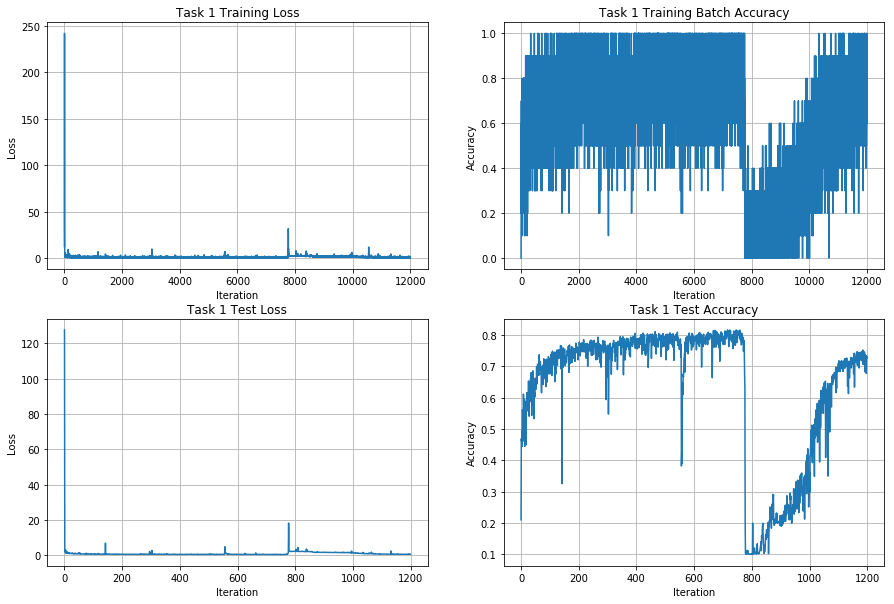

In [110]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))

ax1.plot(task1_train_loss)
ax1.grid()
ax1.title.set_text("Task 1 Training Loss")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")

ax2.plot(task1_train_acc)
ax2.grid()
ax2.title.set_text("Task 1 Training Batch Accuracy")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")

ax3.plot(task1_test_loss)
ax3.grid()
ax3.title.set_text("Task 1 Test Loss")
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Loss")

ax4.plot(task1_test_acc)
ax4.grid()
ax4.title.set_text("Task 1 Test Accuracy")
ax4.set_xlabel("Iteration")
ax4.set_ylabel("Accuracy")

plt.show()

#### Now train and test Task 2

In [111]:
tf.reset_default_graph()

model_2 = Task_2_NN(x_train_fashion, y_train_2, './Task2_logdir/', 0.001, 2, 10)            
model_2.create_model()     

model_2.compute_loss()
model_2.optimizer()   

model_2.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()


sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model_2.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model_2.output_dir):
    os.makedirs(model_2.output_dir)

"""
Train
"""

task2_train_loss = []
task2_train_acc = []
task2_test_loss = []
task2_test_acc = []
for epoch in range(model_2.nb_epochs):
    randomize = np.arange(x_train_fashion.shape[0])
    np.random.shuffle(randomize)
    x_in = model_2.x_train[randomize,:]
    y_in_2 = model_2.y_train_2[randomize,:]
    for i in range(model_2.nb_iterations):
        input_x_train = x_in[i*model_2.batch_size: (i+1)*model_2.batch_size]
        input_y_train_2 = y_in_2[i*model_2.batch_size: (i+1)*model_2.batch_size]
        _ , preds_2, loss_2, loss_sum = sess.run([model_2.trainer, model_2.pred_2,  model_2.loss_task_2, model_2.loss_summ], 
                                 feed_dict={model_2.X: input_x_train, 
                                            model_2.y_2: input_y_train_2})
        
        task2_train_loss.append(loss_2)
        if i % 10 == 0:
            test_loss, test_preds = sess.run([model_2.loss_task_2, model_2.pred_2] , feed_dict={model_2.X: x_test_fashion, model_2.y_2: y_test_2})
            test_acc = np.mean((np.argmax(test_preds, axis=1) == np.argmax(y_test_2, axis=1)) * 1)
            task2_test_loss.append(test_loss)
            task2_test_acc.append(test_acc)

       
        y_preds_2 = np.argmax(preds_2, axis=1)
        y_real_2 = np.argmax(input_y_train_2, axis=1)
        acc_train_2 = np.mean((y_preds_2==y_real_2)*1)
        task2_train_acc.append(acc_train_2)

        print('Epoch %d, Iteration %d, loss_2 %.3f, batch accuracy_2 %.3f' %(epoch, i, loss_2,acc_train_2))
        writer.add_summary(loss_sum, epoch * model_2.nb_iterations + i)
    saver.save(sess, model_2.output_dir, global_step=epoch) 

Epoch 0, Iteration 0, loss_2 2.051, batch accuracy_2 0.300
Epoch 0, Iteration 1, loss_2 342.951, batch accuracy_2 0.200
Epoch 0, Iteration 2, loss_2 69.272, batch accuracy_2 0.600
Epoch 0, Iteration 3, loss_2 55.661, batch accuracy_2 0.300
Epoch 0, Iteration 4, loss_2 25.096, batch accuracy_2 0.800
Epoch 0, Iteration 5, loss_2 22.705, batch accuracy_2 0.800
Epoch 0, Iteration 6, loss_2 17.406, batch accuracy_2 0.600
Epoch 0, Iteration 7, loss_2 2.743, batch accuracy_2 0.800
Epoch 0, Iteration 8, loss_2 2.160, batch accuracy_2 0.800
Epoch 0, Iteration 9, loss_2 11.755, batch accuracy_2 0.500
Epoch 0, Iteration 10, loss_2 7.452, batch accuracy_2 0.500
Epoch 0, Iteration 11, loss_2 2.988, batch accuracy_2 0.700
Epoch 0, Iteration 12, loss_2 2.539, batch accuracy_2 0.500
Epoch 0, Iteration 13, loss_2 1.399, batch accuracy_2 0.700
Epoch 0, Iteration 14, loss_2 0.322, batch accuracy_2 0.900
Epoch 0, Iteration 15, loss_2 0.867, batch accuracy_2 0.600
Epoch 0, Iteration 16, loss_2 2.252, batch

Epoch 0, Iteration 140, loss_2 0.636, batch accuracy_2 0.600
Epoch 0, Iteration 141, loss_2 0.327, batch accuracy_2 0.800
Epoch 0, Iteration 142, loss_2 0.186, batch accuracy_2 1.000
Epoch 0, Iteration 143, loss_2 0.345, batch accuracy_2 0.800
Epoch 0, Iteration 144, loss_2 0.426, batch accuracy_2 0.800
Epoch 0, Iteration 145, loss_2 0.468, batch accuracy_2 0.800
Epoch 0, Iteration 146, loss_2 0.621, batch accuracy_2 0.500
Epoch 0, Iteration 147, loss_2 0.345, batch accuracy_2 0.900
Epoch 0, Iteration 148, loss_2 0.268, batch accuracy_2 0.700
Epoch 0, Iteration 149, loss_2 0.616, batch accuracy_2 0.900
Epoch 0, Iteration 150, loss_2 0.781, batch accuracy_2 0.600
Epoch 0, Iteration 151, loss_2 0.358, batch accuracy_2 0.900
Epoch 0, Iteration 152, loss_2 0.264, batch accuracy_2 1.000
Epoch 0, Iteration 153, loss_2 0.669, batch accuracy_2 0.800
Epoch 0, Iteration 154, loss_2 0.727, batch accuracy_2 0.500
Epoch 0, Iteration 155, loss_2 0.316, batch accuracy_2 0.800
Epoch 0, Iteration 156, 

Epoch 0, Iteration 276, loss_2 0.273, batch accuracy_2 0.700
Epoch 0, Iteration 277, loss_2 0.356, batch accuracy_2 0.900
Epoch 0, Iteration 278, loss_2 0.526, batch accuracy_2 0.700
Epoch 0, Iteration 279, loss_2 0.510, batch accuracy_2 0.600
Epoch 0, Iteration 280, loss_2 0.396, batch accuracy_2 0.900
Epoch 0, Iteration 281, loss_2 0.445, batch accuracy_2 0.800
Epoch 0, Iteration 282, loss_2 0.454, batch accuracy_2 0.800
Epoch 0, Iteration 283, loss_2 0.286, batch accuracy_2 1.000
Epoch 0, Iteration 284, loss_2 0.354, batch accuracy_2 0.800
Epoch 0, Iteration 285, loss_2 0.346, batch accuracy_2 0.800
Epoch 0, Iteration 286, loss_2 0.883, batch accuracy_2 0.600
Epoch 0, Iteration 287, loss_2 0.363, batch accuracy_2 0.800
Epoch 0, Iteration 288, loss_2 0.653, batch accuracy_2 0.700
Epoch 0, Iteration 289, loss_2 0.204, batch accuracy_2 0.900
Epoch 0, Iteration 290, loss_2 0.553, batch accuracy_2 0.600
Epoch 0, Iteration 291, loss_2 0.325, batch accuracy_2 0.800
Epoch 0, Iteration 292, 

Epoch 0, Iteration 416, loss_2 0.461, batch accuracy_2 0.800
Epoch 0, Iteration 417, loss_2 0.255, batch accuracy_2 0.900
Epoch 0, Iteration 418, loss_2 0.478, batch accuracy_2 0.900
Epoch 0, Iteration 419, loss_2 0.178, batch accuracy_2 1.000
Epoch 0, Iteration 420, loss_2 0.798, batch accuracy_2 0.500
Epoch 0, Iteration 421, loss_2 0.617, batch accuracy_2 0.900
Epoch 0, Iteration 422, loss_2 0.497, batch accuracy_2 0.700
Epoch 0, Iteration 423, loss_2 0.319, batch accuracy_2 0.800
Epoch 0, Iteration 424, loss_2 0.674, batch accuracy_2 0.600
Epoch 0, Iteration 425, loss_2 0.102, batch accuracy_2 1.000
Epoch 0, Iteration 426, loss_2 0.304, batch accuracy_2 0.900
Epoch 0, Iteration 427, loss_2 0.201, batch accuracy_2 0.900
Epoch 0, Iteration 428, loss_2 0.464, batch accuracy_2 0.700
Epoch 0, Iteration 429, loss_2 0.403, batch accuracy_2 0.800
Epoch 0, Iteration 430, loss_2 0.523, batch accuracy_2 0.800
Epoch 0, Iteration 431, loss_2 0.322, batch accuracy_2 0.800
Epoch 0, Iteration 432, 

Epoch 0, Iteration 556, loss_2 0.082, batch accuracy_2 1.000
Epoch 0, Iteration 557, loss_2 0.410, batch accuracy_2 0.800
Epoch 0, Iteration 558, loss_2 0.496, batch accuracy_2 0.600
Epoch 0, Iteration 559, loss_2 0.480, batch accuracy_2 0.700
Epoch 0, Iteration 560, loss_2 2.515, batch accuracy_2 0.500
Epoch 0, Iteration 561, loss_2 1.549, batch accuracy_2 0.300
Epoch 0, Iteration 562, loss_2 0.181, batch accuracy_2 1.000
Epoch 0, Iteration 563, loss_2 0.236, batch accuracy_2 0.800
Epoch 0, Iteration 564, loss_2 0.282, batch accuracy_2 0.800
Epoch 0, Iteration 565, loss_2 0.589, batch accuracy_2 0.800
Epoch 0, Iteration 566, loss_2 0.497, batch accuracy_2 0.700
Epoch 0, Iteration 567, loss_2 0.391, batch accuracy_2 0.800
Epoch 0, Iteration 568, loss_2 0.193, batch accuracy_2 1.000
Epoch 0, Iteration 569, loss_2 1.178, batch accuracy_2 0.600
Epoch 0, Iteration 570, loss_2 1.399, batch accuracy_2 0.500
Epoch 0, Iteration 571, loss_2 3.546, batch accuracy_2 0.400
Epoch 0, Iteration 572, 

Epoch 0, Iteration 700, loss_2 0.266, batch accuracy_2 1.000
Epoch 0, Iteration 701, loss_2 0.369, batch accuracy_2 0.800
Epoch 0, Iteration 702, loss_2 0.353, batch accuracy_2 0.800
Epoch 0, Iteration 703, loss_2 0.287, batch accuracy_2 0.900
Epoch 0, Iteration 704, loss_2 0.464, batch accuracy_2 0.800
Epoch 0, Iteration 705, loss_2 0.290, batch accuracy_2 0.800
Epoch 0, Iteration 706, loss_2 0.584, batch accuracy_2 0.600
Epoch 0, Iteration 707, loss_2 0.597, batch accuracy_2 0.500
Epoch 0, Iteration 708, loss_2 0.503, batch accuracy_2 0.700
Epoch 0, Iteration 709, loss_2 0.320, batch accuracy_2 0.800
Epoch 0, Iteration 710, loss_2 0.261, batch accuracy_2 0.900
Epoch 0, Iteration 711, loss_2 0.125, batch accuracy_2 1.000
Epoch 0, Iteration 712, loss_2 0.240, batch accuracy_2 0.900
Epoch 0, Iteration 713, loss_2 0.289, batch accuracy_2 0.900
Epoch 0, Iteration 714, loss_2 0.120, batch accuracy_2 1.000
Epoch 0, Iteration 715, loss_2 0.535, batch accuracy_2 0.600
Epoch 0, Iteration 716, 

Epoch 0, Iteration 847, loss_2 0.753, batch accuracy_2 0.800
Epoch 0, Iteration 848, loss_2 0.336, batch accuracy_2 0.900
Epoch 0, Iteration 849, loss_2 13.244, batch accuracy_2 0.400
Epoch 0, Iteration 850, loss_2 2.452, batch accuracy_2 0.600
Epoch 0, Iteration 851, loss_2 9.104, batch accuracy_2 0.300
Epoch 0, Iteration 852, loss_2 17.395, batch accuracy_2 0.300
Epoch 0, Iteration 853, loss_2 3.940, batch accuracy_2 0.800
Epoch 0, Iteration 854, loss_2 17.039, batch accuracy_2 0.000
Epoch 0, Iteration 855, loss_2 0.083, batch accuracy_2 0.900
Epoch 0, Iteration 856, loss_2 1.518, batch accuracy_2 0.700
Epoch 0, Iteration 857, loss_2 50.033, batch accuracy_2 0.300
Epoch 0, Iteration 858, loss_2 14.969, batch accuracy_2 0.600
Epoch 0, Iteration 859, loss_2 2.076, batch accuracy_2 0.700
Epoch 0, Iteration 860, loss_2 1.032, batch accuracy_2 0.700
Epoch 0, Iteration 861, loss_2 1.773, batch accuracy_2 0.600
Epoch 0, Iteration 862, loss_2 0.577, batch accuracy_2 0.500
Epoch 0, Iteration 

Epoch 0, Iteration 990, loss_2 0.363, batch accuracy_2 0.800
Epoch 0, Iteration 991, loss_2 0.519, batch accuracy_2 0.700
Epoch 0, Iteration 992, loss_2 0.970, batch accuracy_2 0.500
Epoch 0, Iteration 993, loss_2 0.690, batch accuracy_2 0.800
Epoch 0, Iteration 994, loss_2 0.681, batch accuracy_2 0.700
Epoch 0, Iteration 995, loss_2 0.507, batch accuracy_2 0.800
Epoch 0, Iteration 996, loss_2 0.399, batch accuracy_2 0.800
Epoch 0, Iteration 997, loss_2 0.689, batch accuracy_2 0.500
Epoch 0, Iteration 998, loss_2 0.383, batch accuracy_2 0.900
Epoch 0, Iteration 999, loss_2 1.550, batch accuracy_2 0.400
Epoch 0, Iteration 1000, loss_2 0.379, batch accuracy_2 1.000
Epoch 0, Iteration 1001, loss_2 0.614, batch accuracy_2 0.500
Epoch 0, Iteration 1002, loss_2 0.514, batch accuracy_2 0.800
Epoch 0, Iteration 1003, loss_2 0.431, batch accuracy_2 0.800
Epoch 0, Iteration 1004, loss_2 0.378, batch accuracy_2 1.000
Epoch 0, Iteration 1005, loss_2 0.724, batch accuracy_2 0.500
Epoch 0, Iteration

Epoch 0, Iteration 1126, loss_2 0.463, batch accuracy_2 0.800
Epoch 0, Iteration 1127, loss_2 0.542, batch accuracy_2 0.800
Epoch 0, Iteration 1128, loss_2 0.570, batch accuracy_2 0.600
Epoch 0, Iteration 1129, loss_2 0.411, batch accuracy_2 0.700
Epoch 0, Iteration 1130, loss_2 0.634, batch accuracy_2 0.600
Epoch 0, Iteration 1131, loss_2 0.514, batch accuracy_2 0.600
Epoch 0, Iteration 1132, loss_2 0.289, batch accuracy_2 0.800
Epoch 0, Iteration 1133, loss_2 0.698, batch accuracy_2 0.600
Epoch 0, Iteration 1134, loss_2 0.357, batch accuracy_2 0.800
Epoch 0, Iteration 1135, loss_2 0.345, batch accuracy_2 0.800
Epoch 0, Iteration 1136, loss_2 0.474, batch accuracy_2 0.400
Epoch 0, Iteration 1137, loss_2 0.879, batch accuracy_2 0.600
Epoch 0, Iteration 1138, loss_2 0.415, batch accuracy_2 0.800
Epoch 0, Iteration 1139, loss_2 0.199, batch accuracy_2 0.900
Epoch 0, Iteration 1140, loss_2 0.736, batch accuracy_2 0.500
Epoch 0, Iteration 1141, loss_2 0.574, batch accuracy_2 0.600
Epoch 0,

Epoch 0, Iteration 1265, loss_2 1.092, batch accuracy_2 0.500
Epoch 0, Iteration 1266, loss_2 0.304, batch accuracy_2 0.900
Epoch 0, Iteration 1267, loss_2 1.076, batch accuracy_2 0.500
Epoch 0, Iteration 1268, loss_2 0.561, batch accuracy_2 0.600
Epoch 0, Iteration 1269, loss_2 1.053, batch accuracy_2 0.600
Epoch 0, Iteration 1270, loss_2 0.423, batch accuracy_2 0.600
Epoch 0, Iteration 1271, loss_2 0.557, batch accuracy_2 0.700
Epoch 0, Iteration 1272, loss_2 0.484, batch accuracy_2 0.400
Epoch 0, Iteration 1273, loss_2 0.498, batch accuracy_2 0.500
Epoch 0, Iteration 1274, loss_2 0.491, batch accuracy_2 0.800
Epoch 0, Iteration 1275, loss_2 0.528, batch accuracy_2 0.400
Epoch 0, Iteration 1276, loss_2 0.346, batch accuracy_2 1.000
Epoch 0, Iteration 1277, loss_2 0.518, batch accuracy_2 0.600
Epoch 0, Iteration 1278, loss_2 0.868, batch accuracy_2 0.600
Epoch 0, Iteration 1279, loss_2 0.568, batch accuracy_2 0.500
Epoch 0, Iteration 1280, loss_2 0.550, batch accuracy_2 0.400
Epoch 0,

Epoch 0, Iteration 1407, loss_2 0.619, batch accuracy_2 0.600
Epoch 0, Iteration 1408, loss_2 0.891, batch accuracy_2 0.300
Epoch 0, Iteration 1409, loss_2 0.348, batch accuracy_2 0.800
Epoch 0, Iteration 1410, loss_2 0.318, batch accuracy_2 1.000
Epoch 0, Iteration 1411, loss_2 0.519, batch accuracy_2 0.600
Epoch 0, Iteration 1412, loss_2 0.635, batch accuracy_2 0.600
Epoch 0, Iteration 1413, loss_2 0.289, batch accuracy_2 1.000
Epoch 0, Iteration 1414, loss_2 0.832, batch accuracy_2 0.200
Epoch 0, Iteration 1415, loss_2 0.549, batch accuracy_2 0.600
Epoch 0, Iteration 1416, loss_2 0.562, batch accuracy_2 0.800
Epoch 0, Iteration 1417, loss_2 0.446, batch accuracy_2 0.500
Epoch 0, Iteration 1418, loss_2 0.426, batch accuracy_2 0.700
Epoch 0, Iteration 1419, loss_2 0.649, batch accuracy_2 0.400
Epoch 0, Iteration 1420, loss_2 0.538, batch accuracy_2 0.600
Epoch 0, Iteration 1421, loss_2 0.519, batch accuracy_2 0.700
Epoch 0, Iteration 1422, loss_2 0.470, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 1540, loss_2 0.529, batch accuracy_2 0.700
Epoch 0, Iteration 1541, loss_2 0.364, batch accuracy_2 0.800
Epoch 0, Iteration 1542, loss_2 0.268, batch accuracy_2 0.900
Epoch 0, Iteration 1543, loss_2 0.353, batch accuracy_2 0.800
Epoch 0, Iteration 1544, loss_2 0.275, batch accuracy_2 0.800
Epoch 0, Iteration 1545, loss_2 0.142, batch accuracy_2 1.000
Epoch 0, Iteration 1546, loss_2 0.926, batch accuracy_2 0.600
Epoch 0, Iteration 1547, loss_2 0.302, batch accuracy_2 0.800
Epoch 0, Iteration 1548, loss_2 0.781, batch accuracy_2 0.600
Epoch 0, Iteration 1549, loss_2 0.658, batch accuracy_2 0.700
Epoch 0, Iteration 1550, loss_2 0.571, batch accuracy_2 0.800
Epoch 0, Iteration 1551, loss_2 0.432, batch accuracy_2 0.800
Epoch 0, Iteration 1552, loss_2 0.344, batch accuracy_2 0.900
Epoch 0, Iteration 1553, loss_2 1.372, batch accuracy_2 0.500
Epoch 0, Iteration 1554, loss_2 0.832, batch accuracy_2 0.600
Epoch 0, Iteration 1555, loss_2 0.660, batch accuracy_2 0.700
Epoch 0,

Epoch 0, Iteration 1674, loss_2 0.633, batch accuracy_2 0.800
Epoch 0, Iteration 1675, loss_2 0.550, batch accuracy_2 0.800
Epoch 0, Iteration 1676, loss_2 1.036, batch accuracy_2 0.400
Epoch 0, Iteration 1677, loss_2 0.333, batch accuracy_2 0.900
Epoch 0, Iteration 1678, loss_2 0.370, batch accuracy_2 0.700
Epoch 0, Iteration 1679, loss_2 0.399, batch accuracy_2 0.700
Epoch 0, Iteration 1680, loss_2 0.234, batch accuracy_2 0.900
Epoch 0, Iteration 1681, loss_2 0.420, batch accuracy_2 0.900
Epoch 0, Iteration 1682, loss_2 0.470, batch accuracy_2 0.800
Epoch 0, Iteration 1683, loss_2 0.378, batch accuracy_2 0.800
Epoch 0, Iteration 1684, loss_2 0.201, batch accuracy_2 0.900
Epoch 0, Iteration 1685, loss_2 0.608, batch accuracy_2 0.700
Epoch 0, Iteration 1686, loss_2 0.442, batch accuracy_2 0.700
Epoch 0, Iteration 1687, loss_2 0.495, batch accuracy_2 0.700
Epoch 0, Iteration 1688, loss_2 0.524, batch accuracy_2 0.600
Epoch 0, Iteration 1689, loss_2 0.440, batch accuracy_2 1.000
Epoch 0,

Epoch 0, Iteration 1817, loss_2 0.322, batch accuracy_2 1.000
Epoch 0, Iteration 1818, loss_2 0.710, batch accuracy_2 0.600
Epoch 0, Iteration 1819, loss_2 0.212, batch accuracy_2 1.000
Epoch 0, Iteration 1820, loss_2 0.617, batch accuracy_2 0.600
Epoch 0, Iteration 1821, loss_2 0.427, batch accuracy_2 0.800
Epoch 0, Iteration 1822, loss_2 0.393, batch accuracy_2 0.800
Epoch 0, Iteration 1823, loss_2 0.470, batch accuracy_2 0.900
Epoch 0, Iteration 1824, loss_2 0.336, batch accuracy_2 0.800
Epoch 0, Iteration 1825, loss_2 0.563, batch accuracy_2 0.700
Epoch 0, Iteration 1826, loss_2 0.483, batch accuracy_2 0.700
Epoch 0, Iteration 1827, loss_2 0.332, batch accuracy_2 0.800
Epoch 0, Iteration 1828, loss_2 0.513, batch accuracy_2 0.500
Epoch 0, Iteration 1829, loss_2 0.363, batch accuracy_2 0.700
Epoch 0, Iteration 1830, loss_2 0.363, batch accuracy_2 0.800
Epoch 0, Iteration 1831, loss_2 1.573, batch accuracy_2 0.800
Epoch 0, Iteration 1832, loss_2 0.373, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 1960, loss_2 0.533, batch accuracy_2 0.800
Epoch 0, Iteration 1961, loss_2 0.557, batch accuracy_2 0.700
Epoch 0, Iteration 1962, loss_2 0.451, batch accuracy_2 0.800
Epoch 0, Iteration 1963, loss_2 0.448, batch accuracy_2 0.700
Epoch 0, Iteration 1964, loss_2 0.403, batch accuracy_2 0.700
Epoch 0, Iteration 1965, loss_2 0.484, batch accuracy_2 0.800
Epoch 0, Iteration 1966, loss_2 0.108, batch accuracy_2 1.000
Epoch 0, Iteration 1967, loss_2 0.369, batch accuracy_2 0.900
Epoch 0, Iteration 1968, loss_2 0.534, batch accuracy_2 0.700
Epoch 0, Iteration 1969, loss_2 0.188, batch accuracy_2 0.900
Epoch 0, Iteration 1970, loss_2 0.325, batch accuracy_2 1.000
Epoch 0, Iteration 1971, loss_2 0.282, batch accuracy_2 1.000
Epoch 0, Iteration 1972, loss_2 0.960, batch accuracy_2 0.800
Epoch 0, Iteration 1973, loss_2 0.473, batch accuracy_2 0.800
Epoch 0, Iteration 1974, loss_2 0.716, batch accuracy_2 0.600
Epoch 0, Iteration 1975, loss_2 0.664, batch accuracy_2 0.600
Epoch 0,

Epoch 0, Iteration 2096, loss_2 0.282, batch accuracy_2 0.900
Epoch 0, Iteration 2097, loss_2 0.224, batch accuracy_2 0.900
Epoch 0, Iteration 2098, loss_2 0.341, batch accuracy_2 0.900
Epoch 0, Iteration 2099, loss_2 0.097, batch accuracy_2 1.000
Epoch 0, Iteration 2100, loss_2 0.407, batch accuracy_2 0.800
Epoch 0, Iteration 2101, loss_2 0.230, batch accuracy_2 0.900
Epoch 0, Iteration 2102, loss_2 0.464, batch accuracy_2 0.800
Epoch 0, Iteration 2103, loss_2 0.344, batch accuracy_2 0.900
Epoch 0, Iteration 2104, loss_2 0.257, batch accuracy_2 0.900
Epoch 0, Iteration 2105, loss_2 0.322, batch accuracy_2 0.800
Epoch 0, Iteration 2106, loss_2 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 2107, loss_2 0.410, batch accuracy_2 0.600
Epoch 0, Iteration 2108, loss_2 0.405, batch accuracy_2 0.800
Epoch 0, Iteration 2109, loss_2 0.518, batch accuracy_2 0.800
Epoch 0, Iteration 2110, loss_2 0.547, batch accuracy_2 0.700
Epoch 0, Iteration 2111, loss_2 0.513, batch accuracy_2 0.600
Epoch 0,

Epoch 0, Iteration 2230, loss_2 0.434, batch accuracy_2 0.800
Epoch 0, Iteration 2231, loss_2 0.888, batch accuracy_2 0.900
Epoch 0, Iteration 2232, loss_2 0.239, batch accuracy_2 0.900
Epoch 0, Iteration 2233, loss_2 0.799, batch accuracy_2 0.700
Epoch 0, Iteration 2234, loss_2 0.919, batch accuracy_2 0.800
Epoch 0, Iteration 2235, loss_2 0.337, batch accuracy_2 0.800
Epoch 0, Iteration 2236, loss_2 0.224, batch accuracy_2 0.900
Epoch 0, Iteration 2237, loss_2 0.117, batch accuracy_2 1.000
Epoch 0, Iteration 2238, loss_2 0.642, batch accuracy_2 0.500
Epoch 0, Iteration 2239, loss_2 0.449, batch accuracy_2 0.800
Epoch 0, Iteration 2240, loss_2 0.248, batch accuracy_2 0.800
Epoch 0, Iteration 2241, loss_2 0.314, batch accuracy_2 0.700
Epoch 0, Iteration 2242, loss_2 0.285, batch accuracy_2 0.900
Epoch 0, Iteration 2243, loss_2 0.373, batch accuracy_2 0.800
Epoch 0, Iteration 2244, loss_2 0.374, batch accuracy_2 0.700
Epoch 0, Iteration 2245, loss_2 0.393, batch accuracy_2 0.600
Epoch 0,

Epoch 0, Iteration 2376, loss_2 0.172, batch accuracy_2 1.000
Epoch 0, Iteration 2377, loss_2 0.738, batch accuracy_2 0.700
Epoch 0, Iteration 2378, loss_2 1.267, batch accuracy_2 0.600
Epoch 0, Iteration 2379, loss_2 0.674, batch accuracy_2 0.600
Epoch 0, Iteration 2380, loss_2 0.378, batch accuracy_2 0.800
Epoch 0, Iteration 2381, loss_2 0.387, batch accuracy_2 0.800
Epoch 0, Iteration 2382, loss_2 0.728, batch accuracy_2 0.500
Epoch 0, Iteration 2383, loss_2 0.399, batch accuracy_2 0.800
Epoch 0, Iteration 2384, loss_2 0.403, batch accuracy_2 0.800
Epoch 0, Iteration 2385, loss_2 0.405, batch accuracy_2 0.800
Epoch 0, Iteration 2386, loss_2 0.257, batch accuracy_2 1.000
Epoch 0, Iteration 2387, loss_2 0.311, batch accuracy_2 0.800
Epoch 0, Iteration 2388, loss_2 0.418, batch accuracy_2 0.800
Epoch 0, Iteration 2389, loss_2 0.181, batch accuracy_2 0.900
Epoch 0, Iteration 2390, loss_2 0.347, batch accuracy_2 0.900
Epoch 0, Iteration 2391, loss_2 0.546, batch accuracy_2 0.600
Epoch 0,

Epoch 0, Iteration 2510, loss_2 0.312, batch accuracy_2 0.800
Epoch 0, Iteration 2511, loss_2 0.402, batch accuracy_2 0.900
Epoch 0, Iteration 2512, loss_2 0.321, batch accuracy_2 0.800
Epoch 0, Iteration 2513, loss_2 0.204, batch accuracy_2 0.900
Epoch 0, Iteration 2514, loss_2 0.380, batch accuracy_2 0.800
Epoch 0, Iteration 2515, loss_2 0.113, batch accuracy_2 1.000
Epoch 0, Iteration 2516, loss_2 0.274, batch accuracy_2 0.900
Epoch 0, Iteration 2517, loss_2 0.458, batch accuracy_2 0.700
Epoch 0, Iteration 2518, loss_2 0.361, batch accuracy_2 0.800
Epoch 0, Iteration 2519, loss_2 0.623, batch accuracy_2 0.900
Epoch 0, Iteration 2520, loss_2 0.407, batch accuracy_2 0.700
Epoch 0, Iteration 2521, loss_2 0.449, batch accuracy_2 0.700
Epoch 0, Iteration 2522, loss_2 0.541, batch accuracy_2 0.600
Epoch 0, Iteration 2523, loss_2 0.346, batch accuracy_2 0.800
Epoch 0, Iteration 2524, loss_2 0.403, batch accuracy_2 0.900
Epoch 0, Iteration 2525, loss_2 0.660, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 2655, loss_2 0.442, batch accuracy_2 0.900
Epoch 0, Iteration 2656, loss_2 0.258, batch accuracy_2 0.800
Epoch 0, Iteration 2657, loss_2 0.338, batch accuracy_2 1.000
Epoch 0, Iteration 2658, loss_2 0.271, batch accuracy_2 0.900
Epoch 0, Iteration 2659, loss_2 0.437, batch accuracy_2 0.800
Epoch 0, Iteration 2660, loss_2 0.430, batch accuracy_2 0.700
Epoch 0, Iteration 2661, loss_2 0.258, batch accuracy_2 0.900
Epoch 0, Iteration 2662, loss_2 0.445, batch accuracy_2 0.700
Epoch 0, Iteration 2663, loss_2 0.256, batch accuracy_2 0.900
Epoch 0, Iteration 2664, loss_2 0.252, batch accuracy_2 0.900
Epoch 0, Iteration 2665, loss_2 0.279, batch accuracy_2 0.900
Epoch 0, Iteration 2666, loss_2 0.248, batch accuracy_2 0.900
Epoch 0, Iteration 2667, loss_2 0.353, batch accuracy_2 0.800
Epoch 0, Iteration 2668, loss_2 0.274, batch accuracy_2 0.900
Epoch 0, Iteration 2669, loss_2 0.193, batch accuracy_2 0.900
Epoch 0, Iteration 2670, loss_2 0.414, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 2788, loss_2 0.303, batch accuracy_2 0.800
Epoch 0, Iteration 2789, loss_2 0.180, batch accuracy_2 1.000
Epoch 0, Iteration 2790, loss_2 0.442, batch accuracy_2 0.800
Epoch 0, Iteration 2791, loss_2 0.127, batch accuracy_2 1.000
Epoch 0, Iteration 2792, loss_2 0.270, batch accuracy_2 0.900
Epoch 0, Iteration 2793, loss_2 0.157, batch accuracy_2 1.000
Epoch 0, Iteration 2794, loss_2 0.648, batch accuracy_2 0.800
Epoch 0, Iteration 2795, loss_2 0.581, batch accuracy_2 0.800
Epoch 0, Iteration 2796, loss_2 0.397, batch accuracy_2 0.800
Epoch 0, Iteration 2797, loss_2 0.572, batch accuracy_2 0.500
Epoch 0, Iteration 2798, loss_2 0.405, batch accuracy_2 0.900
Epoch 0, Iteration 2799, loss_2 0.199, batch accuracy_2 1.000
Epoch 0, Iteration 2800, loss_2 0.343, batch accuracy_2 0.800
Epoch 0, Iteration 2801, loss_2 0.422, batch accuracy_2 0.900
Epoch 0, Iteration 2802, loss_2 0.295, batch accuracy_2 0.900
Epoch 0, Iteration 2803, loss_2 0.270, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 2933, loss_2 0.328, batch accuracy_2 0.800
Epoch 0, Iteration 2934, loss_2 0.098, batch accuracy_2 1.000
Epoch 0, Iteration 2935, loss_2 0.126, batch accuracy_2 0.900
Epoch 0, Iteration 2936, loss_2 0.385, batch accuracy_2 0.700
Epoch 0, Iteration 2937, loss_2 0.475, batch accuracy_2 0.700
Epoch 0, Iteration 2938, loss_2 0.358, batch accuracy_2 0.800
Epoch 0, Iteration 2939, loss_2 0.345, batch accuracy_2 0.700
Epoch 0, Iteration 2940, loss_2 0.335, batch accuracy_2 0.900
Epoch 0, Iteration 2941, loss_2 0.298, batch accuracy_2 0.900
Epoch 0, Iteration 2942, loss_2 0.200, batch accuracy_2 0.900
Epoch 0, Iteration 2943, loss_2 0.167, batch accuracy_2 0.900
Epoch 0, Iteration 2944, loss_2 0.133, batch accuracy_2 1.000
Epoch 0, Iteration 2945, loss_2 0.402, batch accuracy_2 0.700
Epoch 0, Iteration 2946, loss_2 0.532, batch accuracy_2 0.700
Epoch 0, Iteration 2947, loss_2 0.192, batch accuracy_2 0.900
Epoch 0, Iteration 2948, loss_2 0.180, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 3067, loss_2 0.893, batch accuracy_2 0.700
Epoch 0, Iteration 3068, loss_2 0.141, batch accuracy_2 1.000
Epoch 0, Iteration 3069, loss_2 4.341, batch accuracy_2 0.600
Epoch 0, Iteration 3070, loss_2 0.287, batch accuracy_2 0.900
Epoch 0, Iteration 3071, loss_2 1.141, batch accuracy_2 0.500
Epoch 0, Iteration 3072, loss_2 1.172, batch accuracy_2 0.700
Epoch 0, Iteration 3073, loss_2 1.009, batch accuracy_2 0.700
Epoch 0, Iteration 3074, loss_2 0.372, batch accuracy_2 0.900
Epoch 0, Iteration 3075, loss_2 0.223, batch accuracy_2 0.800
Epoch 0, Iteration 3076, loss_2 0.391, batch accuracy_2 0.800
Epoch 0, Iteration 3077, loss_2 0.432, batch accuracy_2 0.800
Epoch 0, Iteration 3078, loss_2 2.712, batch accuracy_2 0.300
Epoch 0, Iteration 3079, loss_2 0.485, batch accuracy_2 0.800
Epoch 0, Iteration 3080, loss_2 0.561, batch accuracy_2 0.800
Epoch 0, Iteration 3081, loss_2 0.660, batch accuracy_2 0.700
Epoch 0, Iteration 3082, loss_2 0.396, batch accuracy_2 0.700
Epoch 0,

Epoch 0, Iteration 3200, loss_2 0.253, batch accuracy_2 0.900
Epoch 0, Iteration 3201, loss_2 0.318, batch accuracy_2 0.800
Epoch 0, Iteration 3202, loss_2 0.537, batch accuracy_2 0.800
Epoch 0, Iteration 3203, loss_2 0.636, batch accuracy_2 0.700
Epoch 0, Iteration 3204, loss_2 0.263, batch accuracy_2 0.800
Epoch 0, Iteration 3205, loss_2 0.732, batch accuracy_2 0.700
Epoch 0, Iteration 3206, loss_2 0.328, batch accuracy_2 0.900
Epoch 0, Iteration 3207, loss_2 0.423, batch accuracy_2 1.000
Epoch 0, Iteration 3208, loss_2 1.057, batch accuracy_2 0.600
Epoch 0, Iteration 3209, loss_2 0.467, batch accuracy_2 0.700
Epoch 0, Iteration 3210, loss_2 0.497, batch accuracy_2 0.700
Epoch 0, Iteration 3211, loss_2 0.496, batch accuracy_2 0.500
Epoch 0, Iteration 3212, loss_2 0.157, batch accuracy_2 1.000
Epoch 0, Iteration 3213, loss_2 0.504, batch accuracy_2 0.700
Epoch 0, Iteration 3214, loss_2 0.357, batch accuracy_2 0.800
Epoch 0, Iteration 3215, loss_2 0.111, batch accuracy_2 1.000
Epoch 0,

Epoch 0, Iteration 3337, loss_2 0.287, batch accuracy_2 0.900
Epoch 0, Iteration 3338, loss_2 1.256, batch accuracy_2 0.800
Epoch 0, Iteration 3339, loss_2 0.252, batch accuracy_2 0.900
Epoch 0, Iteration 3340, loss_2 0.510, batch accuracy_2 0.700
Epoch 0, Iteration 3341, loss_2 0.292, batch accuracy_2 0.900
Epoch 0, Iteration 3342, loss_2 0.318, batch accuracy_2 0.900
Epoch 0, Iteration 3343, loss_2 0.505, batch accuracy_2 0.700
Epoch 0, Iteration 3344, loss_2 0.359, batch accuracy_2 0.800
Epoch 0, Iteration 3345, loss_2 0.203, batch accuracy_2 0.900
Epoch 0, Iteration 3346, loss_2 0.370, batch accuracy_2 0.900
Epoch 0, Iteration 3347, loss_2 0.450, batch accuracy_2 0.800
Epoch 0, Iteration 3348, loss_2 0.368, batch accuracy_2 0.800
Epoch 0, Iteration 3349, loss_2 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 3350, loss_2 0.455, batch accuracy_2 0.900
Epoch 0, Iteration 3351, loss_2 0.451, batch accuracy_2 0.600
Epoch 0, Iteration 3352, loss_2 0.326, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 3480, loss_2 0.447, batch accuracy_2 0.700
Epoch 0, Iteration 3481, loss_2 0.173, batch accuracy_2 1.000
Epoch 0, Iteration 3482, loss_2 0.396, batch accuracy_2 0.700
Epoch 0, Iteration 3483, loss_2 0.088, batch accuracy_2 1.000
Epoch 0, Iteration 3484, loss_2 0.238, batch accuracy_2 0.900
Epoch 0, Iteration 3485, loss_2 0.151, batch accuracy_2 0.900
Epoch 0, Iteration 3486, loss_2 0.297, batch accuracy_2 0.900
Epoch 0, Iteration 3487, loss_2 0.340, batch accuracy_2 0.800
Epoch 0, Iteration 3488, loss_2 0.578, batch accuracy_2 0.700
Epoch 0, Iteration 3489, loss_2 0.290, batch accuracy_2 0.700
Epoch 0, Iteration 3490, loss_2 0.207, batch accuracy_2 0.900
Epoch 0, Iteration 3491, loss_2 1.706, batch accuracy_2 0.600
Epoch 0, Iteration 3492, loss_2 0.310, batch accuracy_2 0.700
Epoch 0, Iteration 3493, loss_2 0.504, batch accuracy_2 0.600
Epoch 0, Iteration 3494, loss_2 0.380, batch accuracy_2 0.800
Epoch 0, Iteration 3495, loss_2 0.342, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 3626, loss_2 0.260, batch accuracy_2 0.900
Epoch 0, Iteration 3627, loss_2 0.190, batch accuracy_2 1.000
Epoch 0, Iteration 3628, loss_2 0.096, batch accuracy_2 1.000
Epoch 0, Iteration 3629, loss_2 0.114, batch accuracy_2 1.000
Epoch 0, Iteration 3630, loss_2 0.491, batch accuracy_2 0.800
Epoch 0, Iteration 3631, loss_2 0.337, batch accuracy_2 0.900
Epoch 0, Iteration 3632, loss_2 0.200, batch accuracy_2 1.000
Epoch 0, Iteration 3633, loss_2 1.013, batch accuracy_2 0.800
Epoch 0, Iteration 3634, loss_2 0.621, batch accuracy_2 0.800
Epoch 0, Iteration 3635, loss_2 0.525, batch accuracy_2 0.900
Epoch 0, Iteration 3636, loss_2 0.254, batch accuracy_2 0.900
Epoch 0, Iteration 3637, loss_2 0.309, batch accuracy_2 0.900
Epoch 0, Iteration 3638, loss_2 0.284, batch accuracy_2 0.900
Epoch 0, Iteration 3639, loss_2 0.402, batch accuracy_2 0.700
Epoch 0, Iteration 3640, loss_2 0.166, batch accuracy_2 0.900
Epoch 0, Iteration 3641, loss_2 0.222, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 3760, loss_2 0.137, batch accuracy_2 1.000
Epoch 0, Iteration 3761, loss_2 0.473, batch accuracy_2 0.800
Epoch 0, Iteration 3762, loss_2 0.231, batch accuracy_2 0.800
Epoch 0, Iteration 3763, loss_2 0.247, batch accuracy_2 0.900
Epoch 0, Iteration 3764, loss_2 0.415, batch accuracy_2 0.700
Epoch 0, Iteration 3765, loss_2 0.271, batch accuracy_2 0.800
Epoch 0, Iteration 3766, loss_2 0.131, batch accuracy_2 1.000
Epoch 0, Iteration 3767, loss_2 0.221, batch accuracy_2 0.900
Epoch 0, Iteration 3768, loss_2 0.259, batch accuracy_2 0.900
Epoch 0, Iteration 3769, loss_2 0.094, batch accuracy_2 1.000
Epoch 0, Iteration 3770, loss_2 0.715, batch accuracy_2 0.600
Epoch 0, Iteration 3771, loss_2 0.147, batch accuracy_2 0.900
Epoch 0, Iteration 3772, loss_2 0.406, batch accuracy_2 0.900
Epoch 0, Iteration 3773, loss_2 0.385, batch accuracy_2 0.700
Epoch 0, Iteration 3774, loss_2 0.191, batch accuracy_2 1.000
Epoch 0, Iteration 3775, loss_2 0.437, batch accuracy_2 0.600
Epoch 0,

Epoch 0, Iteration 3907, loss_2 0.438, batch accuracy_2 0.800
Epoch 0, Iteration 3908, loss_2 0.488, batch accuracy_2 0.800
Epoch 0, Iteration 3909, loss_2 0.133, batch accuracy_2 1.000
Epoch 0, Iteration 3910, loss_2 0.426, batch accuracy_2 0.800
Epoch 0, Iteration 3911, loss_2 0.303, batch accuracy_2 0.900
Epoch 0, Iteration 3912, loss_2 0.240, batch accuracy_2 0.900
Epoch 0, Iteration 3913, loss_2 1.108, batch accuracy_2 0.600
Epoch 0, Iteration 3914, loss_2 0.130, batch accuracy_2 0.900
Epoch 0, Iteration 3915, loss_2 0.379, batch accuracy_2 0.800
Epoch 0, Iteration 3916, loss_2 0.404, batch accuracy_2 0.600
Epoch 0, Iteration 3917, loss_2 0.450, batch accuracy_2 0.700
Epoch 0, Iteration 3918, loss_2 0.306, batch accuracy_2 0.900
Epoch 0, Iteration 3919, loss_2 0.374, batch accuracy_2 0.700
Epoch 0, Iteration 3920, loss_2 0.254, batch accuracy_2 0.900
Epoch 0, Iteration 3921, loss_2 0.268, batch accuracy_2 0.900
Epoch 0, Iteration 3922, loss_2 0.096, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 4049, loss_2 0.267, batch accuracy_2 0.800
Epoch 0, Iteration 4050, loss_2 0.145, batch accuracy_2 1.000
Epoch 0, Iteration 4051, loss_2 0.317, batch accuracy_2 0.800
Epoch 0, Iteration 4052, loss_2 0.238, batch accuracy_2 0.900
Epoch 0, Iteration 4053, loss_2 0.262, batch accuracy_2 0.800
Epoch 0, Iteration 4054, loss_2 0.282, batch accuracy_2 0.900
Epoch 0, Iteration 4055, loss_2 0.228, batch accuracy_2 0.900
Epoch 0, Iteration 4056, loss_2 0.264, batch accuracy_2 0.900
Epoch 0, Iteration 4057, loss_2 0.602, batch accuracy_2 0.800
Epoch 0, Iteration 4058, loss_2 0.378, batch accuracy_2 0.700
Epoch 0, Iteration 4059, loss_2 0.784, batch accuracy_2 0.800
Epoch 0, Iteration 4060, loss_2 0.362, batch accuracy_2 0.900
Epoch 0, Iteration 4061, loss_2 0.358, batch accuracy_2 0.800
Epoch 0, Iteration 4062, loss_2 0.294, batch accuracy_2 0.900
Epoch 0, Iteration 4063, loss_2 0.359, batch accuracy_2 0.800
Epoch 0, Iteration 4064, loss_2 0.220, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 4187, loss_2 0.227, batch accuracy_2 0.900
Epoch 0, Iteration 4188, loss_2 0.166, batch accuracy_2 1.000
Epoch 0, Iteration 4189, loss_2 1.073, batch accuracy_2 0.900
Epoch 0, Iteration 4190, loss_2 0.476, batch accuracy_2 0.800
Epoch 0, Iteration 4191, loss_2 0.324, batch accuracy_2 0.800
Epoch 0, Iteration 4192, loss_2 0.318, batch accuracy_2 0.900
Epoch 0, Iteration 4193, loss_2 0.102, batch accuracy_2 0.900
Epoch 0, Iteration 4194, loss_2 0.180, batch accuracy_2 0.900
Epoch 0, Iteration 4195, loss_2 0.223, batch accuracy_2 0.900
Epoch 0, Iteration 4196, loss_2 0.144, batch accuracy_2 1.000
Epoch 0, Iteration 4197, loss_2 0.239, batch accuracy_2 0.900
Epoch 0, Iteration 4198, loss_2 0.218, batch accuracy_2 0.900
Epoch 0, Iteration 4199, loss_2 0.295, batch accuracy_2 0.800
Epoch 0, Iteration 4200, loss_2 0.278, batch accuracy_2 0.800
Epoch 0, Iteration 4201, loss_2 0.120, batch accuracy_2 0.900
Epoch 0, Iteration 4202, loss_2 0.218, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 4330, loss_2 0.185, batch accuracy_2 0.900
Epoch 0, Iteration 4331, loss_2 0.144, batch accuracy_2 1.000
Epoch 0, Iteration 4332, loss_2 0.260, batch accuracy_2 0.800
Epoch 0, Iteration 4333, loss_2 0.210, batch accuracy_2 0.900
Epoch 0, Iteration 4334, loss_2 0.163, batch accuracy_2 0.900
Epoch 0, Iteration 4335, loss_2 0.235, batch accuracy_2 0.800
Epoch 0, Iteration 4336, loss_2 0.616, batch accuracy_2 0.700
Epoch 0, Iteration 4337, loss_2 0.243, batch accuracy_2 1.000
Epoch 0, Iteration 4338, loss_2 0.154, batch accuracy_2 1.000
Epoch 0, Iteration 4339, loss_2 0.434, batch accuracy_2 0.800
Epoch 0, Iteration 4340, loss_2 0.269, batch accuracy_2 0.900
Epoch 0, Iteration 4341, loss_2 0.711, batch accuracy_2 0.600
Epoch 0, Iteration 4342, loss_2 0.308, batch accuracy_2 0.900
Epoch 0, Iteration 4343, loss_2 0.290, batch accuracy_2 1.000
Epoch 0, Iteration 4344, loss_2 0.396, batch accuracy_2 0.700
Epoch 0, Iteration 4345, loss_2 0.233, batch accuracy_2 0.800
Epoch 0,

Epoch 0, Iteration 4464, loss_2 0.372, batch accuracy_2 0.900
Epoch 0, Iteration 4465, loss_2 0.526, batch accuracy_2 0.700
Epoch 0, Iteration 4466, loss_2 0.567, batch accuracy_2 0.700
Epoch 0, Iteration 4467, loss_2 0.182, batch accuracy_2 0.900
Epoch 0, Iteration 4468, loss_2 0.368, batch accuracy_2 0.800
Epoch 0, Iteration 4469, loss_2 0.206, batch accuracy_2 0.800
Epoch 0, Iteration 4470, loss_2 0.481, batch accuracy_2 0.700
Epoch 0, Iteration 4471, loss_2 0.238, batch accuracy_2 0.900
Epoch 0, Iteration 4472, loss_2 0.446, batch accuracy_2 0.700
Epoch 0, Iteration 4473, loss_2 0.043, batch accuracy_2 1.000
Epoch 0, Iteration 4474, loss_2 0.596, batch accuracy_2 0.700
Epoch 0, Iteration 4475, loss_2 0.642, batch accuracy_2 0.700
Epoch 0, Iteration 4476, loss_2 0.161, batch accuracy_2 0.900
Epoch 0, Iteration 4477, loss_2 0.198, batch accuracy_2 0.900
Epoch 0, Iteration 4478, loss_2 0.342, batch accuracy_2 0.800
Epoch 0, Iteration 4479, loss_2 0.121, batch accuracy_2 1.000
Epoch 0,

Epoch 0, Iteration 4600, loss_2 0.233, batch accuracy_2 0.900
Epoch 0, Iteration 4601, loss_2 0.248, batch accuracy_2 0.900
Epoch 0, Iteration 4602, loss_2 0.679, batch accuracy_2 0.700
Epoch 0, Iteration 4603, loss_2 0.258, batch accuracy_2 0.900
Epoch 0, Iteration 4604, loss_2 0.135, batch accuracy_2 1.000
Epoch 0, Iteration 4605, loss_2 0.190, batch accuracy_2 1.000
Epoch 0, Iteration 4606, loss_2 0.395, batch accuracy_2 0.800
Epoch 0, Iteration 4607, loss_2 0.273, batch accuracy_2 0.800
Epoch 0, Iteration 4608, loss_2 0.122, batch accuracy_2 1.000
Epoch 0, Iteration 4609, loss_2 0.396, batch accuracy_2 0.800
Epoch 0, Iteration 4610, loss_2 0.166, batch accuracy_2 1.000
Epoch 0, Iteration 4611, loss_2 0.118, batch accuracy_2 0.900
Epoch 0, Iteration 4612, loss_2 0.208, batch accuracy_2 1.000
Epoch 0, Iteration 4613, loss_2 0.078, batch accuracy_2 0.900
Epoch 0, Iteration 4614, loss_2 0.193, batch accuracy_2 0.900
Epoch 0, Iteration 4615, loss_2 0.081, batch accuracy_2 1.000
Epoch 0,

Epoch 0, Iteration 4745, loss_2 0.194, batch accuracy_2 0.900
Epoch 0, Iteration 4746, loss_2 0.289, batch accuracy_2 0.800
Epoch 0, Iteration 4747, loss_2 0.277, batch accuracy_2 0.900
Epoch 0, Iteration 4748, loss_2 0.592, batch accuracy_2 0.900
Epoch 0, Iteration 4749, loss_2 0.264, batch accuracy_2 0.800
Epoch 0, Iteration 4750, loss_2 0.357, batch accuracy_2 0.700
Epoch 0, Iteration 4751, loss_2 0.913, batch accuracy_2 0.600
Epoch 0, Iteration 4752, loss_2 0.267, batch accuracy_2 0.900
Epoch 0, Iteration 4753, loss_2 0.533, batch accuracy_2 0.600
Epoch 0, Iteration 4754, loss_2 0.857, batch accuracy_2 0.600
Epoch 0, Iteration 4755, loss_2 0.126, batch accuracy_2 0.900
Epoch 0, Iteration 4756, loss_2 0.203, batch accuracy_2 1.000
Epoch 0, Iteration 4757, loss_2 0.160, batch accuracy_2 1.000
Epoch 0, Iteration 4758, loss_2 0.795, batch accuracy_2 0.700
Epoch 0, Iteration 4759, loss_2 0.219, batch accuracy_2 0.900
Epoch 0, Iteration 4760, loss_2 0.224, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 4890, loss_2 0.234, batch accuracy_2 0.900
Epoch 0, Iteration 4891, loss_2 0.042, batch accuracy_2 1.000
Epoch 0, Iteration 4892, loss_2 0.256, batch accuracy_2 0.800
Epoch 0, Iteration 4893, loss_2 0.085, batch accuracy_2 0.900
Epoch 0, Iteration 4894, loss_2 0.471, batch accuracy_2 0.800
Epoch 0, Iteration 4895, loss_2 0.269, batch accuracy_2 0.900
Epoch 0, Iteration 4896, loss_2 0.107, batch accuracy_2 0.900
Epoch 0, Iteration 4897, loss_2 0.372, batch accuracy_2 0.700
Epoch 0, Iteration 4898, loss_2 0.278, batch accuracy_2 0.900
Epoch 0, Iteration 4899, loss_2 0.721, batch accuracy_2 0.700
Epoch 0, Iteration 4900, loss_2 0.228, batch accuracy_2 0.800
Epoch 0, Iteration 4901, loss_2 0.091, batch accuracy_2 1.000
Epoch 0, Iteration 4902, loss_2 0.270, batch accuracy_2 0.900
Epoch 0, Iteration 4903, loss_2 0.373, batch accuracy_2 0.700
Epoch 0, Iteration 4904, loss_2 0.803, batch accuracy_2 0.900
Epoch 0, Iteration 4905, loss_2 0.270, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 5024, loss_2 0.106, batch accuracy_2 1.000
Epoch 0, Iteration 5025, loss_2 0.276, batch accuracy_2 0.900
Epoch 0, Iteration 5026, loss_2 0.291, batch accuracy_2 0.900
Epoch 0, Iteration 5027, loss_2 0.091, batch accuracy_2 1.000
Epoch 0, Iteration 5028, loss_2 0.139, batch accuracy_2 0.900
Epoch 0, Iteration 5029, loss_2 0.155, batch accuracy_2 1.000
Epoch 0, Iteration 5030, loss_2 0.082, batch accuracy_2 1.000
Epoch 0, Iteration 5031, loss_2 0.365, batch accuracy_2 0.800
Epoch 0, Iteration 5032, loss_2 0.098, batch accuracy_2 1.000
Epoch 0, Iteration 5033, loss_2 0.435, batch accuracy_2 0.800
Epoch 0, Iteration 5034, loss_2 0.234, batch accuracy_2 0.800
Epoch 0, Iteration 5035, loss_2 0.151, batch accuracy_2 0.900
Epoch 0, Iteration 5036, loss_2 0.327, batch accuracy_2 0.800
Epoch 0, Iteration 5037, loss_2 0.220, batch accuracy_2 0.900
Epoch 0, Iteration 5038, loss_2 0.367, batch accuracy_2 0.800
Epoch 0, Iteration 5039, loss_2 0.689, batch accuracy_2 0.600
Epoch 0,

Epoch 0, Iteration 5165, loss_2 0.203, batch accuracy_2 1.000
Epoch 0, Iteration 5166, loss_2 0.215, batch accuracy_2 0.900
Epoch 0, Iteration 5167, loss_2 0.244, batch accuracy_2 0.900
Epoch 0, Iteration 5168, loss_2 0.047, batch accuracy_2 1.000
Epoch 0, Iteration 5169, loss_2 0.135, batch accuracy_2 0.900
Epoch 0, Iteration 5170, loss_2 0.187, batch accuracy_2 0.900
Epoch 0, Iteration 5171, loss_2 0.272, batch accuracy_2 0.800
Epoch 0, Iteration 5172, loss_2 0.109, batch accuracy_2 1.000
Epoch 0, Iteration 5173, loss_2 0.058, batch accuracy_2 1.000
Epoch 0, Iteration 5174, loss_2 0.067, batch accuracy_2 1.000
Epoch 0, Iteration 5175, loss_2 0.270, batch accuracy_2 0.900
Epoch 0, Iteration 5176, loss_2 0.813, batch accuracy_2 0.700
Epoch 0, Iteration 5177, loss_2 0.108, batch accuracy_2 1.000
Epoch 0, Iteration 5178, loss_2 0.111, batch accuracy_2 1.000
Epoch 0, Iteration 5179, loss_2 0.146, batch accuracy_2 1.000
Epoch 0, Iteration 5180, loss_2 0.042, batch accuracy_2 1.000
Epoch 0,

Epoch 0, Iteration 5307, loss_2 0.203, batch accuracy_2 1.000
Epoch 0, Iteration 5308, loss_2 0.294, batch accuracy_2 0.800
Epoch 0, Iteration 5309, loss_2 0.275, batch accuracy_2 0.700
Epoch 0, Iteration 5310, loss_2 0.424, batch accuracy_2 0.700
Epoch 0, Iteration 5311, loss_2 0.268, batch accuracy_2 0.900
Epoch 0, Iteration 5312, loss_2 0.317, batch accuracy_2 0.900
Epoch 0, Iteration 5313, loss_2 0.243, batch accuracy_2 0.900
Epoch 0, Iteration 5314, loss_2 0.198, batch accuracy_2 0.900
Epoch 0, Iteration 5315, loss_2 0.152, batch accuracy_2 0.900
Epoch 0, Iteration 5316, loss_2 0.227, batch accuracy_2 0.900
Epoch 0, Iteration 5317, loss_2 0.614, batch accuracy_2 0.600
Epoch 0, Iteration 5318, loss_2 0.458, batch accuracy_2 0.900
Epoch 0, Iteration 5319, loss_2 0.275, batch accuracy_2 0.800
Epoch 0, Iteration 5320, loss_2 0.259, batch accuracy_2 0.800
Epoch 0, Iteration 5321, loss_2 0.406, batch accuracy_2 0.800
Epoch 0, Iteration 5322, loss_2 0.276, batch accuracy_2 1.000
Epoch 0,

Epoch 0, Iteration 5445, loss_2 0.602, batch accuracy_2 0.800
Epoch 0, Iteration 5446, loss_2 0.065, batch accuracy_2 1.000
Epoch 0, Iteration 5447, loss_2 0.166, batch accuracy_2 0.900
Epoch 0, Iteration 5448, loss_2 0.044, batch accuracy_2 1.000
Epoch 0, Iteration 5449, loss_2 0.416, batch accuracy_2 0.700
Epoch 0, Iteration 5450, loss_2 0.452, batch accuracy_2 0.700
Epoch 0, Iteration 5451, loss_2 0.014, batch accuracy_2 1.000
Epoch 0, Iteration 5452, loss_2 0.204, batch accuracy_2 0.900
Epoch 0, Iteration 5453, loss_2 0.098, batch accuracy_2 1.000
Epoch 0, Iteration 5454, loss_2 0.766, batch accuracy_2 0.800
Epoch 0, Iteration 5455, loss_2 0.610, batch accuracy_2 0.900
Epoch 0, Iteration 5456, loss_2 0.206, batch accuracy_2 0.800
Epoch 0, Iteration 5457, loss_2 0.320, batch accuracy_2 0.900
Epoch 0, Iteration 5458, loss_2 0.446, batch accuracy_2 0.800
Epoch 0, Iteration 5459, loss_2 0.105, batch accuracy_2 1.000
Epoch 0, Iteration 5460, loss_2 0.199, batch accuracy_2 0.900
Epoch 0,

Epoch 0, Iteration 5590, loss_2 0.160, batch accuracy_2 1.000
Epoch 0, Iteration 5591, loss_2 0.494, batch accuracy_2 0.800
Epoch 0, Iteration 5592, loss_2 0.349, batch accuracy_2 0.700
Epoch 0, Iteration 5593, loss_2 0.249, batch accuracy_2 0.800
Epoch 0, Iteration 5594, loss_2 0.293, batch accuracy_2 0.800
Epoch 0, Iteration 5595, loss_2 0.248, batch accuracy_2 0.900
Epoch 0, Iteration 5596, loss_2 0.386, batch accuracy_2 0.800
Epoch 0, Iteration 5597, loss_2 0.377, batch accuracy_2 0.800
Epoch 0, Iteration 5598, loss_2 0.422, batch accuracy_2 0.800
Epoch 0, Iteration 5599, loss_2 0.169, batch accuracy_2 0.900
Epoch 0, Iteration 5600, loss_2 0.184, batch accuracy_2 0.900
Epoch 0, Iteration 5601, loss_2 0.170, batch accuracy_2 1.000
Epoch 0, Iteration 5602, loss_2 0.263, batch accuracy_2 0.800
Epoch 0, Iteration 5603, loss_2 0.291, batch accuracy_2 0.800
Epoch 0, Iteration 5604, loss_2 0.202, batch accuracy_2 0.800
Epoch 0, Iteration 5605, loss_2 0.209, batch accuracy_2 1.000
Epoch 0,

Epoch 0, Iteration 5734, loss_2 0.116, batch accuracy_2 1.000
Epoch 0, Iteration 5735, loss_2 0.378, batch accuracy_2 0.900
Epoch 0, Iteration 5736, loss_2 0.287, batch accuracy_2 1.000
Epoch 0, Iteration 5737, loss_2 0.260, batch accuracy_2 0.900
Epoch 0, Iteration 5738, loss_2 0.392, batch accuracy_2 0.900
Epoch 0, Iteration 5739, loss_2 0.532, batch accuracy_2 0.900
Epoch 0, Iteration 5740, loss_2 0.229, batch accuracy_2 0.900
Epoch 0, Iteration 5741, loss_2 0.311, batch accuracy_2 0.900
Epoch 0, Iteration 5742, loss_2 0.224, batch accuracy_2 0.900
Epoch 0, Iteration 5743, loss_2 0.102, batch accuracy_2 1.000
Epoch 0, Iteration 5744, loss_2 0.135, batch accuracy_2 0.900
Epoch 0, Iteration 5745, loss_2 0.240, batch accuracy_2 0.900
Epoch 0, Iteration 5746, loss_2 0.276, batch accuracy_2 0.800
Epoch 0, Iteration 5747, loss_2 0.238, batch accuracy_2 0.900
Epoch 0, Iteration 5748, loss_2 0.286, batch accuracy_2 1.000
Epoch 0, Iteration 5749, loss_2 0.059, batch accuracy_2 1.000
Epoch 0,

Epoch 0, Iteration 5880, loss_2 0.140, batch accuracy_2 0.900
Epoch 0, Iteration 5881, loss_2 0.556, batch accuracy_2 0.700
Epoch 0, Iteration 5882, loss_2 0.140, batch accuracy_2 1.000
Epoch 0, Iteration 5883, loss_2 0.148, batch accuracy_2 1.000
Epoch 0, Iteration 5884, loss_2 0.324, batch accuracy_2 0.900
Epoch 0, Iteration 5885, loss_2 0.229, batch accuracy_2 0.900
Epoch 0, Iteration 5886, loss_2 0.104, batch accuracy_2 0.900
Epoch 0, Iteration 5887, loss_2 0.503, batch accuracy_2 0.700
Epoch 0, Iteration 5888, loss_2 0.007, batch accuracy_2 1.000
Epoch 0, Iteration 5889, loss_2 0.296, batch accuracy_2 0.800
Epoch 0, Iteration 5890, loss_2 0.486, batch accuracy_2 0.800
Epoch 0, Iteration 5891, loss_2 0.043, batch accuracy_2 1.000
Epoch 0, Iteration 5892, loss_2 0.073, batch accuracy_2 1.000
Epoch 0, Iteration 5893, loss_2 0.111, batch accuracy_2 0.900
Epoch 0, Iteration 5894, loss_2 0.112, batch accuracy_2 0.900
Epoch 0, Iteration 5895, loss_2 0.101, batch accuracy_2 1.000
Epoch 0,

Epoch 1, Iteration 16, loss_2 0.345, batch accuracy_2 0.800
Epoch 1, Iteration 17, loss_2 0.078, batch accuracy_2 1.000
Epoch 1, Iteration 18, loss_2 0.388, batch accuracy_2 0.900
Epoch 1, Iteration 19, loss_2 0.119, batch accuracy_2 0.900
Epoch 1, Iteration 20, loss_2 0.163, batch accuracy_2 0.900
Epoch 1, Iteration 21, loss_2 0.053, batch accuracy_2 1.000
Epoch 1, Iteration 22, loss_2 0.128, batch accuracy_2 0.900
Epoch 1, Iteration 23, loss_2 0.106, batch accuracy_2 1.000
Epoch 1, Iteration 24, loss_2 0.405, batch accuracy_2 0.800
Epoch 1, Iteration 25, loss_2 0.165, batch accuracy_2 0.900
Epoch 1, Iteration 26, loss_2 0.093, batch accuracy_2 1.000
Epoch 1, Iteration 27, loss_2 0.539, batch accuracy_2 0.800
Epoch 1, Iteration 28, loss_2 0.160, batch accuracy_2 1.000
Epoch 1, Iteration 29, loss_2 0.159, batch accuracy_2 0.900
Epoch 1, Iteration 30, loss_2 0.588, batch accuracy_2 0.600
Epoch 1, Iteration 31, loss_2 0.210, batch accuracy_2 0.900
Epoch 1, Iteration 32, loss_2 0.893, bat

Epoch 1, Iteration 157, loss_2 0.443, batch accuracy_2 0.700
Epoch 1, Iteration 158, loss_2 0.601, batch accuracy_2 0.500
Epoch 1, Iteration 159, loss_2 0.586, batch accuracy_2 0.400
Epoch 1, Iteration 160, loss_2 0.583, batch accuracy_2 0.600
Epoch 1, Iteration 161, loss_2 0.505, batch accuracy_2 0.700
Epoch 1, Iteration 162, loss_2 1.199, batch accuracy_2 0.600
Epoch 1, Iteration 163, loss_2 0.544, batch accuracy_2 0.600
Epoch 1, Iteration 164, loss_2 0.483, batch accuracy_2 0.800
Epoch 1, Iteration 165, loss_2 0.364, batch accuracy_2 0.800
Epoch 1, Iteration 166, loss_2 0.911, batch accuracy_2 0.500
Epoch 1, Iteration 167, loss_2 0.521, batch accuracy_2 1.000
Epoch 1, Iteration 168, loss_2 1.085, batch accuracy_2 0.700
Epoch 1, Iteration 169, loss_2 1.002, batch accuracy_2 0.400
Epoch 1, Iteration 170, loss_2 0.549, batch accuracy_2 0.800
Epoch 1, Iteration 171, loss_2 0.627, batch accuracy_2 0.600
Epoch 1, Iteration 172, loss_2 0.732, batch accuracy_2 0.500
Epoch 1, Iteration 173, 

Epoch 1, Iteration 300, loss_2 0.493, batch accuracy_2 0.700
Epoch 1, Iteration 301, loss_2 0.492, batch accuracy_2 0.700
Epoch 1, Iteration 302, loss_2 0.541, batch accuracy_2 0.500
Epoch 1, Iteration 303, loss_2 0.648, batch accuracy_2 0.500
Epoch 1, Iteration 304, loss_2 0.427, batch accuracy_2 0.600
Epoch 1, Iteration 305, loss_2 0.359, batch accuracy_2 0.700
Epoch 1, Iteration 306, loss_2 0.360, batch accuracy_2 0.700
Epoch 1, Iteration 307, loss_2 0.511, batch accuracy_2 0.500
Epoch 1, Iteration 308, loss_2 0.424, batch accuracy_2 0.700
Epoch 1, Iteration 309, loss_2 0.283, batch accuracy_2 0.800
Epoch 1, Iteration 310, loss_2 0.633, batch accuracy_2 0.600
Epoch 1, Iteration 311, loss_2 0.349, batch accuracy_2 0.800
Epoch 1, Iteration 312, loss_2 0.580, batch accuracy_2 0.500
Epoch 1, Iteration 313, loss_2 0.692, batch accuracy_2 0.700
Epoch 1, Iteration 314, loss_2 0.537, batch accuracy_2 0.800
Epoch 1, Iteration 315, loss_2 0.284, batch accuracy_2 1.000
Epoch 1, Iteration 316, 

Epoch 1, Iteration 446, loss_2 1.000, batch accuracy_2 0.500
Epoch 1, Iteration 447, loss_2 1.249, batch accuracy_2 0.200
Epoch 1, Iteration 448, loss_2 1.254, batch accuracy_2 0.300
Epoch 1, Iteration 449, loss_2 1.056, batch accuracy_2 0.500
Epoch 1, Iteration 450, loss_2 1.195, batch accuracy_2 0.200
Epoch 1, Iteration 451, loss_2 1.115, batch accuracy_2 0.300
Epoch 1, Iteration 452, loss_2 1.019, batch accuracy_2 0.600
Epoch 1, Iteration 453, loss_2 1.124, batch accuracy_2 0.300
Epoch 1, Iteration 454, loss_2 0.980, batch accuracy_2 0.600
Epoch 1, Iteration 455, loss_2 1.220, batch accuracy_2 0.300
Epoch 1, Iteration 456, loss_2 1.121, batch accuracy_2 0.400
Epoch 1, Iteration 457, loss_2 1.007, batch accuracy_2 0.600
Epoch 1, Iteration 458, loss_2 1.125, batch accuracy_2 0.400
Epoch 1, Iteration 459, loss_2 1.143, batch accuracy_2 0.300
Epoch 1, Iteration 460, loss_2 1.043, batch accuracy_2 0.500
Epoch 1, Iteration 461, loss_2 1.115, batch accuracy_2 0.500
Epoch 1, Iteration 462, 

Epoch 1, Iteration 588, loss_2 1.072, batch accuracy_2 0.600
Epoch 1, Iteration 589, loss_2 1.073, batch accuracy_2 0.500
Epoch 1, Iteration 590, loss_2 1.145, batch accuracy_2 0.200
Epoch 1, Iteration 591, loss_2 1.090, batch accuracy_2 0.400
Epoch 1, Iteration 592, loss_2 1.058, batch accuracy_2 0.500
Epoch 1, Iteration 593, loss_2 1.056, batch accuracy_2 0.500
Epoch 1, Iteration 594, loss_2 1.093, batch accuracy_2 0.400
Epoch 1, Iteration 595, loss_2 1.035, batch accuracy_2 0.600
Epoch 1, Iteration 596, loss_2 1.091, batch accuracy_2 0.300
Epoch 1, Iteration 597, loss_2 1.069, batch accuracy_2 0.200
Epoch 1, Iteration 598, loss_2 1.167, batch accuracy_2 0.300
Epoch 1, Iteration 599, loss_2 1.114, batch accuracy_2 0.200
Epoch 1, Iteration 600, loss_2 1.054, batch accuracy_2 0.500
Epoch 1, Iteration 601, loss_2 1.052, batch accuracy_2 0.500
Epoch 1, Iteration 602, loss_2 1.112, batch accuracy_2 0.300
Epoch 1, Iteration 603, loss_2 0.941, batch accuracy_2 0.800
Epoch 1, Iteration 604, 

Epoch 1, Iteration 737, loss_2 1.111, batch accuracy_2 0.100
Epoch 1, Iteration 738, loss_2 1.072, batch accuracy_2 0.400
Epoch 1, Iteration 739, loss_2 1.107, batch accuracy_2 0.300
Epoch 1, Iteration 740, loss_2 1.107, batch accuracy_2 0.300
Epoch 1, Iteration 741, loss_2 1.085, batch accuracy_2 0.500
Epoch 1, Iteration 742, loss_2 1.118, batch accuracy_2 0.200
Epoch 1, Iteration 743, loss_2 1.113, batch accuracy_2 0.100
Epoch 1, Iteration 744, loss_2 1.115, batch accuracy_2 0.300
Epoch 1, Iteration 745, loss_2 1.096, batch accuracy_2 0.400
Epoch 1, Iteration 746, loss_2 1.105, batch accuracy_2 0.300
Epoch 1, Iteration 747, loss_2 1.076, batch accuracy_2 0.300
Epoch 1, Iteration 748, loss_2 1.093, batch accuracy_2 0.500
Epoch 1, Iteration 749, loss_2 1.067, batch accuracy_2 0.400
Epoch 1, Iteration 750, loss_2 1.137, batch accuracy_2 0.200
Epoch 1, Iteration 751, loss_2 1.031, batch accuracy_2 0.400
Epoch 1, Iteration 752, loss_2 1.110, batch accuracy_2 0.000
Epoch 1, Iteration 753, 

KeyboardInterrupt: 

In [ ]:
"""
Test
"""
batch_size_test = 20
nb_test_points = x_test_fashion.shape[0]
nb_iterations = nb_test_points//batch_size_test
preds_2 = []
for i in range(nb_iterations):
    input_x_test = x_test_fashion[i*batch_size_test: (i+1)*batch_size_test]
    preds_test_2 = sess.run(model_2.pred_2, 
                             feed_dict={model_2.X: input_x_test})
    preds_2.append(np.argmax(preds_test_2, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test_fashion[i*batch_size_test: -1]
        preds_test_2= sess.run([model_2.pred_2], 
                             feed_dict={model_2.X: input_x_test})
        preds_2.append(np.argmax(preds_test_2, axis=1))
all_preds_2 = np.concatenate(preds_2, axis =0)
y_real_2 = np.argmax(y_test_2, axis=1)
acc_test_2 = np.mean((all_preds_2==y_real_2)*1)

print('Test accuracy - task 2 achieved: %.3f' %acc_test_2) 


In [ ]:
sess.close()

In [ ]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(15,10))

ax1.plot(task2_train_loss)
ax1.grid()
ax1.title.set_text("Task 2 Training Loss")
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Loss")

ax2.plot(task2_train_acc)
ax2.grid()
ax2.title.set_text("Task 2 Training Batch Accuracy")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Accuracy")

ax3.plot(task2_test_loss)
ax3.grid()
ax3.title.set_text("Task 2 Test Loss")
ax3.set_xlabel("Iteration")
ax3.set_ylabel("Loss")

ax4.plot(task2_test_acc)
ax4.grid()
ax4.title.set_text("Task 2 Test Accuracy")
ax4.set_xlabel("Iteration")
ax4.set_ylabel("Accuracy")

plt.show()

#### Task 6.2 - Building a MTL Network

In this question, we wish for you to complete the MTL class below and use it to train and test a MTL model on the two MNIST fashion tasks. 

Similar to Questions 3 and 4, our MTL class is initiliased via
 - x_train, the training matrix
 - y_train_1, the fashion labels for task 1 (Fashion Item  classification)
 - y_train_2, the labels for task 2 (Fashion Group classification)
 - $\lambda \in [0,1]$ , lambda_, the loss weight for task 1 (1- $\lambda$) is the loss weight for task 2
 - output_dir, the directory where model parameters and tensorbaord event files will be stored. 
 - lr, the learning rate of the ADAM optimiser 
 - nb_epochs, the number of epochs to use
 - batch_size, the number of data points in each mini-batch

Our MTL architecture will be comprised of a shared CNN backbone of three convolutional layers and a single shared dense layer with pooling between the first two pairs of convolutions.  The output of the shared dense layer is passed to two series of task specific dense layers, one for each of the two tasks. 

The architecture is as follows:
 - Shared Convolutional layers $[32, 64, 128]$ with max pooling after the first and second conv layers
     - kernel size ($ 3 \times 3$) for conv and ($2 \times 2$) for max pool
     - stride 1 for conv and 2 for max pooling
 - Flatten 
 - Shared Dense Layer $[3136]$ - the outputs of which are passed to the two task dense layers
 - Task 1 Dense Layers $[1024, 100, 10]$ - 10 is the dimenson of the logits/preds
 - Task 2 Dense Layers $[1024, 100, 3]$ - 3 is the dimenson of the logits/preds 
 - Task 1 Activation Layer - as earlier we use softmax
 - Task 2 Activation Layer  - as earlier we use softmax

This architecture is illustrated in the figure below minus the flattening layer.


<img src="mtl_2.jpg" alt="The MTL network" title="MTL Architecture" />

 
 The function 'create_model' defines the class variables:
  - self.logits_1 $\in \mathbb{R^{10}}$ containing the output without activation of the last <font color='red'>fully connected layer</font> of the Task 1 task layers. 
  - self.logits_2 $\in \mathbb{R^{3}}$ containing the output without activation of the last <font color='red'>fully connected layer</font> of the Task 2 task layers
  - self.preds_1 $\in \mathbb{R^{10}}$ containing posterior probabilities for the first task.
  - self.preds_2 $\in \mathbb{R^{3}}$ containing posterior probabilities for the second task.
  
As above, use self.logits to complete the method 'compute_loss' that takes the labels and the predicted logits to return the corresponfing cross-entropy loss albeit for each task. 

The total loss which is a sum of the weighted losses from tasks 1 and 2 ($\lambda * L_1 + (1-\lambda) * L_2$) is passed to the optimiser. 

#### For this question set $\lambda$ to be 0.5 for equal weighting. 

 #### Note: Do not worry about the optimiser - we still only need one optimiser for joint training of the MTL network 
      - The tasks can be trained alternately but this has its drawbacks

In [37]:
class MTL:
    def __init__(self, x_train, y_train_1, y_train_2, lambda_, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.x_train = x_train
        self.y_train_1 = y_train_1
        self.y_train_2 = y_train_2
        self.lambda_ = lambda_
        
        self.m = x_train.shape[0]
        self.n_output_1 = y_train_1.shape[1]
        self.n_output_2 = y_train_2.shape[1]
        
        self.X = tf.placeholder(tf.float32, (None, 28, 28, 1), "X")
        self.y_1 = tf.placeholder(tf.float32, (None, self.n_output_1), "y_1")
        self.y_2 = tf.placeholder(tf.float32, (None, self.n_output_2), "y_2")

    
    def create_model(self):            
        with tf.variable_scope("MTL", reuse=tf.AUTO_REUSE):
            self.hidden1 = tf.layers.conv2d(self.X, filters= 32, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d1') 
            self.pool1 = tf.layers.max_pooling2d(self.hidden1, pool_size=2, strides=2)

            self.hidden2 = tf.layers.conv2d(self.pool1, filters= 64, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d2') 
            self.pool2 = tf.layers.max_pooling2d(self.hidden2, pool_size=2, strides=2)

            self.hidden3 = tf.layers.conv2d(self.pool2, filters= 128, kernel_size=3, activation = tf.nn.relu, strides=1, name='conv2d3') 
            
            flattened = tf.layers.flatten(self.hidden3)
            # We feed it to a dense network to adquire the logits
            self.shared_dense = tf.layers.dense(flattened, 3136)
                
            # Task 1 dense layers
            self.task1dense1 = tf.layers.dense(self.shared_dense, 1024)
            self.task1dense2 = tf.layers.dense(self.task1dense1, 100)
            self.task1output = tf.layers.dense(self.task1dense2, 10)
            
            # Task 2 dense layers
            self.task2dense1 = tf.layers.dense(self.shared_dense, 1024)
            self.task2dense2 = tf.layers.dense(self.task2dense1, 100)
            self.task2output = tf.layers.dense(self.task2dense2, 3)
            
            ### Complete the function #####
            
            self.logits_1 = self.task1output
            self.pred_1 = tf.nn.softmax(self.logits_1)
            
            self.logits_2 = self.task2output
            self.pred_2 = tf.nn.softmax(self.logits_2)
        
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss_task_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y_1, logits=self.logits_1))

            self.loss_task_2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=self.y_2, logits=self.logits_2))

            self.loss_total = self.lambda_*self.loss_task_1 + (1-self.lambda_)*self.loss_task_2 
            #########################################
            self.loss_task_1_graph = tf.summary.scalar("softmax_loss_task_1", self.loss_task_1) 
            self.loss_task_2_graph = tf.summary.scalar("softmax_loss_task_2", self.loss_task_2)             
            self.loss_sum = tf.summary.scalar("softmax_loss", self.loss_total) 
            
                
                
    def optimizer(self):
        with tf.variable_scope('optimizer', reuse=tf.AUTO_REUSE):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss_total, var_list=self.model_vars)

In [38]:
"""
Create model and initialise it and tensorflow session
"""

tf.reset_default_graph()



model = MTL(x_train_fashion, y_train_1, y_train_2, 0.5, './MTL_logdir/', 0.001, 2, 10)             #       
model.create_model()     

model.compute_loss()
model.optimizer()   

model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()


sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir) 


##### Now train and test your MTL model

In [39]:
"""
Train
"""
MTL_train_acc1 = []
MTL_train_acc2= []

starttime = time.time()

for epoch in range(model.nb_epochs):
    randomize = np.arange(x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    y_in_1 = model.y_train_1[randomize,:]
    y_in_2 = model.y_train_2[randomize,:]
    for i in range(model.nb_iterations):
        input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train_1 = y_in_1[i*model.batch_size: (i+1)*model.batch_size]
        input_y_train_2 = y_in_2[i*model.batch_size: (i+1)*model.batch_size]
        _ , preds_1, preds_2, loss_1, loss_2, loss_summ= sess.run([model.trainer, model.pred_1, model.pred_2, model.loss_task_1, model.loss_task_2, model.loss_sum], 
                                 feed_dict={model.X: input_x_train, 
                                            model.y_1: input_y_train_1,
                                            model.y_2: input_y_train_2})
        
        y_preds_1 = np.argmax(preds_1, axis=1)
        y_preds_2 = np.argmax(preds_2, axis=1)
        y_real_1 = np.argmax(input_y_train_1, axis=1)
        y_real_2 = np.argmax(input_y_train_2, axis=1)
        acc_train_1 = np.mean((y_preds_1==y_real_1)*1)
        MTL_train_acc1.append(acc_train_1)
        acc_train_2 = np.mean((y_preds_2==y_real_2)*1)
        MTL_train_acc2.append(acc_train_2)
        print('Epoch %d, Iteration %d, loss_1 %.3f, loss_2 %.3f, batch accuracy_1 %.3f, batch accuracy_2 %.3f' %(epoch, i, loss_1, loss_2, acc_train_1, acc_train_2))
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch) 
end = time.time()
runtime = int(end - starttime)
print(runtime, 'seconds taken')



Epoch 0, Iteration 0, loss_1 35.168, loss_2 13.229, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 1, loss_1 626.784, loss_2 298.427, batch accuracy_1 0.100, batch accuracy_2 0.100
Epoch 0, Iteration 2, loss_1 192.209, loss_2 293.644, batch accuracy_1 0.200, batch accuracy_2 0.700
Epoch 0, Iteration 3, loss_1 83.829, loss_2 129.727, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 4, loss_1 52.758, loss_2 110.667, batch accuracy_1 0.200, batch accuracy_2 0.300
Epoch 0, Iteration 5, loss_1 3.432, loss_2 0.882, batch accuracy_1 0.200, batch accuracy_2 0.700
Epoch 0, Iteration 6, loss_1 3.286, loss_2 2.670, batch accuracy_1 0.400, batch accuracy_2 0.500
Epoch 0, Iteration 7, loss_1 1.359, loss_2 3.219, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 8, loss_1 7.700, loss_2 7.148, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 9, loss_1 5.790, loss_2 3.119, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Itera

Epoch 0, Iteration 95, loss_1 0.897, loss_2 0.275, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 96, loss_1 0.983, loss_2 0.562, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 0, Iteration 97, loss_1 1.032, loss_2 0.588, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 0, Iteration 98, loss_1 1.310, loss_2 1.299, batch accuracy_1 0.600, batch accuracy_2 0.400
Epoch 0, Iteration 99, loss_1 1.290, loss_2 0.423, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 100, loss_1 3.446, loss_2 2.216, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 0, Iteration 101, loss_1 1.131, loss_2 0.835, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 102, loss_1 0.607, loss_2 1.452, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 103, loss_1 1.369, loss_2 0.953, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 104, loss_1 1.434, loss_2 1.514, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 0, Iterat

Epoch 0, Iteration 179, loss_1 2.042, loss_2 1.039, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 180, loss_1 1.029, loss_2 0.144, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 181, loss_1 1.775, loss_2 0.631, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 182, loss_1 2.129, loss_2 0.707, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 183, loss_1 2.477, loss_2 0.832, batch accuracy_1 0.500, batch accuracy_2 0.500
Epoch 0, Iteration 184, loss_1 1.260, loss_2 0.380, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 185, loss_1 1.921, loss_2 0.459, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 186, loss_1 1.372, loss_2 0.978, batch accuracy_1 0.600, batch accuracy_2 0.500
Epoch 0, Iteration 187, loss_1 1.291, loss_2 0.470, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 188, loss_1 2.311, loss_2 0.800, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, I

Epoch 0, Iteration 263, loss_1 2.105, loss_2 0.477, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 264, loss_1 0.883, loss_2 0.419, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 0, Iteration 265, loss_1 1.262, loss_2 0.685, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 266, loss_1 1.065, loss_2 0.451, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 267, loss_1 0.984, loss_2 0.345, batch accuracy_1 0.600, batch accuracy_2 1.000
Epoch 0, Iteration 268, loss_1 1.007, loss_2 0.125, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 269, loss_1 0.659, loss_2 0.272, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 270, loss_1 0.804, loss_2 0.139, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 271, loss_1 0.623, loss_2 0.046, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 272, loss_1 2.328, loss_2 0.889, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, I

Epoch 0, Iteration 347, loss_1 1.276, loss_2 0.556, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 348, loss_1 0.383, loss_2 0.088, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 349, loss_1 1.002, loss_2 0.309, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 350, loss_1 1.239, loss_2 0.513, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 351, loss_1 1.199, loss_2 0.452, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 352, loss_1 1.336, loss_2 0.730, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 353, loss_1 1.061, loss_2 0.443, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 354, loss_1 1.841, loss_2 0.923, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 355, loss_1 1.655, loss_2 0.131, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 356, loss_1 1.996, loss_2 0.395, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, I

Epoch 0, Iteration 430, loss_1 2.092, loss_2 0.317, batch accuracy_1 0.300, batch accuracy_2 0.900
Epoch 0, Iteration 431, loss_1 1.008, loss_2 0.341, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 0, Iteration 432, loss_1 1.086, loss_2 0.208, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 433, loss_1 1.812, loss_2 0.466, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 434, loss_1 1.667, loss_2 0.250, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 435, loss_1 0.918, loss_2 0.231, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 436, loss_1 1.512, loss_2 0.923, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 437, loss_1 0.611, loss_2 0.460, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 438, loss_1 1.150, loss_2 0.512, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 439, loss_1 1.004, loss_2 0.355, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, I

Epoch 0, Iteration 515, loss_1 0.867, loss_2 0.413, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 516, loss_1 0.753, loss_2 0.231, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 517, loss_1 0.969, loss_2 0.526, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 518, loss_1 1.085, loss_2 0.408, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 519, loss_1 0.735, loss_2 0.381, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 520, loss_1 0.556, loss_2 0.256, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 521, loss_1 2.181, loss_2 0.764, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 522, loss_1 0.780, loss_2 0.300, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 523, loss_1 0.922, loss_2 0.968, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 524, loss_1 0.826, loss_2 0.384, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, I

Epoch 0, Iteration 598, loss_1 1.179, loss_2 0.169, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 599, loss_1 0.724, loss_2 0.377, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 600, loss_1 0.903, loss_2 0.465, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 601, loss_1 0.880, loss_2 0.235, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 602, loss_1 1.179, loss_2 0.462, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 603, loss_1 0.776, loss_2 0.280, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 604, loss_1 0.882, loss_2 0.373, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 605, loss_1 0.534, loss_2 0.199, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 606, loss_1 2.828, loss_2 0.357, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 0, Iteration 607, loss_1 1.509, loss_2 0.833, batch accuracy_1 0.400, batch accuracy_2 0.400
Epoch 0, I

Epoch 0, Iteration 682, loss_1 1.559, loss_2 1.675, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 683, loss_1 1.732, loss_2 0.190, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 0, Iteration 684, loss_1 1.244, loss_2 0.471, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 685, loss_1 2.170, loss_2 1.046, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 686, loss_1 1.278, loss_2 0.234, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 687, loss_1 0.981, loss_2 0.253, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 0, Iteration 688, loss_1 0.887, loss_2 0.312, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 689, loss_1 0.999, loss_2 0.443, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 690, loss_1 1.272, loss_2 0.381, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 691, loss_1 1.289, loss_2 0.263, batch accuracy_1 0.300, batch accuracy_2 1.000
Epoch 0, I

Epoch 0, Iteration 766, loss_1 0.164, loss_2 0.002, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 767, loss_1 1.301, loss_2 0.180, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 768, loss_1 0.902, loss_2 0.267, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 769, loss_1 0.539, loss_2 0.107, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 770, loss_1 1.000, loss_2 0.351, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 0, Iteration 771, loss_1 0.549, loss_2 0.279, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 772, loss_1 0.541, loss_2 0.505, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 0, Iteration 773, loss_1 2.854, loss_2 0.389, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 774, loss_1 1.823, loss_2 0.905, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 775, loss_1 1.051, loss_2 0.237, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, I

Epoch 0, Iteration 864, loss_1 42.466, loss_2 17.957, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 865, loss_1 10.579, loss_2 12.639, batch accuracy_1 0.300, batch accuracy_2 0.200
Epoch 0, Iteration 866, loss_1 4.068, loss_2 5.053, batch accuracy_1 0.300, batch accuracy_2 0.400
Epoch 0, Iteration 867, loss_1 9.696, loss_2 9.864, batch accuracy_1 0.500, batch accuracy_2 0.400
Epoch 0, Iteration 868, loss_1 81.847, loss_2 50.472, batch accuracy_1 0.000, batch accuracy_2 0.300
Epoch 0, Iteration 869, loss_1 123.863, loss_2 13.240, batch accuracy_1 0.000, batch accuracy_2 0.600
Epoch 0, Iteration 870, loss_1 169.011, loss_2 1.177, batch accuracy_1 0.000, batch accuracy_2 0.700
Epoch 0, Iteration 871, loss_1 453.680, loss_2 166.372, batch accuracy_1 0.000, batch accuracy_2 0.200
Epoch 0, Iteration 872, loss_1 87.281, loss_2 32.882, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 873, loss_1 1269.712, loss_2 842.216, batch accuracy_1 0.100, batch accur

Epoch 0, Iteration 948, loss_1 1.609, loss_2 0.718, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 949, loss_1 1.828, loss_2 0.867, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 0, Iteration 950, loss_1 2.189, loss_2 1.038, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 0, Iteration 951, loss_1 1.978, loss_2 0.742, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 952, loss_1 2.428, loss_2 0.924, batch accuracy_1 0.100, batch accuracy_2 0.600
Epoch 0, Iteration 953, loss_1 1.787, loss_2 0.754, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 954, loss_1 1.899, loss_2 0.928, batch accuracy_1 0.300, batch accuracy_2 0.300
Epoch 0, Iteration 955, loss_1 1.725, loss_2 0.772, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 956, loss_1 1.644, loss_2 0.708, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 957, loss_1 1.916, loss_2 0.938, batch accuracy_1 0.400, batch accuracy_2 0.400
Epoch 0, I

Epoch 0, Iteration 1031, loss_1 1.683, loss_2 0.597, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 1032, loss_1 1.544, loss_2 0.430, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 1033, loss_1 1.104, loss_2 0.666, batch accuracy_1 0.500, batch accuracy_2 0.500
Epoch 0, Iteration 1034, loss_1 2.887, loss_2 0.510, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 1035, loss_1 2.487, loss_2 0.903, batch accuracy_1 0.100, batch accuracy_2 0.600
Epoch 0, Iteration 1036, loss_1 2.307, loss_2 0.551, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 1037, loss_1 4.222, loss_2 1.392, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 1038, loss_1 1.741, loss_2 0.527, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 1039, loss_1 2.029, loss_2 0.564, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 1040, loss_1 1.658, loss_2 0.622, batch accuracy_1 0.500, batch accuracy_2 0.500


Epoch 0, Iteration 1114, loss_1 1.743, loss_2 0.616, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 0, Iteration 1115, loss_1 1.947, loss_2 0.488, batch accuracy_1 0.100, batch accuracy_2 1.000
Epoch 0, Iteration 1116, loss_1 1.750, loss_2 0.931, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 1117, loss_1 2.276, loss_2 1.134, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 1118, loss_1 1.809, loss_2 0.700, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 1119, loss_1 1.215, loss_2 0.435, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 1120, loss_1 1.961, loss_2 0.754, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 1121, loss_1 2.564, loss_2 1.407, batch accuracy_1 0.400, batch accuracy_2 0.300
Epoch 0, Iteration 1122, loss_1 1.733, loss_2 0.528, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 1123, loss_1 2.076, loss_2 0.585, batch accuracy_1 0.200, batch accuracy_2 0.700


Epoch 0, Iteration 1198, loss_1 1.591, loss_2 0.731, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 1199, loss_1 1.935, loss_2 0.531, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 1200, loss_1 2.063, loss_2 0.554, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 1201, loss_1 1.823, loss_2 0.623, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 1202, loss_1 1.556, loss_2 0.700, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 1203, loss_1 1.883, loss_2 1.058, batch accuracy_1 0.400, batch accuracy_2 0.500
Epoch 0, Iteration 1204, loss_1 2.286, loss_2 0.527, batch accuracy_1 0.100, batch accuracy_2 0.700
Epoch 0, Iteration 1205, loss_1 1.244, loss_2 0.377, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 1206, loss_1 2.076, loss_2 1.040, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 1207, loss_1 1.685, loss_2 0.646, batch accuracy_1 0.300, batch accuracy_2 0.400


Epoch 0, Iteration 1280, loss_1 1.577, loss_2 0.329, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 1281, loss_1 0.825, loss_2 0.227, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 1282, loss_1 1.847, loss_2 0.813, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 1283, loss_1 1.372, loss_2 0.574, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 1284, loss_1 1.249, loss_2 0.303, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 1285, loss_1 0.576, loss_2 0.093, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 1286, loss_1 1.620, loss_2 0.675, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 1287, loss_1 0.903, loss_2 0.489, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 1288, loss_1 1.694, loss_2 0.646, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 1289, loss_1 1.645, loss_2 0.481, batch accuracy_1 0.300, batch accuracy_2 0.700


Epoch 0, Iteration 1363, loss_1 2.057, loss_2 0.614, batch accuracy_1 0.100, batch accuracy_2 0.700
Epoch 0, Iteration 1364, loss_1 1.728, loss_2 0.529, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 1365, loss_1 1.265, loss_2 0.651, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 1366, loss_1 1.617, loss_2 0.582, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 1367, loss_1 1.558, loss_2 0.494, batch accuracy_1 0.200, batch accuracy_2 0.700
Epoch 0, Iteration 1368, loss_1 1.450, loss_2 0.487, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 1369, loss_1 1.658, loss_2 0.457, batch accuracy_1 0.200, batch accuracy_2 0.700
Epoch 0, Iteration 1370, loss_1 1.429, loss_2 0.440, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 1371, loss_1 1.267, loss_2 0.354, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 0, Iteration 1372, loss_1 1.357, loss_2 0.303, batch accuracy_1 0.400, batch accuracy_2 0.800


Epoch 0, Iteration 1446, loss_1 1.757, loss_2 0.641, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 1447, loss_1 2.060, loss_2 0.841, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 1448, loss_1 2.329, loss_2 0.498, batch accuracy_1 0.100, batch accuracy_2 0.900
Epoch 0, Iteration 1449, loss_1 1.700, loss_2 0.376, batch accuracy_1 0.200, batch accuracy_2 1.000
Epoch 0, Iteration 1450, loss_1 1.548, loss_2 0.449, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 1451, loss_1 1.917, loss_2 0.373, batch accuracy_1 0.200, batch accuracy_2 0.900
Epoch 0, Iteration 1452, loss_1 1.311, loss_2 0.568, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 1453, loss_1 1.383, loss_2 0.514, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 1454, loss_1 6.007, loss_2 1.950, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 1455, loss_1 1.827, loss_2 0.501, batch accuracy_1 0.300, batch accuracy_2 0.800


Epoch 0, Iteration 1544, loss_1 2.268, loss_2 0.647, batch accuracy_1 0.100, batch accuracy_2 0.600
Epoch 0, Iteration 1545, loss_1 1.392, loss_2 0.493, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 1546, loss_1 1.544, loss_2 0.569, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 1547, loss_1 1.747, loss_2 0.540, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 1548, loss_1 1.715, loss_2 0.548, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 1549, loss_1 1.702, loss_2 0.628, batch accuracy_1 0.200, batch accuracy_2 0.200
Epoch 0, Iteration 1550, loss_1 1.511, loss_2 0.497, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 1551, loss_1 1.474, loss_2 0.394, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 1552, loss_1 0.965, loss_2 0.159, batch accuracy_1 0.500, batch accuracy_2 1.000
Epoch 0, Iteration 1553, loss_1 1.832, loss_2 0.534, batch accuracy_1 0.300, batch accuracy_2 0.700


Epoch 0, Iteration 1627, loss_1 0.939, loss_2 0.288, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 1628, loss_1 1.598, loss_2 0.565, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 1629, loss_1 2.020, loss_2 0.943, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 0, Iteration 1630, loss_1 1.435, loss_2 0.414, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 0, Iteration 1631, loss_1 1.228, loss_2 0.407, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 1632, loss_1 1.765, loss_2 0.588, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 1633, loss_1 1.395, loss_2 0.554, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 0, Iteration 1634, loss_1 1.774, loss_2 0.836, batch accuracy_1 0.300, batch accuracy_2 0.400
Epoch 0, Iteration 1635, loss_1 2.294, loss_2 0.682, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 1636, loss_1 1.477, loss_2 0.374, batch accuracy_1 0.200, batch accuracy_2 0.700


Epoch 0, Iteration 1712, loss_1 1.095, loss_2 0.338, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 0, Iteration 1713, loss_1 0.801, loss_2 0.318, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 1714, loss_1 2.770, loss_2 0.628, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 1715, loss_1 1.054, loss_2 0.458, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 0, Iteration 1716, loss_1 1.427, loss_2 0.175, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 1717, loss_1 1.310, loss_2 0.568, batch accuracy_1 0.400, batch accuracy_2 0.500
Epoch 0, Iteration 1718, loss_1 2.967, loss_2 0.722, batch accuracy_1 0.400, batch accuracy_2 0.500
Epoch 0, Iteration 1719, loss_1 1.554, loss_2 0.418, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 1720, loss_1 2.149, loss_2 0.519, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 0, Iteration 1721, loss_1 1.115, loss_2 0.474, batch accuracy_1 0.600, batch accuracy_2 0.700


Epoch 0, Iteration 1795, loss_1 1.785, loss_2 0.364, batch accuracy_1 0.300, batch accuracy_2 0.900
Epoch 0, Iteration 1796, loss_1 2.093, loss_2 0.576, batch accuracy_1 0.100, batch accuracy_2 0.600
Epoch 0, Iteration 1797, loss_1 1.311, loss_2 0.358, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 1798, loss_1 1.584, loss_2 0.316, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 0, Iteration 1799, loss_1 1.467, loss_2 0.481, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 1800, loss_1 1.323, loss_2 0.526, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 1801, loss_1 1.945, loss_2 0.463, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 1802, loss_1 7.571, loss_2 0.283, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 1803, loss_1 1.832, loss_2 0.750, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 1804, loss_1 2.088, loss_2 0.618, batch accuracy_1 0.200, batch accuracy_2 0.500


Epoch 0, Iteration 1878, loss_1 1.314, loss_2 0.420, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 1879, loss_1 1.853, loss_2 0.585, batch accuracy_1 0.100, batch accuracy_2 0.600
Epoch 0, Iteration 1880, loss_1 1.509, loss_2 0.378, batch accuracy_1 0.500, batch accuracy_2 1.000
Epoch 0, Iteration 1881, loss_1 1.427, loss_2 0.489, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 1882, loss_1 1.981, loss_2 1.008, batch accuracy_1 0.200, batch accuracy_2 0.200
Epoch 0, Iteration 1883, loss_1 1.514, loss_2 0.448, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 1884, loss_1 1.814, loss_2 0.571, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 1885, loss_1 1.738, loss_2 0.523, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 1886, loss_1 1.892, loss_2 0.647, batch accuracy_1 0.300, batch accuracy_2 0.400
Epoch 0, Iteration 1887, loss_1 1.548, loss_2 0.522, batch accuracy_1 0.300, batch accuracy_2 0.700


Epoch 0, Iteration 1962, loss_1 1.241, loss_2 0.398, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 1963, loss_1 1.560, loss_2 0.564, batch accuracy_1 0.200, batch accuracy_2 0.600
Epoch 0, Iteration 1964, loss_1 1.214, loss_2 0.453, batch accuracy_1 0.600, batch accuracy_2 0.500
Epoch 0, Iteration 1965, loss_1 1.614, loss_2 0.684, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 0, Iteration 1966, loss_1 2.182, loss_2 1.071, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 0, Iteration 1967, loss_1 1.235, loss_2 0.413, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 1968, loss_1 1.583, loss_2 0.598, batch accuracy_1 0.200, batch accuracy_2 0.500
Epoch 0, Iteration 1969, loss_1 1.524, loss_2 0.510, batch accuracy_1 0.300, batch accuracy_2 0.700
Epoch 0, Iteration 1970, loss_1 1.423, loss_2 0.554, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 1971, loss_1 1.302, loss_2 0.514, batch accuracy_1 0.500, batch accuracy_2 0.600


Epoch 0, Iteration 2044, loss_1 0.725, loss_2 0.205, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 2045, loss_1 1.021, loss_2 0.442, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 0, Iteration 2046, loss_1 1.239, loss_2 0.290, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 2047, loss_1 1.365, loss_2 0.510, batch accuracy_1 0.500, batch accuracy_2 0.500
Epoch 0, Iteration 2048, loss_1 0.934, loss_2 0.256, batch accuracy_1 0.600, batch accuracy_2 1.000
Epoch 0, Iteration 2049, loss_1 1.140, loss_2 0.310, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 2050, loss_1 1.616, loss_2 0.527, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 2051, loss_1 1.741, loss_2 0.558, batch accuracy_1 0.100, batch accuracy_2 0.800
Epoch 0, Iteration 2052, loss_1 1.376, loss_2 0.329, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 0, Iteration 2053, loss_1 1.254, loss_2 0.389, batch accuracy_1 0.300, batch accuracy_2 0.800


Epoch 0, Iteration 2127, loss_1 1.826, loss_2 1.019, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 0, Iteration 2128, loss_1 1.004, loss_2 0.368, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 2129, loss_1 1.084, loss_2 0.345, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 2130, loss_1 1.268, loss_2 0.430, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 2131, loss_1 1.335, loss_2 0.297, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 2132, loss_1 1.090, loss_2 0.367, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 2133, loss_1 2.190, loss_2 0.395, batch accuracy_1 0.300, batch accuracy_2 0.800
Epoch 0, Iteration 2134, loss_1 0.681, loss_2 0.271, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 2135, loss_1 1.271, loss_2 0.428, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 2136, loss_1 0.854, loss_2 0.266, batch accuracy_1 0.600, batch accuracy_2 0.900


Epoch 0, Iteration 2212, loss_1 2.140, loss_2 0.455, batch accuracy_1 0.600, batch accuracy_2 0.500
Epoch 0, Iteration 2213, loss_1 1.808, loss_2 0.254, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 2214, loss_1 1.489, loss_2 0.598, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 0, Iteration 2215, loss_1 1.377, loss_2 0.470, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 0, Iteration 2216, loss_1 1.542, loss_2 0.362, batch accuracy_1 0.300, batch accuracy_2 1.000
Epoch 0, Iteration 2217, loss_1 3.498, loss_2 0.721, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 2218, loss_1 1.169, loss_2 0.432, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 2219, loss_1 0.886, loss_2 0.117, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 2220, loss_1 1.910, loss_2 0.618, batch accuracy_1 0.100, batch accuracy_2 0.500
Epoch 0, Iteration 2221, loss_1 1.409, loss_2 0.518, batch accuracy_1 0.400, batch accuracy_2 0.600


Epoch 0, Iteration 2296, loss_1 1.320, loss_2 0.344, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 2297, loss_1 0.966, loss_2 0.499, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 0, Iteration 2298, loss_1 1.421, loss_2 0.543, batch accuracy_1 0.500, batch accuracy_2 0.400
Epoch 0, Iteration 2299, loss_1 1.287, loss_2 0.539, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 0, Iteration 2300, loss_1 0.932, loss_2 0.419, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 2301, loss_1 0.636, loss_2 0.297, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 2302, loss_1 1.299, loss_2 0.405, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 2303, loss_1 0.943, loss_2 0.357, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 2304, loss_1 0.530, loss_2 0.272, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 2305, loss_1 0.726, loss_2 0.310, batch accuracy_1 0.700, batch accuracy_2 0.800


Epoch 0, Iteration 2380, loss_1 1.241, loss_2 0.767, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 2381, loss_1 1.235, loss_2 0.346, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 2382, loss_1 0.967, loss_2 0.285, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 0, Iteration 2383, loss_1 1.147, loss_2 0.548, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 2384, loss_1 1.251, loss_2 0.628, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 0, Iteration 2385, loss_1 1.537, loss_2 0.436, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 2386, loss_1 0.924, loss_2 0.484, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 0, Iteration 2387, loss_1 0.783, loss_2 0.406, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 2388, loss_1 0.720, loss_2 0.275, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 2389, loss_1 0.762, loss_2 0.272, batch accuracy_1 0.700, batch accuracy_2 1.000


Epoch 0, Iteration 2465, loss_1 0.809, loss_2 0.453, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 0, Iteration 2466, loss_1 0.653, loss_2 0.352, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 2467, loss_1 2.327, loss_2 0.823, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 0, Iteration 2468, loss_1 2.236, loss_2 0.625, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 0, Iteration 2469, loss_1 0.960, loss_2 0.311, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 2470, loss_1 1.213, loss_2 0.413, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 0, Iteration 2471, loss_1 1.006, loss_2 0.194, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 0, Iteration 2472, loss_1 1.085, loss_2 0.450, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 2473, loss_1 0.933, loss_2 0.411, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 2474, loss_1 1.123, loss_2 0.247, batch accuracy_1 0.500, batch accuracy_2 0.900


Epoch 0, Iteration 2550, loss_1 0.514, loss_2 0.186, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 2551, loss_1 0.559, loss_2 0.266, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 2552, loss_1 0.743, loss_2 0.532, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 2553, loss_1 1.098, loss_2 0.365, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 2554, loss_1 0.662, loss_2 0.357, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 0, Iteration 2555, loss_1 1.461, loss_2 0.622, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 2556, loss_1 0.908, loss_2 0.348, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 0, Iteration 2557, loss_1 1.232, loss_2 0.372, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 2558, loss_1 1.202, loss_2 0.309, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 2559, loss_1 0.435, loss_2 0.303, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 0, Iteration 2633, loss_1 1.123, loss_2 0.384, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 2634, loss_1 0.878, loss_2 0.388, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 2635, loss_1 0.881, loss_2 0.366, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 2636, loss_1 0.866, loss_2 0.241, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 2637, loss_1 1.309, loss_2 0.777, batch accuracy_1 0.500, batch accuracy_2 0.500
Epoch 0, Iteration 2638, loss_1 1.503, loss_2 0.374, batch accuracy_1 0.500, batch accuracy_2 1.000
Epoch 0, Iteration 2639, loss_1 1.372, loss_2 0.295, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 2640, loss_1 0.784, loss_2 0.264, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 2641, loss_1 0.985, loss_2 0.249, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 0, Iteration 2642, loss_1 0.737, loss_2 0.343, batch accuracy_1 0.600, batch accuracy_2 0.600


Epoch 0, Iteration 2717, loss_1 1.291, loss_2 0.421, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 2718, loss_1 0.705, loss_2 0.320, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 2719, loss_1 0.610, loss_2 0.209, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 2720, loss_1 1.210, loss_2 0.336, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 2721, loss_1 0.971, loss_2 0.291, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 2722, loss_1 0.703, loss_2 0.285, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 2723, loss_1 0.891, loss_2 0.410, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 0, Iteration 2724, loss_1 2.371, loss_2 0.231, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 0, Iteration 2725, loss_1 0.603, loss_2 0.241, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2726, loss_1 1.407, loss_2 0.575, batch accuracy_1 0.800, batch accuracy_2 0.800


Epoch 0, Iteration 2802, loss_1 0.669, loss_2 0.454, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 2803, loss_1 0.411, loss_2 0.160, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2804, loss_1 0.757, loss_2 0.172, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 2805, loss_1 1.151, loss_2 0.199, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 2806, loss_1 0.843, loss_2 0.249, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 2807, loss_1 0.427, loss_2 0.160, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 2808, loss_1 0.331, loss_2 0.044, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 2809, loss_1 0.719, loss_2 0.285, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 2810, loss_1 1.089, loss_2 0.753, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 0, Iteration 2811, loss_1 0.929, loss_2 0.179, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 0, Iteration 2888, loss_1 0.758, loss_2 0.497, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 2889, loss_1 0.597, loss_2 0.245, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 2890, loss_1 0.283, loss_2 0.165, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2891, loss_1 0.790, loss_2 0.396, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 2892, loss_1 0.673, loss_2 0.226, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 2893, loss_1 1.024, loss_2 0.406, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 2894, loss_1 1.028, loss_2 0.399, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 2895, loss_1 0.417, loss_2 0.197, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2896, loss_1 0.662, loss_2 0.313, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 2897, loss_1 2.045, loss_2 0.706, batch accuracy_1 0.700, batch accuracy_2 0.700


Epoch 0, Iteration 2972, loss_1 0.656, loss_2 0.503, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 2973, loss_1 1.159, loss_2 0.228, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 2974, loss_1 0.228, loss_2 0.178, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 2975, loss_1 0.483, loss_2 0.208, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 2976, loss_1 0.654, loss_2 0.460, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 2977, loss_1 0.460, loss_2 0.307, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 2978, loss_1 0.617, loss_2 0.229, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 2979, loss_1 0.260, loss_2 0.169, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 2980, loss_1 0.823, loss_2 0.353, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 2981, loss_1 1.130, loss_2 0.157, batch accuracy_1 0.800, batch accuracy_2 1.000


Epoch 0, Iteration 3054, loss_1 0.414, loss_2 0.149, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3055, loss_1 1.116, loss_2 0.315, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 3056, loss_1 1.240, loss_2 0.317, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 3057, loss_1 0.162, loss_2 0.207, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 3058, loss_1 1.274, loss_2 0.384, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 0, Iteration 3059, loss_1 0.853, loss_2 0.261, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 3060, loss_1 0.930, loss_2 0.083, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3061, loss_1 1.122, loss_2 0.404, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 0, Iteration 3062, loss_1 3.670, loss_2 1.753, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 3063, loss_1 0.645, loss_2 0.258, batch accuracy_1 0.700, batch accuracy_2 0.800


Epoch 0, Iteration 3136, loss_1 0.121, loss_2 0.052, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 3137, loss_1 0.328, loss_2 0.045, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3138, loss_1 0.715, loss_2 0.460, batch accuracy_1 0.800, batch accuracy_2 0.600
Epoch 0, Iteration 3139, loss_1 1.972, loss_2 0.507, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 3140, loss_1 0.806, loss_2 0.124, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 3141, loss_1 1.189, loss_2 0.074, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 3142, loss_1 0.535, loss_2 0.212, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 3143, loss_1 0.347, loss_2 0.131, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3144, loss_1 1.224, loss_2 0.104, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3145, loss_1 0.567, loss_2 0.218, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 0, Iteration 3219, loss_1 0.761, loss_2 0.537, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 3220, loss_1 0.548, loss_2 0.282, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3221, loss_1 0.545, loss_2 0.165, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 3222, loss_1 0.717, loss_2 0.508, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 3223, loss_1 1.050, loss_2 0.266, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 3224, loss_1 0.624, loss_2 0.143, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3225, loss_1 0.360, loss_2 0.165, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 3226, loss_1 1.188, loss_2 0.450, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 3227, loss_1 0.554, loss_2 0.241, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 3228, loss_1 0.306, loss_2 0.189, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 0, Iteration 3302, loss_1 1.185, loss_2 0.258, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 3303, loss_1 1.349, loss_2 0.568, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 3304, loss_1 0.784, loss_2 0.346, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3305, loss_1 2.030, loss_2 0.909, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 0, Iteration 3306, loss_1 0.413, loss_2 0.224, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3307, loss_1 0.453, loss_2 0.348, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 3308, loss_1 0.758, loss_2 0.526, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 3309, loss_1 0.799, loss_2 0.438, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 3310, loss_1 1.017, loss_2 0.159, batch accuracy_1 0.600, batch accuracy_2 1.000
Epoch 0, Iteration 3311, loss_1 0.493, loss_2 0.269, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 0, Iteration 3385, loss_1 0.633, loss_2 0.327, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3386, loss_1 0.327, loss_2 0.208, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 3387, loss_1 0.245, loss_2 0.125, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 3388, loss_1 0.467, loss_2 0.211, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 3389, loss_1 0.768, loss_2 0.403, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 3390, loss_1 0.278, loss_2 0.215, batch accuracy_1 1.000, batch accuracy_2 0.800
Epoch 0, Iteration 3391, loss_1 0.386, loss_2 0.178, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3392, loss_1 0.640, loss_2 0.628, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 0, Iteration 3393, loss_1 1.404, loss_2 0.477, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 3394, loss_1 0.720, loss_2 0.320, batch accuracy_1 0.700, batch accuracy_2 0.800


Epoch 0, Iteration 3468, loss_1 0.260, loss_2 0.079, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3469, loss_1 0.763, loss_2 0.373, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 3470, loss_1 0.635, loss_2 0.160, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 3471, loss_1 0.160, loss_2 0.081, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 3472, loss_1 0.088, loss_2 0.050, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 3473, loss_1 0.564, loss_2 0.445, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3474, loss_1 0.700, loss_2 0.445, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3475, loss_1 0.990, loss_2 0.475, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 3476, loss_1 0.469, loss_2 0.228, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 3477, loss_1 1.029, loss_2 0.252, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 0, Iteration 3552, loss_1 0.802, loss_2 0.548, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 0, Iteration 3553, loss_1 0.374, loss_2 0.220, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3554, loss_1 0.314, loss_2 0.157, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3555, loss_1 0.542, loss_2 0.192, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 3556, loss_1 0.253, loss_2 0.090, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3557, loss_1 0.362, loss_2 0.260, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3558, loss_1 0.614, loss_2 0.481, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3559, loss_1 0.596, loss_2 0.416, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 3560, loss_1 0.804, loss_2 0.242, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 3561, loss_1 0.417, loss_2 0.075, batch accuracy_1 0.800, batch accuracy_2 1.000


Epoch 0, Iteration 3638, loss_1 0.489, loss_2 0.202, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3639, loss_1 0.822, loss_2 0.094, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 3640, loss_1 0.308, loss_2 0.382, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3641, loss_1 0.520, loss_2 0.450, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3642, loss_1 0.371, loss_2 0.184, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 3643, loss_1 0.513, loss_2 0.329, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 0, Iteration 3644, loss_1 0.309, loss_2 0.268, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 3645, loss_1 0.545, loss_2 0.348, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3646, loss_1 0.310, loss_2 0.168, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3647, loss_1 0.188, loss_2 0.224, batch accuracy_1 1.000, batch accuracy_2 0.800


Epoch 0, Iteration 3726, loss_1 0.554, loss_2 0.382, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3727, loss_1 0.594, loss_2 0.278, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 3728, loss_1 0.881, loss_2 0.234, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 3729, loss_1 0.497, loss_2 0.209, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3730, loss_1 0.672, loss_2 0.306, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 3731, loss_1 1.593, loss_2 0.666, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 3732, loss_1 0.713, loss_2 0.414, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 3733, loss_1 0.974, loss_2 0.351, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 3734, loss_1 0.415, loss_2 0.186, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3735, loss_1 0.361, loss_2 0.119, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 0, Iteration 3813, loss_1 0.495, loss_2 0.241, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 3814, loss_1 0.390, loss_2 0.187, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 3815, loss_1 0.821, loss_2 0.146, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3816, loss_1 0.475, loss_2 0.259, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3817, loss_1 1.110, loss_2 0.130, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 3818, loss_1 1.366, loss_2 0.966, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 3819, loss_1 0.596, loss_2 0.212, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3820, loss_1 0.789, loss_2 0.237, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 3821, loss_1 0.399, loss_2 0.162, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3822, loss_1 0.302, loss_2 0.207, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 0, Iteration 3900, loss_1 0.471, loss_2 0.091, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 3901, loss_1 0.560, loss_2 0.853, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 3902, loss_1 0.229, loss_2 0.074, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3903, loss_1 0.637, loss_2 0.172, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3904, loss_1 0.237, loss_2 0.461, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 0, Iteration 3905, loss_1 0.580, loss_2 0.113, batch accuracy_1 0.600, batch accuracy_2 1.000
Epoch 0, Iteration 3906, loss_1 1.420, loss_2 0.564, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 0, Iteration 3907, loss_1 0.364, loss_2 0.228, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3908, loss_1 0.501, loss_2 0.192, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 3909, loss_1 1.312, loss_2 0.619, batch accuracy_1 0.600, batch accuracy_2 0.600


Epoch 0, Iteration 3987, loss_1 0.525, loss_2 0.240, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3988, loss_1 0.176, loss_2 0.164, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 3989, loss_1 0.825, loss_2 0.463, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 3990, loss_1 0.745, loss_2 0.541, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 3991, loss_1 0.322, loss_2 0.110, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3992, loss_1 0.933, loss_2 0.329, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 0, Iteration 3993, loss_1 0.680, loss_2 0.212, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3994, loss_1 0.461, loss_2 0.191, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 3995, loss_1 1.215, loss_2 0.250, batch accuracy_1 0.400, batch accuracy_2 0.900
Epoch 0, Iteration 3996, loss_1 1.073, loss_2 0.449, batch accuracy_1 0.600, batch accuracy_2 0.700


Epoch 0, Iteration 4074, loss_1 0.296, loss_2 0.180, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4075, loss_1 0.492, loss_2 0.308, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4076, loss_1 0.501, loss_2 0.187, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 4077, loss_1 0.759, loss_2 0.225, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 4078, loss_1 0.195, loss_2 0.145, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4079, loss_1 0.706, loss_2 0.211, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 4080, loss_1 0.645, loss_2 0.476, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 4081, loss_1 0.933, loss_2 0.310, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 4082, loss_1 0.645, loss_2 0.409, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 4083, loss_1 0.352, loss_2 0.040, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 0, Iteration 4160, loss_1 1.552, loss_2 0.136, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 4161, loss_1 0.520, loss_2 0.335, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 4162, loss_1 0.921, loss_2 0.523, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 4163, loss_1 0.585, loss_2 0.152, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4164, loss_1 0.006, loss_2 0.002, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4165, loss_1 0.657, loss_2 0.401, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 4166, loss_1 0.432, loss_2 0.179, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4167, loss_1 0.511, loss_2 0.309, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 4168, loss_1 2.179, loss_2 1.705, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 4169, loss_1 0.410, loss_2 0.208, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 0, Iteration 4245, loss_1 0.574, loss_2 0.191, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4246, loss_1 0.962, loss_2 0.534, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 0, Iteration 4247, loss_1 1.016, loss_2 0.392, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 4248, loss_1 0.831, loss_2 0.555, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 4249, loss_1 1.631, loss_2 0.712, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 4250, loss_1 0.654, loss_2 0.354, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 4251, loss_1 0.839, loss_2 0.208, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4252, loss_1 1.157, loss_2 0.538, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 4253, loss_1 0.463, loss_2 0.265, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 4254, loss_1 0.226, loss_2 0.203, batch accuracy_1 1.000, batch accuracy_2 0.900


Epoch 0, Iteration 4334, loss_1 1.059, loss_2 0.325, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 4335, loss_1 0.455, loss_2 0.263, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 4336, loss_1 1.034, loss_2 0.427, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4337, loss_1 0.522, loss_2 0.293, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4338, loss_1 0.487, loss_2 0.143, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 4339, loss_1 0.308, loss_2 0.169, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4340, loss_1 0.742, loss_2 0.361, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 4341, loss_1 0.286, loss_2 0.224, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4342, loss_1 0.466, loss_2 0.043, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 4343, loss_1 0.474, loss_2 0.231, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 0, Iteration 4422, loss_1 0.959, loss_2 0.061, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 4423, loss_1 0.456, loss_2 0.139, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 4424, loss_1 0.210, loss_2 0.130, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4425, loss_1 0.739, loss_2 0.679, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 0, Iteration 4426, loss_1 0.684, loss_2 0.341, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 4427, loss_1 0.188, loss_2 0.068, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 4428, loss_1 0.400, loss_2 0.363, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4429, loss_1 0.063, loss_2 0.002, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4430, loss_1 0.088, loss_2 0.040, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4431, loss_1 1.354, loss_2 0.889, batch accuracy_1 0.700, batch accuracy_2 0.700


Epoch 0, Iteration 4510, loss_1 0.413, loss_2 0.056, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 4511, loss_1 0.722, loss_2 0.291, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 4512, loss_1 0.625, loss_2 0.397, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 4513, loss_1 0.644, loss_2 0.318, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 4514, loss_1 0.303, loss_2 0.105, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 4515, loss_1 0.979, loss_2 0.060, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 4516, loss_1 0.330, loss_2 0.345, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 0, Iteration 4517, loss_1 0.386, loss_2 0.189, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4518, loss_1 0.507, loss_2 0.183, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4519, loss_1 1.007, loss_2 0.723, batch accuracy_1 0.700, batch accuracy_2 0.700


Epoch 0, Iteration 4599, loss_1 0.492, loss_2 0.225, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 4600, loss_1 1.248, loss_2 0.734, batch accuracy_1 0.700, batch accuracy_2 0.500
Epoch 0, Iteration 4601, loss_1 1.054, loss_2 0.548, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 0, Iteration 4602, loss_1 0.682, loss_2 0.221, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4603, loss_1 0.357, loss_2 0.173, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 4604, loss_1 0.814, loss_2 0.367, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 4605, loss_1 0.308, loss_2 0.253, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 0, Iteration 4606, loss_1 0.894, loss_2 0.164, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 4607, loss_1 0.206, loss_2 0.150, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 0, Iteration 4608, loss_1 0.598, loss_2 0.173, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 0, Iteration 4687, loss_1 0.555, loss_2 0.481, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 4688, loss_1 0.823, loss_2 0.169, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 4689, loss_1 0.236, loss_2 0.173, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4690, loss_1 1.372, loss_2 0.179, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 0, Iteration 4691, loss_1 0.307, loss_2 0.173, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4692, loss_1 0.177, loss_2 0.052, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 4693, loss_1 0.137, loss_2 0.031, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 4694, loss_1 0.435, loss_2 0.136, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 4695, loss_1 0.801, loss_2 0.201, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 4696, loss_1 0.257, loss_2 0.180, batch accuracy_1 1.000, batch accuracy_2 0.900


Epoch 0, Iteration 4772, loss_1 0.415, loss_2 0.156, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4773, loss_1 0.881, loss_2 0.477, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 4774, loss_1 1.575, loss_2 0.669, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 4775, loss_1 0.797, loss_2 0.234, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 4776, loss_1 0.567, loss_2 0.162, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 4777, loss_1 0.364, loss_2 0.176, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4778, loss_1 0.460, loss_2 0.317, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 4779, loss_1 0.507, loss_2 0.329, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4780, loss_1 0.590, loss_2 0.391, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 4781, loss_1 0.467, loss_2 0.333, batch accuracy_1 0.800, batch accuracy_2 0.800


Epoch 0, Iteration 4860, loss_1 0.264, loss_2 0.106, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 4861, loss_1 0.145, loss_2 0.036, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 4862, loss_1 0.669, loss_2 0.233, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 4863, loss_1 0.309, loss_2 0.069, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 4864, loss_1 0.161, loss_2 0.134, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4865, loss_1 0.338, loss_2 0.177, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4866, loss_1 0.144, loss_2 0.059, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4867, loss_1 0.872, loss_2 0.486, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 4868, loss_1 0.559, loss_2 0.182, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 4869, loss_1 0.159, loss_2 0.042, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 0, Iteration 4950, loss_1 0.217, loss_2 0.077, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 4951, loss_1 0.427, loss_2 0.070, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 4952, loss_1 0.449, loss_2 0.233, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 4953, loss_1 1.275, loss_2 0.314, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 0, Iteration 4954, loss_1 0.947, loss_2 0.456, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 4955, loss_1 0.404, loss_2 0.136, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4956, loss_1 0.467, loss_2 0.152, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 4957, loss_1 0.845, loss_2 0.304, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 4958, loss_1 0.662, loss_2 0.161, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 4959, loss_1 0.365, loss_2 0.103, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 0, Iteration 5038, loss_1 0.685, loss_2 0.356, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5039, loss_1 1.109, loss_2 0.336, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 5040, loss_1 0.546, loss_2 0.152, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 5041, loss_1 0.337, loss_2 0.115, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 5042, loss_1 0.664, loss_2 0.474, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 0, Iteration 5043, loss_1 0.596, loss_2 0.089, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5044, loss_1 0.279, loss_2 0.128, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 5045, loss_1 0.241, loss_2 0.224, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5046, loss_1 0.098, loss_2 0.066, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 5047, loss_1 0.364, loss_2 0.156, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 0, Iteration 5128, loss_1 0.484, loss_2 0.233, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5129, loss_1 1.008, loss_2 0.817, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5130, loss_1 0.165, loss_2 0.052, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 5131, loss_1 0.198, loss_2 0.129, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5132, loss_1 1.002, loss_2 0.634, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 5133, loss_1 0.217, loss_2 0.112, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5134, loss_1 0.336, loss_2 0.179, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5135, loss_1 0.995, loss_2 0.215, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 0, Iteration 5136, loss_1 0.329, loss_2 0.107, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5137, loss_1 0.376, loss_2 0.186, batch accuracy_1 0.900, batch accuracy_2 0.800


Epoch 0, Iteration 5218, loss_1 0.657, loss_2 0.281, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 5219, loss_1 0.431, loss_2 0.268, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5220, loss_1 1.266, loss_2 0.578, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 5221, loss_1 0.418, loss_2 0.175, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5222, loss_1 0.427, loss_2 0.216, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5223, loss_1 1.232, loss_2 0.689, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 5224, loss_1 0.102, loss_2 0.026, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 5225, loss_1 0.383, loss_2 0.051, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 5226, loss_1 0.439, loss_2 0.344, batch accuracy_1 0.900, batch accuracy_2 0.700
Epoch 0, Iteration 5227, loss_1 0.591, loss_2 0.637, batch accuracy_1 0.600, batch accuracy_2 0.800


Epoch 0, Iteration 5306, loss_1 0.275, loss_2 0.230, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5307, loss_1 0.550, loss_2 0.235, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5308, loss_1 0.225, loss_2 0.064, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5309, loss_1 0.542, loss_2 0.164, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5310, loss_1 0.763, loss_2 0.487, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5311, loss_1 0.518, loss_2 0.152, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5312, loss_1 0.484, loss_2 0.184, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5313, loss_1 0.493, loss_2 0.330, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5314, loss_1 0.420, loss_2 0.250, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5315, loss_1 0.771, loss_2 0.134, batch accuracy_1 0.800, batch accuracy_2 1.000


Epoch 0, Iteration 5391, loss_1 0.508, loss_2 0.206, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 5392, loss_1 0.636, loss_2 0.479, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 5393, loss_1 0.540, loss_2 0.232, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 5394, loss_1 0.498, loss_2 0.281, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 5395, loss_1 0.422, loss_2 0.176, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5396, loss_1 0.315, loss_2 0.132, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 5397, loss_1 0.406, loss_2 0.056, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 5398, loss_1 0.090, loss_2 0.108, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 5399, loss_1 1.402, loss_2 0.679, batch accuracy_1 0.400, batch accuracy_2 0.700
Epoch 0, Iteration 5400, loss_1 0.263, loss_2 0.064, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 0, Iteration 5476, loss_1 0.712, loss_2 0.305, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5477, loss_1 0.402, loss_2 0.295, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 0, Iteration 5478, loss_1 0.362, loss_2 0.105, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5479, loss_1 0.594, loss_2 0.451, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 5480, loss_1 0.702, loss_2 0.420, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 5481, loss_1 0.354, loss_2 0.152, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 5482, loss_1 0.297, loss_2 0.186, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5483, loss_1 0.491, loss_2 0.342, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 5484, loss_1 0.360, loss_2 0.127, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5485, loss_1 0.495, loss_2 0.199, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 0, Iteration 5561, loss_1 0.460, loss_2 0.169, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 5562, loss_1 0.703, loss_2 0.381, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5563, loss_1 0.346, loss_2 0.148, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5564, loss_1 0.292, loss_2 0.128, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5565, loss_1 0.658, loss_2 0.430, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 0, Iteration 5566, loss_1 0.423, loss_2 0.120, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5567, loss_1 0.631, loss_2 0.460, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5568, loss_1 0.216, loss_2 0.175, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 0, Iteration 5569, loss_1 0.137, loss_2 0.108, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 0, Iteration 5570, loss_1 0.073, loss_2 0.014, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 0, Iteration 5646, loss_1 0.311, loss_2 0.168, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5647, loss_1 0.796, loss_2 0.194, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5648, loss_1 0.303, loss_2 0.114, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 5649, loss_1 0.688, loss_2 0.225, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5650, loss_1 0.422, loss_2 0.268, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5651, loss_1 0.339, loss_2 0.184, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5652, loss_1 1.019, loss_2 1.555, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5653, loss_1 0.729, loss_2 0.185, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 5654, loss_1 0.474, loss_2 0.152, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5655, loss_1 0.202, loss_2 0.057, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 0, Iteration 5731, loss_1 0.345, loss_2 0.148, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 0, Iteration 5732, loss_1 1.105, loss_2 0.391, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 5733, loss_1 0.237, loss_2 0.172, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5734, loss_1 0.641, loss_2 0.317, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5735, loss_1 0.326, loss_2 0.209, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5736, loss_1 0.843, loss_2 0.204, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 5737, loss_1 0.901, loss_2 0.185, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5738, loss_1 0.256, loss_2 0.038, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5739, loss_1 0.107, loss_2 0.033, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 5740, loss_1 0.131, loss_2 0.007, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 0, Iteration 5816, loss_1 0.728, loss_2 0.107, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5817, loss_1 0.514, loss_2 0.182, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5818, loss_1 0.311, loss_2 0.257, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 0, Iteration 5819, loss_1 0.921, loss_2 0.382, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 0, Iteration 5820, loss_1 0.204, loss_2 0.000, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5821, loss_1 0.383, loss_2 0.182, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5822, loss_1 0.222, loss_2 0.203, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 0, Iteration 5823, loss_1 1.347, loss_2 0.685, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 0, Iteration 5824, loss_1 0.714, loss_2 0.029, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5825, loss_1 0.496, loss_2 0.296, batch accuracy_1 0.700, batch accuracy_2 0.800


Epoch 0, Iteration 5901, loss_1 0.988, loss_2 0.391, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 0, Iteration 5902, loss_1 0.557, loss_2 0.183, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5903, loss_1 1.056, loss_2 0.532, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 0, Iteration 5904, loss_1 0.834, loss_2 0.457, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 0, Iteration 5905, loss_1 0.871, loss_2 0.405, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 0, Iteration 5906, loss_1 0.232, loss_2 0.088, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5907, loss_1 0.694, loss_2 0.343, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5908, loss_1 0.380, loss_2 0.203, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5909, loss_1 0.302, loss_2 0.120, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 0, Iteration 5910, loss_1 0.746, loss_2 0.199, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 0, Iteration 5986, loss_1 0.539, loss_2 0.249, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 0, Iteration 5987, loss_1 0.455, loss_2 0.252, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5988, loss_1 0.331, loss_2 0.168, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5989, loss_1 0.475, loss_2 0.279, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 0, Iteration 5990, loss_1 0.511, loss_2 0.185, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5991, loss_1 0.853, loss_2 0.357, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 0, Iteration 5992, loss_1 0.303, loss_2 0.139, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 0, Iteration 5993, loss_1 0.375, loss_2 0.238, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 0, Iteration 5994, loss_1 0.979, loss_2 0.526, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 0, Iteration 5995, loss_1 0.104, loss_2 0.046, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 1, Iteration 83, loss_1 0.603, loss_2 0.142, batch accuracy_1 0.500, batch accuracy_2 1.000
Epoch 1, Iteration 84, loss_1 0.375, loss_2 0.112, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 85, loss_1 0.456, loss_2 0.219, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 86, loss_1 0.307, loss_2 0.152, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 87, loss_1 0.645, loss_2 0.435, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 88, loss_1 1.080, loss_2 0.090, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 89, loss_1 0.150, loss_2 0.061, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 90, loss_1 0.758, loss_2 0.507, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 91, loss_1 1.523, loss_2 0.566, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 92, loss_1 0.561, loss_2 0.330, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 9

Epoch 1, Iteration 168, loss_1 0.542, loss_2 0.369, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 169, loss_1 1.069, loss_2 0.651, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 170, loss_1 0.509, loss_2 0.305, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 171, loss_1 0.358, loss_2 0.124, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 172, loss_1 0.474, loss_2 0.169, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 173, loss_1 0.431, loss_2 0.213, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 174, loss_1 0.873, loss_2 0.221, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 175, loss_1 0.470, loss_2 0.381, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 176, loss_1 1.304, loss_2 0.696, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 177, loss_1 0.240, loss_2 0.151, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, I

Epoch 1, Iteration 253, loss_1 0.711, loss_2 0.276, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 254, loss_1 0.457, loss_2 0.295, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 255, loss_1 0.532, loss_2 0.328, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 256, loss_1 0.119, loss_2 0.046, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 257, loss_1 0.834, loss_2 0.055, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 258, loss_1 0.658, loss_2 0.226, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 259, loss_1 0.767, loss_2 0.298, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 260, loss_1 0.482, loss_2 0.120, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 261, loss_1 0.504, loss_2 0.145, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 262, loss_1 0.443, loss_2 0.048, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, I

Epoch 1, Iteration 338, loss_1 0.516, loss_2 0.143, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 339, loss_1 0.214, loss_2 0.182, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 340, loss_1 0.623, loss_2 0.372, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 341, loss_1 0.710, loss_2 0.296, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 342, loss_1 0.120, loss_2 0.050, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 343, loss_1 0.720, loss_2 0.411, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 344, loss_1 0.684, loss_2 0.182, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 345, loss_1 0.332, loss_2 0.062, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 346, loss_1 0.419, loss_2 0.119, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 347, loss_1 0.569, loss_2 0.084, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, I

Epoch 1, Iteration 423, loss_1 0.606, loss_2 0.289, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 424, loss_1 0.627, loss_2 0.314, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 425, loss_1 0.482, loss_2 0.328, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 426, loss_1 0.344, loss_2 0.205, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 427, loss_1 1.423, loss_2 0.209, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 428, loss_1 0.738, loss_2 0.355, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 429, loss_1 0.415, loss_2 0.314, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 430, loss_1 0.545, loss_2 0.238, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 431, loss_1 2.553, loss_2 0.081, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 432, loss_1 0.428, loss_2 0.189, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, I

Epoch 1, Iteration 508, loss_1 1.200, loss_2 0.207, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 509, loss_1 0.682, loss_2 0.340, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 510, loss_1 1.044, loss_2 0.201, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 511, loss_1 0.895, loss_2 0.352, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 512, loss_1 1.183, loss_2 0.737, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 1, Iteration 513, loss_1 0.603, loss_2 0.342, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 514, loss_1 0.462, loss_2 0.243, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 515, loss_1 0.378, loss_2 0.222, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 516, loss_1 0.418, loss_2 0.279, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 517, loss_1 0.938, loss_2 0.216, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, I

Epoch 1, Iteration 595, loss_1 0.976, loss_2 0.106, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 596, loss_1 0.828, loss_2 0.288, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 597, loss_1 0.346, loss_2 0.014, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 598, loss_1 0.957, loss_2 0.387, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 599, loss_1 0.877, loss_2 0.220, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 600, loss_1 0.211, loss_2 0.097, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 601, loss_1 0.693, loss_2 0.525, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 602, loss_1 0.355, loss_2 0.448, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 603, loss_1 0.113, loss_2 0.069, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 604, loss_1 0.943, loss_2 0.330, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, I

Epoch 1, Iteration 680, loss_1 0.732, loss_2 0.255, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 681, loss_1 0.438, loss_2 0.288, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 682, loss_1 0.500, loss_2 0.254, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 683, loss_1 0.905, loss_2 0.277, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 684, loss_1 1.936, loss_2 0.720, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 685, loss_1 1.366, loss_2 0.216, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 686, loss_1 0.365, loss_2 0.195, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 687, loss_1 0.571, loss_2 0.104, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 688, loss_1 1.418, loss_2 0.809, batch accuracy_1 0.500, batch accuracy_2 0.500
Epoch 1, Iteration 689, loss_1 0.772, loss_2 0.220, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, I

Epoch 1, Iteration 765, loss_1 0.265, loss_2 0.153, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 766, loss_1 0.742, loss_2 0.373, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 767, loss_1 0.561, loss_2 0.259, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 768, loss_1 1.011, loss_2 1.227, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 769, loss_1 0.690, loss_2 0.253, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 770, loss_1 0.705, loss_2 0.314, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 771, loss_1 0.312, loss_2 0.299, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 772, loss_1 0.488, loss_2 0.408, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 773, loss_1 0.369, loss_2 0.078, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 774, loss_1 0.461, loss_2 0.249, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, I

Epoch 1, Iteration 849, loss_1 1.372, loss_2 0.635, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 850, loss_1 0.368, loss_2 0.261, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 851, loss_1 0.551, loss_2 0.382, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 852, loss_1 0.225, loss_2 0.280, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 853, loss_1 0.270, loss_2 0.208, batch accuracy_1 1.000, batch accuracy_2 0.800
Epoch 1, Iteration 854, loss_1 0.409, loss_2 0.258, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 855, loss_1 0.392, loss_2 0.152, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 856, loss_1 0.154, loss_2 0.093, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 857, loss_1 0.085, loss_2 0.119, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 858, loss_1 0.386, loss_2 0.210, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, I

Epoch 1, Iteration 933, loss_1 0.430, loss_2 0.197, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 934, loss_1 0.052, loss_2 0.010, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 935, loss_1 0.621, loss_2 0.419, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 936, loss_1 0.789, loss_2 0.238, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 937, loss_1 0.316, loss_2 0.490, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 938, loss_1 1.102, loss_2 0.477, batch accuracy_1 0.900, batch accuracy_2 0.700
Epoch 1, Iteration 939, loss_1 0.641, loss_2 0.184, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 940, loss_1 1.014, loss_2 0.310, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 1, Iteration 941, loss_1 0.718, loss_2 0.314, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 942, loss_1 0.308, loss_2 0.123, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, I

Epoch 1, Iteration 1018, loss_1 1.172, loss_2 0.469, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 1019, loss_1 0.597, loss_2 0.221, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1020, loss_1 0.974, loss_2 0.205, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 1021, loss_1 0.560, loss_2 0.258, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1022, loss_1 0.632, loss_2 0.097, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 1023, loss_1 0.532, loss_2 0.232, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1024, loss_1 0.367, loss_2 0.101, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1025, loss_1 0.623, loss_2 0.216, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 1026, loss_1 1.313, loss_2 0.639, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 1, Iteration 1027, loss_1 0.308, loss_2 0.056, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 1107, loss_1 0.174, loss_2 0.030, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1108, loss_1 0.725, loss_2 0.172, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 1109, loss_1 0.791, loss_2 0.544, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 1110, loss_1 0.659, loss_2 0.320, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 1111, loss_1 0.379, loss_2 0.427, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 1112, loss_1 0.608, loss_2 0.342, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 1113, loss_1 1.240, loss_2 0.141, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 1114, loss_1 0.341, loss_2 0.156, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1115, loss_1 0.443, loss_2 0.300, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1116, loss_1 0.497, loss_2 0.326, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 1, Iteration 1191, loss_1 0.642, loss_2 0.493, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1192, loss_1 1.032, loss_2 0.716, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1193, loss_1 0.308, loss_2 0.185, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1194, loss_1 0.606, loss_2 0.360, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1195, loss_1 0.459, loss_2 0.211, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1196, loss_1 0.238, loss_2 0.088, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1197, loss_1 0.328, loss_2 0.040, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 1198, loss_1 0.455, loss_2 0.295, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1199, loss_1 1.045, loss_2 0.314, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1200, loss_1 1.227, loss_2 0.656, batch accuracy_1 0.700, batch accuracy_2 0.700


Epoch 1, Iteration 1275, loss_1 0.515, loss_2 0.271, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1276, loss_1 0.464, loss_2 0.202, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1277, loss_1 0.408, loss_2 0.345, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1278, loss_1 0.845, loss_2 0.383, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 1279, loss_1 0.247, loss_2 0.122, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1280, loss_1 1.864, loss_2 0.245, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 1, Iteration 1281, loss_1 0.757, loss_2 0.305, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 1282, loss_1 1.254, loss_2 0.403, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 1283, loss_1 0.424, loss_2 0.111, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1284, loss_1 0.553, loss_2 0.118, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 1, Iteration 1361, loss_1 1.141, loss_2 0.212, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1362, loss_1 0.570, loss_2 0.170, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1363, loss_1 0.213, loss_2 0.090, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1364, loss_1 0.199, loss_2 0.037, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1365, loss_1 0.703, loss_2 0.375, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1366, loss_1 0.609, loss_2 0.596, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1367, loss_1 0.151, loss_2 0.194, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 1368, loss_1 0.406, loss_2 0.230, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1369, loss_1 0.932, loss_2 0.287, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 1370, loss_1 0.201, loss_2 0.136, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 1450, loss_1 0.194, loss_2 0.194, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1451, loss_1 0.549, loss_2 0.219, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1452, loss_1 0.181, loss_2 0.089, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1453, loss_1 1.001, loss_2 0.558, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 1454, loss_1 0.512, loss_2 0.600, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 1, Iteration 1455, loss_1 0.482, loss_2 0.356, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 1456, loss_1 0.149, loss_2 0.105, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 1457, loss_1 0.210, loss_2 0.128, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1458, loss_1 0.978, loss_2 0.490, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 1, Iteration 1459, loss_1 0.280, loss_2 0.292, batch accuracy_1 0.800, batch accuracy_2 0.800


Epoch 1, Iteration 1533, loss_1 1.448, loss_2 0.516, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 1534, loss_1 0.401, loss_2 0.180, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1535, loss_1 0.647, loss_2 0.220, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1536, loss_1 0.750, loss_2 0.369, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 1537, loss_1 0.198, loss_2 0.095, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1538, loss_1 0.650, loss_2 0.327, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1539, loss_1 0.691, loss_2 0.246, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1540, loss_1 0.132, loss_2 0.044, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 1541, loss_1 0.294, loss_2 0.283, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1542, loss_1 0.711, loss_2 0.062, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 1630, loss_1 0.726, loss_2 0.280, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1631, loss_1 0.495, loss_2 0.308, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 1632, loss_1 0.804, loss_2 0.269, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1633, loss_1 0.258, loss_2 0.160, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1634, loss_1 0.297, loss_2 0.087, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1635, loss_1 0.420, loss_2 0.190, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1636, loss_1 0.596, loss_2 0.293, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1637, loss_1 0.214, loss_2 0.092, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1638, loss_1 0.293, loss_2 0.099, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 1639, loss_1 0.655, loss_2 0.252, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 1, Iteration 1712, loss_1 0.569, loss_2 0.352, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 1713, loss_1 0.820, loss_2 0.375, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 1714, loss_1 0.638, loss_2 0.368, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1715, loss_1 0.408, loss_2 0.285, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 1716, loss_1 0.862, loss_2 0.331, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1717, loss_1 0.424, loss_2 0.160, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1718, loss_1 0.300, loss_2 0.124, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 1719, loss_1 1.723, loss_2 1.229, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 1720, loss_1 0.582, loss_2 0.215, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 1721, loss_1 0.472, loss_2 0.216, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 1, Iteration 1796, loss_1 1.009, loss_2 0.553, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1797, loss_1 1.030, loss_2 0.190, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 1798, loss_1 1.097, loss_2 0.542, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 1799, loss_1 1.175, loss_2 0.382, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 1800, loss_1 0.424, loss_2 0.246, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1801, loss_1 0.450, loss_2 0.300, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1802, loss_1 0.346, loss_2 0.156, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1803, loss_1 0.414, loss_2 0.076, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1804, loss_1 0.948, loss_2 0.334, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 1805, loss_1 0.971, loss_2 0.037, batch accuracy_1 0.700, batch accuracy_2 1.000


Epoch 1, Iteration 1881, loss_1 0.195, loss_2 0.111, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 1882, loss_1 0.224, loss_2 0.199, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1883, loss_1 0.213, loss_2 0.188, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 1884, loss_1 0.491, loss_2 0.130, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 1885, loss_1 0.221, loss_2 0.194, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 1886, loss_1 0.339, loss_2 0.180, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1887, loss_1 0.951, loss_2 0.437, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 1888, loss_1 0.059, loss_2 0.052, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 1889, loss_1 0.630, loss_2 0.498, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 1890, loss_1 0.772, loss_2 0.189, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 1, Iteration 1968, loss_1 0.282, loss_2 0.172, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1969, loss_1 1.044, loss_2 0.637, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 1970, loss_1 0.463, loss_2 0.274, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 1971, loss_1 0.367, loss_2 0.039, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 1972, loss_1 0.123, loss_2 0.021, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 1973, loss_1 0.936, loss_2 0.178, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1974, loss_1 0.702, loss_2 0.317, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 1975, loss_1 0.367, loss_2 0.141, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 1976, loss_1 0.774, loss_2 0.139, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 1977, loss_1 1.040, loss_2 0.321, batch accuracy_1 0.600, batch accuracy_2 0.800


Epoch 1, Iteration 2053, loss_1 1.266, loss_2 0.697, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 2054, loss_1 0.287, loss_2 0.243, batch accuracy_1 1.000, batch accuracy_2 0.800
Epoch 1, Iteration 2055, loss_1 0.513, loss_2 0.221, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2056, loss_1 0.380, loss_2 0.241, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2057, loss_1 0.930, loss_2 0.193, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 2058, loss_1 1.213, loss_2 0.526, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 1, Iteration 2059, loss_1 0.500, loss_2 0.367, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 2060, loss_1 0.312, loss_2 0.131, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2061, loss_1 0.419, loss_2 0.102, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2062, loss_1 0.692, loss_2 0.175, batch accuracy_1 0.700, batch accuracy_2 1.000


Epoch 1, Iteration 2138, loss_1 0.374, loss_2 0.106, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2139, loss_1 0.332, loss_2 0.172, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2140, loss_1 0.414, loss_2 0.213, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2141, loss_1 0.346, loss_2 0.297, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 2142, loss_1 0.476, loss_2 0.170, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 2143, loss_1 0.188, loss_2 0.150, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2144, loss_1 0.349, loss_2 0.147, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2145, loss_1 0.561, loss_2 0.280, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 2146, loss_1 0.149, loss_2 0.035, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 2147, loss_1 0.401, loss_2 0.228, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 1, Iteration 2220, loss_1 0.222, loss_2 0.111, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2221, loss_1 0.178, loss_2 0.132, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2222, loss_1 0.445, loss_2 0.297, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2223, loss_1 0.129, loss_2 0.085, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 2224, loss_1 0.250, loss_2 0.116, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 2225, loss_1 0.506, loss_2 0.194, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 2226, loss_1 0.984, loss_2 0.427, batch accuracy_1 0.500, batch accuracy_2 0.800
Epoch 1, Iteration 2227, loss_1 1.267, loss_2 0.644, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 2228, loss_1 0.501, loss_2 0.171, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2229, loss_1 0.288, loss_2 0.066, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 2317, loss_1 0.983, loss_2 0.124, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 2318, loss_1 0.357, loss_2 0.178, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2319, loss_1 0.279, loss_2 0.117, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2320, loss_1 0.618, loss_2 0.071, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2321, loss_1 0.369, loss_2 0.239, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2322, loss_1 0.375, loss_2 0.230, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 2323, loss_1 0.508, loss_2 0.236, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 2324, loss_1 0.171, loss_2 0.126, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 2325, loss_1 0.394, loss_2 0.146, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2326, loss_1 1.213, loss_2 0.396, batch accuracy_1 0.600, batch accuracy_2 0.800


Epoch 1, Iteration 2402, loss_1 0.978, loss_2 0.329, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 2403, loss_1 0.598, loss_2 0.136, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2404, loss_1 0.571, loss_2 0.205, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2405, loss_1 0.346, loss_2 0.266, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 2406, loss_1 0.618, loss_2 0.189, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 2407, loss_1 0.567, loss_2 0.276, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2408, loss_1 1.013, loss_2 0.321, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2409, loss_1 0.535, loss_2 0.190, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 2410, loss_1 0.470, loss_2 0.281, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2411, loss_1 1.164, loss_2 0.584, batch accuracy_1 0.400, batch accuracy_2 0.600


Epoch 1, Iteration 2488, loss_1 0.348, loss_2 0.239, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2489, loss_1 0.816, loss_2 0.576, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 2490, loss_1 0.438, loss_2 0.649, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 2491, loss_1 0.348, loss_2 0.347, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2492, loss_1 1.273, loss_2 0.654, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 2493, loss_1 0.824, loss_2 0.398, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 2494, loss_1 0.906, loss_2 0.445, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 2495, loss_1 0.307, loss_2 0.155, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2496, loss_1 0.915, loss_2 0.372, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 2497, loss_1 0.357, loss_2 0.201, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 2574, loss_1 0.719, loss_2 0.240, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2575, loss_1 0.196, loss_2 0.070, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2576, loss_1 0.529, loss_2 0.403, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 2577, loss_1 0.839, loss_2 0.553, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 2578, loss_1 0.361, loss_2 0.068, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2579, loss_1 0.164, loss_2 0.033, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2580, loss_1 0.190, loss_2 0.064, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 2581, loss_1 0.592, loss_2 0.106, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2582, loss_1 0.470, loss_2 0.301, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 2583, loss_1 1.137, loss_2 0.260, batch accuracy_1 0.500, batch accuracy_2 0.900


Epoch 1, Iteration 2658, loss_1 0.482, loss_2 0.194, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 2659, loss_1 0.339, loss_2 0.233, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2660, loss_1 0.714, loss_2 0.139, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 2661, loss_1 0.412, loss_2 0.314, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2662, loss_1 0.221, loss_2 0.089, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2663, loss_1 0.595, loss_2 0.219, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2664, loss_1 0.380, loss_2 0.222, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 2665, loss_1 0.546, loss_2 0.229, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2666, loss_1 0.401, loss_2 0.263, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2667, loss_1 0.412, loss_2 0.398, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 1, Iteration 2745, loss_1 0.220, loss_2 0.083, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2746, loss_1 0.453, loss_2 0.297, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2747, loss_1 0.280, loss_2 0.232, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2748, loss_1 0.280, loss_2 0.069, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2749, loss_1 0.716, loss_2 0.217, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2750, loss_1 0.384, loss_2 0.086, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 2751, loss_1 0.872, loss_2 0.475, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 2752, loss_1 0.261, loss_2 0.273, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 2753, loss_1 0.128, loss_2 0.006, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2754, loss_1 0.870, loss_2 0.185, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 1, Iteration 2835, loss_1 0.675, loss_2 0.526, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 2836, loss_1 0.370, loss_2 0.328, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 2837, loss_1 0.333, loss_2 0.081, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 2838, loss_1 1.674, loss_2 0.347, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2839, loss_1 0.446, loss_2 0.247, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2840, loss_1 0.664, loss_2 0.385, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 2841, loss_1 1.217, loss_2 0.234, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 2842, loss_1 0.832, loss_2 0.310, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 2843, loss_1 0.460, loss_2 0.542, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 2844, loss_1 0.714, loss_2 0.579, batch accuracy_1 0.700, batch accuracy_2 0.700


Epoch 1, Iteration 2924, loss_1 0.562, loss_2 2.657, batch accuracy_1 0.800, batch accuracy_2 0.600
Epoch 1, Iteration 2925, loss_1 1.148, loss_2 1.295, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 1, Iteration 2926, loss_1 1.389, loss_2 0.518, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 2927, loss_1 0.352, loss_2 3.679, batch accuracy_1 1.000, batch accuracy_2 0.700
Epoch 1, Iteration 2928, loss_1 0.806, loss_2 0.364, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 2929, loss_1 1.433, loss_2 0.631, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 1, Iteration 2930, loss_1 1.148, loss_2 2.351, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 1, Iteration 2931, loss_1 0.491, loss_2 0.176, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2932, loss_1 0.718, loss_2 0.212, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 2933, loss_1 0.536, loss_2 0.085, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 3014, loss_1 0.043, loss_2 0.005, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 3015, loss_1 0.463, loss_2 0.228, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3016, loss_1 0.795, loss_2 0.463, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 3017, loss_1 0.904, loss_2 0.552, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 3018, loss_1 0.888, loss_2 0.428, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 3019, loss_1 0.076, loss_2 0.084, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 3020, loss_1 0.314, loss_2 0.107, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3021, loss_1 0.419, loss_2 0.444, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3022, loss_1 0.731, loss_2 0.140, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3023, loss_1 0.468, loss_2 0.363, batch accuracy_1 0.900, batch accuracy_2 0.800


Epoch 1, Iteration 3104, loss_1 0.582, loss_2 0.299, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 3105, loss_1 0.764, loss_2 0.467, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 3106, loss_1 0.860, loss_2 0.412, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 3107, loss_1 1.043, loss_2 0.332, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 3108, loss_1 0.663, loss_2 0.285, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3109, loss_1 0.905, loss_2 0.617, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 3110, loss_1 0.318, loss_2 0.192, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3111, loss_1 1.382, loss_2 0.396, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3112, loss_1 0.714, loss_2 0.201, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 3113, loss_1 0.457, loss_2 0.045, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 3194, loss_1 0.478, loss_2 0.188, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 3195, loss_1 0.418, loss_2 0.227, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3196, loss_1 0.503, loss_2 0.134, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3197, loss_1 0.705, loss_2 0.311, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 3198, loss_1 1.248, loss_2 0.319, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 3199, loss_1 0.419, loss_2 0.082, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 3200, loss_1 0.656, loss_2 0.475, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 3201, loss_1 0.291, loss_2 0.135, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3202, loss_1 0.413, loss_2 0.229, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3203, loss_1 0.437, loss_2 0.143, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 1, Iteration 3284, loss_1 1.198, loss_2 0.254, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 1, Iteration 3285, loss_1 0.602, loss_2 0.497, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 3286, loss_1 0.797, loss_2 0.284, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 3287, loss_1 0.227, loss_2 0.098, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3288, loss_1 0.247, loss_2 0.061, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3289, loss_1 1.097, loss_2 0.453, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 3290, loss_1 0.710, loss_2 0.253, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 3291, loss_1 1.150, loss_2 0.287, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 3292, loss_1 0.535, loss_2 0.129, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 3293, loss_1 0.361, loss_2 0.184, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 1, Iteration 3373, loss_1 0.874, loss_2 0.806, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 3374, loss_1 1.243, loss_2 0.613, batch accuracy_1 0.400, batch accuracy_2 0.600
Epoch 1, Iteration 3375, loss_1 0.920, loss_2 0.307, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3376, loss_1 0.970, loss_2 0.208, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3377, loss_1 0.212, loss_2 0.147, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 3378, loss_1 0.325, loss_2 0.192, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3379, loss_1 0.882, loss_2 0.385, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 3380, loss_1 0.361, loss_2 0.252, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 3381, loss_1 0.107, loss_2 0.017, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 3382, loss_1 0.481, loss_2 0.439, batch accuracy_1 0.900, batch accuracy_2 0.700


Epoch 1, Iteration 3463, loss_1 0.490, loss_2 0.196, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3464, loss_1 1.328, loss_2 0.192, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 3465, loss_1 0.685, loss_2 0.224, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 3466, loss_1 0.605, loss_2 0.284, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3467, loss_1 1.080, loss_2 0.374, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 3468, loss_1 0.452, loss_2 0.319, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3469, loss_1 0.449, loss_2 0.154, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3470, loss_1 0.915, loss_2 0.265, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3471, loss_1 0.465, loss_2 0.323, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3472, loss_1 0.292, loss_2 0.282, batch accuracy_1 0.900, batch accuracy_2 0.800


Epoch 1, Iteration 3553, loss_1 0.112, loss_2 0.145, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 3554, loss_1 0.733, loss_2 0.096, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 3555, loss_1 0.547, loss_2 0.104, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3556, loss_1 0.372, loss_2 0.126, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3557, loss_1 0.235, loss_2 0.146, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3558, loss_1 0.636, loss_2 0.281, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3559, loss_1 0.296, loss_2 0.115, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3560, loss_1 0.985, loss_2 0.476, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3561, loss_1 0.073, loss_2 0.036, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 3562, loss_1 0.157, loss_2 0.093, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 1, Iteration 3643, loss_1 0.302, loss_2 0.172, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3644, loss_1 0.787, loss_2 0.113, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 3645, loss_1 1.259, loss_2 0.380, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3646, loss_1 0.656, loss_2 0.236, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 3647, loss_1 0.952, loss_2 0.457, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 3648, loss_1 1.346, loss_2 0.397, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 3649, loss_1 0.548, loss_2 0.155, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3650, loss_1 2.183, loss_2 1.286, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 3651, loss_1 0.491, loss_2 0.103, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3652, loss_1 0.266, loss_2 0.807, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 1, Iteration 3733, loss_1 0.522, loss_2 0.339, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3734, loss_1 0.429, loss_2 0.372, batch accuracy_1 0.900, batch accuracy_2 0.700
Epoch 1, Iteration 3735, loss_1 0.815, loss_2 0.415, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3736, loss_1 0.242, loss_2 0.100, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3737, loss_1 0.631, loss_2 0.363, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3738, loss_1 0.351, loss_2 0.167, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3739, loss_1 0.368, loss_2 0.104, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 3740, loss_1 0.503, loss_2 0.012, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3741, loss_1 1.445, loss_2 0.389, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 3742, loss_1 0.227, loss_2 0.172, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 1, Iteration 3823, loss_1 0.572, loss_2 0.217, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3824, loss_1 0.099, loss_2 0.064, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 3825, loss_1 0.397, loss_2 0.205, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 3826, loss_1 0.665, loss_2 0.311, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 3827, loss_1 1.058, loss_2 0.845, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 3828, loss_1 0.190, loss_2 0.081, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3829, loss_1 0.192, loss_2 0.163, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3830, loss_1 0.360, loss_2 0.268, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 3831, loss_1 0.709, loss_2 0.073, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 3832, loss_1 0.405, loss_2 0.193, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 1, Iteration 3913, loss_1 0.642, loss_2 0.347, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 3914, loss_1 0.504, loss_2 0.195, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3915, loss_1 0.513, loss_2 0.266, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 3916, loss_1 0.298, loss_2 0.104, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 3917, loss_1 0.816, loss_2 0.210, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 3918, loss_1 0.396, loss_2 0.152, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3919, loss_1 0.687, loss_2 0.433, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 3920, loss_1 0.704, loss_2 0.221, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 3921, loss_1 0.324, loss_2 0.187, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 3922, loss_1 0.801, loss_2 0.474, batch accuracy_1 0.800, batch accuracy_2 0.800


Epoch 1, Iteration 4003, loss_1 0.894, loss_2 0.188, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 4004, loss_1 1.175, loss_2 0.504, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 4005, loss_1 0.219, loss_2 0.066, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4006, loss_1 0.837, loss_2 0.235, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4007, loss_1 0.387, loss_2 0.237, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4008, loss_1 1.051, loss_2 0.413, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 4009, loss_1 0.651, loss_2 0.119, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4010, loss_1 0.708, loss_2 0.360, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4011, loss_1 0.726, loss_2 0.367, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4012, loss_1 1.244, loss_2 0.592, batch accuracy_1 0.600, batch accuracy_2 0.700


Epoch 1, Iteration 4092, loss_1 0.269, loss_2 0.025, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4093, loss_1 0.588, loss_2 0.408, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4094, loss_1 0.894, loss_2 0.479, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4095, loss_1 0.309, loss_2 0.163, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4096, loss_1 0.044, loss_2 0.051, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4097, loss_1 0.503, loss_2 0.186, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4098, loss_1 0.913, loss_2 0.425, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 4099, loss_1 0.279, loss_2 0.153, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4100, loss_1 0.645, loss_2 0.168, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4101, loss_1 0.068, loss_2 0.052, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 1, Iteration 4182, loss_1 0.640, loss_2 0.451, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4183, loss_1 0.270, loss_2 0.025, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4184, loss_1 0.459, loss_2 0.105, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4185, loss_1 0.879, loss_2 0.340, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 4186, loss_1 0.523, loss_2 0.126, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4187, loss_1 1.044, loss_2 0.711, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 4188, loss_1 0.315, loss_2 0.121, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4189, loss_1 0.343, loss_2 0.172, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4190, loss_1 0.324, loss_2 0.120, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4191, loss_1 0.289, loss_2 0.165, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 1, Iteration 4272, loss_1 1.030, loss_2 0.049, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 4273, loss_1 0.718, loss_2 0.316, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4274, loss_1 0.875, loss_2 0.473, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 4275, loss_1 0.658, loss_2 0.355, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4276, loss_1 0.700, loss_2 0.262, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4277, loss_1 0.418, loss_2 0.089, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4278, loss_1 0.458, loss_2 0.330, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4279, loss_1 0.982, loss_2 0.322, batch accuracy_1 0.500, batch accuracy_2 0.900
Epoch 1, Iteration 4280, loss_1 0.367, loss_2 0.211, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4281, loss_1 0.695, loss_2 0.359, batch accuracy_1 0.700, batch accuracy_2 0.800


Epoch 1, Iteration 4362, loss_1 0.861, loss_2 0.270, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 4363, loss_1 0.753, loss_2 0.440, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4364, loss_1 1.050, loss_2 0.728, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4365, loss_1 0.574, loss_2 0.203, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4366, loss_1 1.307, loss_2 0.714, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4367, loss_1 0.248, loss_2 0.226, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4368, loss_1 0.702, loss_2 0.364, batch accuracy_1 0.800, batch accuracy_2 0.600
Epoch 1, Iteration 4369, loss_1 0.616, loss_2 0.313, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 4370, loss_1 0.357, loss_2 0.148, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4371, loss_1 0.481, loss_2 0.392, batch accuracy_1 0.800, batch accuracy_2 0.700


Epoch 1, Iteration 4452, loss_1 0.589, loss_2 0.170, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4453, loss_1 0.347, loss_2 0.240, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4454, loss_1 0.773, loss_2 0.556, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 4455, loss_1 0.114, loss_2 0.015, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4456, loss_1 1.014, loss_2 0.361, batch accuracy_1 0.500, batch accuracy_2 0.700
Epoch 1, Iteration 4457, loss_1 0.447, loss_2 0.224, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4458, loss_1 0.269, loss_2 0.117, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4459, loss_1 0.722, loss_2 0.328, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4460, loss_1 0.316, loss_2 0.168, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4461, loss_1 0.593, loss_2 0.210, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 1, Iteration 4542, loss_1 0.335, loss_2 0.077, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4543, loss_1 0.558, loss_2 0.347, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4544, loss_1 0.482, loss_2 0.231, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4545, loss_1 0.521, loss_2 0.200, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4546, loss_1 0.437, loss_2 0.101, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4547, loss_1 0.217, loss_2 0.053, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4548, loss_1 0.227, loss_2 0.022, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4549, loss_1 1.117, loss_2 0.561, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 1, Iteration 4550, loss_1 0.748, loss_2 0.335, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4551, loss_1 0.212, loss_2 0.153, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 1, Iteration 4632, loss_1 1.431, loss_2 0.744, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4633, loss_1 0.144, loss_2 0.153, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4634, loss_1 0.238, loss_2 0.160, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 4635, loss_1 0.495, loss_2 0.290, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4636, loss_1 1.006, loss_2 0.390, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 4637, loss_1 0.322, loss_2 0.279, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4638, loss_1 0.316, loss_2 0.290, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 4639, loss_1 0.675, loss_2 0.078, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4640, loss_1 0.826, loss_2 0.257, batch accuracy_1 0.600, batch accuracy_2 0.900
Epoch 1, Iteration 4641, loss_1 0.472, loss_2 0.276, batch accuracy_1 0.700, batch accuracy_2 0.900


Epoch 1, Iteration 4721, loss_1 1.755, loss_2 0.704, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4722, loss_1 0.513, loss_2 0.147, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4723, loss_1 0.208, loss_2 0.083, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4724, loss_1 0.702, loss_2 0.303, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4725, loss_1 0.706, loss_2 0.185, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4726, loss_1 1.084, loss_2 0.372, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4727, loss_1 0.649, loss_2 0.173, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4728, loss_1 0.393, loss_2 0.206, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4729, loss_1 0.671, loss_2 0.354, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 4730, loss_1 0.368, loss_2 0.154, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 1, Iteration 4811, loss_1 0.655, loss_2 0.336, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 4812, loss_1 0.240, loss_2 0.188, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4813, loss_1 0.350, loss_2 0.038, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4814, loss_1 0.536, loss_2 0.123, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 4815, loss_1 0.346, loss_2 0.260, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4816, loss_1 0.790, loss_2 0.597, batch accuracy_1 0.700, batch accuracy_2 0.600
Epoch 1, Iteration 4817, loss_1 0.543, loss_2 0.155, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 4818, loss_1 0.202, loss_2 0.063, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4819, loss_1 0.344, loss_2 0.218, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 4820, loss_1 0.642, loss_2 0.161, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 1, Iteration 4901, loss_1 0.102, loss_2 0.019, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4902, loss_1 0.492, loss_2 0.157, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4903, loss_1 0.185, loss_2 0.089, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4904, loss_1 0.501, loss_2 0.176, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4905, loss_1 0.547, loss_2 0.163, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4906, loss_1 0.091, loss_2 0.095, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 4907, loss_1 0.491, loss_2 0.216, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4908, loss_1 0.547, loss_2 0.092, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4909, loss_1 0.087, loss_2 0.104, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4910, loss_1 0.321, loss_2 0.056, batch accuracy_1 0.800, batch accuracy_2 1.000


Epoch 1, Iteration 4991, loss_1 0.375, loss_2 0.130, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4992, loss_1 0.364, loss_2 0.235, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 4993, loss_1 0.088, loss_2 0.051, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 4994, loss_1 0.737, loss_2 0.434, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 4995, loss_1 0.186, loss_2 0.104, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 4996, loss_1 1.507, loss_2 0.468, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 4997, loss_1 0.303, loss_2 0.067, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 4998, loss_1 0.834, loss_2 0.222, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 4999, loss_1 0.634, loss_2 0.260, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5000, loss_1 0.235, loss_2 0.148, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 1, Iteration 5081, loss_1 0.169, loss_2 0.153, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5082, loss_1 0.372, loss_2 0.530, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5083, loss_1 0.610, loss_2 0.257, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5084, loss_1 0.397, loss_2 0.175, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5085, loss_1 1.109, loss_2 0.498, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 5086, loss_1 0.076, loss_2 0.094, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5087, loss_1 0.448, loss_2 0.236, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5088, loss_1 0.362, loss_2 0.230, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5089, loss_1 0.309, loss_2 0.153, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5090, loss_1 0.365, loss_2 0.079, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 5170, loss_1 0.424, loss_2 0.113, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5171, loss_1 0.381, loss_2 0.322, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5172, loss_1 0.797, loss_2 0.593, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 5173, loss_1 0.759, loss_2 0.230, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 5174, loss_1 0.653, loss_2 0.172, batch accuracy_1 0.700, batch accuracy_2 1.000
Epoch 1, Iteration 5175, loss_1 0.339, loss_2 0.145, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5176, loss_1 0.857, loss_2 0.375, batch accuracy_1 0.600, batch accuracy_2 0.700
Epoch 1, Iteration 5177, loss_1 0.732, loss_2 0.325, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5178, loss_1 0.332, loss_2 0.137, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5179, loss_1 0.290, loss_2 0.356, batch accuracy_1 0.900, batch accuracy_2 0.900


Epoch 1, Iteration 5260, loss_1 0.679, loss_2 0.385, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 5261, loss_1 1.117, loss_2 0.517, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 5262, loss_1 0.243, loss_2 0.178, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5263, loss_1 0.740, loss_2 0.440, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 5264, loss_1 0.369, loss_2 0.205, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5265, loss_1 0.174, loss_2 0.175, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5266, loss_1 0.572, loss_2 0.428, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5267, loss_1 0.487, loss_2 0.344, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5268, loss_1 1.261, loss_2 0.740, batch accuracy_1 0.500, batch accuracy_2 0.600
Epoch 1, Iteration 5269, loss_1 1.052, loss_2 0.311, batch accuracy_1 0.600, batch accuracy_2 0.900


Epoch 1, Iteration 5349, loss_1 0.509, loss_2 0.194, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 5350, loss_1 0.657, loss_2 0.303, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 5351, loss_1 0.303, loss_2 0.094, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5352, loss_1 0.140, loss_2 0.199, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5353, loss_1 0.344, loss_2 0.033, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 5354, loss_1 0.137, loss_2 0.162, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 5355, loss_1 1.016, loss_2 0.500, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 5356, loss_1 0.608, loss_2 0.495, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5357, loss_1 0.435, loss_2 0.138, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 5358, loss_1 0.350, loss_2 0.302, batch accuracy_1 0.800, batch accuracy_2 0.800


Epoch 1, Iteration 5439, loss_1 0.178, loss_2 0.234, batch accuracy_1 1.000, batch accuracy_2 0.800
Epoch 1, Iteration 5440, loss_1 1.207, loss_2 0.598, batch accuracy_1 0.600, batch accuracy_2 0.600
Epoch 1, Iteration 5441, loss_1 0.554, loss_2 0.315, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5442, loss_1 0.850, loss_2 0.784, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5443, loss_1 0.869, loss_2 0.389, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 5444, loss_1 0.856, loss_2 0.280, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5445, loss_1 0.292, loss_2 0.225, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5446, loss_1 0.480, loss_2 0.171, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5447, loss_1 0.445, loss_2 0.242, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5448, loss_1 0.155, loss_2 0.047, batch accuracy_1 0.900, batch accuracy_2 1.000


Epoch 1, Iteration 5528, loss_1 0.705, loss_2 0.251, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 5529, loss_1 0.674, loss_2 0.394, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 5530, loss_1 0.303, loss_2 0.238, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 5531, loss_1 0.294, loss_2 0.200, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5532, loss_1 0.491, loss_2 0.254, batch accuracy_1 0.900, batch accuracy_2 0.800
Epoch 1, Iteration 5533, loss_1 0.258, loss_2 0.093, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5534, loss_1 0.212, loss_2 0.130, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5535, loss_1 0.342, loss_2 0.228, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5536, loss_1 0.495, loss_2 0.233, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5537, loss_1 1.213, loss_2 0.356, batch accuracy_1 0.500, batch accuracy_2 0.700


Epoch 1, Iteration 5618, loss_1 0.362, loss_2 0.116, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 5619, loss_1 0.320, loss_2 0.157, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5620, loss_1 0.686, loss_2 0.189, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5621, loss_1 0.223, loss_2 0.174, batch accuracy_1 1.000, batch accuracy_2 0.900
Epoch 1, Iteration 5622, loss_1 0.657, loss_2 0.491, batch accuracy_1 0.800, batch accuracy_2 0.700
Epoch 1, Iteration 5623, loss_1 0.426, loss_2 0.291, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5624, loss_1 0.313, loss_2 0.286, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5625, loss_1 0.272, loss_2 0.191, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5626, loss_1 0.550, loss_2 0.398, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5627, loss_1 0.268, loss_2 0.215, batch accuracy_1 1.000, batch accuracy_2 1.000


Epoch 1, Iteration 5707, loss_1 0.580, loss_2 0.265, batch accuracy_1 0.800, batch accuracy_2 1.000
Epoch 1, Iteration 5708, loss_1 0.324, loss_2 0.168, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5709, loss_1 0.433, loss_2 0.212, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5710, loss_1 0.566, loss_2 0.229, batch accuracy_1 0.700, batch accuracy_2 0.900
Epoch 1, Iteration 5711, loss_1 0.260, loss_2 0.162, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5712, loss_1 0.780, loss_2 0.447, batch accuracy_1 0.700, batch accuracy_2 0.700
Epoch 1, Iteration 5713, loss_1 0.585, loss_2 0.221, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5714, loss_1 0.224, loss_2 0.056, batch accuracy_1 0.900, batch accuracy_2 1.000
Epoch 1, Iteration 5715, loss_1 0.048, loss_2 0.014, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5716, loss_1 0.551, loss_2 0.265, batch accuracy_1 0.800, batch accuracy_2 0.900


Epoch 1, Iteration 5797, loss_1 0.379, loss_2 0.197, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5798, loss_1 0.213, loss_2 0.156, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5799, loss_1 0.409, loss_2 0.214, batch accuracy_1 0.800, batch accuracy_2 0.900
Epoch 1, Iteration 5800, loss_1 0.277, loss_2 0.110, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5801, loss_1 0.248, loss_2 0.179, batch accuracy_1 0.900, batch accuracy_2 0.900
Epoch 1, Iteration 5802, loss_1 0.272, loss_2 0.199, batch accuracy_1 1.000, batch accuracy_2 0.800
Epoch 1, Iteration 5803, loss_1 0.223, loss_2 0.165, batch accuracy_1 1.000, batch accuracy_2 1.000
Epoch 1, Iteration 5804, loss_1 0.595, loss_2 0.243, batch accuracy_1 0.700, batch accuracy_2 0.800
Epoch 1, Iteration 5805, loss_1 0.482, loss_2 0.344, batch accuracy_1 0.800, batch accuracy_2 0.800
Epoch 1, Iteration 5806, loss_1 1.048, loss_2 0.119, batch accuracy_1 0.800, batch accuracy_2 1.000


Epoch 1, Iteration 5885, loss_1 4.574, loss_2 0.900, batch accuracy_1 0.600, batch accuracy_2 0.800
Epoch 1, Iteration 5886, loss_1 12.915, loss_2 0.883, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 1, Iteration 5887, loss_1 7.862, loss_2 0.858, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 1, Iteration 5888, loss_1 9.171, loss_2 1.063, batch accuracy_1 0.400, batch accuracy_2 0.800
Epoch 1, Iteration 5889, loss_1 105.274, loss_2 0.844, batch accuracy_1 0.200, batch accuracy_2 0.400
Epoch 1, Iteration 5890, loss_1 5.992, loss_2 1.424, batch accuracy_1 0.000, batch accuracy_2 0.400
Epoch 1, Iteration 5891, loss_1 3.310, loss_2 1.125, batch accuracy_1 0.000, batch accuracy_2 0.200
Epoch 1, Iteration 5892, loss_1 42.316, loss_2 1.868, batch accuracy_1 0.100, batch accuracy_2 0.700
Epoch 1, Iteration 5893, loss_1 5.088, loss_2 1.063, batch accuracy_1 0.100, batch accuracy_2 0.300
Epoch 1, Iteration 5894, loss_1 19.280, loss_2 3.046, batch accuracy_1 0.200, batch accuracy_2 0

Epoch 1, Iteration 5973, loss_1 1.862, loss_2 0.935, batch accuracy_1 0.300, batch accuracy_2 0.500
Epoch 1, Iteration 5974, loss_1 2.417, loss_2 1.139, batch accuracy_1 0.300, batch accuracy_2 0.400
Epoch 1, Iteration 5975, loss_1 2.487, loss_2 1.075, batch accuracy_1 0.100, batch accuracy_2 0.600
Epoch 1, Iteration 5976, loss_1 8.216, loss_2 0.863, batch accuracy_1 0.300, batch accuracy_2 0.600
Epoch 1, Iteration 5977, loss_1 2.480, loss_2 1.053, batch accuracy_1 0.100, batch accuracy_2 0.400
Epoch 1, Iteration 5978, loss_1 2.351, loss_2 1.035, batch accuracy_1 0.100, batch accuracy_2 0.700
Epoch 1, Iteration 5979, loss_1 2.376, loss_2 1.126, batch accuracy_1 0.100, batch accuracy_2 0.200
Epoch 1, Iteration 5980, loss_1 2.389, loss_2 1.104, batch accuracy_1 0.000, batch accuracy_2 0.400
Epoch 1, Iteration 5981, loss_1 2.233, loss_2 1.068, batch accuracy_1 0.300, batch accuracy_2 0.200
Epoch 1, Iteration 5982, loss_1 2.442, loss_2 1.145, batch accuracy_1 0.000, batch accuracy_2 0.300


In [40]:
"""
Test
"""
batch_size_test = 20
nb_test_points = x_test_fashion.shape[0] 
nb_iterations = nb_test_points//batch_size_test
preds_1 = []
preds_2 = []
for i in range(nb_iterations):
    input_x_test = x_test_fashion[i*batch_size_test: (i+1)*batch_size_test]
    preds_test_1, preds_test_2 = sess.run([model.pred_1, model.pred_2], 
                             feed_dict={model.X: input_x_test})
    preds_1.append(np.argmax(preds_test_1, axis=1))
    preds_2.append(np.argmax(preds_test_2, axis=1))
    if np.mod(nb_test_points, batch_size_test) !=0:
        input_x_test = x_test_fashion[i*batch_size_test: -1]
        preds_test_1, preds_test_2 = sess.run([model.pred_1, model.pred_2], 
                             feed_dict={model.X: input_x_test})
        preds_1.append(np.argmax(preds_test_1, axis=1))
        preds_2.append(np.argmax(preds_test_2, axis=1))
all_preds_1 = np.concatenate(preds_1, axis =0)
all_preds_2 = np.concatenate(preds_2, axis =0)
y_real_1 = np.argmax(y_test_1, axis=1)
y_real_2 = np.argmax(y_test_2, axis=1)
acc_test_1 = np.mean((all_preds_1==y_real_1)*1)
acc_test_2 = np.mean((all_preds_2==y_real_2)*1)
print('Test accuracy - task 1 achieved: %.3f' %acc_test_1)
print('Test accuracy - task 2 achieved: %.3f' %acc_test_2)

Test accuracy - task 1 achieved: 0.126
Test accuracy - task 2 achieved: 0.428


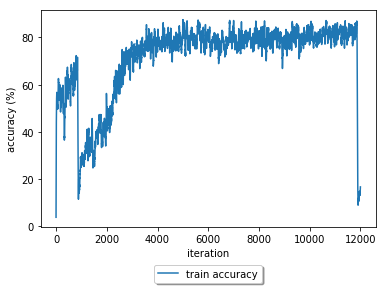

In [43]:
from scipy.signal import savgol_filter
plt.figure()
tr_ac = savgol_filter(MTL_train_acc1, 51, 3)
plt.xlabel('iteration')
plt.ylabel('accuracy (%)')
plt.plot([i for i in range(0, len(tr_ac))], tr_ac*100, label='Task 1 train accuracy')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.subplots_adjust(hspace = 0.2)
plt.show()

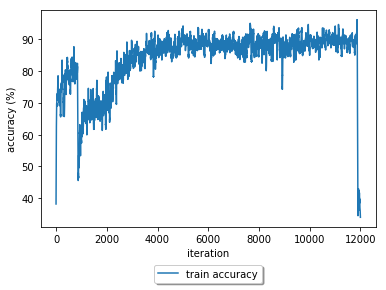

In [44]:
plt.figure()
tr_ac = savgol_filter(MTL_train_acc2, 51, 3)
plt.xlabel('iteration')
plt.ylabel('accuracy (%)')
plt.plot([i for i in range(0, len(tr_ac))], tr_ac*100, label='task 2 train accuracy')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.subplots_adjust(hspace = 0.2)
plt.show()

In [45]:
sess.close()

#### Discuss the performance of the MTL network compared to the single task networks. What do think are the most important things to consider when using MTL?

##### Task 6.3

In this task we want you to compare the MTL's results for different values of $\lambda$. We want you to coampre $5$ different values of $\lambda$ with the stipulation that two of them must be $0$ and $1$; the other 3 are up to you. All other hyperparameters (e.g. number of dense shared layers) can be left as they were in Task 6.2. 

Plot a graph showing the Task 1 and Task 2 accuracies against values of $\lambda$. 
Comment on your results. 
Whats so special about the cases of $\lambda = 0$ and $\lambda = 1$?

####  Task 6.4

##### Similar to tasks  3.2 and 4.2

 - Plot a graph showing complexity (number of paramters) vs. accuracy for each of the to tasks in the MTL network. As above you will need to train four other additional MTL networks where you vary the number/size of the shared and  task specific layers (we advise not making the layers too large or too numerous to avoid very long training times). 
 - You should also include plots of the number of parameters vs accuracy for the individual task 1 and 2 networks - use different colours to distinguish these single task networks.
     - Note 1 : There is no need to train additional Task 1 and Task 2 networks simply use the formats from Question 6.1
     - Note 2: For all MTL formats set $\lambda$ to $0.5$ for equal weighting
     - Note 3: Due to the sub task structure, we will ignore depth in this evaluation as the two tasks can have different depth levels in the MTL architecture. 
     - Note 4: It is advised to include pooling layers (we leave the type of pooling up to you but recommned maxpooling) for the sake of training time - alternativly use larger strides. 
 
 - Discuss the effect of the number/size of the shared and task specific layers in terms of performance and training/testing times. Also compare the performance to the task specific networks from 6.1. 
 
 - Discuss the main pros and cons for multi-task learning.

### 7. Denoising Auto-Encoder (10 points)

While CNNs make very good classifiers, they can also be used for many various tasks such as regression, image generation, image reconstruction and so on. In this part of the coursework you should implement a fully convolutional de-noising auto-encoder, i.e. a network that takes a noisy image as input and outputs the corresponding cleaned output. In this exercise we will introduce a gaussian noise on each input. Our goal is to recover the original noiseless images in the output. We will be using the MNIST dataset here.

Similarly as before we will define the class DAE, and you will need to complete the method 'create_model' and 'compute_loss' accordingly. 

Using the functions tf.layers.conv2d and tf.layers.conv2d_transpose complete the method 'create_model' in the class DAE below. 

conv2d should be used for the encoding part while conv2d_transpose should be used for the decoding part. 
We will use ReLu as the non linear activation for the hidden layers and tanh as the activation for the output layer. 
The network architecture is as follows:

+ Encoding part: a series of conv2d layers with [32, 64, 128] filters of size 4\times4, a stride of 1 in the first layer and a stride of 2 for the second and third layers.  
+ Decodind part: a series of two conv2d_transpose followed by one, one strided conv2d with [64,32,1] filters of size 4\times4. 

The output dimension of the final layer should match the input dimension [batch_size, 28, 28]. If necesseray use the argument padding or the function tf.pad to make the input and ouput dimensions match. 

Complete the method compute_loss. Note that we don't have a classification problem anymore but a regression problem consisting of reconstructing the noiseless version of the input.

In [ ]:
class DAE:
    def __init__(self, x_train, output_dir, lr=0.001, nb_epochs=10, batch_size=50):
        print(x_train.shape)
        self.nb_epochs = nb_epochs
        self.lr = lr
        self.batch_size = batch_size
        self.nb_epochs = nb_epochs
        self.nb_images, self.edge, _ = x_train.shape
        self.nb_iterations = self.nb_images // batch_size
        self.output_dir = output_dir
        self.im = tf.placeholder(tf.float32, [None, 28, 28, 1])
        self.im_n = self.im + tf.random_normal(tf.shape(self.im), mean=0, stddev=1) #inject noise
        self.x_train = x_train[:,:,:, np.newaxis]
        
    def create_model(self):
        print(self.im_n.shape)
        with tf.variable_scope('DAE', reuse=tf.AUTO_REUSE):
            ######### Complete the function ######### 
            # ENCODING
            self.conv1 = tf.layers.conv2d(self.im_n, filters= 32, kernel_size=4, activation = tf.nn.relu, strides=1,padding='same', name='conv2d1') 
            self.conv2 = tf.layers.conv2d(self.conv1, filters= 64, kernel_size=4, activation = tf.nn.relu, strides=2, padding='same',name='conv2d2') 
            self.conv3 = tf.layers.conv2d(self.conv2, filters= 128, kernel_size=4, activation = tf.nn.relu, strides=2, padding='same',name='conv2d3') 
            
            # DECODING
            self.t_conv1 = tf.layers.conv2d_transpose(self.conv3, filters= 64, kernel_size=4, activation = tf.nn.relu, strides=2, padding='same', name='convt2d1') 
            self.t_conv2 = tf.layers.conv2d_transpose(self.t_conv1, filters= 32, kernel_size=4, activation = tf.nn.relu, strides=2, padding='same', name='convt2d2') 
            self.out = tf.layers.conv2d(self.t_conv2, filters= 1, kernel_size=4, activation = tf.nn.tanh, strides=1, padding='same', name='convt2d3') 
            self.recon_im = self.out
            #########################################
            
            tf.summary.image('denoising', tf.concat([self.im_n, self.recon_im], axis=2))
    
    def compute_loss(self):
        with tf.variable_scope('loss'):
            ######### Complete the function ######### 
            self.loss = tf.reduce_mean(tf.square(self.im - self.recon_im)) 
            self.loss = tf.reduce_mean(self.loss + 0.0005 * tf.image.total_variation(self.recon_im))
            #########################################
            self.loss_summ = tf.summary.scalar("reconstruction_loss", self.loss)
                             
    def optimizer(self):
        with tf.variable_scope('optimizer'):
            optimizer = tf.train.AdamOptimizer(learning_rate=self.lr, beta1=0.5)
            self.model_vars = tf.trainable_variables()
            self.trainer = optimizer.minimize(self.loss, var_list=self.model_vars)

In [ ]:
tf.reset_default_graph()
model = DAE(x_train, './DAE_logdir/', 0.0001, 3, 20)
model.create_model()
model.compute_loss()
model.optimizer()
init = (tf.global_variables_initializer(),
        tf.local_variables_initializer())

saver = tf.train.Saver()
summary =tf.Summary()
sess = tf.InteractiveSession()
sess.run(init)
writer = tf.summary.FileWriter(model.output_dir)
writer.add_graph(sess.graph)
if not os.path.exists(model.output_dir):
    os.makedirs(model.output_dir)

Similar to the previous questions, train the DAE by looping over all the mini-batches. For proper training you should input enough noisy versions per image. 
- Plot the training/validation curves and discuss why your trained model is not under/over fitting.
When the training is finished, inject noise into the test data and reconstruct them through a forward pass. For each test image, input 20 noisy versions of it and compute the average accuracies. 

- Test the robustness of the trained network to different levels of noise, demonstrate the results (figure or Table) and discuss them in your report. 
- Why this architecture is able to remove noise from data? 

In [ ]:
for epoch in range(model.nb_epochs):
    randomize = np.arange(model.x_train.shape[0])
    np.random.shuffle(randomize)
    x_in = model.x_train[randomize,:]
    for i in range(model.nb_iterations):
        for r in range(10):
            input_x_train = x_in[i*model.batch_size: (i+1)*model.batch_size]
            _ , denoised, noisy, loss, loss_summ= sess.run([model.trainer, model.recon_im, model.im_n, model.loss, model.loss_summ], 
                                     feed_dict={model.im: input_x_train})
#         print('Epoch %d, Iteration %d, loss %.3f' %(epoch, i, loss))

        if i % 500 == 0:
            print('Epoch %d, Iteration %d, loss %.3f' %(epoch, i, loss))
            fig, ax = plt.subplots(nrows=1, ncols=3)
            ax[0].imshow(input_x_train[0].reshape(28,28))
            ax[1].imshow(noisy[0].reshape(28,28))
            ax[2].imshow(denoised[0].reshape(28,28))
            plt.show()
        writer.add_summary(loss_summ, epoch * model.nb_iterations + i)
    saver.save(sess, model.output_dir, global_step=epoch) 
end = time.time()

### Task 8 - Building a Variational AutoEncoder (VAE) 12 Points

<br>

#### Why use a VAE?

<br>

<p style='text-align: justify;'>
Building on the standard AutoEncoder which was a way of learning some lower dimensional manifold the data could lie on, we want to impose a form of regularisation, that is, we want some topology structure. We want inputs to the AutoEncoder that have a certain structure to be mapped to similar areas in this lower dimensional latent space. But the standard AutoEncoder merely learns how to essentially compress data. In this task, we are interested in learning a more structured latent space where we can sample in this space to then generate a new image that theoretically belongs to the same dataset.
    
In this exercise, we will assume the structure in the latent space follows a standard bi-variate Gaussian i.e. mean $\begin{bmatrix}0\\0\end{bmatrix}$ and covariance $\begin{bmatrix}1&0\\0&1\end{bmatrix}$. This assumption is for simplicity but we can infact assume other distributions (outside the scope for this exercise). We will be using the MNIST dataset for this task.
    
</p>

<br>

#### Architecture

<img src="vae-diagram.png" alt="The Variational AutoEncoder" title="VAE Architecture" />

<br>

#### Notation

<br>

Before diving into some maths, lets define a few terms:
1. $\mathbf{X}$: the dataset distribution we wish to generate from
2. $\mathbf{z}$: the compressed latent variable which quantifies a set of attributes of our dataset
3. $\boldsymbol{\theta}$ : the parameters for the ***encoder*** network
4. $\boldsymbol{\phi}$: the parameters for the ***decoder*** network
5. $p(\mathbf{z})$: the probability of the compressed latent space (given it should follow a standard normal)
6. $q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{X})$: the conditional probability distribution of sampling the compressed latent variable given the dataset approximated by our encoder network with parameters $\boldsymbol{\phi}$
7. $p_{\boldsymbol{\theta}}(\mathbf{X}|\mathbf{z})$: the conditional probability distribution of generating the dataset given the compressed latent space by our decoder network with parameters $\boldsymbol{\theta}$

<br>

#### Optimisation

<br>

The quantity we are interested in maximising for the $i$-th observation is:

$
\begin{align}
    \log p (\mathbf{x}_i) && \text{which can be rewritten as...}\\
    &= \int_{\mathbf{z}\in\mathcal{Z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) \log p (\mathbf{x}_i) \text{d}\mathbf{z} & \text{as the integral over a distribution is 1...}\\
    &= \int_{\mathbf{z}\in\mathcal{Z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i)[\log p (\mathbf{z}|\mathbf{x}_i) - \log p(\mathbf{z}) + \log p_\boldsymbol{\theta}(\mathbf{x}_i|\mathbf{z})]\text{d}\mathbf{z} & \text{consider Baye's rule...}\\
    &= \int_{\mathbf{z}\in\mathcal{Z}} q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) \log \frac{p (\mathbf{z}|\mathbf{x}_i)}{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} - q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i)\log \frac{p (\mathbf{z})}{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} + q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) \log p_\boldsymbol{\theta}(\mathbf{x}_i|\mathbf{z})\text{d}\mathbf{z}\\
    &= \text{D}_{\text{KL}}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) || p (\mathbf{z}|\mathbf{x}_i)) - \text{D}_{\text{KL}}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) || p (\mathbf{z})) + \mathbb{E}_{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} [\log p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})]\\
    &=  \text{D}_{\text{KL}}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) || p (\mathbf{z}|\mathbf{x}_i)) + \mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}; \mathbf{x}_i) &\text{where the last two terms have been grouped as $\mathcal{L}$}
\end{align}
$

<br>


As the first term in the line above is intractable to compute, we can say that $\log p_\boldsymbol{\theta} (\mathbf{x}_i) \ge \mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}; \mathbf{x}_i)$ as the KL-divergence is a distance measure (and hence non-negative) and $\mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}; \mathbf{x}_i)$ is known as the **variational lower bound**. Instead of maximising the log probability directly, we can instead maximise this lower bound! If you are unfamiliar with the KL-divergence, check out this [Wikipedia](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence).

<br>

The lower bound can be clearly seen as two main components:

$
\begin{align}
\mathcal{L}(\boldsymbol{\theta}, \boldsymbol{\phi}; \mathbf{x}_i) = \color{blue}{\mathbb{E}_{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} [\log p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})]} - \color{green}{\text{D}_{\text{KL}}(q_{\boldsymbol{\phi}}(\mathbf{z}|\mathbf{x}_i) || p (\mathbf{z}))}
\end{align}
$
+ <font color='blue'> How well can we reconstruct our original data from the latent space?</font>
+ <font color='green'> How similar is the latent space to a standard Gaussian?</font>

A remark on the second point - we are trying to find a Gaussian distribution manifold in latent space for our dataset. This is known as a *variational* method which should be part of the Bayesian Machine Learning module.

<br>

#### Derivations

Given that $\mathbf{\hat{x}}_i$ is a draw from $p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})\sim\mathcal{N}(\mathbf{x},\sigma^2\mathbf{I})$, the expectation of $\log p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})$ can be computed as:

$
\begin{align}
\mathbb{E}_{q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i)} [\log p_{\boldsymbol{\theta}} (\mathbf{x}_i|\mathbf{z})] &= -\frac{m}{2}\log 2\pi\sigma^2 - \frac{1}{2}(\mathbf{\hat{x}}_i - \mathbf{x}_i)^\text{T}(\sigma^2\mathbf{I})^{-1}(\mathbf{\hat{x}}_i - \mathbf{x}_i)\\
\mathbb{E}_{q_{\boldsymbol{\phi}} (\mathbf{Z}|\mathbf{X})} [\log p_{\boldsymbol{\theta}} (\mathbf{X}|\mathbf{Z})] &\propto \sum_{i = 1}^{i = n}\sum_{j = 1}^{j = m} (\hat{x}_{ij} - x_{ij})^2 & \text{as everything else is just a constant}
\end{align}
$

<font color='red'>Given that $q_{\boldsymbol{\phi}} (\mathbf{z}|\mathbf{x}_i) \sim \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2\mathbf{I})$, derive the KL-divergence term between this and $p_\boldsymbol{\theta} (\mathbf{z})$ i.e. $\text{D}_{\text{KL}} (\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2\mathbf{I}), \mathcal{N}(0, \mathbf{I}))$:</font>

$
\begin{align}
\text{D}_{\text{KL}} (\mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2\mathbf{I}), \mathcal{N}(0, \mathbf{I})) &= \int_{\mathbf{z}\in\mathcal{Z}} ?\text{ d}\mathbf{z}
\end{align}
$

Further readings: There are many useful online tutorials that provide deep insight as how VAEs work or to implement them; for instace [tutorial1](https://arxiv.org/abs/1606.05908) [tutorial2](http://ruishu.io/2018/03/14/vae/). 

#### Defining the Data and Helper Functions

In [23]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()

image_size       = x_train.shape[1]
original_dim     = image_size * image_size

# Flatten each image to be a vector (you can try convolutional layers as an extension)
x_train          = np.reshape(x_train, [-1, original_dim])
x_test           = np.reshape(x_test, [-1, original_dim])
x_train          = x_train.astype('float32') / 255
x_test           = x_test.astype('float32') / 255

# Visualisation parameters (for after the implementation of the VAE - start playing with these after the VAE seems to work!)
n                = 29 # Number of digits to show per row / col
dsize            = 28 # Digit size

z1               = norm.ppf(np.linspace(0.01, 0.99, n))
z2               = norm.ppf(np.linspace(0.01, 0.99, n))
z_grid           = np.dstack(np.meshgrid(z1, z2))

Zf               = lambda x : sess.run(z_mean, feed_dict = {t_X : x})
Xf               = lambda z_grid : sess.run(t_X_hat, feed_dict = {z : z_grid.reshape(n * n, nlatent)}).reshape(n, n, dsize, dsize)

def get_batch(*args, size):
    """ Loops through each argument in batches of [size] """
    
    n = len(args[0])
    if size is None or size >= n:
        yield from args
        return None
    r = np.random.permutation(n)
    for i in range(n // size + 1):
        yield(arg[r[i * size : (i + 1) * size]] for arg in args)



def visualise(X, y, sep = 2):
    #     """ Visualise the mapped 2D manifold """
    # Feel free to modify this code for your visualisations...
    Z  = Zf(x_test)
    Xh = Xf(z_grid)

    plt.figure(figsize = (12, 10))
    plt.scatter(Z[:, 0], Z[:, 1], c = y)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")

    plt.figure(figsize = (12, 10))
    plt.imshow(np.block(list(map(list, Xh))), cmap = 'gray')
    start_range    = dsize // 2
    end_range      = n * dsize + start_range
    pixel_range    = np.arange(start_range, end_range, dsize)
    sample_range_x = np.round(z1, 2)
    sample_range_y = np.round(z2, 2)
    plt.xticks(pixel_range[::sep], sample_range_x[::sep])
    plt.yticks(pixel_range[::sep], sample_range_y[::sep])

#### Task 8.1 Implementation of VAE

<br>

The simpler implementation of the VAE is to build off the MLP i.e. no convolutional layers. The code below is designed for this but feel free to swap out this assumption for convolutions should you feel more confident. Feel free to add `tf.summary` definitions in a similar way to previous tasks for tensorboard visualisations.

 #### Note: If implementing task 8.1 in TF (as guided bellow) is not straightforward for you, use an easier option: [Keras](https://keras.io/examples/variational_autoencoder/) implementation of VAE. In these case, you will be marked down 4 points but you can immediately proceed to task 8.2. 

In [24]:
import time

# Hyperparameters...
layers   = [512, 256, 128]
nlatent  = 2
batch    = 128
epochs   = 30
alpha    = 1e-3



# General dtype to use
dtype    = 'float32'

# Number of features
m        = x_train.shape[1]

startT = time.time()

# Reset the graph to ensure blank graph initially...
tf.reset_default_graph()

# Define placeholder for 'X' data
t_X      = tf.placeholder(dtype = dtype, shape = [None, m], name = 'X')

# Define how t_X maps to the layer before the latent space
with tf.name_scope('Encoder'):
    h        = t_X
    for i, layer in enumerate(layers, 1):
        with tf.name_scope(f'Layer_{i}'):
            ######### Map how we get from the previous layer to the next hidden layer #########
            h    = tf.layers.dense(inputs=h, units=layer, activation=tf.nn.relu)
    
# Define how we get the mean and variance from the previous hidden layer
with tf.name_scope('Latent'):
    
    with tf.name_scope('Mean'):
        z_mean   = tf.layers.dense(inputs=h, units=nlatent)

    with tf.name_scope('Variance'):
        z_var    = tf.layers.dense(inputs=h, units=1)
        
    # Code the "reparameterisation trick"
    with tf.name_scope('Sample'):
        epsilon  = tf.random_normal(tf.shape(z_mean), mean=0, stddev=1)
        z_sample = z_mean + tf.math.exp(z_var / 2)*epsilon
        z        = tf.placeholder_with_default(z_sample, shape = [None, nlatent], name = 'z')


# Define how "z" decodes to our reconstructed "t_X" estimate
with tf.name_scope('Decoder'):
    h        = z
    for i, layer in enumerate(layers[::-1], 1):
        with tf.name_scope(f'Layer_{i}'):
            h    = tf.layers.dense(inputs=h, units=layer, activation=tf.nn.relu)
    
    with tf.name_scope('Final'):
        t_X_hat  = tf.layers.dense(inputs=h, units=m, activation=tf.nn.sigmoid)

        
# Define the loss function as defined in the derivation section
with tf.name_scope('Loss'):
    with tf.name_scope('AutoEncoder'):
        # The normal AutoEncoder loss should measure how far our t_X_hat is from t_X
        loss_ae  = -tf.reduce_sum(t_X * tf.log(1e-10 + t_X_hat)
                           + (1-t_X) * tf.log(1e-10 + 1 - t_X_hat),
                           1)

        
    with tf.name_scope('KL_Divergence'):
        # The KL-divergence between z and a standard normal you derived earlier
        loss_kl  = -0.5 * tf.reduce_sum(1 + z_var 
                                           - tf.square(z_mean) 
                                           - tf.exp(z_var), 1)
        
    loss = tf.reduce_mean(loss_ae + loss_kl, name = 'loss')

# Define final components before training the model
optim    = tf.train.AdamOptimizer(alpha).minimize(loss)
train    = {t_X : x_train}

sess     = tf.InteractiveSession()
writer   = tf.summary.FileWriter('./VAE_MLP_logdir', sess.graph)
sess.run(tf.global_variables_initializer())

# Gradient descent loop with verbose loss check...
# Hopefully we see our loss reduce!

train_losses = []
test_losses = []


for i in range(epochs):
    losses  = []
    for xb, in get_batch(x_train, size = batch):
        nb = len(xb)
        sess.run(optim, feed_dict = {t_X : xb})
        losses.append(nb * sess.run(loss, feed_dict = {t_X : xb}))
        print(f'\rIteration {i:2d}: loss = {losses[-1] / nb:6,.2f}', end = '')
    print(f'\rIteration {i:2d}: loss = {sum(losses) / len(x_train):6,.2f}')
    train_losses.append(sess.run(loss, feed_dict = {t_X: x_train}))
    test_losses.append(sess.run(loss, feed_dict = {t_X: x_test}))
    
timeTaken = int(time.time() - startT)

print(timeTaken,'s taken')


Iteration  0: loss = 184.45
Iteration  1: loss = 160.72
Iteration  2: loss = 153.37
Iteration  3: loss = 149.42
Iteration  4: loss = 147.22
Iteration  5: loss = 145.66
Iteration  6: loss = 144.47
Iteration  7: loss = 143.19
Iteration  8: loss = 142.52
Iteration  9: loss = 142.04
Iteration 10: loss = 141.13
Iteration 11: loss = 140.86
Iteration 12: loss = 141.10
Iteration 13: loss = 139.83
Iteration 14: loss = 139.24
Iteration 15: loss = 139.18
Iteration 16: loss = 138.79
Iteration 17: loss = 138.78
Iteration 18: loss = 138.03
Iteration 19: loss = 137.96
Iteration 20: loss = 137.51
Iteration 21: loss = 137.53
Iteration 22: loss = 137.36
Iteration 23: loss = 137.33
Iteration 24: loss = 137.02
Iteration 25: loss = 136.95
Iteration 26: loss = 136.80
Iteration 27: loss = 136.26
Iteration 28: loss = 136.87
Iteration 29: loss = 136.63
108 s taken


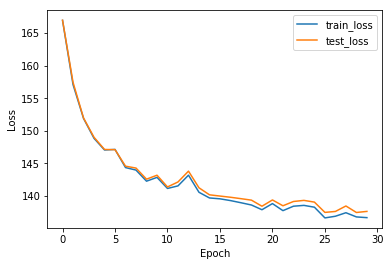

In [25]:
plt.plot(train_losses, label='train_loss')
plt.plot(test_losses, label='test_loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

#### Visualisation Check

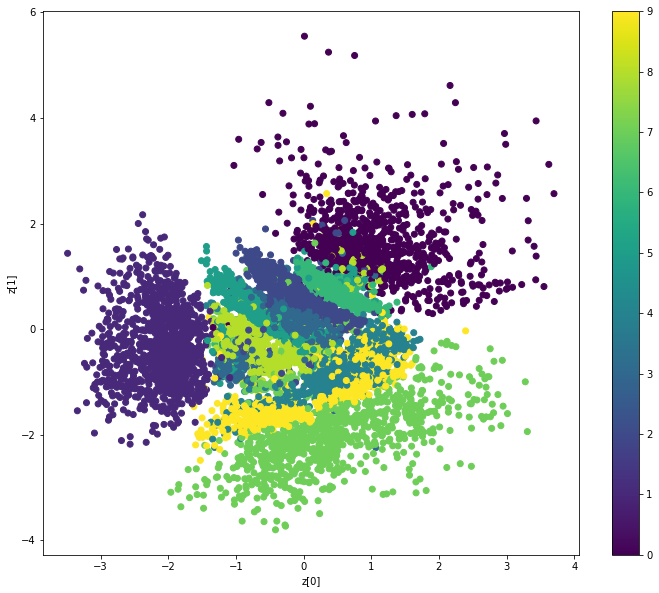

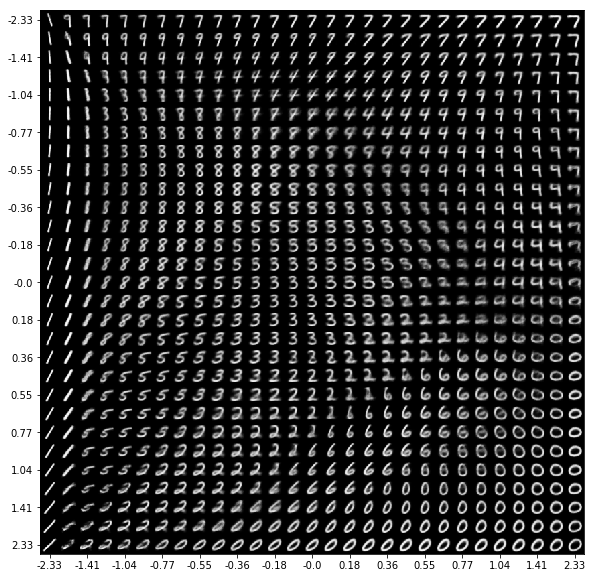

In [26]:
visualise(x_test, y_test)

####  Task 8.2

<br>

 - Plot the learning curve for your VAE
 - Generate new handwritten digits from your model by sampling `Z` = $\mathbf{z}\in\mathbb{R}^{n,2}$ and running `sess.run(t_X_hat, feed_dict = {z : Z))` in a separate code cell
     - Discuss how good / bad are these images?
         - Why are they good / bad? (consider the assumptions of your implementation of the VAE)
 - From observing your learnt manifold (by using the `visualise` function or otherwise), draw a comparison between the direct mapped points on your manifold (scatter plot) and the images that lay on the manifold (imshow)
     - Why are some points images more mixed than others?
     - Can we be smarter in where we should sample to get *better* generated handwritten digits?

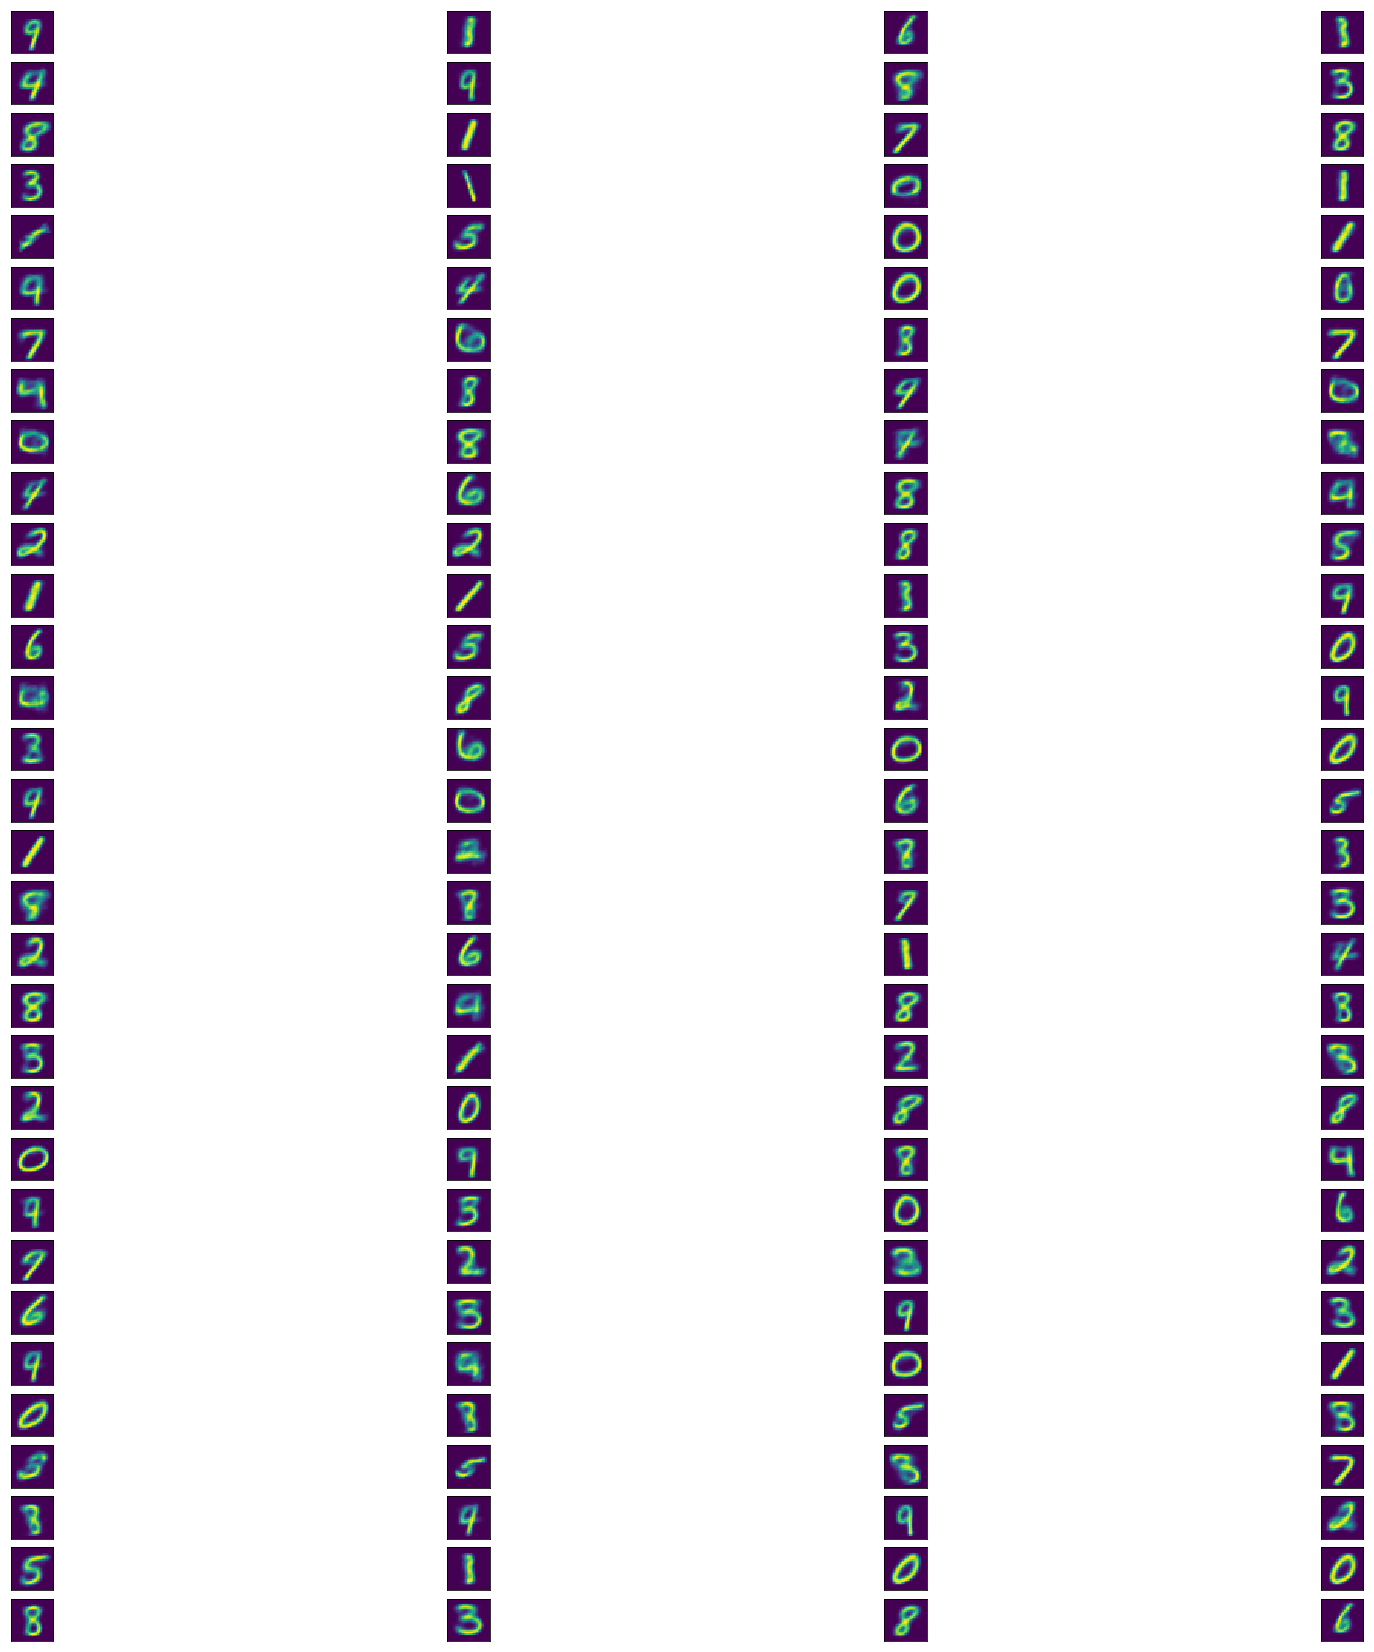

In [27]:
Z = np.random.normal(size=(batch,nlatent),loc=0, scale=1)
generated = sess.run(t_X_hat, feed_dict={z: Z})



fig, ax = plt.subplots(nrows=batch//4, ncols=4, figsize=(30,30))
counter = 0
for row in ax:
    for col in row:
        col.imshow(generated[counter].reshape(28,28))
        col.set_xticks([])
        col.set_yticks([])
        counter += 1
#             ax[0].imshow(input_x_train[0].reshape(28,28))
#             ax[1].imshow(noisy[0].reshape(28,28))
#             ax[2].imshow(denoised[0].reshape(28,28))
plt.imshow(generated[2].reshape(28,28))

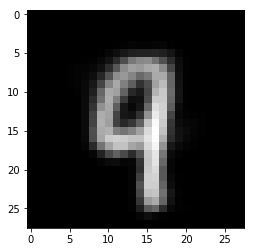

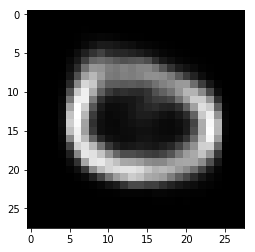

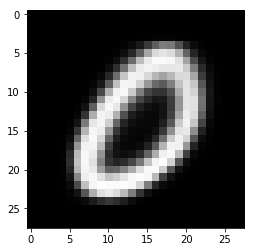

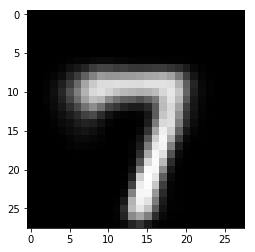

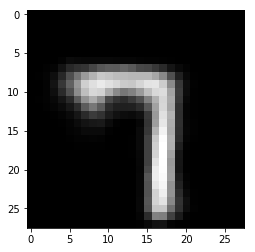

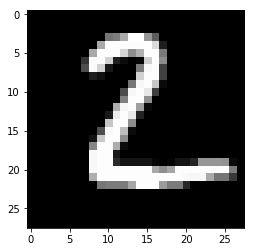

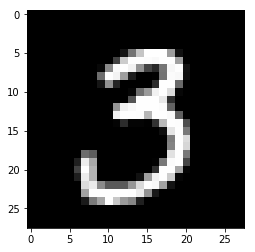

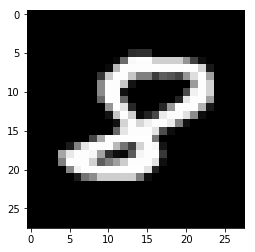

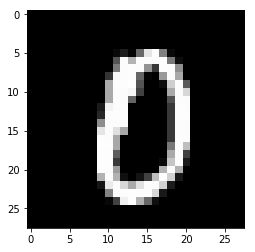

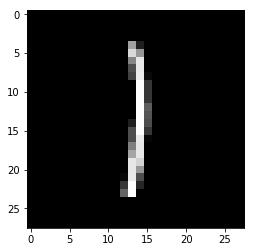

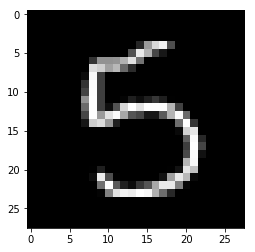

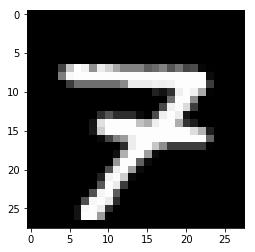

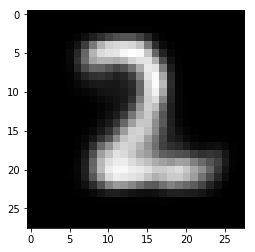

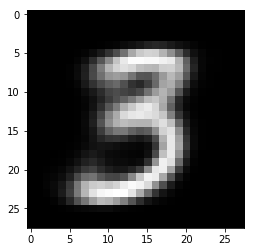

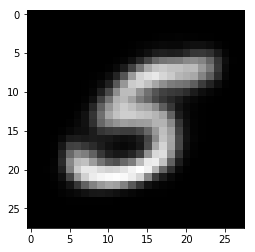

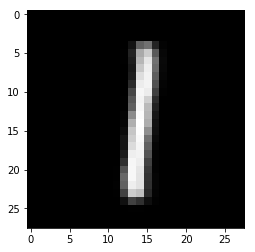

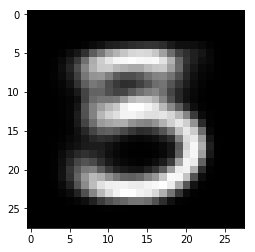

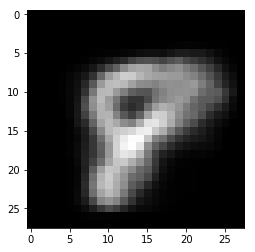

In [29]:
def gen_digit(low=-2,high=2):
    z1,z2 = np.random.uniform(low,high,2)
    Z = [[z1,z2]]
    digit = sess.run(t_X_hat, feed_dict={z: Z})
    digit = digit[0] #strip off outer bracket
    return digit

def plot_digit(digit):
    digit = np.reshape(digit,(28,28))
    plt.imshow(digit,interpolation='nearest', cmap='gray')
    plt.show()

for d in range(5):
    plot_digit(gen_digit())
    

x_test_out = sess.run(t_X_hat, feed_dict = {t_X: x_test})


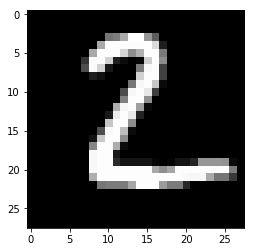

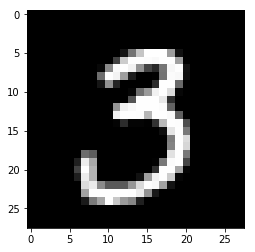

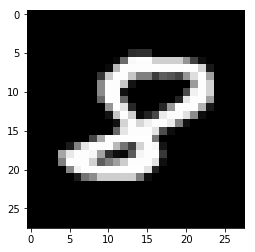

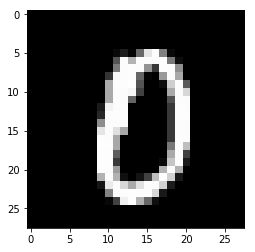

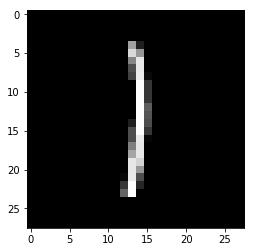

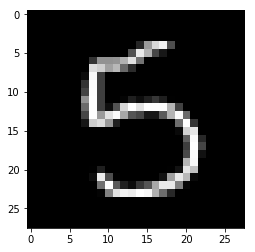

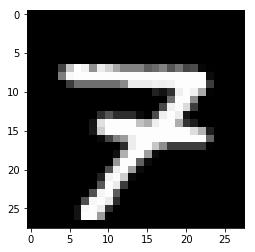

In [30]:
plot_digit(x_test[1])
plot_digit(x_test[90])
plot_digit(x_test[61])
plot_digit(x_test[55])
plot_digit(x_test[40])
plot_digit(x_test[53])
plot_digit(x_test[64])

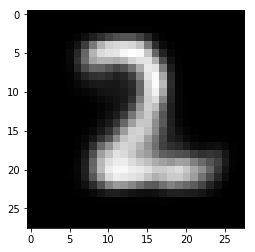

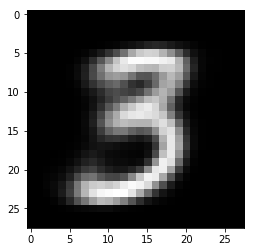

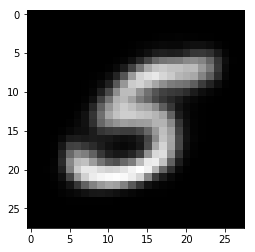

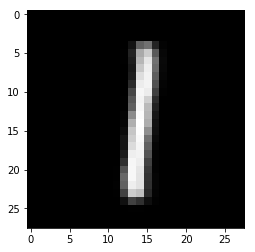

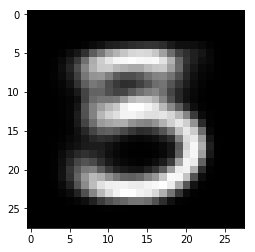

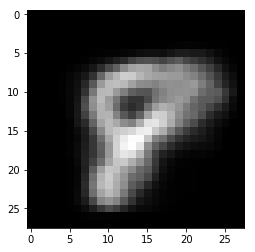

In [31]:
plot_digit(x_test_out[1])
plot_digit(x_test_out[90])
plot_digit(x_test_out[61])
plot_digit(x_test_out[40])
plot_digit(x_test_out[53])
plot_digit(x_test_out[64])